In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from rasterio.merge import merge
import glob

from rasterio.plot import adjust_band
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image
import rasterio.features
import rasterio.warp
import rasterio.mask
from rasterio.merge import merge
import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras.models import load_model

from skimage.transform import resize

In [2]:
#ensure size of tile is uniform, and reshape the numpy into a image format then normalize
def newXpreprocessing(tile,layers,width,height):
    #print(tile.shape,"before")
    tile = resize(tile, (layers,width,height))
    #print(tile.shape,"resize")
    tile = reshape_as_image(tile)
    #print(tile.shape,"reshape")
    #normalising tile
    tile = tile/255
    return tile

In [3]:
#Keras compatible preditor - works tif. Each image is predicted against and then saved as a colour representing the prediction
# to be turned into a mosaic at the next step
def predictingNewX(model,data_dir_list,data_path,width,height,layers):
    #load list of image names in each category
    img_list = os.listdir(os.path.join(data_path))
     #   print ('Loading the images for prediction -'+'{}\n'.format(dataset))
    num_img_files = len(img_list) 

    for i in range(num_img_files):
        img_name = img_list[i]
        img_filename = os.path.join(data_path,img_name)
        #model expects image formatted a certain way
        X_new = []
        with rasterio.open(img_filename) as ds:
            tile=ds.read()
            #preprocess tille according to model expectations
            pre_tile=newXpreprocessing(tile,layers,width,height)

        # Add tile to array
        X_new.append(pre_tile)
        # Make sure they're numpy arrays (as opposed to lists)
        X_new = np.array(X_new)
        #make prediction against X-new array
        #yNew = model.predict_classes(X_new)
        yNew = model.predict(X_new)
        #print(yNew)
        classes_y=np.argmax(yNew,axis=1)
        #print(classes_y)
        #determine colour of class of interest
        class_image = loadClassTile(classes_y,class_path)
        with rasterio.open(
            str(output_path) +'\\' + str(i) +'_y.tif',
            'w',
            driver='GTiff',
            height=class_image.shape[1],
            width=class_image.shape[2],
            count=class_image.shape[0],
            dtype=class_image.dtype,
            class_image=ds.crs,
            nodata=None,
            transform=ds.transform
            ) as dst:
            dst.write(class_image)
        print('processed: '+ str(i) +'_y.tif')


In [4]:
#Method to replace a detected class with a single colour image representing that class. 
def loadClassTile(yNew,class_path):
    if yNew == 0:
        classlabel = 'donga.tiff'
    elif yNew == 1:
        classlabel = 'dried_mudflat.tiff'
    elif yNew == 2:
        classlabel = 'grass_vegetation.tiff'  
    elif yNew == 3:
        classlabel = 'sandstone.tiff'  
    elif yNew == 4:
        classlabel = 'shrub_vegetation.tiff'
    else:
        classlabel = 'error.tiff'
    
    with rasterio.open(str(class_path) + '\\' + classlabel) as cs:
        class_image=cs.read()
    return class_image
    
    

In [5]:
# https://gis.stackexchange.com/questions/348925/merging-rasters-with-rasterio-in-blocks-to-avoid-memoryerror
# https://rasterio.readthedocs.io/en/latest/api/rasterio.merge.html
# https://automating-gis-processes.github.io/CSC18/lessons/L6/raster-mosaic.html

# this script is performed in memory and is thus memroy intensive TO DO: create a rasterio-in-blocks implementation
#a folder is created containig the class images(with CRS), all images within this folder are mosaiced together into a single raster 
def merge_raster_in_folder(src_dir, dest_dir):
    """Merge all the raster (TIFF extension) within the given directory"""
    #simple merges outputs from model and merges them
    #src_dir = r"C:\Data\Test_dataset"
    out_fp = dest_dir + r"\LULC_prediction2.tif"
    # create list of raster files in source folder
    src_files_to_mosaic = []
    os.chdir(src_dir)
    for file in glob.glob("*.tif"):
        src = rasterio.open(file)
        src_files_to_mosaic.append(file)

    # create list of raster objects from the list of raster filename
    sources = [rasterio.open(raster) for raster in src_files_to_mosaic]

    # create array representing all source rasters mosaicked together
    mosaic, out_transform = merge(sources)
    #checkl mosaic is created 
    show(mosaic, cmap='terrain')

    out_meta = src.meta.copy()
    out_meta.update({"driver":"GTiff",
                     "height":mosaic.shape[1],
                     "width":mosaic.shape[2],
                     "transform":out_transform #,
                     #"crs":'+proj=latlong' #TO DO: Pass in CRS
    }
    )
    with rasterio.open(out_fp, "w", **out_meta) as dest:
        dest.write(mosaic)

In [6]:
#declare path directories
data_path = r'C:\Data\LULC_predict'
output_path = r'C:\Data\output3'
class_path = r'C:\Data\LULC_Classes'
result_path = r'C:\Data'
data_dir_list = os.listdir(data_path)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 83, 83, 64)        3520      
                                                                 
 batch_normalization (BatchN  (None, 83, 83, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 83, 83, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 41, 41, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 107584)            0         
                                                                 
 dense (Dense)               (None, 192)               2

C:\Users\Gavin\.conda\envs\Visualistion_Rasterio_GPU\lib\site-packages\rasterio\__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


processed: 0_y.tif
processed: 1_y.tif
processed: 2_y.tif
processed: 3_y.tif
processed: 4_y.tif
processed: 5_y.tif
processed: 6_y.tif
processed: 7_y.tif
processed: 8_y.tif
processed: 9_y.tif
processed: 10_y.tif
processed: 11_y.tif
processed: 12_y.tif
processed: 13_y.tif
processed: 14_y.tif
processed: 15_y.tif
processed: 16_y.tif
processed: 17_y.tif
processed: 18_y.tif
processed: 19_y.tif
processed: 20_y.tif
processed: 21_y.tif
processed: 22_y.tif
processed: 23_y.tif
processed: 24_y.tif
processed: 25_y.tif
processed: 26_y.tif
processed: 27_y.tif
processed: 28_y.tif
processed: 29_y.tif
processed: 30_y.tif
processed: 31_y.tif
processed: 32_y.tif
processed: 33_y.tif
processed: 34_y.tif
processed: 35_y.tif
processed: 36_y.tif
processed: 37_y.tif
processed: 38_y.tif
processed: 39_y.tif
processed: 40_y.tif
processed: 41_y.tif
processed: 42_y.tif
processed: 43_y.tif
processed: 44_y.tif
processed: 45_y.tif
processed: 46_y.tif
processed: 47_y.tif
processed: 48_y.tif
processed: 49_y.tif
processed:

processed: 398_y.tif
processed: 399_y.tif
processed: 400_y.tif
processed: 401_y.tif
processed: 402_y.tif
processed: 403_y.tif
processed: 404_y.tif
processed: 405_y.tif
processed: 406_y.tif
processed: 407_y.tif
processed: 408_y.tif
processed: 409_y.tif
processed: 410_y.tif
processed: 411_y.tif
processed: 412_y.tif
processed: 413_y.tif
processed: 414_y.tif
processed: 415_y.tif
processed: 416_y.tif
processed: 417_y.tif
processed: 418_y.tif
processed: 419_y.tif
processed: 420_y.tif
processed: 421_y.tif
processed: 422_y.tif
processed: 423_y.tif
processed: 424_y.tif
processed: 425_y.tif
processed: 426_y.tif
processed: 427_y.tif
processed: 428_y.tif
processed: 429_y.tif
processed: 430_y.tif
processed: 431_y.tif
processed: 432_y.tif
processed: 433_y.tif
processed: 434_y.tif
processed: 435_y.tif
processed: 436_y.tif
processed: 437_y.tif
processed: 438_y.tif
processed: 439_y.tif
processed: 440_y.tif
processed: 441_y.tif
processed: 442_y.tif
processed: 443_y.tif
processed: 444_y.tif
processed: 44

processed: 789_y.tif
processed: 790_y.tif
processed: 791_y.tif
processed: 792_y.tif
processed: 793_y.tif
processed: 794_y.tif
processed: 795_y.tif
processed: 796_y.tif
processed: 797_y.tif
processed: 798_y.tif
processed: 799_y.tif
processed: 800_y.tif
processed: 801_y.tif
processed: 802_y.tif
processed: 803_y.tif
processed: 804_y.tif
processed: 805_y.tif
processed: 806_y.tif
processed: 807_y.tif
processed: 808_y.tif
processed: 809_y.tif
processed: 810_y.tif
processed: 811_y.tif
processed: 812_y.tif
processed: 813_y.tif
processed: 814_y.tif
processed: 815_y.tif
processed: 816_y.tif
processed: 817_y.tif
processed: 818_y.tif
processed: 819_y.tif
processed: 820_y.tif
processed: 821_y.tif
processed: 822_y.tif
processed: 823_y.tif
processed: 824_y.tif
processed: 825_y.tif
processed: 826_y.tif
processed: 827_y.tif
processed: 828_y.tif
processed: 829_y.tif
processed: 830_y.tif
processed: 831_y.tif
processed: 832_y.tif
processed: 833_y.tif
processed: 834_y.tif
processed: 835_y.tif
processed: 83

processed: 1171_y.tif
processed: 1172_y.tif
processed: 1173_y.tif
processed: 1174_y.tif
processed: 1175_y.tif
processed: 1176_y.tif
processed: 1177_y.tif
processed: 1178_y.tif
processed: 1179_y.tif
processed: 1180_y.tif
processed: 1181_y.tif
processed: 1182_y.tif
processed: 1183_y.tif
processed: 1184_y.tif
processed: 1185_y.tif
processed: 1186_y.tif
processed: 1187_y.tif
processed: 1188_y.tif
processed: 1189_y.tif
processed: 1190_y.tif
processed: 1191_y.tif
processed: 1192_y.tif
processed: 1193_y.tif
processed: 1194_y.tif
processed: 1195_y.tif
processed: 1196_y.tif
processed: 1197_y.tif
processed: 1198_y.tif
processed: 1199_y.tif
processed: 1200_y.tif
processed: 1201_y.tif
processed: 1202_y.tif
processed: 1203_y.tif
processed: 1204_y.tif
processed: 1205_y.tif
processed: 1206_y.tif
processed: 1207_y.tif
processed: 1208_y.tif
processed: 1209_y.tif
processed: 1210_y.tif
processed: 1211_y.tif
processed: 1212_y.tif
processed: 1213_y.tif
processed: 1214_y.tif
processed: 1215_y.tif
processed:

processed: 1544_y.tif
processed: 1545_y.tif
processed: 1546_y.tif
processed: 1547_y.tif
processed: 1548_y.tif
processed: 1549_y.tif
processed: 1550_y.tif
processed: 1551_y.tif
processed: 1552_y.tif
processed: 1553_y.tif
processed: 1554_y.tif
processed: 1555_y.tif
processed: 1556_y.tif
processed: 1557_y.tif
processed: 1558_y.tif
processed: 1559_y.tif
processed: 1560_y.tif
processed: 1561_y.tif
processed: 1562_y.tif
processed: 1563_y.tif
processed: 1564_y.tif
processed: 1565_y.tif
processed: 1566_y.tif
processed: 1567_y.tif
processed: 1568_y.tif
processed: 1569_y.tif
processed: 1570_y.tif
processed: 1571_y.tif
processed: 1572_y.tif
processed: 1573_y.tif
processed: 1574_y.tif
processed: 1575_y.tif
processed: 1576_y.tif
processed: 1577_y.tif
processed: 1578_y.tif
processed: 1579_y.tif
processed: 1580_y.tif
processed: 1581_y.tif
processed: 1582_y.tif
processed: 1583_y.tif
processed: 1584_y.tif
processed: 1585_y.tif
processed: 1586_y.tif
processed: 1587_y.tif
processed: 1588_y.tif
processed:

processed: 1918_y.tif
processed: 1919_y.tif
processed: 1920_y.tif
processed: 1921_y.tif
processed: 1922_y.tif
processed: 1923_y.tif
processed: 1924_y.tif
processed: 1925_y.tif
processed: 1926_y.tif
processed: 1927_y.tif
processed: 1928_y.tif
processed: 1929_y.tif
processed: 1930_y.tif
processed: 1931_y.tif
processed: 1932_y.tif
processed: 1933_y.tif
processed: 1934_y.tif
processed: 1935_y.tif
processed: 1936_y.tif
processed: 1937_y.tif
processed: 1938_y.tif
processed: 1939_y.tif
processed: 1940_y.tif
processed: 1941_y.tif
processed: 1942_y.tif
processed: 1943_y.tif
processed: 1944_y.tif
processed: 1945_y.tif
processed: 1946_y.tif
processed: 1947_y.tif
processed: 1948_y.tif
processed: 1949_y.tif
processed: 1950_y.tif
processed: 1951_y.tif
processed: 1952_y.tif
processed: 1953_y.tif
processed: 1954_y.tif
processed: 1955_y.tif
processed: 1956_y.tif
processed: 1957_y.tif
processed: 1958_y.tif
processed: 1959_y.tif
processed: 1960_y.tif
processed: 1961_y.tif
processed: 1962_y.tif
processed:

processed: 2292_y.tif
processed: 2293_y.tif
processed: 2294_y.tif
processed: 2295_y.tif
processed: 2296_y.tif
processed: 2297_y.tif
processed: 2298_y.tif
processed: 2299_y.tif
processed: 2300_y.tif
processed: 2301_y.tif
processed: 2302_y.tif
processed: 2303_y.tif
processed: 2304_y.tif
processed: 2305_y.tif
processed: 2306_y.tif
processed: 2307_y.tif
processed: 2308_y.tif
processed: 2309_y.tif
processed: 2310_y.tif
processed: 2311_y.tif
processed: 2312_y.tif
processed: 2313_y.tif
processed: 2314_y.tif
processed: 2315_y.tif
processed: 2316_y.tif
processed: 2317_y.tif
processed: 2318_y.tif
processed: 2319_y.tif
processed: 2320_y.tif
processed: 2321_y.tif
processed: 2322_y.tif
processed: 2323_y.tif
processed: 2324_y.tif
processed: 2325_y.tif
processed: 2326_y.tif
processed: 2327_y.tif
processed: 2328_y.tif
processed: 2329_y.tif
processed: 2330_y.tif
processed: 2331_y.tif
processed: 2332_y.tif
processed: 2333_y.tif
processed: 2334_y.tif
processed: 2335_y.tif
processed: 2336_y.tif
processed:

processed: 2665_y.tif
processed: 2666_y.tif
processed: 2667_y.tif
processed: 2668_y.tif
processed: 2669_y.tif
processed: 2670_y.tif
processed: 2671_y.tif
processed: 2672_y.tif
processed: 2673_y.tif
processed: 2674_y.tif
processed: 2675_y.tif
processed: 2676_y.tif
processed: 2677_y.tif
processed: 2678_y.tif
processed: 2679_y.tif
processed: 2680_y.tif
processed: 2681_y.tif
processed: 2682_y.tif
processed: 2683_y.tif
processed: 2684_y.tif
processed: 2685_y.tif
processed: 2686_y.tif
processed: 2687_y.tif
processed: 2688_y.tif
processed: 2689_y.tif
processed: 2690_y.tif
processed: 2691_y.tif
processed: 2692_y.tif
processed: 2693_y.tif
processed: 2694_y.tif
processed: 2695_y.tif
processed: 2696_y.tif
processed: 2697_y.tif
processed: 2698_y.tif
processed: 2699_y.tif
processed: 2700_y.tif
processed: 2701_y.tif
processed: 2702_y.tif
processed: 2703_y.tif
processed: 2704_y.tif
processed: 2705_y.tif
processed: 2706_y.tif
processed: 2707_y.tif
processed: 2708_y.tif
processed: 2709_y.tif
processed:

processed: 3039_y.tif
processed: 3040_y.tif
processed: 3041_y.tif
processed: 3042_y.tif
processed: 3043_y.tif
processed: 3044_y.tif
processed: 3045_y.tif
processed: 3046_y.tif
processed: 3047_y.tif
processed: 3048_y.tif
processed: 3049_y.tif
processed: 3050_y.tif
processed: 3051_y.tif
processed: 3052_y.tif
processed: 3053_y.tif
processed: 3054_y.tif
processed: 3055_y.tif
processed: 3056_y.tif
processed: 3057_y.tif
processed: 3058_y.tif
processed: 3059_y.tif
processed: 3060_y.tif
processed: 3061_y.tif
processed: 3062_y.tif
processed: 3063_y.tif
processed: 3064_y.tif
processed: 3065_y.tif
processed: 3066_y.tif
processed: 3067_y.tif
processed: 3068_y.tif
processed: 3069_y.tif
processed: 3070_y.tif
processed: 3071_y.tif
processed: 3072_y.tif
processed: 3073_y.tif
processed: 3074_y.tif
processed: 3075_y.tif
processed: 3076_y.tif
processed: 3077_y.tif
processed: 3078_y.tif
processed: 3079_y.tif
processed: 3080_y.tif
processed: 3081_y.tif
processed: 3082_y.tif
processed: 3083_y.tif
processed:

processed: 3413_y.tif
processed: 3414_y.tif
processed: 3415_y.tif
processed: 3416_y.tif
processed: 3417_y.tif
processed: 3418_y.tif
processed: 3419_y.tif
processed: 3420_y.tif
processed: 3421_y.tif
processed: 3422_y.tif
processed: 3423_y.tif
processed: 3424_y.tif
processed: 3425_y.tif
processed: 3426_y.tif
processed: 3427_y.tif
processed: 3428_y.tif
processed: 3429_y.tif
processed: 3430_y.tif
processed: 3431_y.tif
processed: 3432_y.tif
processed: 3433_y.tif
processed: 3434_y.tif
processed: 3435_y.tif
processed: 3436_y.tif
processed: 3437_y.tif
processed: 3438_y.tif
processed: 3439_y.tif
processed: 3440_y.tif
processed: 3441_y.tif
processed: 3442_y.tif
processed: 3443_y.tif
processed: 3444_y.tif
processed: 3445_y.tif
processed: 3446_y.tif
processed: 3447_y.tif
processed: 3448_y.tif
processed: 3449_y.tif
processed: 3450_y.tif
processed: 3451_y.tif
processed: 3452_y.tif
processed: 3453_y.tif
processed: 3454_y.tif
processed: 3455_y.tif
processed: 3456_y.tif
processed: 3457_y.tif
processed:

processed: 3786_y.tif
processed: 3787_y.tif
processed: 3788_y.tif
processed: 3789_y.tif
processed: 3790_y.tif
processed: 3791_y.tif
processed: 3792_y.tif
processed: 3793_y.tif
processed: 3794_y.tif
processed: 3795_y.tif
processed: 3796_y.tif
processed: 3797_y.tif
processed: 3798_y.tif
processed: 3799_y.tif
processed: 3800_y.tif
processed: 3801_y.tif
processed: 3802_y.tif
processed: 3803_y.tif
processed: 3804_y.tif
processed: 3805_y.tif
processed: 3806_y.tif
processed: 3807_y.tif
processed: 3808_y.tif
processed: 3809_y.tif
processed: 3810_y.tif
processed: 3811_y.tif
processed: 3812_y.tif
processed: 3813_y.tif
processed: 3814_y.tif
processed: 3815_y.tif
processed: 3816_y.tif
processed: 3817_y.tif
processed: 3818_y.tif
processed: 3819_y.tif
processed: 3820_y.tif
processed: 3821_y.tif
processed: 3822_y.tif
processed: 3823_y.tif
processed: 3824_y.tif
processed: 3825_y.tif
processed: 3826_y.tif
processed: 3827_y.tif
processed: 3828_y.tif
processed: 3829_y.tif
processed: 3830_y.tif
processed:

processed: 4160_y.tif
processed: 4161_y.tif
processed: 4162_y.tif
processed: 4163_y.tif
processed: 4164_y.tif
processed: 4165_y.tif
processed: 4166_y.tif
processed: 4167_y.tif
processed: 4168_y.tif
processed: 4169_y.tif
processed: 4170_y.tif
processed: 4171_y.tif
processed: 4172_y.tif
processed: 4173_y.tif
processed: 4174_y.tif
processed: 4175_y.tif
processed: 4176_y.tif
processed: 4177_y.tif
processed: 4178_y.tif
processed: 4179_y.tif
processed: 4180_y.tif
processed: 4181_y.tif
processed: 4182_y.tif
processed: 4183_y.tif
processed: 4184_y.tif
processed: 4185_y.tif
processed: 4186_y.tif
processed: 4187_y.tif
processed: 4188_y.tif
processed: 4189_y.tif
processed: 4190_y.tif
processed: 4191_y.tif
processed: 4192_y.tif
processed: 4193_y.tif
processed: 4194_y.tif
processed: 4195_y.tif
processed: 4196_y.tif
processed: 4197_y.tif
processed: 4198_y.tif
processed: 4199_y.tif
processed: 4200_y.tif
processed: 4201_y.tif
processed: 4202_y.tif
processed: 4203_y.tif
processed: 4204_y.tif
processed:

processed: 4535_y.tif
processed: 4536_y.tif
processed: 4537_y.tif
processed: 4538_y.tif
processed: 4539_y.tif
processed: 4540_y.tif
processed: 4541_y.tif
processed: 4542_y.tif
processed: 4543_y.tif
processed: 4544_y.tif
processed: 4545_y.tif
processed: 4546_y.tif
processed: 4547_y.tif
processed: 4548_y.tif
processed: 4549_y.tif
processed: 4550_y.tif
processed: 4551_y.tif
processed: 4552_y.tif
processed: 4553_y.tif
processed: 4554_y.tif
processed: 4555_y.tif
processed: 4556_y.tif
processed: 4557_y.tif
processed: 4558_y.tif
processed: 4559_y.tif
processed: 4560_y.tif
processed: 4561_y.tif
processed: 4562_y.tif
processed: 4563_y.tif
processed: 4564_y.tif
processed: 4565_y.tif
processed: 4566_y.tif
processed: 4567_y.tif
processed: 4568_y.tif
processed: 4569_y.tif
processed: 4570_y.tif
processed: 4571_y.tif
processed: 4572_y.tif
processed: 4573_y.tif
processed: 4574_y.tif
processed: 4575_y.tif
processed: 4576_y.tif
processed: 4577_y.tif
processed: 4578_y.tif
processed: 4579_y.tif
processed:

processed: 4909_y.tif
processed: 4910_y.tif
processed: 4911_y.tif
processed: 4912_y.tif
processed: 4913_y.tif
processed: 4914_y.tif
processed: 4915_y.tif
processed: 4916_y.tif
processed: 4917_y.tif
processed: 4918_y.tif
processed: 4919_y.tif
processed: 4920_y.tif
processed: 4921_y.tif
processed: 4922_y.tif
processed: 4923_y.tif
processed: 4924_y.tif
processed: 4925_y.tif
processed: 4926_y.tif
processed: 4927_y.tif
processed: 4928_y.tif
processed: 4929_y.tif
processed: 4930_y.tif
processed: 4931_y.tif
processed: 4932_y.tif
processed: 4933_y.tif
processed: 4934_y.tif
processed: 4935_y.tif
processed: 4936_y.tif
processed: 4937_y.tif
processed: 4938_y.tif
processed: 4939_y.tif
processed: 4940_y.tif
processed: 4941_y.tif
processed: 4942_y.tif
processed: 4943_y.tif
processed: 4944_y.tif
processed: 4945_y.tif
processed: 4946_y.tif
processed: 4947_y.tif
processed: 4948_y.tif
processed: 4949_y.tif
processed: 4950_y.tif
processed: 4951_y.tif
processed: 4952_y.tif
processed: 4953_y.tif
processed:

processed: 5284_y.tif
processed: 5285_y.tif
processed: 5286_y.tif
processed: 5287_y.tif
processed: 5288_y.tif
processed: 5289_y.tif
processed: 5290_y.tif
processed: 5291_y.tif
processed: 5292_y.tif
processed: 5293_y.tif
processed: 5294_y.tif
processed: 5295_y.tif
processed: 5296_y.tif
processed: 5297_y.tif
processed: 5298_y.tif
processed: 5299_y.tif
processed: 5300_y.tif
processed: 5301_y.tif
processed: 5302_y.tif
processed: 5303_y.tif
processed: 5304_y.tif
processed: 5305_y.tif
processed: 5306_y.tif
processed: 5307_y.tif
processed: 5308_y.tif
processed: 5309_y.tif
processed: 5310_y.tif
processed: 5311_y.tif
processed: 5312_y.tif
processed: 5313_y.tif
processed: 5314_y.tif
processed: 5315_y.tif
processed: 5316_y.tif
processed: 5317_y.tif
processed: 5318_y.tif
processed: 5319_y.tif
processed: 5320_y.tif
processed: 5321_y.tif
processed: 5322_y.tif
processed: 5323_y.tif
processed: 5324_y.tif
processed: 5325_y.tif
processed: 5326_y.tif
processed: 5327_y.tif
processed: 5328_y.tif
processed:

processed: 5657_y.tif
processed: 5658_y.tif
processed: 5659_y.tif
processed: 5660_y.tif
processed: 5661_y.tif
processed: 5662_y.tif
processed: 5663_y.tif
processed: 5664_y.tif
processed: 5665_y.tif
processed: 5666_y.tif
processed: 5667_y.tif
processed: 5668_y.tif
processed: 5669_y.tif
processed: 5670_y.tif
processed: 5671_y.tif
processed: 5672_y.tif
processed: 5673_y.tif
processed: 5674_y.tif
processed: 5675_y.tif
processed: 5676_y.tif
processed: 5677_y.tif
processed: 5678_y.tif
processed: 5679_y.tif
processed: 5680_y.tif
processed: 5681_y.tif
processed: 5682_y.tif
processed: 5683_y.tif
processed: 5684_y.tif
processed: 5685_y.tif
processed: 5686_y.tif
processed: 5687_y.tif
processed: 5688_y.tif
processed: 5689_y.tif
processed: 5690_y.tif
processed: 5691_y.tif
processed: 5692_y.tif
processed: 5693_y.tif
processed: 5694_y.tif
processed: 5695_y.tif
processed: 5696_y.tif
processed: 5697_y.tif
processed: 5698_y.tif
processed: 5699_y.tif
processed: 5700_y.tif
processed: 5701_y.tif
processed:

processed: 6032_y.tif
processed: 6033_y.tif
processed: 6034_y.tif
processed: 6035_y.tif
processed: 6036_y.tif
processed: 6037_y.tif
processed: 6038_y.tif
processed: 6039_y.tif
processed: 6040_y.tif
processed: 6041_y.tif
processed: 6042_y.tif
processed: 6043_y.tif
processed: 6044_y.tif
processed: 6045_y.tif
processed: 6046_y.tif
processed: 6047_y.tif
processed: 6048_y.tif
processed: 6049_y.tif
processed: 6050_y.tif
processed: 6051_y.tif
processed: 6052_y.tif
processed: 6053_y.tif
processed: 6054_y.tif
processed: 6055_y.tif
processed: 6056_y.tif
processed: 6057_y.tif
processed: 6058_y.tif
processed: 6059_y.tif
processed: 6060_y.tif
processed: 6061_y.tif
processed: 6062_y.tif
processed: 6063_y.tif
processed: 6064_y.tif
processed: 6065_y.tif
processed: 6066_y.tif
processed: 6067_y.tif
processed: 6068_y.tif
processed: 6069_y.tif
processed: 6070_y.tif
processed: 6071_y.tif
processed: 6072_y.tif
processed: 6073_y.tif
processed: 6074_y.tif
processed: 6075_y.tif
processed: 6076_y.tif
processed:

processed: 6407_y.tif
processed: 6408_y.tif
processed: 6409_y.tif
processed: 6410_y.tif
processed: 6411_y.tif
processed: 6412_y.tif
processed: 6413_y.tif
processed: 6414_y.tif
processed: 6415_y.tif
processed: 6416_y.tif
processed: 6417_y.tif
processed: 6418_y.tif
processed: 6419_y.tif
processed: 6420_y.tif
processed: 6421_y.tif
processed: 6422_y.tif
processed: 6423_y.tif
processed: 6424_y.tif
processed: 6425_y.tif
processed: 6426_y.tif
processed: 6427_y.tif
processed: 6428_y.tif
processed: 6429_y.tif
processed: 6430_y.tif
processed: 6431_y.tif
processed: 6432_y.tif
processed: 6433_y.tif
processed: 6434_y.tif
processed: 6435_y.tif
processed: 6436_y.tif
processed: 6437_y.tif
processed: 6438_y.tif
processed: 6439_y.tif
processed: 6440_y.tif
processed: 6441_y.tif
processed: 6442_y.tif
processed: 6443_y.tif
processed: 6444_y.tif
processed: 6445_y.tif
processed: 6446_y.tif
processed: 6447_y.tif
processed: 6448_y.tif
processed: 6449_y.tif
processed: 6450_y.tif
processed: 6451_y.tif
processed:

processed: 6782_y.tif
processed: 6783_y.tif
processed: 6784_y.tif
processed: 6785_y.tif
processed: 6786_y.tif
processed: 6787_y.tif
processed: 6788_y.tif
processed: 6789_y.tif
processed: 6790_y.tif
processed: 6791_y.tif
processed: 6792_y.tif
processed: 6793_y.tif
processed: 6794_y.tif
processed: 6795_y.tif
processed: 6796_y.tif
processed: 6797_y.tif
processed: 6798_y.tif
processed: 6799_y.tif
processed: 6800_y.tif
processed: 6801_y.tif
processed: 6802_y.tif
processed: 6803_y.tif
processed: 6804_y.tif
processed: 6805_y.tif
processed: 6806_y.tif
processed: 6807_y.tif
processed: 6808_y.tif
processed: 6809_y.tif
processed: 6810_y.tif
processed: 6811_y.tif
processed: 6812_y.tif
processed: 6813_y.tif
processed: 6814_y.tif
processed: 6815_y.tif
processed: 6816_y.tif
processed: 6817_y.tif
processed: 6818_y.tif
processed: 6819_y.tif
processed: 6820_y.tif
processed: 6821_y.tif
processed: 6822_y.tif
processed: 6823_y.tif
processed: 6824_y.tif
processed: 6825_y.tif
processed: 6826_y.tif
processed:

processed: 7156_y.tif
processed: 7157_y.tif
processed: 7158_y.tif
processed: 7159_y.tif
processed: 7160_y.tif
processed: 7161_y.tif
processed: 7162_y.tif
processed: 7163_y.tif
processed: 7164_y.tif
processed: 7165_y.tif
processed: 7166_y.tif
processed: 7167_y.tif
processed: 7168_y.tif
processed: 7169_y.tif
processed: 7170_y.tif
processed: 7171_y.tif
processed: 7172_y.tif
processed: 7173_y.tif
processed: 7174_y.tif
processed: 7175_y.tif
processed: 7176_y.tif
processed: 7177_y.tif
processed: 7178_y.tif
processed: 7179_y.tif
processed: 7180_y.tif
processed: 7181_y.tif
processed: 7182_y.tif
processed: 7183_y.tif
processed: 7184_y.tif
processed: 7185_y.tif
processed: 7186_y.tif
processed: 7187_y.tif
processed: 7188_y.tif
processed: 7189_y.tif
processed: 7190_y.tif
processed: 7191_y.tif
processed: 7192_y.tif
processed: 7193_y.tif
processed: 7194_y.tif
processed: 7195_y.tif
processed: 7196_y.tif
processed: 7197_y.tif
processed: 7198_y.tif
processed: 7199_y.tif
processed: 7200_y.tif
processed:

processed: 7530_y.tif
processed: 7531_y.tif
processed: 7532_y.tif
processed: 7533_y.tif
processed: 7534_y.tif
processed: 7535_y.tif
processed: 7536_y.tif
processed: 7537_y.tif
processed: 7538_y.tif
processed: 7539_y.tif
processed: 7540_y.tif
processed: 7541_y.tif
processed: 7542_y.tif
processed: 7543_y.tif
processed: 7544_y.tif
processed: 7545_y.tif
processed: 7546_y.tif
processed: 7547_y.tif
processed: 7548_y.tif
processed: 7549_y.tif
processed: 7550_y.tif
processed: 7551_y.tif
processed: 7552_y.tif
processed: 7553_y.tif
processed: 7554_y.tif
processed: 7555_y.tif
processed: 7556_y.tif
processed: 7557_y.tif
processed: 7558_y.tif
processed: 7559_y.tif
processed: 7560_y.tif
processed: 7561_y.tif
processed: 7562_y.tif
processed: 7563_y.tif
processed: 7564_y.tif
processed: 7565_y.tif
processed: 7566_y.tif
processed: 7567_y.tif
processed: 7568_y.tif
processed: 7569_y.tif
processed: 7570_y.tif
processed: 7571_y.tif
processed: 7572_y.tif
processed: 7573_y.tif
processed: 7574_y.tif
processed:

processed: 7904_y.tif
processed: 7905_y.tif
processed: 7906_y.tif
processed: 7907_y.tif
processed: 7908_y.tif
processed: 7909_y.tif
processed: 7910_y.tif
processed: 7911_y.tif
processed: 7912_y.tif
processed: 7913_y.tif
processed: 7914_y.tif
processed: 7915_y.tif
processed: 7916_y.tif
processed: 7917_y.tif
processed: 7918_y.tif
processed: 7919_y.tif
processed: 7920_y.tif
processed: 7921_y.tif
processed: 7922_y.tif
processed: 7923_y.tif
processed: 7924_y.tif
processed: 7925_y.tif
processed: 7926_y.tif
processed: 7927_y.tif
processed: 7928_y.tif
processed: 7929_y.tif
processed: 7930_y.tif
processed: 7931_y.tif
processed: 7932_y.tif
processed: 7933_y.tif
processed: 7934_y.tif
processed: 7935_y.tif
processed: 7936_y.tif
processed: 7937_y.tif
processed: 7938_y.tif
processed: 7939_y.tif
processed: 7940_y.tif
processed: 7941_y.tif
processed: 7942_y.tif
processed: 7943_y.tif
processed: 7944_y.tif
processed: 7945_y.tif
processed: 7946_y.tif
processed: 7947_y.tif
processed: 7948_y.tif
processed:

processed: 8278_y.tif
processed: 8279_y.tif
processed: 8280_y.tif
processed: 8281_y.tif
processed: 8282_y.tif
processed: 8283_y.tif
processed: 8284_y.tif
processed: 8285_y.tif
processed: 8286_y.tif
processed: 8287_y.tif
processed: 8288_y.tif
processed: 8289_y.tif
processed: 8290_y.tif
processed: 8291_y.tif
processed: 8292_y.tif
processed: 8293_y.tif
processed: 8294_y.tif
processed: 8295_y.tif
processed: 8296_y.tif
processed: 8297_y.tif
processed: 8298_y.tif
processed: 8299_y.tif
processed: 8300_y.tif
processed: 8301_y.tif
processed: 8302_y.tif
processed: 8303_y.tif
processed: 8304_y.tif
processed: 8305_y.tif
processed: 8306_y.tif
processed: 8307_y.tif
processed: 8308_y.tif
processed: 8309_y.tif
processed: 8310_y.tif
processed: 8311_y.tif
processed: 8312_y.tif
processed: 8313_y.tif
processed: 8314_y.tif
processed: 8315_y.tif
processed: 8316_y.tif
processed: 8317_y.tif
processed: 8318_y.tif
processed: 8319_y.tif
processed: 8320_y.tif
processed: 8321_y.tif
processed: 8322_y.tif
processed:

processed: 8652_y.tif
processed: 8653_y.tif
processed: 8654_y.tif
processed: 8655_y.tif
processed: 8656_y.tif
processed: 8657_y.tif
processed: 8658_y.tif
processed: 8659_y.tif
processed: 8660_y.tif
processed: 8661_y.tif
processed: 8662_y.tif
processed: 8663_y.tif
processed: 8664_y.tif
processed: 8665_y.tif
processed: 8666_y.tif
processed: 8667_y.tif
processed: 8668_y.tif
processed: 8669_y.tif
processed: 8670_y.tif
processed: 8671_y.tif
processed: 8672_y.tif
processed: 8673_y.tif
processed: 8674_y.tif
processed: 8675_y.tif
processed: 8676_y.tif
processed: 8677_y.tif
processed: 8678_y.tif
processed: 8679_y.tif
processed: 8680_y.tif
processed: 8681_y.tif
processed: 8682_y.tif
processed: 8683_y.tif
processed: 8684_y.tif
processed: 8685_y.tif
processed: 8686_y.tif
processed: 8687_y.tif
processed: 8688_y.tif
processed: 8689_y.tif
processed: 8690_y.tif
processed: 8691_y.tif
processed: 8692_y.tif
processed: 8693_y.tif
processed: 8694_y.tif
processed: 8695_y.tif
processed: 8696_y.tif
processed:

processed: 9025_y.tif
processed: 9026_y.tif
processed: 9027_y.tif
processed: 9028_y.tif
processed: 9029_y.tif
processed: 9030_y.tif
processed: 9031_y.tif
processed: 9032_y.tif
processed: 9033_y.tif
processed: 9034_y.tif
processed: 9035_y.tif
processed: 9036_y.tif
processed: 9037_y.tif
processed: 9038_y.tif
processed: 9039_y.tif
processed: 9040_y.tif
processed: 9041_y.tif
processed: 9042_y.tif
processed: 9043_y.tif
processed: 9044_y.tif
processed: 9045_y.tif
processed: 9046_y.tif
processed: 9047_y.tif
processed: 9048_y.tif
processed: 9049_y.tif
processed: 9050_y.tif
processed: 9051_y.tif
processed: 9052_y.tif
processed: 9053_y.tif
processed: 9054_y.tif
processed: 9055_y.tif
processed: 9056_y.tif
processed: 9057_y.tif
processed: 9058_y.tif
processed: 9059_y.tif
processed: 9060_y.tif
processed: 9061_y.tif
processed: 9062_y.tif
processed: 9063_y.tif
processed: 9064_y.tif
processed: 9065_y.tif
processed: 9066_y.tif
processed: 9067_y.tif
processed: 9068_y.tif
processed: 9069_y.tif
processed:

processed: 9399_y.tif
processed: 9400_y.tif
processed: 9401_y.tif
processed: 9402_y.tif
processed: 9403_y.tif
processed: 9404_y.tif
processed: 9405_y.tif
processed: 9406_y.tif
processed: 9407_y.tif
processed: 9408_y.tif
processed: 9409_y.tif
processed: 9410_y.tif
processed: 9411_y.tif
processed: 9412_y.tif
processed: 9413_y.tif
processed: 9414_y.tif
processed: 9415_y.tif
processed: 9416_y.tif
processed: 9417_y.tif
processed: 9418_y.tif
processed: 9419_y.tif
processed: 9420_y.tif
processed: 9421_y.tif
processed: 9422_y.tif
processed: 9423_y.tif
processed: 9424_y.tif
processed: 9425_y.tif
processed: 9426_y.tif
processed: 9427_y.tif
processed: 9428_y.tif
processed: 9429_y.tif
processed: 9430_y.tif
processed: 9431_y.tif
processed: 9432_y.tif
processed: 9433_y.tif
processed: 9434_y.tif
processed: 9435_y.tif
processed: 9436_y.tif
processed: 9437_y.tif
processed: 9438_y.tif
processed: 9439_y.tif
processed: 9440_y.tif
processed: 9441_y.tif
processed: 9442_y.tif
processed: 9443_y.tif
processed:

processed: 9772_y.tif
processed: 9773_y.tif
processed: 9774_y.tif
processed: 9775_y.tif
processed: 9776_y.tif
processed: 9777_y.tif
processed: 9778_y.tif
processed: 9779_y.tif
processed: 9780_y.tif
processed: 9781_y.tif
processed: 9782_y.tif
processed: 9783_y.tif
processed: 9784_y.tif
processed: 9785_y.tif
processed: 9786_y.tif
processed: 9787_y.tif
processed: 9788_y.tif
processed: 9789_y.tif
processed: 9790_y.tif
processed: 9791_y.tif
processed: 9792_y.tif
processed: 9793_y.tif
processed: 9794_y.tif
processed: 9795_y.tif
processed: 9796_y.tif
processed: 9797_y.tif
processed: 9798_y.tif
processed: 9799_y.tif
processed: 9800_y.tif
processed: 9801_y.tif
processed: 9802_y.tif
processed: 9803_y.tif
processed: 9804_y.tif
processed: 9805_y.tif
processed: 9806_y.tif
processed: 9807_y.tif
processed: 9808_y.tif
processed: 9809_y.tif
processed: 9810_y.tif
processed: 9811_y.tif
processed: 9812_y.tif
processed: 9813_y.tif
processed: 9814_y.tif
processed: 9815_y.tif
processed: 9816_y.tif
processed:

processed: 10140_y.tif
processed: 10141_y.tif
processed: 10142_y.tif
processed: 10143_y.tif
processed: 10144_y.tif
processed: 10145_y.tif
processed: 10146_y.tif
processed: 10147_y.tif
processed: 10148_y.tif
processed: 10149_y.tif
processed: 10150_y.tif
processed: 10151_y.tif
processed: 10152_y.tif
processed: 10153_y.tif
processed: 10154_y.tif
processed: 10155_y.tif
processed: 10156_y.tif
processed: 10157_y.tif
processed: 10158_y.tif
processed: 10159_y.tif
processed: 10160_y.tif
processed: 10161_y.tif
processed: 10162_y.tif
processed: 10163_y.tif
processed: 10164_y.tif
processed: 10165_y.tif
processed: 10166_y.tif
processed: 10167_y.tif
processed: 10168_y.tif
processed: 10169_y.tif
processed: 10170_y.tif
processed: 10171_y.tif
processed: 10172_y.tif
processed: 10173_y.tif
processed: 10174_y.tif
processed: 10175_y.tif
processed: 10176_y.tif
processed: 10177_y.tif
processed: 10178_y.tif
processed: 10179_y.tif
processed: 10180_y.tif
processed: 10181_y.tif
processed: 10182_y.tif
processed: 

processed: 10499_y.tif
processed: 10500_y.tif
processed: 10501_y.tif
processed: 10502_y.tif
processed: 10503_y.tif
processed: 10504_y.tif
processed: 10505_y.tif
processed: 10506_y.tif
processed: 10507_y.tif
processed: 10508_y.tif
processed: 10509_y.tif
processed: 10510_y.tif
processed: 10511_y.tif
processed: 10512_y.tif
processed: 10513_y.tif
processed: 10514_y.tif
processed: 10515_y.tif
processed: 10516_y.tif
processed: 10517_y.tif
processed: 10518_y.tif
processed: 10519_y.tif
processed: 10520_y.tif
processed: 10521_y.tif
processed: 10522_y.tif
processed: 10523_y.tif
processed: 10524_y.tif
processed: 10525_y.tif
processed: 10526_y.tif
processed: 10527_y.tif
processed: 10528_y.tif
processed: 10529_y.tif
processed: 10530_y.tif
processed: 10531_y.tif
processed: 10532_y.tif
processed: 10533_y.tif
processed: 10534_y.tif
processed: 10535_y.tif
processed: 10536_y.tif
processed: 10537_y.tif
processed: 10538_y.tif
processed: 10539_y.tif
processed: 10540_y.tif
processed: 10541_y.tif
processed: 

processed: 10858_y.tif
processed: 10859_y.tif
processed: 10860_y.tif
processed: 10861_y.tif
processed: 10862_y.tif
processed: 10863_y.tif
processed: 10864_y.tif
processed: 10865_y.tif
processed: 10866_y.tif
processed: 10867_y.tif
processed: 10868_y.tif
processed: 10869_y.tif
processed: 10870_y.tif
processed: 10871_y.tif
processed: 10872_y.tif
processed: 10873_y.tif
processed: 10874_y.tif
processed: 10875_y.tif
processed: 10876_y.tif
processed: 10877_y.tif
processed: 10878_y.tif
processed: 10879_y.tif
processed: 10880_y.tif
processed: 10881_y.tif
processed: 10882_y.tif
processed: 10883_y.tif
processed: 10884_y.tif
processed: 10885_y.tif
processed: 10886_y.tif
processed: 10887_y.tif
processed: 10888_y.tif
processed: 10889_y.tif
processed: 10890_y.tif
processed: 10891_y.tif
processed: 10892_y.tif
processed: 10893_y.tif
processed: 10894_y.tif
processed: 10895_y.tif
processed: 10896_y.tif
processed: 10897_y.tif
processed: 10898_y.tif
processed: 10899_y.tif
processed: 10900_y.tif
processed: 

processed: 11217_y.tif
processed: 11218_y.tif
processed: 11219_y.tif
processed: 11220_y.tif
processed: 11221_y.tif
processed: 11222_y.tif
processed: 11223_y.tif
processed: 11224_y.tif
processed: 11225_y.tif
processed: 11226_y.tif
processed: 11227_y.tif
processed: 11228_y.tif
processed: 11229_y.tif
processed: 11230_y.tif
processed: 11231_y.tif
processed: 11232_y.tif
processed: 11233_y.tif
processed: 11234_y.tif
processed: 11235_y.tif
processed: 11236_y.tif
processed: 11237_y.tif
processed: 11238_y.tif
processed: 11239_y.tif
processed: 11240_y.tif
processed: 11241_y.tif
processed: 11242_y.tif
processed: 11243_y.tif
processed: 11244_y.tif
processed: 11245_y.tif
processed: 11246_y.tif
processed: 11247_y.tif
processed: 11248_y.tif
processed: 11249_y.tif
processed: 11250_y.tif
processed: 11251_y.tif
processed: 11252_y.tif
processed: 11253_y.tif
processed: 11254_y.tif
processed: 11255_y.tif
processed: 11256_y.tif
processed: 11257_y.tif
processed: 11258_y.tif
processed: 11259_y.tif
processed: 

processed: 11575_y.tif
processed: 11576_y.tif
processed: 11577_y.tif
processed: 11578_y.tif
processed: 11579_y.tif
processed: 11580_y.tif
processed: 11581_y.tif
processed: 11582_y.tif
processed: 11583_y.tif
processed: 11584_y.tif
processed: 11585_y.tif
processed: 11586_y.tif
processed: 11587_y.tif
processed: 11588_y.tif
processed: 11589_y.tif
processed: 11590_y.tif
processed: 11591_y.tif
processed: 11592_y.tif
processed: 11593_y.tif
processed: 11594_y.tif
processed: 11595_y.tif
processed: 11596_y.tif
processed: 11597_y.tif
processed: 11598_y.tif
processed: 11599_y.tif
processed: 11600_y.tif
processed: 11601_y.tif
processed: 11602_y.tif
processed: 11603_y.tif
processed: 11604_y.tif
processed: 11605_y.tif
processed: 11606_y.tif
processed: 11607_y.tif
processed: 11608_y.tif
processed: 11609_y.tif
processed: 11610_y.tif
processed: 11611_y.tif
processed: 11612_y.tif
processed: 11613_y.tif
processed: 11614_y.tif
processed: 11615_y.tif
processed: 11616_y.tif
processed: 11617_y.tif
processed: 

processed: 11934_y.tif
processed: 11935_y.tif
processed: 11936_y.tif
processed: 11937_y.tif
processed: 11938_y.tif
processed: 11939_y.tif
processed: 11940_y.tif
processed: 11941_y.tif
processed: 11942_y.tif
processed: 11943_y.tif
processed: 11944_y.tif
processed: 11945_y.tif
processed: 11946_y.tif
processed: 11947_y.tif
processed: 11948_y.tif
processed: 11949_y.tif
processed: 11950_y.tif
processed: 11951_y.tif
processed: 11952_y.tif
processed: 11953_y.tif
processed: 11954_y.tif
processed: 11955_y.tif
processed: 11956_y.tif
processed: 11957_y.tif
processed: 11958_y.tif
processed: 11959_y.tif
processed: 11960_y.tif
processed: 11961_y.tif
processed: 11962_y.tif
processed: 11963_y.tif
processed: 11964_y.tif
processed: 11965_y.tif
processed: 11966_y.tif
processed: 11967_y.tif
processed: 11968_y.tif
processed: 11969_y.tif
processed: 11970_y.tif
processed: 11971_y.tif
processed: 11972_y.tif
processed: 11973_y.tif
processed: 11974_y.tif
processed: 11975_y.tif
processed: 11976_y.tif
processed: 

processed: 12292_y.tif
processed: 12293_y.tif
processed: 12294_y.tif
processed: 12295_y.tif
processed: 12296_y.tif
processed: 12297_y.tif
processed: 12298_y.tif
processed: 12299_y.tif
processed: 12300_y.tif
processed: 12301_y.tif
processed: 12302_y.tif
processed: 12303_y.tif
processed: 12304_y.tif
processed: 12305_y.tif
processed: 12306_y.tif
processed: 12307_y.tif
processed: 12308_y.tif
processed: 12309_y.tif
processed: 12310_y.tif
processed: 12311_y.tif
processed: 12312_y.tif
processed: 12313_y.tif
processed: 12314_y.tif
processed: 12315_y.tif
processed: 12316_y.tif
processed: 12317_y.tif
processed: 12318_y.tif
processed: 12319_y.tif
processed: 12320_y.tif
processed: 12321_y.tif
processed: 12322_y.tif
processed: 12323_y.tif
processed: 12324_y.tif
processed: 12325_y.tif
processed: 12326_y.tif
processed: 12327_y.tif
processed: 12328_y.tif
processed: 12329_y.tif
processed: 12330_y.tif
processed: 12331_y.tif
processed: 12332_y.tif
processed: 12333_y.tif
processed: 12334_y.tif
processed: 

processed: 12649_y.tif
processed: 12650_y.tif
processed: 12651_y.tif
processed: 12652_y.tif
processed: 12653_y.tif
processed: 12654_y.tif
processed: 12655_y.tif
processed: 12656_y.tif
processed: 12657_y.tif
processed: 12658_y.tif
processed: 12659_y.tif
processed: 12660_y.tif
processed: 12661_y.tif
processed: 12662_y.tif
processed: 12663_y.tif
processed: 12664_y.tif
processed: 12665_y.tif
processed: 12666_y.tif
processed: 12667_y.tif
processed: 12668_y.tif
processed: 12669_y.tif
processed: 12670_y.tif
processed: 12671_y.tif
processed: 12672_y.tif
processed: 12673_y.tif
processed: 12674_y.tif
processed: 12675_y.tif
processed: 12676_y.tif
processed: 12677_y.tif
processed: 12678_y.tif
processed: 12679_y.tif
processed: 12680_y.tif
processed: 12681_y.tif
processed: 12682_y.tif
processed: 12683_y.tif
processed: 12684_y.tif
processed: 12685_y.tif
processed: 12686_y.tif
processed: 12687_y.tif
processed: 12688_y.tif
processed: 12689_y.tif
processed: 12690_y.tif
processed: 12691_y.tif
processed: 

processed: 13007_y.tif
processed: 13008_y.tif
processed: 13009_y.tif
processed: 13010_y.tif
processed: 13011_y.tif
processed: 13012_y.tif
processed: 13013_y.tif
processed: 13014_y.tif
processed: 13015_y.tif
processed: 13016_y.tif
processed: 13017_y.tif
processed: 13018_y.tif
processed: 13019_y.tif
processed: 13020_y.tif
processed: 13021_y.tif
processed: 13022_y.tif
processed: 13023_y.tif
processed: 13024_y.tif
processed: 13025_y.tif
processed: 13026_y.tif
processed: 13027_y.tif
processed: 13028_y.tif
processed: 13029_y.tif
processed: 13030_y.tif
processed: 13031_y.tif
processed: 13032_y.tif
processed: 13033_y.tif
processed: 13034_y.tif
processed: 13035_y.tif
processed: 13036_y.tif
processed: 13037_y.tif
processed: 13038_y.tif
processed: 13039_y.tif
processed: 13040_y.tif
processed: 13041_y.tif
processed: 13042_y.tif
processed: 13043_y.tif
processed: 13044_y.tif
processed: 13045_y.tif
processed: 13046_y.tif
processed: 13047_y.tif
processed: 13048_y.tif
processed: 13049_y.tif
processed: 

processed: 13366_y.tif
processed: 13367_y.tif
processed: 13368_y.tif
processed: 13369_y.tif
processed: 13370_y.tif
processed: 13371_y.tif
processed: 13372_y.tif
processed: 13373_y.tif
processed: 13374_y.tif
processed: 13375_y.tif
processed: 13376_y.tif
processed: 13377_y.tif
processed: 13378_y.tif
processed: 13379_y.tif
processed: 13380_y.tif
processed: 13381_y.tif
processed: 13382_y.tif
processed: 13383_y.tif
processed: 13384_y.tif
processed: 13385_y.tif
processed: 13386_y.tif
processed: 13387_y.tif
processed: 13388_y.tif
processed: 13389_y.tif
processed: 13390_y.tif
processed: 13391_y.tif
processed: 13392_y.tif
processed: 13393_y.tif
processed: 13394_y.tif
processed: 13395_y.tif
processed: 13396_y.tif
processed: 13397_y.tif
processed: 13398_y.tif
processed: 13399_y.tif
processed: 13400_y.tif
processed: 13401_y.tif
processed: 13402_y.tif
processed: 13403_y.tif
processed: 13404_y.tif
processed: 13405_y.tif
processed: 13406_y.tif
processed: 13407_y.tif
processed: 13408_y.tif
processed: 

processed: 13725_y.tif
processed: 13726_y.tif
processed: 13727_y.tif
processed: 13728_y.tif
processed: 13729_y.tif
processed: 13730_y.tif
processed: 13731_y.tif
processed: 13732_y.tif
processed: 13733_y.tif
processed: 13734_y.tif
processed: 13735_y.tif
processed: 13736_y.tif
processed: 13737_y.tif
processed: 13738_y.tif
processed: 13739_y.tif
processed: 13740_y.tif
processed: 13741_y.tif
processed: 13742_y.tif
processed: 13743_y.tif
processed: 13744_y.tif
processed: 13745_y.tif
processed: 13746_y.tif
processed: 13747_y.tif
processed: 13748_y.tif
processed: 13749_y.tif
processed: 13750_y.tif
processed: 13751_y.tif
processed: 13752_y.tif
processed: 13753_y.tif
processed: 13754_y.tif
processed: 13755_y.tif
processed: 13756_y.tif
processed: 13757_y.tif
processed: 13758_y.tif
processed: 13759_y.tif
processed: 13760_y.tif
processed: 13761_y.tif
processed: 13762_y.tif
processed: 13763_y.tif
processed: 13764_y.tif
processed: 13765_y.tif
processed: 13766_y.tif
processed: 13767_y.tif
processed: 

processed: 14082_y.tif
processed: 14083_y.tif
processed: 14084_y.tif
processed: 14085_y.tif
processed: 14086_y.tif
processed: 14087_y.tif
processed: 14088_y.tif
processed: 14089_y.tif
processed: 14090_y.tif
processed: 14091_y.tif
processed: 14092_y.tif
processed: 14093_y.tif
processed: 14094_y.tif
processed: 14095_y.tif
processed: 14096_y.tif
processed: 14097_y.tif
processed: 14098_y.tif
processed: 14099_y.tif
processed: 14100_y.tif
processed: 14101_y.tif
processed: 14102_y.tif
processed: 14103_y.tif
processed: 14104_y.tif
processed: 14105_y.tif
processed: 14106_y.tif
processed: 14107_y.tif
processed: 14108_y.tif
processed: 14109_y.tif
processed: 14110_y.tif
processed: 14111_y.tif
processed: 14112_y.tif
processed: 14113_y.tif
processed: 14114_y.tif
processed: 14115_y.tif
processed: 14116_y.tif
processed: 14117_y.tif
processed: 14118_y.tif
processed: 14119_y.tif
processed: 14120_y.tif
processed: 14121_y.tif
processed: 14122_y.tif
processed: 14123_y.tif
processed: 14124_y.tif
processed: 

processed: 14439_y.tif
processed: 14440_y.tif
processed: 14441_y.tif
processed: 14442_y.tif
processed: 14443_y.tif
processed: 14444_y.tif
processed: 14445_y.tif
processed: 14446_y.tif
processed: 14447_y.tif
processed: 14448_y.tif
processed: 14449_y.tif
processed: 14450_y.tif
processed: 14451_y.tif
processed: 14452_y.tif
processed: 14453_y.tif
processed: 14454_y.tif
processed: 14455_y.tif
processed: 14456_y.tif
processed: 14457_y.tif
processed: 14458_y.tif
processed: 14459_y.tif
processed: 14460_y.tif
processed: 14461_y.tif
processed: 14462_y.tif
processed: 14463_y.tif
processed: 14464_y.tif
processed: 14465_y.tif
processed: 14466_y.tif
processed: 14467_y.tif
processed: 14468_y.tif
processed: 14469_y.tif
processed: 14470_y.tif
processed: 14471_y.tif
processed: 14472_y.tif
processed: 14473_y.tif
processed: 14474_y.tif
processed: 14475_y.tif
processed: 14476_y.tif
processed: 14477_y.tif
processed: 14478_y.tif
processed: 14479_y.tif
processed: 14480_y.tif
processed: 14481_y.tif
processed: 

processed: 14797_y.tif
processed: 14798_y.tif
processed: 14799_y.tif
processed: 14800_y.tif
processed: 14801_y.tif
processed: 14802_y.tif
processed: 14803_y.tif
processed: 14804_y.tif
processed: 14805_y.tif
processed: 14806_y.tif
processed: 14807_y.tif
processed: 14808_y.tif
processed: 14809_y.tif
processed: 14810_y.tif
processed: 14811_y.tif
processed: 14812_y.tif
processed: 14813_y.tif
processed: 14814_y.tif
processed: 14815_y.tif
processed: 14816_y.tif
processed: 14817_y.tif
processed: 14818_y.tif
processed: 14819_y.tif
processed: 14820_y.tif
processed: 14821_y.tif
processed: 14822_y.tif
processed: 14823_y.tif
processed: 14824_y.tif
processed: 14825_y.tif
processed: 14826_y.tif
processed: 14827_y.tif
processed: 14828_y.tif
processed: 14829_y.tif
processed: 14830_y.tif
processed: 14831_y.tif
processed: 14832_y.tif
processed: 14833_y.tif
processed: 14834_y.tif
processed: 14835_y.tif
processed: 14836_y.tif
processed: 14837_y.tif
processed: 14838_y.tif
processed: 14839_y.tif
processed: 

processed: 15156_y.tif
processed: 15157_y.tif
processed: 15158_y.tif
processed: 15159_y.tif
processed: 15160_y.tif
processed: 15161_y.tif
processed: 15162_y.tif
processed: 15163_y.tif
processed: 15164_y.tif
processed: 15165_y.tif
processed: 15166_y.tif
processed: 15167_y.tif
processed: 15168_y.tif
processed: 15169_y.tif
processed: 15170_y.tif
processed: 15171_y.tif
processed: 15172_y.tif
processed: 15173_y.tif
processed: 15174_y.tif
processed: 15175_y.tif
processed: 15176_y.tif
processed: 15177_y.tif
processed: 15178_y.tif
processed: 15179_y.tif
processed: 15180_y.tif
processed: 15181_y.tif
processed: 15182_y.tif
processed: 15183_y.tif
processed: 15184_y.tif
processed: 15185_y.tif
processed: 15186_y.tif
processed: 15187_y.tif
processed: 15188_y.tif
processed: 15189_y.tif
processed: 15190_y.tif
processed: 15191_y.tif
processed: 15192_y.tif
processed: 15193_y.tif
processed: 15194_y.tif
processed: 15195_y.tif
processed: 15196_y.tif
processed: 15197_y.tif
processed: 15198_y.tif
processed: 

processed: 15515_y.tif
processed: 15516_y.tif
processed: 15517_y.tif
processed: 15518_y.tif
processed: 15519_y.tif
processed: 15520_y.tif
processed: 15521_y.tif
processed: 15522_y.tif
processed: 15523_y.tif
processed: 15524_y.tif
processed: 15525_y.tif
processed: 15526_y.tif
processed: 15527_y.tif
processed: 15528_y.tif
processed: 15529_y.tif
processed: 15530_y.tif
processed: 15531_y.tif
processed: 15532_y.tif
processed: 15533_y.tif
processed: 15534_y.tif
processed: 15535_y.tif
processed: 15536_y.tif
processed: 15537_y.tif
processed: 15538_y.tif
processed: 15539_y.tif
processed: 15540_y.tif
processed: 15541_y.tif
processed: 15542_y.tif
processed: 15543_y.tif
processed: 15544_y.tif
processed: 15545_y.tif
processed: 15546_y.tif
processed: 15547_y.tif
processed: 15548_y.tif
processed: 15549_y.tif
processed: 15550_y.tif
processed: 15551_y.tif
processed: 15552_y.tif
processed: 15553_y.tif
processed: 15554_y.tif
processed: 15555_y.tif
processed: 15556_y.tif
processed: 15557_y.tif
processed: 

processed: 15873_y.tif
processed: 15874_y.tif
processed: 15875_y.tif
processed: 15876_y.tif
processed: 15877_y.tif
processed: 15878_y.tif
processed: 15879_y.tif
processed: 15880_y.tif
processed: 15881_y.tif
processed: 15882_y.tif
processed: 15883_y.tif
processed: 15884_y.tif
processed: 15885_y.tif
processed: 15886_y.tif
processed: 15887_y.tif
processed: 15888_y.tif
processed: 15889_y.tif
processed: 15890_y.tif
processed: 15891_y.tif
processed: 15892_y.tif
processed: 15893_y.tif
processed: 15894_y.tif
processed: 15895_y.tif
processed: 15896_y.tif
processed: 15897_y.tif
processed: 15898_y.tif
processed: 15899_y.tif
processed: 15900_y.tif
processed: 15901_y.tif
processed: 15902_y.tif
processed: 15903_y.tif
processed: 15904_y.tif
processed: 15905_y.tif
processed: 15906_y.tif
processed: 15907_y.tif
processed: 15908_y.tif
processed: 15909_y.tif
processed: 15910_y.tif
processed: 15911_y.tif
processed: 15912_y.tif
processed: 15913_y.tif
processed: 15914_y.tif
processed: 15915_y.tif
processed: 

processed: 16230_y.tif
processed: 16231_y.tif
processed: 16232_y.tif
processed: 16233_y.tif
processed: 16234_y.tif
processed: 16235_y.tif
processed: 16236_y.tif
processed: 16237_y.tif
processed: 16238_y.tif
processed: 16239_y.tif
processed: 16240_y.tif
processed: 16241_y.tif
processed: 16242_y.tif
processed: 16243_y.tif
processed: 16244_y.tif
processed: 16245_y.tif
processed: 16246_y.tif
processed: 16247_y.tif
processed: 16248_y.tif
processed: 16249_y.tif
processed: 16250_y.tif
processed: 16251_y.tif
processed: 16252_y.tif
processed: 16253_y.tif
processed: 16254_y.tif
processed: 16255_y.tif
processed: 16256_y.tif
processed: 16257_y.tif
processed: 16258_y.tif
processed: 16259_y.tif
processed: 16260_y.tif
processed: 16261_y.tif
processed: 16262_y.tif
processed: 16263_y.tif
processed: 16264_y.tif
processed: 16265_y.tif
processed: 16266_y.tif
processed: 16267_y.tif
processed: 16268_y.tif
processed: 16269_y.tif
processed: 16270_y.tif
processed: 16271_y.tif
processed: 16272_y.tif
processed: 

processed: 16588_y.tif
processed: 16589_y.tif
processed: 16590_y.tif
processed: 16591_y.tif
processed: 16592_y.tif
processed: 16593_y.tif
processed: 16594_y.tif
processed: 16595_y.tif
processed: 16596_y.tif
processed: 16597_y.tif
processed: 16598_y.tif
processed: 16599_y.tif
processed: 16600_y.tif
processed: 16601_y.tif
processed: 16602_y.tif
processed: 16603_y.tif
processed: 16604_y.tif
processed: 16605_y.tif
processed: 16606_y.tif
processed: 16607_y.tif
processed: 16608_y.tif
processed: 16609_y.tif
processed: 16610_y.tif
processed: 16611_y.tif
processed: 16612_y.tif
processed: 16613_y.tif
processed: 16614_y.tif
processed: 16615_y.tif
processed: 16616_y.tif
processed: 16617_y.tif
processed: 16618_y.tif
processed: 16619_y.tif
processed: 16620_y.tif
processed: 16621_y.tif
processed: 16622_y.tif
processed: 16623_y.tif
processed: 16624_y.tif
processed: 16625_y.tif
processed: 16626_y.tif
processed: 16627_y.tif
processed: 16628_y.tif
processed: 16629_y.tif
processed: 16630_y.tif
processed: 

processed: 16947_y.tif
processed: 16948_y.tif
processed: 16949_y.tif
processed: 16950_y.tif
processed: 16951_y.tif
processed: 16952_y.tif
processed: 16953_y.tif
processed: 16954_y.tif
processed: 16955_y.tif
processed: 16956_y.tif
processed: 16957_y.tif
processed: 16958_y.tif
processed: 16959_y.tif
processed: 16960_y.tif
processed: 16961_y.tif
processed: 16962_y.tif
processed: 16963_y.tif
processed: 16964_y.tif
processed: 16965_y.tif
processed: 16966_y.tif
processed: 16967_y.tif
processed: 16968_y.tif
processed: 16969_y.tif
processed: 16970_y.tif
processed: 16971_y.tif
processed: 16972_y.tif
processed: 16973_y.tif
processed: 16974_y.tif
processed: 16975_y.tif
processed: 16976_y.tif
processed: 16977_y.tif
processed: 16978_y.tif
processed: 16979_y.tif
processed: 16980_y.tif
processed: 16981_y.tif
processed: 16982_y.tif
processed: 16983_y.tif
processed: 16984_y.tif
processed: 16985_y.tif
processed: 16986_y.tif
processed: 16987_y.tif
processed: 16988_y.tif
processed: 16989_y.tif
processed: 

processed: 17306_y.tif
processed: 17307_y.tif
processed: 17308_y.tif
processed: 17309_y.tif
processed: 17310_y.tif
processed: 17311_y.tif
processed: 17312_y.tif
processed: 17313_y.tif
processed: 17314_y.tif
processed: 17315_y.tif
processed: 17316_y.tif
processed: 17317_y.tif
processed: 17318_y.tif
processed: 17319_y.tif
processed: 17320_y.tif
processed: 17321_y.tif
processed: 17322_y.tif
processed: 17323_y.tif
processed: 17324_y.tif
processed: 17325_y.tif
processed: 17326_y.tif
processed: 17327_y.tif
processed: 17328_y.tif
processed: 17329_y.tif
processed: 17330_y.tif
processed: 17331_y.tif
processed: 17332_y.tif
processed: 17333_y.tif
processed: 17334_y.tif
processed: 17335_y.tif
processed: 17336_y.tif
processed: 17337_y.tif
processed: 17338_y.tif
processed: 17339_y.tif
processed: 17340_y.tif
processed: 17341_y.tif
processed: 17342_y.tif
processed: 17343_y.tif
processed: 17344_y.tif
processed: 17345_y.tif
processed: 17346_y.tif
processed: 17347_y.tif
processed: 17348_y.tif
processed: 

processed: 17663_y.tif
processed: 17664_y.tif
processed: 17665_y.tif
processed: 17666_y.tif
processed: 17667_y.tif
processed: 17668_y.tif
processed: 17669_y.tif
processed: 17670_y.tif
processed: 17671_y.tif
processed: 17672_y.tif
processed: 17673_y.tif
processed: 17674_y.tif
processed: 17675_y.tif
processed: 17676_y.tif
processed: 17677_y.tif
processed: 17678_y.tif
processed: 17679_y.tif
processed: 17680_y.tif
processed: 17681_y.tif
processed: 17682_y.tif
processed: 17683_y.tif
processed: 17684_y.tif
processed: 17685_y.tif
processed: 17686_y.tif
processed: 17687_y.tif
processed: 17688_y.tif
processed: 17689_y.tif
processed: 17690_y.tif
processed: 17691_y.tif
processed: 17692_y.tif
processed: 17693_y.tif
processed: 17694_y.tif
processed: 17695_y.tif
processed: 17696_y.tif
processed: 17697_y.tif
processed: 17698_y.tif
processed: 17699_y.tif
processed: 17700_y.tif
processed: 17701_y.tif
processed: 17702_y.tif
processed: 17703_y.tif
processed: 17704_y.tif
processed: 17705_y.tif
processed: 

processed: 18020_y.tif
processed: 18021_y.tif
processed: 18022_y.tif
processed: 18023_y.tif
processed: 18024_y.tif
processed: 18025_y.tif
processed: 18026_y.tif
processed: 18027_y.tif
processed: 18028_y.tif
processed: 18029_y.tif
processed: 18030_y.tif
processed: 18031_y.tif
processed: 18032_y.tif
processed: 18033_y.tif
processed: 18034_y.tif
processed: 18035_y.tif
processed: 18036_y.tif
processed: 18037_y.tif
processed: 18038_y.tif
processed: 18039_y.tif
processed: 18040_y.tif
processed: 18041_y.tif
processed: 18042_y.tif
processed: 18043_y.tif
processed: 18044_y.tif
processed: 18045_y.tif
processed: 18046_y.tif
processed: 18047_y.tif
processed: 18048_y.tif
processed: 18049_y.tif
processed: 18050_y.tif
processed: 18051_y.tif
processed: 18052_y.tif
processed: 18053_y.tif
processed: 18054_y.tif
processed: 18055_y.tif
processed: 18056_y.tif
processed: 18057_y.tif
processed: 18058_y.tif
processed: 18059_y.tif
processed: 18060_y.tif
processed: 18061_y.tif
processed: 18062_y.tif
processed: 

processed: 18379_y.tif
processed: 18380_y.tif
processed: 18381_y.tif
processed: 18382_y.tif
processed: 18383_y.tif
processed: 18384_y.tif
processed: 18385_y.tif
processed: 18386_y.tif
processed: 18387_y.tif
processed: 18388_y.tif
processed: 18389_y.tif
processed: 18390_y.tif
processed: 18391_y.tif
processed: 18392_y.tif
processed: 18393_y.tif
processed: 18394_y.tif
processed: 18395_y.tif
processed: 18396_y.tif
processed: 18397_y.tif
processed: 18398_y.tif
processed: 18399_y.tif
processed: 18400_y.tif
processed: 18401_y.tif
processed: 18402_y.tif
processed: 18403_y.tif
processed: 18404_y.tif
processed: 18405_y.tif
processed: 18406_y.tif
processed: 18407_y.tif
processed: 18408_y.tif
processed: 18409_y.tif
processed: 18410_y.tif
processed: 18411_y.tif
processed: 18412_y.tif
processed: 18413_y.tif
processed: 18414_y.tif
processed: 18415_y.tif
processed: 18416_y.tif
processed: 18417_y.tif
processed: 18418_y.tif
processed: 18419_y.tif
processed: 18420_y.tif
processed: 18421_y.tif
processed: 

processed: 18738_y.tif
processed: 18739_y.tif
processed: 18740_y.tif
processed: 18741_y.tif
processed: 18742_y.tif
processed: 18743_y.tif
processed: 18744_y.tif
processed: 18745_y.tif
processed: 18746_y.tif
processed: 18747_y.tif
processed: 18748_y.tif
processed: 18749_y.tif
processed: 18750_y.tif
processed: 18751_y.tif
processed: 18752_y.tif
processed: 18753_y.tif
processed: 18754_y.tif
processed: 18755_y.tif
processed: 18756_y.tif
processed: 18757_y.tif
processed: 18758_y.tif
processed: 18759_y.tif
processed: 18760_y.tif
processed: 18761_y.tif
processed: 18762_y.tif
processed: 18763_y.tif
processed: 18764_y.tif
processed: 18765_y.tif
processed: 18766_y.tif
processed: 18767_y.tif
processed: 18768_y.tif
processed: 18769_y.tif
processed: 18770_y.tif
processed: 18771_y.tif
processed: 18772_y.tif
processed: 18773_y.tif
processed: 18774_y.tif
processed: 18775_y.tif
processed: 18776_y.tif
processed: 18777_y.tif
processed: 18778_y.tif
processed: 18779_y.tif
processed: 18780_y.tif
processed: 

processed: 19097_y.tif
processed: 19098_y.tif
processed: 19099_y.tif
processed: 19100_y.tif
processed: 19101_y.tif
processed: 19102_y.tif
processed: 19103_y.tif
processed: 19104_y.tif
processed: 19105_y.tif
processed: 19106_y.tif
processed: 19107_y.tif
processed: 19108_y.tif
processed: 19109_y.tif
processed: 19110_y.tif
processed: 19111_y.tif
processed: 19112_y.tif
processed: 19113_y.tif
processed: 19114_y.tif
processed: 19115_y.tif
processed: 19116_y.tif
processed: 19117_y.tif
processed: 19118_y.tif
processed: 19119_y.tif
processed: 19120_y.tif
processed: 19121_y.tif
processed: 19122_y.tif
processed: 19123_y.tif
processed: 19124_y.tif
processed: 19125_y.tif
processed: 19126_y.tif
processed: 19127_y.tif
processed: 19128_y.tif
processed: 19129_y.tif
processed: 19130_y.tif
processed: 19131_y.tif
processed: 19132_y.tif
processed: 19133_y.tif
processed: 19134_y.tif
processed: 19135_y.tif
processed: 19136_y.tif
processed: 19137_y.tif
processed: 19138_y.tif
processed: 19139_y.tif
processed: 

processed: 19456_y.tif
processed: 19457_y.tif
processed: 19458_y.tif
processed: 19459_y.tif
processed: 19460_y.tif
processed: 19461_y.tif
processed: 19462_y.tif
processed: 19463_y.tif
processed: 19464_y.tif
processed: 19465_y.tif
processed: 19466_y.tif
processed: 19467_y.tif
processed: 19468_y.tif
processed: 19469_y.tif
processed: 19470_y.tif
processed: 19471_y.tif
processed: 19472_y.tif
processed: 19473_y.tif
processed: 19474_y.tif
processed: 19475_y.tif
processed: 19476_y.tif
processed: 19477_y.tif
processed: 19478_y.tif
processed: 19479_y.tif
processed: 19480_y.tif
processed: 19481_y.tif
processed: 19482_y.tif
processed: 19483_y.tif
processed: 19484_y.tif
processed: 19485_y.tif
processed: 19486_y.tif
processed: 19487_y.tif
processed: 19488_y.tif
processed: 19489_y.tif
processed: 19490_y.tif
processed: 19491_y.tif
processed: 19492_y.tif
processed: 19493_y.tif
processed: 19494_y.tif
processed: 19495_y.tif
processed: 19496_y.tif
processed: 19497_y.tif
processed: 19498_y.tif
processed: 

processed: 19814_y.tif
processed: 19815_y.tif
processed: 19816_y.tif
processed: 19817_y.tif
processed: 19818_y.tif
processed: 19819_y.tif
processed: 19820_y.tif
processed: 19821_y.tif
processed: 19822_y.tif
processed: 19823_y.tif
processed: 19824_y.tif
processed: 19825_y.tif
processed: 19826_y.tif
processed: 19827_y.tif
processed: 19828_y.tif
processed: 19829_y.tif
processed: 19830_y.tif
processed: 19831_y.tif
processed: 19832_y.tif
processed: 19833_y.tif
processed: 19834_y.tif
processed: 19835_y.tif
processed: 19836_y.tif
processed: 19837_y.tif
processed: 19838_y.tif
processed: 19839_y.tif
processed: 19840_y.tif
processed: 19841_y.tif
processed: 19842_y.tif
processed: 19843_y.tif
processed: 19844_y.tif
processed: 19845_y.tif
processed: 19846_y.tif
processed: 19847_y.tif
processed: 19848_y.tif
processed: 19849_y.tif
processed: 19850_y.tif
processed: 19851_y.tif
processed: 19852_y.tif
processed: 19853_y.tif
processed: 19854_y.tif
processed: 19855_y.tif
processed: 19856_y.tif
processed: 

processed: 20171_y.tif
processed: 20172_y.tif
processed: 20173_y.tif
processed: 20174_y.tif
processed: 20175_y.tif
processed: 20176_y.tif
processed: 20177_y.tif
processed: 20178_y.tif
processed: 20179_y.tif
processed: 20180_y.tif
processed: 20181_y.tif
processed: 20182_y.tif
processed: 20183_y.tif
processed: 20184_y.tif
processed: 20185_y.tif
processed: 20186_y.tif
processed: 20187_y.tif
processed: 20188_y.tif
processed: 20189_y.tif
processed: 20190_y.tif
processed: 20191_y.tif
processed: 20192_y.tif
processed: 20193_y.tif
processed: 20194_y.tif
processed: 20195_y.tif
processed: 20196_y.tif
processed: 20197_y.tif
processed: 20198_y.tif
processed: 20199_y.tif
processed: 20200_y.tif
processed: 20201_y.tif
processed: 20202_y.tif
processed: 20203_y.tif
processed: 20204_y.tif
processed: 20205_y.tif
processed: 20206_y.tif
processed: 20207_y.tif
processed: 20208_y.tif
processed: 20209_y.tif
processed: 20210_y.tif
processed: 20211_y.tif
processed: 20212_y.tif
processed: 20213_y.tif
processed: 

processed: 20528_y.tif
processed: 20529_y.tif
processed: 20530_y.tif
processed: 20531_y.tif
processed: 20532_y.tif
processed: 20533_y.tif
processed: 20534_y.tif
processed: 20535_y.tif
processed: 20536_y.tif
processed: 20537_y.tif
processed: 20538_y.tif
processed: 20539_y.tif
processed: 20540_y.tif
processed: 20541_y.tif
processed: 20542_y.tif
processed: 20543_y.tif
processed: 20544_y.tif
processed: 20545_y.tif
processed: 20546_y.tif
processed: 20547_y.tif
processed: 20548_y.tif
processed: 20549_y.tif
processed: 20550_y.tif
processed: 20551_y.tif
processed: 20552_y.tif
processed: 20553_y.tif
processed: 20554_y.tif
processed: 20555_y.tif
processed: 20556_y.tif
processed: 20557_y.tif
processed: 20558_y.tif
processed: 20559_y.tif
processed: 20560_y.tif
processed: 20561_y.tif
processed: 20562_y.tif
processed: 20563_y.tif
processed: 20564_y.tif
processed: 20565_y.tif
processed: 20566_y.tif
processed: 20567_y.tif
processed: 20568_y.tif
processed: 20569_y.tif
processed: 20570_y.tif
processed: 

processed: 20886_y.tif
processed: 20887_y.tif
processed: 20888_y.tif
processed: 20889_y.tif
processed: 20890_y.tif
processed: 20891_y.tif
processed: 20892_y.tif
processed: 20893_y.tif
processed: 20894_y.tif
processed: 20895_y.tif
processed: 20896_y.tif
processed: 20897_y.tif
processed: 20898_y.tif
processed: 20899_y.tif
processed: 20900_y.tif
processed: 20901_y.tif
processed: 20902_y.tif
processed: 20903_y.tif
processed: 20904_y.tif
processed: 20905_y.tif
processed: 20906_y.tif
processed: 20907_y.tif
processed: 20908_y.tif
processed: 20909_y.tif
processed: 20910_y.tif
processed: 20911_y.tif
processed: 20912_y.tif
processed: 20913_y.tif
processed: 20914_y.tif
processed: 20915_y.tif
processed: 20916_y.tif
processed: 20917_y.tif
processed: 20918_y.tif
processed: 20919_y.tif
processed: 20920_y.tif
processed: 20921_y.tif
processed: 20922_y.tif
processed: 20923_y.tif
processed: 20924_y.tif
processed: 20925_y.tif
processed: 20926_y.tif
processed: 20927_y.tif
processed: 20928_y.tif
processed: 

processed: 21244_y.tif
processed: 21245_y.tif
processed: 21246_y.tif
processed: 21247_y.tif
processed: 21248_y.tif
processed: 21249_y.tif
processed: 21250_y.tif
processed: 21251_y.tif
processed: 21252_y.tif
processed: 21253_y.tif
processed: 21254_y.tif
processed: 21255_y.tif
processed: 21256_y.tif
processed: 21257_y.tif
processed: 21258_y.tif
processed: 21259_y.tif
processed: 21260_y.tif
processed: 21261_y.tif
processed: 21262_y.tif
processed: 21263_y.tif
processed: 21264_y.tif
processed: 21265_y.tif
processed: 21266_y.tif
processed: 21267_y.tif
processed: 21268_y.tif
processed: 21269_y.tif
processed: 21270_y.tif
processed: 21271_y.tif
processed: 21272_y.tif
processed: 21273_y.tif
processed: 21274_y.tif
processed: 21275_y.tif
processed: 21276_y.tif
processed: 21277_y.tif
processed: 21278_y.tif
processed: 21279_y.tif
processed: 21280_y.tif
processed: 21281_y.tif
processed: 21282_y.tif
processed: 21283_y.tif
processed: 21284_y.tif
processed: 21285_y.tif
processed: 21286_y.tif
processed: 

processed: 21603_y.tif
processed: 21604_y.tif
processed: 21605_y.tif
processed: 21606_y.tif
processed: 21607_y.tif
processed: 21608_y.tif
processed: 21609_y.tif
processed: 21610_y.tif
processed: 21611_y.tif
processed: 21612_y.tif
processed: 21613_y.tif
processed: 21614_y.tif
processed: 21615_y.tif
processed: 21616_y.tif
processed: 21617_y.tif
processed: 21618_y.tif
processed: 21619_y.tif
processed: 21620_y.tif
processed: 21621_y.tif
processed: 21622_y.tif
processed: 21623_y.tif
processed: 21624_y.tif
processed: 21625_y.tif
processed: 21626_y.tif
processed: 21627_y.tif
processed: 21628_y.tif
processed: 21629_y.tif
processed: 21630_y.tif
processed: 21631_y.tif
processed: 21632_y.tif
processed: 21633_y.tif
processed: 21634_y.tif
processed: 21635_y.tif
processed: 21636_y.tif
processed: 21637_y.tif
processed: 21638_y.tif
processed: 21639_y.tif
processed: 21640_y.tif
processed: 21641_y.tif
processed: 21642_y.tif
processed: 21643_y.tif
processed: 21644_y.tif
processed: 21645_y.tif
processed: 

processed: 21961_y.tif
processed: 21962_y.tif
processed: 21963_y.tif
processed: 21964_y.tif
processed: 21965_y.tif
processed: 21966_y.tif
processed: 21967_y.tif
processed: 21968_y.tif
processed: 21969_y.tif
processed: 21970_y.tif
processed: 21971_y.tif
processed: 21972_y.tif
processed: 21973_y.tif
processed: 21974_y.tif
processed: 21975_y.tif
processed: 21976_y.tif
processed: 21977_y.tif
processed: 21978_y.tif
processed: 21979_y.tif
processed: 21980_y.tif
processed: 21981_y.tif
processed: 21982_y.tif
processed: 21983_y.tif
processed: 21984_y.tif
processed: 21985_y.tif
processed: 21986_y.tif
processed: 21987_y.tif
processed: 21988_y.tif
processed: 21989_y.tif
processed: 21990_y.tif
processed: 21991_y.tif
processed: 21992_y.tif
processed: 21993_y.tif
processed: 21994_y.tif
processed: 21995_y.tif
processed: 21996_y.tif
processed: 21997_y.tif
processed: 21998_y.tif
processed: 21999_y.tif
processed: 22000_y.tif
processed: 22001_y.tif
processed: 22002_y.tif
processed: 22003_y.tif
processed: 

processed: 22320_y.tif
processed: 22321_y.tif
processed: 22322_y.tif
processed: 22323_y.tif
processed: 22324_y.tif
processed: 22325_y.tif
processed: 22326_y.tif
processed: 22327_y.tif
processed: 22328_y.tif
processed: 22329_y.tif
processed: 22330_y.tif
processed: 22331_y.tif
processed: 22332_y.tif
processed: 22333_y.tif
processed: 22334_y.tif
processed: 22335_y.tif
processed: 22336_y.tif
processed: 22337_y.tif
processed: 22338_y.tif
processed: 22339_y.tif
processed: 22340_y.tif
processed: 22341_y.tif
processed: 22342_y.tif
processed: 22343_y.tif
processed: 22344_y.tif
processed: 22345_y.tif
processed: 22346_y.tif
processed: 22347_y.tif
processed: 22348_y.tif
processed: 22349_y.tif
processed: 22350_y.tif
processed: 22351_y.tif
processed: 22352_y.tif
processed: 22353_y.tif
processed: 22354_y.tif
processed: 22355_y.tif
processed: 22356_y.tif
processed: 22357_y.tif
processed: 22358_y.tif
processed: 22359_y.tif
processed: 22360_y.tif
processed: 22361_y.tif
processed: 22362_y.tif
processed: 

processed: 22679_y.tif
processed: 22680_y.tif
processed: 22681_y.tif
processed: 22682_y.tif
processed: 22683_y.tif
processed: 22684_y.tif
processed: 22685_y.tif
processed: 22686_y.tif
processed: 22687_y.tif
processed: 22688_y.tif
processed: 22689_y.tif
processed: 22690_y.tif
processed: 22691_y.tif
processed: 22692_y.tif
processed: 22693_y.tif
processed: 22694_y.tif
processed: 22695_y.tif
processed: 22696_y.tif
processed: 22697_y.tif
processed: 22698_y.tif
processed: 22699_y.tif
processed: 22700_y.tif
processed: 22701_y.tif
processed: 22702_y.tif
processed: 22703_y.tif
processed: 22704_y.tif
processed: 22705_y.tif
processed: 22706_y.tif
processed: 22707_y.tif
processed: 22708_y.tif
processed: 22709_y.tif
processed: 22710_y.tif
processed: 22711_y.tif
processed: 22712_y.tif
processed: 22713_y.tif
processed: 22714_y.tif
processed: 22715_y.tif
processed: 22716_y.tif
processed: 22717_y.tif
processed: 22718_y.tif
processed: 22719_y.tif
processed: 22720_y.tif
processed: 22721_y.tif
processed: 

processed: 23038_y.tif
processed: 23039_y.tif
processed: 23040_y.tif
processed: 23041_y.tif
processed: 23042_y.tif
processed: 23043_y.tif
processed: 23044_y.tif
processed: 23045_y.tif
processed: 23046_y.tif
processed: 23047_y.tif
processed: 23048_y.tif
processed: 23049_y.tif
processed: 23050_y.tif
processed: 23051_y.tif
processed: 23052_y.tif
processed: 23053_y.tif
processed: 23054_y.tif
processed: 23055_y.tif
processed: 23056_y.tif
processed: 23057_y.tif
processed: 23058_y.tif
processed: 23059_y.tif
processed: 23060_y.tif
processed: 23061_y.tif
processed: 23062_y.tif
processed: 23063_y.tif
processed: 23064_y.tif
processed: 23065_y.tif
processed: 23066_y.tif
processed: 23067_y.tif
processed: 23068_y.tif
processed: 23069_y.tif
processed: 23070_y.tif
processed: 23071_y.tif
processed: 23072_y.tif
processed: 23073_y.tif
processed: 23074_y.tif
processed: 23075_y.tif
processed: 23076_y.tif
processed: 23077_y.tif
processed: 23078_y.tif
processed: 23079_y.tif
processed: 23080_y.tif
processed: 

processed: 23397_y.tif
processed: 23398_y.tif
processed: 23399_y.tif
processed: 23400_y.tif
processed: 23401_y.tif
processed: 23402_y.tif
processed: 23403_y.tif
processed: 23404_y.tif
processed: 23405_y.tif
processed: 23406_y.tif
processed: 23407_y.tif
processed: 23408_y.tif
processed: 23409_y.tif
processed: 23410_y.tif
processed: 23411_y.tif
processed: 23412_y.tif
processed: 23413_y.tif
processed: 23414_y.tif
processed: 23415_y.tif
processed: 23416_y.tif
processed: 23417_y.tif
processed: 23418_y.tif
processed: 23419_y.tif
processed: 23420_y.tif
processed: 23421_y.tif
processed: 23422_y.tif
processed: 23423_y.tif
processed: 23424_y.tif
processed: 23425_y.tif
processed: 23426_y.tif
processed: 23427_y.tif
processed: 23428_y.tif
processed: 23429_y.tif
processed: 23430_y.tif
processed: 23431_y.tif
processed: 23432_y.tif
processed: 23433_y.tif
processed: 23434_y.tif
processed: 23435_y.tif
processed: 23436_y.tif
processed: 23437_y.tif
processed: 23438_y.tif
processed: 23439_y.tif
processed: 

processed: 23755_y.tif
processed: 23756_y.tif
processed: 23757_y.tif
processed: 23758_y.tif
processed: 23759_y.tif
processed: 23760_y.tif
processed: 23761_y.tif
processed: 23762_y.tif
processed: 23763_y.tif
processed: 23764_y.tif
processed: 23765_y.tif
processed: 23766_y.tif
processed: 23767_y.tif
processed: 23768_y.tif
processed: 23769_y.tif
processed: 23770_y.tif
processed: 23771_y.tif
processed: 23772_y.tif
processed: 23773_y.tif
processed: 23774_y.tif
processed: 23775_y.tif
processed: 23776_y.tif
processed: 23777_y.tif
processed: 23778_y.tif
processed: 23779_y.tif
processed: 23780_y.tif
processed: 23781_y.tif
processed: 23782_y.tif
processed: 23783_y.tif
processed: 23784_y.tif
processed: 23785_y.tif
processed: 23786_y.tif
processed: 23787_y.tif
processed: 23788_y.tif
processed: 23789_y.tif
processed: 23790_y.tif
processed: 23791_y.tif
processed: 23792_y.tif
processed: 23793_y.tif
processed: 23794_y.tif
processed: 23795_y.tif
processed: 23796_y.tif
processed: 23797_y.tif
processed: 

processed: 24114_y.tif
processed: 24115_y.tif
processed: 24116_y.tif
processed: 24117_y.tif
processed: 24118_y.tif
processed: 24119_y.tif
processed: 24120_y.tif
processed: 24121_y.tif
processed: 24122_y.tif
processed: 24123_y.tif
processed: 24124_y.tif
processed: 24125_y.tif
processed: 24126_y.tif
processed: 24127_y.tif
processed: 24128_y.tif
processed: 24129_y.tif
processed: 24130_y.tif
processed: 24131_y.tif
processed: 24132_y.tif
processed: 24133_y.tif
processed: 24134_y.tif
processed: 24135_y.tif
processed: 24136_y.tif
processed: 24137_y.tif
processed: 24138_y.tif
processed: 24139_y.tif
processed: 24140_y.tif
processed: 24141_y.tif
processed: 24142_y.tif
processed: 24143_y.tif
processed: 24144_y.tif
processed: 24145_y.tif
processed: 24146_y.tif
processed: 24147_y.tif
processed: 24148_y.tif
processed: 24149_y.tif
processed: 24150_y.tif
processed: 24151_y.tif
processed: 24152_y.tif
processed: 24153_y.tif
processed: 24154_y.tif
processed: 24155_y.tif
processed: 24156_y.tif
processed: 

processed: 24473_y.tif
processed: 24474_y.tif
processed: 24475_y.tif
processed: 24476_y.tif
processed: 24477_y.tif
processed: 24478_y.tif
processed: 24479_y.tif
processed: 24480_y.tif
processed: 24481_y.tif
processed: 24482_y.tif
processed: 24483_y.tif
processed: 24484_y.tif
processed: 24485_y.tif
processed: 24486_y.tif
processed: 24487_y.tif
processed: 24488_y.tif
processed: 24489_y.tif
processed: 24490_y.tif
processed: 24491_y.tif
processed: 24492_y.tif
processed: 24493_y.tif
processed: 24494_y.tif
processed: 24495_y.tif
processed: 24496_y.tif
processed: 24497_y.tif
processed: 24498_y.tif
processed: 24499_y.tif
processed: 24500_y.tif
processed: 24501_y.tif
processed: 24502_y.tif
processed: 24503_y.tif
processed: 24504_y.tif
processed: 24505_y.tif
processed: 24506_y.tif
processed: 24507_y.tif
processed: 24508_y.tif
processed: 24509_y.tif
processed: 24510_y.tif
processed: 24511_y.tif
processed: 24512_y.tif
processed: 24513_y.tif
processed: 24514_y.tif
processed: 24515_y.tif
processed: 

processed: 24830_y.tif
processed: 24831_y.tif
processed: 24832_y.tif
processed: 24833_y.tif
processed: 24834_y.tif
processed: 24835_y.tif
processed: 24836_y.tif
processed: 24837_y.tif
processed: 24838_y.tif
processed: 24839_y.tif
processed: 24840_y.tif
processed: 24841_y.tif
processed: 24842_y.tif
processed: 24843_y.tif
processed: 24844_y.tif
processed: 24845_y.tif
processed: 24846_y.tif
processed: 24847_y.tif
processed: 24848_y.tif
processed: 24849_y.tif
processed: 24850_y.tif
processed: 24851_y.tif
processed: 24852_y.tif
processed: 24853_y.tif
processed: 24854_y.tif
processed: 24855_y.tif
processed: 24856_y.tif
processed: 24857_y.tif
processed: 24858_y.tif
processed: 24859_y.tif
processed: 24860_y.tif
processed: 24861_y.tif
processed: 24862_y.tif
processed: 24863_y.tif
processed: 24864_y.tif
processed: 24865_y.tif
processed: 24866_y.tif
processed: 24867_y.tif
processed: 24868_y.tif
processed: 24869_y.tif
processed: 24870_y.tif
processed: 24871_y.tif
processed: 24872_y.tif
processed: 

processed: 25188_y.tif
processed: 25189_y.tif
processed: 25190_y.tif
processed: 25191_y.tif
processed: 25192_y.tif
processed: 25193_y.tif
processed: 25194_y.tif
processed: 25195_y.tif
processed: 25196_y.tif
processed: 25197_y.tif
processed: 25198_y.tif
processed: 25199_y.tif
processed: 25200_y.tif
processed: 25201_y.tif
processed: 25202_y.tif
processed: 25203_y.tif
processed: 25204_y.tif
processed: 25205_y.tif
processed: 25206_y.tif
processed: 25207_y.tif
processed: 25208_y.tif
processed: 25209_y.tif
processed: 25210_y.tif
processed: 25211_y.tif
processed: 25212_y.tif
processed: 25213_y.tif
processed: 25214_y.tif
processed: 25215_y.tif
processed: 25216_y.tif
processed: 25217_y.tif
processed: 25218_y.tif
processed: 25219_y.tif
processed: 25220_y.tif
processed: 25221_y.tif
processed: 25222_y.tif
processed: 25223_y.tif
processed: 25224_y.tif
processed: 25225_y.tif
processed: 25226_y.tif
processed: 25227_y.tif
processed: 25228_y.tif
processed: 25229_y.tif
processed: 25230_y.tif
processed: 

processed: 25547_y.tif
processed: 25548_y.tif
processed: 25549_y.tif
processed: 25550_y.tif
processed: 25551_y.tif
processed: 25552_y.tif
processed: 25553_y.tif
processed: 25554_y.tif
processed: 25555_y.tif
processed: 25556_y.tif
processed: 25557_y.tif
processed: 25558_y.tif
processed: 25559_y.tif
processed: 25560_y.tif
processed: 25561_y.tif
processed: 25562_y.tif
processed: 25563_y.tif
processed: 25564_y.tif
processed: 25565_y.tif
processed: 25566_y.tif
processed: 25567_y.tif
processed: 25568_y.tif
processed: 25569_y.tif
processed: 25570_y.tif
processed: 25571_y.tif
processed: 25572_y.tif
processed: 25573_y.tif
processed: 25574_y.tif
processed: 25575_y.tif
processed: 25576_y.tif
processed: 25577_y.tif
processed: 25578_y.tif
processed: 25579_y.tif
processed: 25580_y.tif
processed: 25581_y.tif
processed: 25582_y.tif
processed: 25583_y.tif
processed: 25584_y.tif
processed: 25585_y.tif
processed: 25586_y.tif
processed: 25587_y.tif
processed: 25588_y.tif
processed: 25589_y.tif
processed: 

processed: 25905_y.tif
processed: 25906_y.tif
processed: 25907_y.tif
processed: 25908_y.tif
processed: 25909_y.tif
processed: 25910_y.tif
processed: 25911_y.tif
processed: 25912_y.tif
processed: 25913_y.tif
processed: 25914_y.tif
processed: 25915_y.tif
processed: 25916_y.tif
processed: 25917_y.tif
processed: 25918_y.tif
processed: 25919_y.tif
processed: 25920_y.tif
processed: 25921_y.tif
processed: 25922_y.tif
processed: 25923_y.tif
processed: 25924_y.tif
processed: 25925_y.tif
processed: 25926_y.tif
processed: 25927_y.tif
processed: 25928_y.tif
processed: 25929_y.tif
processed: 25930_y.tif
processed: 25931_y.tif
processed: 25932_y.tif
processed: 25933_y.tif
processed: 25934_y.tif
processed: 25935_y.tif
processed: 25936_y.tif
processed: 25937_y.tif
processed: 25938_y.tif
processed: 25939_y.tif
processed: 25940_y.tif
processed: 25941_y.tif
processed: 25942_y.tif
processed: 25943_y.tif
processed: 25944_y.tif
processed: 25945_y.tif
processed: 25946_y.tif
processed: 25947_y.tif
processed: 

processed: 26264_y.tif
processed: 26265_y.tif
processed: 26266_y.tif
processed: 26267_y.tif
processed: 26268_y.tif
processed: 26269_y.tif
processed: 26270_y.tif
processed: 26271_y.tif
processed: 26272_y.tif
processed: 26273_y.tif
processed: 26274_y.tif
processed: 26275_y.tif
processed: 26276_y.tif
processed: 26277_y.tif
processed: 26278_y.tif
processed: 26279_y.tif
processed: 26280_y.tif
processed: 26281_y.tif
processed: 26282_y.tif
processed: 26283_y.tif
processed: 26284_y.tif
processed: 26285_y.tif
processed: 26286_y.tif
processed: 26287_y.tif
processed: 26288_y.tif
processed: 26289_y.tif
processed: 26290_y.tif
processed: 26291_y.tif
processed: 26292_y.tif
processed: 26293_y.tif
processed: 26294_y.tif
processed: 26295_y.tif
processed: 26296_y.tif
processed: 26297_y.tif
processed: 26298_y.tif
processed: 26299_y.tif
processed: 26300_y.tif
processed: 26301_y.tif
processed: 26302_y.tif
processed: 26303_y.tif
processed: 26304_y.tif
processed: 26305_y.tif
processed: 26306_y.tif
processed: 

processed: 26623_y.tif
processed: 26624_y.tif
processed: 26625_y.tif
processed: 26626_y.tif
processed: 26627_y.tif
processed: 26628_y.tif
processed: 26629_y.tif
processed: 26630_y.tif
processed: 26631_y.tif
processed: 26632_y.tif
processed: 26633_y.tif
processed: 26634_y.tif
processed: 26635_y.tif
processed: 26636_y.tif
processed: 26637_y.tif
processed: 26638_y.tif
processed: 26639_y.tif
processed: 26640_y.tif
processed: 26641_y.tif
processed: 26642_y.tif
processed: 26643_y.tif
processed: 26644_y.tif
processed: 26645_y.tif
processed: 26646_y.tif
processed: 26647_y.tif
processed: 26648_y.tif
processed: 26649_y.tif
processed: 26650_y.tif
processed: 26651_y.tif
processed: 26652_y.tif
processed: 26653_y.tif
processed: 26654_y.tif
processed: 26655_y.tif
processed: 26656_y.tif
processed: 26657_y.tif
processed: 26658_y.tif
processed: 26659_y.tif
processed: 26660_y.tif
processed: 26661_y.tif
processed: 26662_y.tif
processed: 26663_y.tif
processed: 26664_y.tif
processed: 26665_y.tif
processed: 

processed: 26982_y.tif
processed: 26983_y.tif
processed: 26984_y.tif
processed: 26985_y.tif
processed: 26986_y.tif
processed: 26987_y.tif
processed: 26988_y.tif
processed: 26989_y.tif
processed: 26990_y.tif
processed: 26991_y.tif
processed: 26992_y.tif
processed: 26993_y.tif
processed: 26994_y.tif
processed: 26995_y.tif
processed: 26996_y.tif
processed: 26997_y.tif
processed: 26998_y.tif
processed: 26999_y.tif
processed: 27000_y.tif
processed: 27001_y.tif
processed: 27002_y.tif
processed: 27003_y.tif
processed: 27004_y.tif
processed: 27005_y.tif
processed: 27006_y.tif
processed: 27007_y.tif
processed: 27008_y.tif
processed: 27009_y.tif
processed: 27010_y.tif
processed: 27011_y.tif
processed: 27012_y.tif
processed: 27013_y.tif
processed: 27014_y.tif
processed: 27015_y.tif
processed: 27016_y.tif
processed: 27017_y.tif
processed: 27018_y.tif
processed: 27019_y.tif
processed: 27020_y.tif
processed: 27021_y.tif
processed: 27022_y.tif
processed: 27023_y.tif
processed: 27024_y.tif
processed: 

processed: 27341_y.tif
processed: 27342_y.tif
processed: 27343_y.tif
processed: 27344_y.tif
processed: 27345_y.tif
processed: 27346_y.tif
processed: 27347_y.tif
processed: 27348_y.tif
processed: 27349_y.tif
processed: 27350_y.tif
processed: 27351_y.tif
processed: 27352_y.tif
processed: 27353_y.tif
processed: 27354_y.tif
processed: 27355_y.tif
processed: 27356_y.tif
processed: 27357_y.tif
processed: 27358_y.tif
processed: 27359_y.tif
processed: 27360_y.tif
processed: 27361_y.tif
processed: 27362_y.tif
processed: 27363_y.tif
processed: 27364_y.tif
processed: 27365_y.tif
processed: 27366_y.tif
processed: 27367_y.tif
processed: 27368_y.tif
processed: 27369_y.tif
processed: 27370_y.tif
processed: 27371_y.tif
processed: 27372_y.tif
processed: 27373_y.tif
processed: 27374_y.tif
processed: 27375_y.tif
processed: 27376_y.tif
processed: 27377_y.tif
processed: 27378_y.tif
processed: 27379_y.tif
processed: 27380_y.tif
processed: 27381_y.tif
processed: 27382_y.tif
processed: 27383_y.tif
processed: 

processed: 27700_y.tif
processed: 27701_y.tif
processed: 27702_y.tif
processed: 27703_y.tif
processed: 27704_y.tif
processed: 27705_y.tif
processed: 27706_y.tif
processed: 27707_y.tif
processed: 27708_y.tif
processed: 27709_y.tif
processed: 27710_y.tif
processed: 27711_y.tif
processed: 27712_y.tif
processed: 27713_y.tif
processed: 27714_y.tif
processed: 27715_y.tif
processed: 27716_y.tif
processed: 27717_y.tif
processed: 27718_y.tif
processed: 27719_y.tif
processed: 27720_y.tif
processed: 27721_y.tif
processed: 27722_y.tif
processed: 27723_y.tif
processed: 27724_y.tif
processed: 27725_y.tif
processed: 27726_y.tif
processed: 27727_y.tif
processed: 27728_y.tif
processed: 27729_y.tif
processed: 27730_y.tif
processed: 27731_y.tif
processed: 27732_y.tif
processed: 27733_y.tif
processed: 27734_y.tif
processed: 27735_y.tif
processed: 27736_y.tif
processed: 27737_y.tif
processed: 27738_y.tif
processed: 27739_y.tif
processed: 27740_y.tif
processed: 27741_y.tif
processed: 27742_y.tif
processed: 

processed: 28059_y.tif
processed: 28060_y.tif
processed: 28061_y.tif
processed: 28062_y.tif
processed: 28063_y.tif
processed: 28064_y.tif
processed: 28065_y.tif
processed: 28066_y.tif
processed: 28067_y.tif
processed: 28068_y.tif
processed: 28069_y.tif
processed: 28070_y.tif
processed: 28071_y.tif
processed: 28072_y.tif
processed: 28073_y.tif
processed: 28074_y.tif
processed: 28075_y.tif
processed: 28076_y.tif
processed: 28077_y.tif
processed: 28078_y.tif
processed: 28079_y.tif
processed: 28080_y.tif
processed: 28081_y.tif
processed: 28082_y.tif
processed: 28083_y.tif
processed: 28084_y.tif
processed: 28085_y.tif
processed: 28086_y.tif
processed: 28087_y.tif
processed: 28088_y.tif
processed: 28089_y.tif
processed: 28090_y.tif
processed: 28091_y.tif
processed: 28092_y.tif
processed: 28093_y.tif
processed: 28094_y.tif
processed: 28095_y.tif
processed: 28096_y.tif
processed: 28097_y.tif
processed: 28098_y.tif
processed: 28099_y.tif
processed: 28100_y.tif
processed: 28101_y.tif
processed: 

processed: 28418_y.tif
processed: 28419_y.tif
processed: 28420_y.tif
processed: 28421_y.tif
processed: 28422_y.tif
processed: 28423_y.tif
processed: 28424_y.tif
processed: 28425_y.tif
processed: 28426_y.tif
processed: 28427_y.tif
processed: 28428_y.tif
processed: 28429_y.tif
processed: 28430_y.tif
processed: 28431_y.tif
processed: 28432_y.tif
processed: 28433_y.tif
processed: 28434_y.tif
processed: 28435_y.tif
processed: 28436_y.tif
processed: 28437_y.tif
processed: 28438_y.tif
processed: 28439_y.tif
processed: 28440_y.tif
processed: 28441_y.tif
processed: 28442_y.tif
processed: 28443_y.tif
processed: 28444_y.tif
processed: 28445_y.tif
processed: 28446_y.tif
processed: 28447_y.tif
processed: 28448_y.tif
processed: 28449_y.tif
processed: 28450_y.tif
processed: 28451_y.tif
processed: 28452_y.tif
processed: 28453_y.tif
processed: 28454_y.tif
processed: 28455_y.tif
processed: 28456_y.tif
processed: 28457_y.tif
processed: 28458_y.tif
processed: 28459_y.tif
processed: 28460_y.tif
processed: 

processed: 28777_y.tif
processed: 28778_y.tif
processed: 28779_y.tif
processed: 28780_y.tif
processed: 28781_y.tif
processed: 28782_y.tif
processed: 28783_y.tif
processed: 28784_y.tif
processed: 28785_y.tif
processed: 28786_y.tif
processed: 28787_y.tif
processed: 28788_y.tif
processed: 28789_y.tif
processed: 28790_y.tif
processed: 28791_y.tif
processed: 28792_y.tif
processed: 28793_y.tif
processed: 28794_y.tif
processed: 28795_y.tif
processed: 28796_y.tif
processed: 28797_y.tif
processed: 28798_y.tif
processed: 28799_y.tif
processed: 28800_y.tif
processed: 28801_y.tif
processed: 28802_y.tif
processed: 28803_y.tif
processed: 28804_y.tif
processed: 28805_y.tif
processed: 28806_y.tif
processed: 28807_y.tif
processed: 28808_y.tif
processed: 28809_y.tif
processed: 28810_y.tif
processed: 28811_y.tif
processed: 28812_y.tif
processed: 28813_y.tif
processed: 28814_y.tif
processed: 28815_y.tif
processed: 28816_y.tif
processed: 28817_y.tif
processed: 28818_y.tif
processed: 28819_y.tif
processed: 

processed: 29136_y.tif
processed: 29137_y.tif
processed: 29138_y.tif
processed: 29139_y.tif
processed: 29140_y.tif
processed: 29141_y.tif
processed: 29142_y.tif
processed: 29143_y.tif
processed: 29144_y.tif
processed: 29145_y.tif
processed: 29146_y.tif
processed: 29147_y.tif
processed: 29148_y.tif
processed: 29149_y.tif
processed: 29150_y.tif
processed: 29151_y.tif
processed: 29152_y.tif
processed: 29153_y.tif
processed: 29154_y.tif
processed: 29155_y.tif
processed: 29156_y.tif
processed: 29157_y.tif
processed: 29158_y.tif
processed: 29159_y.tif
processed: 29160_y.tif
processed: 29161_y.tif
processed: 29162_y.tif
processed: 29163_y.tif
processed: 29164_y.tif
processed: 29165_y.tif
processed: 29166_y.tif
processed: 29167_y.tif
processed: 29168_y.tif
processed: 29169_y.tif
processed: 29170_y.tif
processed: 29171_y.tif
processed: 29172_y.tif
processed: 29173_y.tif
processed: 29174_y.tif
processed: 29175_y.tif
processed: 29176_y.tif
processed: 29177_y.tif
processed: 29178_y.tif
processed: 

processed: 29494_y.tif
processed: 29495_y.tif
processed: 29496_y.tif
processed: 29497_y.tif
processed: 29498_y.tif
processed: 29499_y.tif
processed: 29500_y.tif
processed: 29501_y.tif
processed: 29502_y.tif
processed: 29503_y.tif
processed: 29504_y.tif
processed: 29505_y.tif
processed: 29506_y.tif
processed: 29507_y.tif
processed: 29508_y.tif
processed: 29509_y.tif
processed: 29510_y.tif
processed: 29511_y.tif
processed: 29512_y.tif
processed: 29513_y.tif
processed: 29514_y.tif
processed: 29515_y.tif
processed: 29516_y.tif
processed: 29517_y.tif
processed: 29518_y.tif
processed: 29519_y.tif
processed: 29520_y.tif
processed: 29521_y.tif
processed: 29522_y.tif
processed: 29523_y.tif
processed: 29524_y.tif
processed: 29525_y.tif
processed: 29526_y.tif
processed: 29527_y.tif
processed: 29528_y.tif
processed: 29529_y.tif
processed: 29530_y.tif
processed: 29531_y.tif
processed: 29532_y.tif
processed: 29533_y.tif
processed: 29534_y.tif
processed: 29535_y.tif
processed: 29536_y.tif
processed: 

processed: 29853_y.tif
processed: 29854_y.tif
processed: 29855_y.tif
processed: 29856_y.tif
processed: 29857_y.tif
processed: 29858_y.tif
processed: 29859_y.tif
processed: 29860_y.tif
processed: 29861_y.tif
processed: 29862_y.tif
processed: 29863_y.tif
processed: 29864_y.tif
processed: 29865_y.tif
processed: 29866_y.tif
processed: 29867_y.tif
processed: 29868_y.tif
processed: 29869_y.tif
processed: 29870_y.tif
processed: 29871_y.tif
processed: 29872_y.tif
processed: 29873_y.tif
processed: 29874_y.tif
processed: 29875_y.tif
processed: 29876_y.tif
processed: 29877_y.tif
processed: 29878_y.tif
processed: 29879_y.tif
processed: 29880_y.tif
processed: 29881_y.tif
processed: 29882_y.tif
processed: 29883_y.tif
processed: 29884_y.tif
processed: 29885_y.tif
processed: 29886_y.tif
processed: 29887_y.tif
processed: 29888_y.tif
processed: 29889_y.tif
processed: 29890_y.tif
processed: 29891_y.tif
processed: 29892_y.tif
processed: 29893_y.tif
processed: 29894_y.tif
processed: 29895_y.tif
processed: 

processed: 30212_y.tif
processed: 30213_y.tif
processed: 30214_y.tif
processed: 30215_y.tif
processed: 30216_y.tif
processed: 30217_y.tif
processed: 30218_y.tif
processed: 30219_y.tif
processed: 30220_y.tif
processed: 30221_y.tif
processed: 30222_y.tif
processed: 30223_y.tif
processed: 30224_y.tif
processed: 30225_y.tif
processed: 30226_y.tif
processed: 30227_y.tif
processed: 30228_y.tif
processed: 30229_y.tif
processed: 30230_y.tif
processed: 30231_y.tif
processed: 30232_y.tif
processed: 30233_y.tif
processed: 30234_y.tif
processed: 30235_y.tif
processed: 30236_y.tif
processed: 30237_y.tif
processed: 30238_y.tif
processed: 30239_y.tif
processed: 30240_y.tif
processed: 30241_y.tif
processed: 30242_y.tif
processed: 30243_y.tif
processed: 30244_y.tif
processed: 30245_y.tif
processed: 30246_y.tif
processed: 30247_y.tif
processed: 30248_y.tif
processed: 30249_y.tif
processed: 30250_y.tif
processed: 30251_y.tif
processed: 30252_y.tif
processed: 30253_y.tif
processed: 30254_y.tif
processed: 

processed: 30571_y.tif
processed: 30572_y.tif
processed: 30573_y.tif
processed: 30574_y.tif
processed: 30575_y.tif
processed: 30576_y.tif
processed: 30577_y.tif
processed: 30578_y.tif
processed: 30579_y.tif
processed: 30580_y.tif
processed: 30581_y.tif
processed: 30582_y.tif
processed: 30583_y.tif
processed: 30584_y.tif
processed: 30585_y.tif
processed: 30586_y.tif
processed: 30587_y.tif
processed: 30588_y.tif
processed: 30589_y.tif
processed: 30590_y.tif
processed: 30591_y.tif
processed: 30592_y.tif
processed: 30593_y.tif
processed: 30594_y.tif
processed: 30595_y.tif
processed: 30596_y.tif
processed: 30597_y.tif
processed: 30598_y.tif
processed: 30599_y.tif
processed: 30600_y.tif
processed: 30601_y.tif
processed: 30602_y.tif
processed: 30603_y.tif
processed: 30604_y.tif
processed: 30605_y.tif
processed: 30606_y.tif
processed: 30607_y.tif
processed: 30608_y.tif
processed: 30609_y.tif
processed: 30610_y.tif
processed: 30611_y.tif
processed: 30612_y.tif
processed: 30613_y.tif
processed: 

processed: 30928_y.tif
processed: 30929_y.tif
processed: 30930_y.tif
processed: 30931_y.tif
processed: 30932_y.tif
processed: 30933_y.tif
processed: 30934_y.tif
processed: 30935_y.tif
processed: 30936_y.tif
processed: 30937_y.tif
processed: 30938_y.tif
processed: 30939_y.tif
processed: 30940_y.tif
processed: 30941_y.tif
processed: 30942_y.tif
processed: 30943_y.tif
processed: 30944_y.tif
processed: 30945_y.tif
processed: 30946_y.tif
processed: 30947_y.tif
processed: 30948_y.tif
processed: 30949_y.tif
processed: 30950_y.tif
processed: 30951_y.tif
processed: 30952_y.tif
processed: 30953_y.tif
processed: 30954_y.tif
processed: 30955_y.tif
processed: 30956_y.tif
processed: 30957_y.tif
processed: 30958_y.tif
processed: 30959_y.tif
processed: 30960_y.tif
processed: 30961_y.tif
processed: 30962_y.tif
processed: 30963_y.tif
processed: 30964_y.tif
processed: 30965_y.tif
processed: 30966_y.tif
processed: 30967_y.tif
processed: 30968_y.tif
processed: 30969_y.tif
processed: 30970_y.tif
processed: 

processed: 31286_y.tif
processed: 31287_y.tif
processed: 31288_y.tif
processed: 31289_y.tif
processed: 31290_y.tif
processed: 31291_y.tif
processed: 31292_y.tif
processed: 31293_y.tif
processed: 31294_y.tif
processed: 31295_y.tif
processed: 31296_y.tif
processed: 31297_y.tif
processed: 31298_y.tif
processed: 31299_y.tif
processed: 31300_y.tif
processed: 31301_y.tif
processed: 31302_y.tif
processed: 31303_y.tif
processed: 31304_y.tif
processed: 31305_y.tif
processed: 31306_y.tif
processed: 31307_y.tif
processed: 31308_y.tif
processed: 31309_y.tif
processed: 31310_y.tif
processed: 31311_y.tif
processed: 31312_y.tif
processed: 31313_y.tif
processed: 31314_y.tif
processed: 31315_y.tif
processed: 31316_y.tif
processed: 31317_y.tif
processed: 31318_y.tif
processed: 31319_y.tif
processed: 31320_y.tif
processed: 31321_y.tif
processed: 31322_y.tif
processed: 31323_y.tif
processed: 31324_y.tif
processed: 31325_y.tif
processed: 31326_y.tif
processed: 31327_y.tif
processed: 31328_y.tif
processed: 

processed: 31645_y.tif
processed: 31646_y.tif
processed: 31647_y.tif
processed: 31648_y.tif
processed: 31649_y.tif
processed: 31650_y.tif
processed: 31651_y.tif
processed: 31652_y.tif
processed: 31653_y.tif
processed: 31654_y.tif
processed: 31655_y.tif
processed: 31656_y.tif
processed: 31657_y.tif
processed: 31658_y.tif
processed: 31659_y.tif
processed: 31660_y.tif
processed: 31661_y.tif
processed: 31662_y.tif
processed: 31663_y.tif
processed: 31664_y.tif
processed: 31665_y.tif
processed: 31666_y.tif
processed: 31667_y.tif
processed: 31668_y.tif
processed: 31669_y.tif
processed: 31670_y.tif
processed: 31671_y.tif
processed: 31672_y.tif
processed: 31673_y.tif
processed: 31674_y.tif
processed: 31675_y.tif
processed: 31676_y.tif
processed: 31677_y.tif
processed: 31678_y.tif
processed: 31679_y.tif
processed: 31680_y.tif
processed: 31681_y.tif
processed: 31682_y.tif
processed: 31683_y.tif
processed: 31684_y.tif
processed: 31685_y.tif
processed: 31686_y.tif
processed: 31687_y.tif
processed: 

processed: 32004_y.tif
processed: 32005_y.tif
processed: 32006_y.tif
processed: 32007_y.tif
processed: 32008_y.tif
processed: 32009_y.tif
processed: 32010_y.tif
processed: 32011_y.tif
processed: 32012_y.tif
processed: 32013_y.tif
processed: 32014_y.tif
processed: 32015_y.tif
processed: 32016_y.tif
processed: 32017_y.tif
processed: 32018_y.tif
processed: 32019_y.tif
processed: 32020_y.tif
processed: 32021_y.tif
processed: 32022_y.tif
processed: 32023_y.tif
processed: 32024_y.tif
processed: 32025_y.tif
processed: 32026_y.tif
processed: 32027_y.tif
processed: 32028_y.tif
processed: 32029_y.tif
processed: 32030_y.tif
processed: 32031_y.tif
processed: 32032_y.tif
processed: 32033_y.tif
processed: 32034_y.tif
processed: 32035_y.tif
processed: 32036_y.tif
processed: 32037_y.tif
processed: 32038_y.tif
processed: 32039_y.tif
processed: 32040_y.tif
processed: 32041_y.tif
processed: 32042_y.tif
processed: 32043_y.tif
processed: 32044_y.tif
processed: 32045_y.tif
processed: 32046_y.tif
processed: 

processed: 32362_y.tif
processed: 32363_y.tif
processed: 32364_y.tif
processed: 32365_y.tif
processed: 32366_y.tif
processed: 32367_y.tif
processed: 32368_y.tif
processed: 32369_y.tif
processed: 32370_y.tif
processed: 32371_y.tif
processed: 32372_y.tif
processed: 32373_y.tif
processed: 32374_y.tif
processed: 32375_y.tif
processed: 32376_y.tif
processed: 32377_y.tif
processed: 32378_y.tif
processed: 32379_y.tif
processed: 32380_y.tif
processed: 32381_y.tif
processed: 32382_y.tif
processed: 32383_y.tif
processed: 32384_y.tif
processed: 32385_y.tif
processed: 32386_y.tif
processed: 32387_y.tif
processed: 32388_y.tif
processed: 32389_y.tif
processed: 32390_y.tif
processed: 32391_y.tif
processed: 32392_y.tif
processed: 32393_y.tif
processed: 32394_y.tif
processed: 32395_y.tif
processed: 32396_y.tif
processed: 32397_y.tif
processed: 32398_y.tif
processed: 32399_y.tif
processed: 32400_y.tif
processed: 32401_y.tif
processed: 32402_y.tif
processed: 32403_y.tif
processed: 32404_y.tif
processed: 

processed: 32721_y.tif
processed: 32722_y.tif
processed: 32723_y.tif
processed: 32724_y.tif
processed: 32725_y.tif
processed: 32726_y.tif
processed: 32727_y.tif
processed: 32728_y.tif
processed: 32729_y.tif
processed: 32730_y.tif
processed: 32731_y.tif
processed: 32732_y.tif
processed: 32733_y.tif
processed: 32734_y.tif
processed: 32735_y.tif
processed: 32736_y.tif
processed: 32737_y.tif
processed: 32738_y.tif
processed: 32739_y.tif
processed: 32740_y.tif
processed: 32741_y.tif
processed: 32742_y.tif
processed: 32743_y.tif
processed: 32744_y.tif
processed: 32745_y.tif
processed: 32746_y.tif
processed: 32747_y.tif
processed: 32748_y.tif
processed: 32749_y.tif
processed: 32750_y.tif
processed: 32751_y.tif
processed: 32752_y.tif
processed: 32753_y.tif
processed: 32754_y.tif
processed: 32755_y.tif
processed: 32756_y.tif
processed: 32757_y.tif
processed: 32758_y.tif
processed: 32759_y.tif
processed: 32760_y.tif
processed: 32761_y.tif
processed: 32762_y.tif
processed: 32763_y.tif
processed: 

processed: 33080_y.tif
processed: 33081_y.tif
processed: 33082_y.tif
processed: 33083_y.tif
processed: 33084_y.tif
processed: 33085_y.tif
processed: 33086_y.tif
processed: 33087_y.tif
processed: 33088_y.tif
processed: 33089_y.tif
processed: 33090_y.tif
processed: 33091_y.tif
processed: 33092_y.tif
processed: 33093_y.tif
processed: 33094_y.tif
processed: 33095_y.tif
processed: 33096_y.tif
processed: 33097_y.tif
processed: 33098_y.tif
processed: 33099_y.tif
processed: 33100_y.tif
processed: 33101_y.tif
processed: 33102_y.tif
processed: 33103_y.tif
processed: 33104_y.tif
processed: 33105_y.tif
processed: 33106_y.tif
processed: 33107_y.tif
processed: 33108_y.tif
processed: 33109_y.tif
processed: 33110_y.tif
processed: 33111_y.tif
processed: 33112_y.tif
processed: 33113_y.tif
processed: 33114_y.tif
processed: 33115_y.tif
processed: 33116_y.tif
processed: 33117_y.tif
processed: 33118_y.tif
processed: 33119_y.tif
processed: 33120_y.tif
processed: 33121_y.tif
processed: 33122_y.tif
processed: 

processed: 33439_y.tif
processed: 33440_y.tif
processed: 33441_y.tif
processed: 33442_y.tif
processed: 33443_y.tif
processed: 33444_y.tif
processed: 33445_y.tif
processed: 33446_y.tif
processed: 33447_y.tif
processed: 33448_y.tif
processed: 33449_y.tif
processed: 33450_y.tif
processed: 33451_y.tif
processed: 33452_y.tif
processed: 33453_y.tif
processed: 33454_y.tif
processed: 33455_y.tif
processed: 33456_y.tif
processed: 33457_y.tif
processed: 33458_y.tif
processed: 33459_y.tif
processed: 33460_y.tif
processed: 33461_y.tif
processed: 33462_y.tif
processed: 33463_y.tif
processed: 33464_y.tif
processed: 33465_y.tif
processed: 33466_y.tif
processed: 33467_y.tif
processed: 33468_y.tif
processed: 33469_y.tif
processed: 33470_y.tif
processed: 33471_y.tif
processed: 33472_y.tif
processed: 33473_y.tif
processed: 33474_y.tif
processed: 33475_y.tif
processed: 33476_y.tif
processed: 33477_y.tif
processed: 33478_y.tif
processed: 33479_y.tif
processed: 33480_y.tif
processed: 33481_y.tif
processed: 

processed: 33798_y.tif
processed: 33799_y.tif
processed: 33800_y.tif
processed: 33801_y.tif
processed: 33802_y.tif
processed: 33803_y.tif
processed: 33804_y.tif
processed: 33805_y.tif
processed: 33806_y.tif
processed: 33807_y.tif
processed: 33808_y.tif
processed: 33809_y.tif
processed: 33810_y.tif
processed: 33811_y.tif
processed: 33812_y.tif
processed: 33813_y.tif
processed: 33814_y.tif
processed: 33815_y.tif
processed: 33816_y.tif
processed: 33817_y.tif
processed: 33818_y.tif
processed: 33819_y.tif
processed: 33820_y.tif
processed: 33821_y.tif
processed: 33822_y.tif
processed: 33823_y.tif
processed: 33824_y.tif
processed: 33825_y.tif
processed: 33826_y.tif
processed: 33827_y.tif
processed: 33828_y.tif
processed: 33829_y.tif
processed: 33830_y.tif
processed: 33831_y.tif
processed: 33832_y.tif
processed: 33833_y.tif
processed: 33834_y.tif
processed: 33835_y.tif
processed: 33836_y.tif
processed: 33837_y.tif
processed: 33838_y.tif
processed: 33839_y.tif
processed: 33840_y.tif
processed: 

processed: 34155_y.tif
processed: 34156_y.tif
processed: 34157_y.tif
processed: 34158_y.tif
processed: 34159_y.tif
processed: 34160_y.tif
processed: 34161_y.tif
processed: 34162_y.tif
processed: 34163_y.tif
processed: 34164_y.tif
processed: 34165_y.tif
processed: 34166_y.tif
processed: 34167_y.tif
processed: 34168_y.tif
processed: 34169_y.tif
processed: 34170_y.tif
processed: 34171_y.tif
processed: 34172_y.tif
processed: 34173_y.tif
processed: 34174_y.tif
processed: 34175_y.tif
processed: 34176_y.tif
processed: 34177_y.tif
processed: 34178_y.tif
processed: 34179_y.tif
processed: 34180_y.tif
processed: 34181_y.tif
processed: 34182_y.tif
processed: 34183_y.tif
processed: 34184_y.tif
processed: 34185_y.tif
processed: 34186_y.tif
processed: 34187_y.tif
processed: 34188_y.tif
processed: 34189_y.tif
processed: 34190_y.tif
processed: 34191_y.tif
processed: 34192_y.tif
processed: 34193_y.tif
processed: 34194_y.tif
processed: 34195_y.tif
processed: 34196_y.tif
processed: 34197_y.tif
processed: 

processed: 34512_y.tif
processed: 34513_y.tif
processed: 34514_y.tif
processed: 34515_y.tif
processed: 34516_y.tif
processed: 34517_y.tif
processed: 34518_y.tif
processed: 34519_y.tif
processed: 34520_y.tif
processed: 34521_y.tif
processed: 34522_y.tif
processed: 34523_y.tif
processed: 34524_y.tif
processed: 34525_y.tif
processed: 34526_y.tif
processed: 34527_y.tif
processed: 34528_y.tif
processed: 34529_y.tif
processed: 34530_y.tif
processed: 34531_y.tif
processed: 34532_y.tif
processed: 34533_y.tif
processed: 34534_y.tif
processed: 34535_y.tif
processed: 34536_y.tif
processed: 34537_y.tif
processed: 34538_y.tif
processed: 34539_y.tif
processed: 34540_y.tif
processed: 34541_y.tif
processed: 34542_y.tif
processed: 34543_y.tif
processed: 34544_y.tif
processed: 34545_y.tif
processed: 34546_y.tif
processed: 34547_y.tif
processed: 34548_y.tif
processed: 34549_y.tif
processed: 34550_y.tif
processed: 34551_y.tif
processed: 34552_y.tif
processed: 34553_y.tif
processed: 34554_y.tif
processed: 

processed: 34871_y.tif
processed: 34872_y.tif
processed: 34873_y.tif
processed: 34874_y.tif
processed: 34875_y.tif
processed: 34876_y.tif
processed: 34877_y.tif
processed: 34878_y.tif
processed: 34879_y.tif
processed: 34880_y.tif
processed: 34881_y.tif
processed: 34882_y.tif
processed: 34883_y.tif
processed: 34884_y.tif
processed: 34885_y.tif
processed: 34886_y.tif
processed: 34887_y.tif
processed: 34888_y.tif
processed: 34889_y.tif
processed: 34890_y.tif
processed: 34891_y.tif
processed: 34892_y.tif
processed: 34893_y.tif
processed: 34894_y.tif
processed: 34895_y.tif
processed: 34896_y.tif
processed: 34897_y.tif
processed: 34898_y.tif
processed: 34899_y.tif
processed: 34900_y.tif
processed: 34901_y.tif
processed: 34902_y.tif
processed: 34903_y.tif
processed: 34904_y.tif
processed: 34905_y.tif
processed: 34906_y.tif
processed: 34907_y.tif
processed: 34908_y.tif
processed: 34909_y.tif
processed: 34910_y.tif
processed: 34911_y.tif
processed: 34912_y.tif
processed: 34913_y.tif
processed: 

processed: 35228_y.tif
processed: 35229_y.tif
processed: 35230_y.tif
processed: 35231_y.tif
processed: 35232_y.tif
processed: 35233_y.tif
processed: 35234_y.tif
processed: 35235_y.tif
processed: 35236_y.tif
processed: 35237_y.tif
processed: 35238_y.tif
processed: 35239_y.tif
processed: 35240_y.tif
processed: 35241_y.tif
processed: 35242_y.tif
processed: 35243_y.tif
processed: 35244_y.tif
processed: 35245_y.tif
processed: 35246_y.tif
processed: 35247_y.tif
processed: 35248_y.tif
processed: 35249_y.tif
processed: 35250_y.tif
processed: 35251_y.tif
processed: 35252_y.tif
processed: 35253_y.tif
processed: 35254_y.tif
processed: 35255_y.tif
processed: 35256_y.tif
processed: 35257_y.tif
processed: 35258_y.tif
processed: 35259_y.tif
processed: 35260_y.tif
processed: 35261_y.tif
processed: 35262_y.tif
processed: 35263_y.tif
processed: 35264_y.tif
processed: 35265_y.tif
processed: 35266_y.tif
processed: 35267_y.tif
processed: 35268_y.tif
processed: 35269_y.tif
processed: 35270_y.tif
processed: 

processed: 35587_y.tif
processed: 35588_y.tif
processed: 35589_y.tif
processed: 35590_y.tif
processed: 35591_y.tif
processed: 35592_y.tif
processed: 35593_y.tif
processed: 35594_y.tif
processed: 35595_y.tif
processed: 35596_y.tif
processed: 35597_y.tif
processed: 35598_y.tif
processed: 35599_y.tif
processed: 35600_y.tif
processed: 35601_y.tif
processed: 35602_y.tif
processed: 35603_y.tif
processed: 35604_y.tif
processed: 35605_y.tif
processed: 35606_y.tif
processed: 35607_y.tif
processed: 35608_y.tif
processed: 35609_y.tif
processed: 35610_y.tif
processed: 35611_y.tif
processed: 35612_y.tif
processed: 35613_y.tif
processed: 35614_y.tif
processed: 35615_y.tif
processed: 35616_y.tif
processed: 35617_y.tif
processed: 35618_y.tif
processed: 35619_y.tif
processed: 35620_y.tif
processed: 35621_y.tif
processed: 35622_y.tif
processed: 35623_y.tif
processed: 35624_y.tif
processed: 35625_y.tif
processed: 35626_y.tif
processed: 35627_y.tif
processed: 35628_y.tif
processed: 35629_y.tif
processed: 

processed: 35944_y.tif
processed: 35945_y.tif
processed: 35946_y.tif
processed: 35947_y.tif
processed: 35948_y.tif
processed: 35949_y.tif
processed: 35950_y.tif
processed: 35951_y.tif
processed: 35952_y.tif
processed: 35953_y.tif
processed: 35954_y.tif
processed: 35955_y.tif
processed: 35956_y.tif
processed: 35957_y.tif
processed: 35958_y.tif
processed: 35959_y.tif
processed: 35960_y.tif
processed: 35961_y.tif
processed: 35962_y.tif
processed: 35963_y.tif
processed: 35964_y.tif
processed: 35965_y.tif
processed: 35966_y.tif
processed: 35967_y.tif
processed: 35968_y.tif
processed: 35969_y.tif
processed: 35970_y.tif
processed: 35971_y.tif
processed: 35972_y.tif
processed: 35973_y.tif
processed: 35974_y.tif
processed: 35975_y.tif
processed: 35976_y.tif
processed: 35977_y.tif
processed: 35978_y.tif
processed: 35979_y.tif
processed: 35980_y.tif
processed: 35981_y.tif
processed: 35982_y.tif
processed: 35983_y.tif
processed: 35984_y.tif
processed: 35985_y.tif
processed: 35986_y.tif
processed: 

processed: 36301_y.tif
processed: 36302_y.tif
processed: 36303_y.tif
processed: 36304_y.tif
processed: 36305_y.tif
processed: 36306_y.tif
processed: 36307_y.tif
processed: 36308_y.tif
processed: 36309_y.tif
processed: 36310_y.tif
processed: 36311_y.tif
processed: 36312_y.tif
processed: 36313_y.tif
processed: 36314_y.tif
processed: 36315_y.tif
processed: 36316_y.tif
processed: 36317_y.tif
processed: 36318_y.tif
processed: 36319_y.tif
processed: 36320_y.tif
processed: 36321_y.tif
processed: 36322_y.tif
processed: 36323_y.tif
processed: 36324_y.tif
processed: 36325_y.tif
processed: 36326_y.tif
processed: 36327_y.tif
processed: 36328_y.tif
processed: 36329_y.tif
processed: 36330_y.tif
processed: 36331_y.tif
processed: 36332_y.tif
processed: 36333_y.tif
processed: 36334_y.tif
processed: 36335_y.tif
processed: 36336_y.tif
processed: 36337_y.tif
processed: 36338_y.tif
processed: 36339_y.tif
processed: 36340_y.tif
processed: 36341_y.tif
processed: 36342_y.tif
processed: 36343_y.tif
processed: 

processed: 36659_y.tif
processed: 36660_y.tif
processed: 36661_y.tif
processed: 36662_y.tif
processed: 36663_y.tif
processed: 36664_y.tif
processed: 36665_y.tif
processed: 36666_y.tif
processed: 36667_y.tif
processed: 36668_y.tif
processed: 36669_y.tif
processed: 36670_y.tif
processed: 36671_y.tif
processed: 36672_y.tif
processed: 36673_y.tif
processed: 36674_y.tif
processed: 36675_y.tif
processed: 36676_y.tif
processed: 36677_y.tif
processed: 36678_y.tif
processed: 36679_y.tif
processed: 36680_y.tif
processed: 36681_y.tif
processed: 36682_y.tif
processed: 36683_y.tif
processed: 36684_y.tif
processed: 36685_y.tif
processed: 36686_y.tif
processed: 36687_y.tif
processed: 36688_y.tif
processed: 36689_y.tif
processed: 36690_y.tif
processed: 36691_y.tif
processed: 36692_y.tif
processed: 36693_y.tif
processed: 36694_y.tif
processed: 36695_y.tif
processed: 36696_y.tif
processed: 36697_y.tif
processed: 36698_y.tif
processed: 36699_y.tif
processed: 36700_y.tif
processed: 36701_y.tif
processed: 

processed: 37017_y.tif
processed: 37018_y.tif
processed: 37019_y.tif
processed: 37020_y.tif
processed: 37021_y.tif
processed: 37022_y.tif
processed: 37023_y.tif
processed: 37024_y.tif
processed: 37025_y.tif
processed: 37026_y.tif
processed: 37027_y.tif
processed: 37028_y.tif
processed: 37029_y.tif
processed: 37030_y.tif
processed: 37031_y.tif
processed: 37032_y.tif
processed: 37033_y.tif
processed: 37034_y.tif
processed: 37035_y.tif
processed: 37036_y.tif
processed: 37037_y.tif
processed: 37038_y.tif
processed: 37039_y.tif
processed: 37040_y.tif
processed: 37041_y.tif
processed: 37042_y.tif
processed: 37043_y.tif
processed: 37044_y.tif
processed: 37045_y.tif
processed: 37046_y.tif
processed: 37047_y.tif
processed: 37048_y.tif
processed: 37049_y.tif
processed: 37050_y.tif
processed: 37051_y.tif
processed: 37052_y.tif
processed: 37053_y.tif
processed: 37054_y.tif
processed: 37055_y.tif
processed: 37056_y.tif
processed: 37057_y.tif
processed: 37058_y.tif
processed: 37059_y.tif
processed: 

processed: 37375_y.tif
processed: 37376_y.tif
processed: 37377_y.tif
processed: 37378_y.tif
processed: 37379_y.tif
processed: 37380_y.tif
processed: 37381_y.tif
processed: 37382_y.tif
processed: 37383_y.tif
processed: 37384_y.tif
processed: 37385_y.tif
processed: 37386_y.tif
processed: 37387_y.tif
processed: 37388_y.tif
processed: 37389_y.tif
processed: 37390_y.tif
processed: 37391_y.tif
processed: 37392_y.tif
processed: 37393_y.tif
processed: 37394_y.tif
processed: 37395_y.tif
processed: 37396_y.tif
processed: 37397_y.tif
processed: 37398_y.tif
processed: 37399_y.tif
processed: 37400_y.tif
processed: 37401_y.tif
processed: 37402_y.tif
processed: 37403_y.tif
processed: 37404_y.tif
processed: 37405_y.tif
processed: 37406_y.tif
processed: 37407_y.tif
processed: 37408_y.tif
processed: 37409_y.tif
processed: 37410_y.tif
processed: 37411_y.tif
processed: 37412_y.tif
processed: 37413_y.tif
processed: 37414_y.tif
processed: 37415_y.tif
processed: 37416_y.tif
processed: 37417_y.tif
processed: 

processed: 37732_y.tif
processed: 37733_y.tif
processed: 37734_y.tif
processed: 37735_y.tif
processed: 37736_y.tif
processed: 37737_y.tif
processed: 37738_y.tif
processed: 37739_y.tif
processed: 37740_y.tif
processed: 37741_y.tif
processed: 37742_y.tif
processed: 37743_y.tif
processed: 37744_y.tif
processed: 37745_y.tif
processed: 37746_y.tif
processed: 37747_y.tif
processed: 37748_y.tif
processed: 37749_y.tif
processed: 37750_y.tif
processed: 37751_y.tif
processed: 37752_y.tif
processed: 37753_y.tif
processed: 37754_y.tif
processed: 37755_y.tif
processed: 37756_y.tif
processed: 37757_y.tif
processed: 37758_y.tif
processed: 37759_y.tif
processed: 37760_y.tif
processed: 37761_y.tif
processed: 37762_y.tif
processed: 37763_y.tif
processed: 37764_y.tif
processed: 37765_y.tif
processed: 37766_y.tif
processed: 37767_y.tif
processed: 37768_y.tif
processed: 37769_y.tif
processed: 37770_y.tif
processed: 37771_y.tif
processed: 37772_y.tif
processed: 37773_y.tif
processed: 37774_y.tif
processed: 

processed: 38091_y.tif
processed: 38092_y.tif
processed: 38093_y.tif
processed: 38094_y.tif
processed: 38095_y.tif
processed: 38096_y.tif
processed: 38097_y.tif
processed: 38098_y.tif
processed: 38099_y.tif
processed: 38100_y.tif
processed: 38101_y.tif
processed: 38102_y.tif
processed: 38103_y.tif
processed: 38104_y.tif
processed: 38105_y.tif
processed: 38106_y.tif
processed: 38107_y.tif
processed: 38108_y.tif
processed: 38109_y.tif
processed: 38110_y.tif
processed: 38111_y.tif
processed: 38112_y.tif
processed: 38113_y.tif
processed: 38114_y.tif
processed: 38115_y.tif
processed: 38116_y.tif
processed: 38117_y.tif
processed: 38118_y.tif
processed: 38119_y.tif
processed: 38120_y.tif
processed: 38121_y.tif
processed: 38122_y.tif
processed: 38123_y.tif
processed: 38124_y.tif
processed: 38125_y.tif
processed: 38126_y.tif
processed: 38127_y.tif
processed: 38128_y.tif
processed: 38129_y.tif
processed: 38130_y.tif
processed: 38131_y.tif
processed: 38132_y.tif
processed: 38133_y.tif
processed: 

processed: 38450_y.tif
processed: 38451_y.tif
processed: 38452_y.tif
processed: 38453_y.tif
processed: 38454_y.tif
processed: 38455_y.tif
processed: 38456_y.tif
processed: 38457_y.tif
processed: 38458_y.tif
processed: 38459_y.tif
processed: 38460_y.tif
processed: 38461_y.tif
processed: 38462_y.tif
processed: 38463_y.tif
processed: 38464_y.tif
processed: 38465_y.tif
processed: 38466_y.tif
processed: 38467_y.tif
processed: 38468_y.tif
processed: 38469_y.tif
processed: 38470_y.tif
processed: 38471_y.tif
processed: 38472_y.tif
processed: 38473_y.tif
processed: 38474_y.tif
processed: 38475_y.tif
processed: 38476_y.tif
processed: 38477_y.tif
processed: 38478_y.tif
processed: 38479_y.tif
processed: 38480_y.tif
processed: 38481_y.tif
processed: 38482_y.tif
processed: 38483_y.tif
processed: 38484_y.tif
processed: 38485_y.tif
processed: 38486_y.tif
processed: 38487_y.tif
processed: 38488_y.tif
processed: 38489_y.tif
processed: 38490_y.tif
processed: 38491_y.tif
processed: 38492_y.tif
processed: 

processed: 38808_y.tif
processed: 38809_y.tif
processed: 38810_y.tif
processed: 38811_y.tif
processed: 38812_y.tif
processed: 38813_y.tif
processed: 38814_y.tif
processed: 38815_y.tif
processed: 38816_y.tif
processed: 38817_y.tif
processed: 38818_y.tif
processed: 38819_y.tif
processed: 38820_y.tif
processed: 38821_y.tif
processed: 38822_y.tif
processed: 38823_y.tif
processed: 38824_y.tif
processed: 38825_y.tif
processed: 38826_y.tif
processed: 38827_y.tif
processed: 38828_y.tif
processed: 38829_y.tif
processed: 38830_y.tif
processed: 38831_y.tif
processed: 38832_y.tif
processed: 38833_y.tif
processed: 38834_y.tif
processed: 38835_y.tif
processed: 38836_y.tif
processed: 38837_y.tif
processed: 38838_y.tif
processed: 38839_y.tif
processed: 38840_y.tif
processed: 38841_y.tif
processed: 38842_y.tif
processed: 38843_y.tif
processed: 38844_y.tif
processed: 38845_y.tif
processed: 38846_y.tif
processed: 38847_y.tif
processed: 38848_y.tif
processed: 38849_y.tif
processed: 38850_y.tif
processed: 

processed: 39165_y.tif
processed: 39166_y.tif
processed: 39167_y.tif
processed: 39168_y.tif
processed: 39169_y.tif
processed: 39170_y.tif
processed: 39171_y.tif
processed: 39172_y.tif
processed: 39173_y.tif
processed: 39174_y.tif
processed: 39175_y.tif
processed: 39176_y.tif
processed: 39177_y.tif
processed: 39178_y.tif
processed: 39179_y.tif
processed: 39180_y.tif
processed: 39181_y.tif
processed: 39182_y.tif
processed: 39183_y.tif
processed: 39184_y.tif
processed: 39185_y.tif
processed: 39186_y.tif
processed: 39187_y.tif
processed: 39188_y.tif
processed: 39189_y.tif
processed: 39190_y.tif
processed: 39191_y.tif
processed: 39192_y.tif
processed: 39193_y.tif
processed: 39194_y.tif
processed: 39195_y.tif
processed: 39196_y.tif
processed: 39197_y.tif
processed: 39198_y.tif
processed: 39199_y.tif
processed: 39200_y.tif
processed: 39201_y.tif
processed: 39202_y.tif
processed: 39203_y.tif
processed: 39204_y.tif
processed: 39205_y.tif
processed: 39206_y.tif
processed: 39207_y.tif
processed: 

processed: 39522_y.tif
processed: 39523_y.tif
processed: 39524_y.tif
processed: 39525_y.tif
processed: 39526_y.tif
processed: 39527_y.tif
processed: 39528_y.tif
processed: 39529_y.tif
processed: 39530_y.tif
processed: 39531_y.tif
processed: 39532_y.tif
processed: 39533_y.tif
processed: 39534_y.tif
processed: 39535_y.tif
processed: 39536_y.tif
processed: 39537_y.tif
processed: 39538_y.tif
processed: 39539_y.tif
processed: 39540_y.tif
processed: 39541_y.tif
processed: 39542_y.tif
processed: 39543_y.tif
processed: 39544_y.tif
processed: 39545_y.tif
processed: 39546_y.tif
processed: 39547_y.tif
processed: 39548_y.tif
processed: 39549_y.tif
processed: 39550_y.tif
processed: 39551_y.tif
processed: 39552_y.tif
processed: 39553_y.tif
processed: 39554_y.tif
processed: 39555_y.tif
processed: 39556_y.tif
processed: 39557_y.tif
processed: 39558_y.tif
processed: 39559_y.tif
processed: 39560_y.tif
processed: 39561_y.tif
processed: 39562_y.tif
processed: 39563_y.tif
processed: 39564_y.tif
processed: 

processed: 39881_y.tif
processed: 39882_y.tif
processed: 39883_y.tif
processed: 39884_y.tif
processed: 39885_y.tif
processed: 39886_y.tif
processed: 39887_y.tif
processed: 39888_y.tif
processed: 39889_y.tif
processed: 39890_y.tif
processed: 39891_y.tif
processed: 39892_y.tif
processed: 39893_y.tif
processed: 39894_y.tif
processed: 39895_y.tif
processed: 39896_y.tif
processed: 39897_y.tif
processed: 39898_y.tif
processed: 39899_y.tif
processed: 39900_y.tif
processed: 39901_y.tif
processed: 39902_y.tif
processed: 39903_y.tif
processed: 39904_y.tif
processed: 39905_y.tif
processed: 39906_y.tif
processed: 39907_y.tif
processed: 39908_y.tif
processed: 39909_y.tif
processed: 39910_y.tif
processed: 39911_y.tif
processed: 39912_y.tif
processed: 39913_y.tif
processed: 39914_y.tif
processed: 39915_y.tif
processed: 39916_y.tif
processed: 39917_y.tif
processed: 39918_y.tif
processed: 39919_y.tif
processed: 39920_y.tif
processed: 39921_y.tif
processed: 39922_y.tif
processed: 39923_y.tif
processed: 

processed: 40240_y.tif
processed: 40241_y.tif
processed: 40242_y.tif
processed: 40243_y.tif
processed: 40244_y.tif
processed: 40245_y.tif
processed: 40246_y.tif
processed: 40247_y.tif
processed: 40248_y.tif
processed: 40249_y.tif
processed: 40250_y.tif
processed: 40251_y.tif
processed: 40252_y.tif
processed: 40253_y.tif
processed: 40254_y.tif
processed: 40255_y.tif
processed: 40256_y.tif
processed: 40257_y.tif
processed: 40258_y.tif
processed: 40259_y.tif
processed: 40260_y.tif
processed: 40261_y.tif
processed: 40262_y.tif
processed: 40263_y.tif
processed: 40264_y.tif
processed: 40265_y.tif
processed: 40266_y.tif
processed: 40267_y.tif
processed: 40268_y.tif
processed: 40269_y.tif
processed: 40270_y.tif
processed: 40271_y.tif
processed: 40272_y.tif
processed: 40273_y.tif
processed: 40274_y.tif
processed: 40275_y.tif
processed: 40276_y.tif
processed: 40277_y.tif
processed: 40278_y.tif
processed: 40279_y.tif
processed: 40280_y.tif
processed: 40281_y.tif
processed: 40282_y.tif
processed: 

processed: 40599_y.tif
processed: 40600_y.tif
processed: 40601_y.tif
processed: 40602_y.tif
processed: 40603_y.tif
processed: 40604_y.tif
processed: 40605_y.tif
processed: 40606_y.tif
processed: 40607_y.tif
processed: 40608_y.tif
processed: 40609_y.tif
processed: 40610_y.tif
processed: 40611_y.tif
processed: 40612_y.tif
processed: 40613_y.tif
processed: 40614_y.tif
processed: 40615_y.tif
processed: 40616_y.tif
processed: 40617_y.tif
processed: 40618_y.tif
processed: 40619_y.tif
processed: 40620_y.tif
processed: 40621_y.tif
processed: 40622_y.tif
processed: 40623_y.tif
processed: 40624_y.tif
processed: 40625_y.tif
processed: 40626_y.tif
processed: 40627_y.tif
processed: 40628_y.tif
processed: 40629_y.tif
processed: 40630_y.tif
processed: 40631_y.tif
processed: 40632_y.tif
processed: 40633_y.tif
processed: 40634_y.tif
processed: 40635_y.tif
processed: 40636_y.tif
processed: 40637_y.tif
processed: 40638_y.tif
processed: 40639_y.tif
processed: 40640_y.tif
processed: 40641_y.tif
processed: 

processed: 40958_y.tif
processed: 40959_y.tif
processed: 40960_y.tif
processed: 40961_y.tif
processed: 40962_y.tif
processed: 40963_y.tif
processed: 40964_y.tif
processed: 40965_y.tif
processed: 40966_y.tif
processed: 40967_y.tif
processed: 40968_y.tif
processed: 40969_y.tif
processed: 40970_y.tif
processed: 40971_y.tif
processed: 40972_y.tif
processed: 40973_y.tif
processed: 40974_y.tif
processed: 40975_y.tif
processed: 40976_y.tif
processed: 40977_y.tif
processed: 40978_y.tif
processed: 40979_y.tif
processed: 40980_y.tif
processed: 40981_y.tif
processed: 40982_y.tif
processed: 40983_y.tif
processed: 40984_y.tif
processed: 40985_y.tif
processed: 40986_y.tif
processed: 40987_y.tif
processed: 40988_y.tif
processed: 40989_y.tif
processed: 40990_y.tif
processed: 40991_y.tif
processed: 40992_y.tif
processed: 40993_y.tif
processed: 40994_y.tif
processed: 40995_y.tif
processed: 40996_y.tif
processed: 40997_y.tif
processed: 40998_y.tif
processed: 40999_y.tif
processed: 41000_y.tif
processed: 

processed: 41315_y.tif
processed: 41316_y.tif
processed: 41317_y.tif
processed: 41318_y.tif
processed: 41319_y.tif
processed: 41320_y.tif
processed: 41321_y.tif
processed: 41322_y.tif
processed: 41323_y.tif
processed: 41324_y.tif
processed: 41325_y.tif
processed: 41326_y.tif
processed: 41327_y.tif
processed: 41328_y.tif
processed: 41329_y.tif
processed: 41330_y.tif
processed: 41331_y.tif
processed: 41332_y.tif
processed: 41333_y.tif
processed: 41334_y.tif
processed: 41335_y.tif
processed: 41336_y.tif
processed: 41337_y.tif
processed: 41338_y.tif
processed: 41339_y.tif
processed: 41340_y.tif
processed: 41341_y.tif
processed: 41342_y.tif
processed: 41343_y.tif
processed: 41344_y.tif
processed: 41345_y.tif
processed: 41346_y.tif
processed: 41347_y.tif
processed: 41348_y.tif
processed: 41349_y.tif
processed: 41350_y.tif
processed: 41351_y.tif
processed: 41352_y.tif
processed: 41353_y.tif
processed: 41354_y.tif
processed: 41355_y.tif
processed: 41356_y.tif
processed: 41357_y.tif
processed: 

processed: 41672_y.tif
processed: 41673_y.tif
processed: 41674_y.tif
processed: 41675_y.tif
processed: 41676_y.tif
processed: 41677_y.tif
processed: 41678_y.tif
processed: 41679_y.tif
processed: 41680_y.tif
processed: 41681_y.tif
processed: 41682_y.tif
processed: 41683_y.tif
processed: 41684_y.tif
processed: 41685_y.tif
processed: 41686_y.tif
processed: 41687_y.tif
processed: 41688_y.tif
processed: 41689_y.tif
processed: 41690_y.tif
processed: 41691_y.tif
processed: 41692_y.tif
processed: 41693_y.tif
processed: 41694_y.tif
processed: 41695_y.tif
processed: 41696_y.tif
processed: 41697_y.tif
processed: 41698_y.tif
processed: 41699_y.tif
processed: 41700_y.tif
processed: 41701_y.tif
processed: 41702_y.tif
processed: 41703_y.tif
processed: 41704_y.tif
processed: 41705_y.tif
processed: 41706_y.tif
processed: 41707_y.tif
processed: 41708_y.tif
processed: 41709_y.tif
processed: 41710_y.tif
processed: 41711_y.tif
processed: 41712_y.tif
processed: 41713_y.tif
processed: 41714_y.tif
processed: 

processed: 42031_y.tif
processed: 42032_y.tif
processed: 42033_y.tif
processed: 42034_y.tif
processed: 42035_y.tif
processed: 42036_y.tif
processed: 42037_y.tif
processed: 42038_y.tif
processed: 42039_y.tif
processed: 42040_y.tif
processed: 42041_y.tif
processed: 42042_y.tif
processed: 42043_y.tif
processed: 42044_y.tif
processed: 42045_y.tif
processed: 42046_y.tif
processed: 42047_y.tif
processed: 42048_y.tif
processed: 42049_y.tif
processed: 42050_y.tif
processed: 42051_y.tif
processed: 42052_y.tif
processed: 42053_y.tif
processed: 42054_y.tif
processed: 42055_y.tif
processed: 42056_y.tif
processed: 42057_y.tif
processed: 42058_y.tif
processed: 42059_y.tif
processed: 42060_y.tif
processed: 42061_y.tif
processed: 42062_y.tif
processed: 42063_y.tif
processed: 42064_y.tif
processed: 42065_y.tif
processed: 42066_y.tif
processed: 42067_y.tif
processed: 42068_y.tif
processed: 42069_y.tif
processed: 42070_y.tif
processed: 42071_y.tif
processed: 42072_y.tif
processed: 42073_y.tif
processed: 

processed: 42390_y.tif
processed: 42391_y.tif
processed: 42392_y.tif
processed: 42393_y.tif
processed: 42394_y.tif
processed: 42395_y.tif
processed: 42396_y.tif
processed: 42397_y.tif
processed: 42398_y.tif
processed: 42399_y.tif
processed: 42400_y.tif
processed: 42401_y.tif
processed: 42402_y.tif
processed: 42403_y.tif
processed: 42404_y.tif
processed: 42405_y.tif
processed: 42406_y.tif
processed: 42407_y.tif
processed: 42408_y.tif
processed: 42409_y.tif
processed: 42410_y.tif
processed: 42411_y.tif
processed: 42412_y.tif
processed: 42413_y.tif
processed: 42414_y.tif
processed: 42415_y.tif
processed: 42416_y.tif
processed: 42417_y.tif
processed: 42418_y.tif
processed: 42419_y.tif
processed: 42420_y.tif
processed: 42421_y.tif
processed: 42422_y.tif
processed: 42423_y.tif
processed: 42424_y.tif
processed: 42425_y.tif
processed: 42426_y.tif
processed: 42427_y.tif
processed: 42428_y.tif
processed: 42429_y.tif
processed: 42430_y.tif
processed: 42431_y.tif
processed: 42432_y.tif
processed: 

processed: 42749_y.tif
processed: 42750_y.tif
processed: 42751_y.tif
processed: 42752_y.tif
processed: 42753_y.tif
processed: 42754_y.tif
processed: 42755_y.tif
processed: 42756_y.tif
processed: 42757_y.tif
processed: 42758_y.tif
processed: 42759_y.tif
processed: 42760_y.tif
processed: 42761_y.tif
processed: 42762_y.tif
processed: 42763_y.tif
processed: 42764_y.tif
processed: 42765_y.tif
processed: 42766_y.tif
processed: 42767_y.tif
processed: 42768_y.tif
processed: 42769_y.tif
processed: 42770_y.tif
processed: 42771_y.tif
processed: 42772_y.tif
processed: 42773_y.tif
processed: 42774_y.tif
processed: 42775_y.tif
processed: 42776_y.tif
processed: 42777_y.tif
processed: 42778_y.tif
processed: 42779_y.tif
processed: 42780_y.tif
processed: 42781_y.tif
processed: 42782_y.tif
processed: 42783_y.tif
processed: 42784_y.tif
processed: 42785_y.tif
processed: 42786_y.tif
processed: 42787_y.tif
processed: 42788_y.tif
processed: 42789_y.tif
processed: 42790_y.tif
processed: 42791_y.tif
processed: 

processed: 43107_y.tif
processed: 43108_y.tif
processed: 43109_y.tif
processed: 43110_y.tif
processed: 43111_y.tif
processed: 43112_y.tif
processed: 43113_y.tif
processed: 43114_y.tif
processed: 43115_y.tif
processed: 43116_y.tif
processed: 43117_y.tif
processed: 43118_y.tif
processed: 43119_y.tif
processed: 43120_y.tif
processed: 43121_y.tif
processed: 43122_y.tif
processed: 43123_y.tif
processed: 43124_y.tif
processed: 43125_y.tif
processed: 43126_y.tif
processed: 43127_y.tif
processed: 43128_y.tif
processed: 43129_y.tif
processed: 43130_y.tif
processed: 43131_y.tif
processed: 43132_y.tif
processed: 43133_y.tif
processed: 43134_y.tif
processed: 43135_y.tif
processed: 43136_y.tif
processed: 43137_y.tif
processed: 43138_y.tif
processed: 43139_y.tif
processed: 43140_y.tif
processed: 43141_y.tif
processed: 43142_y.tif
processed: 43143_y.tif
processed: 43144_y.tif
processed: 43145_y.tif
processed: 43146_y.tif
processed: 43147_y.tif
processed: 43148_y.tif
processed: 43149_y.tif
processed: 

processed: 43466_y.tif
processed: 43467_y.tif
processed: 43468_y.tif
processed: 43469_y.tif
processed: 43470_y.tif
processed: 43471_y.tif
processed: 43472_y.tif
processed: 43473_y.tif
processed: 43474_y.tif
processed: 43475_y.tif
processed: 43476_y.tif
processed: 43477_y.tif
processed: 43478_y.tif
processed: 43479_y.tif
processed: 43480_y.tif
processed: 43481_y.tif
processed: 43482_y.tif
processed: 43483_y.tif
processed: 43484_y.tif
processed: 43485_y.tif
processed: 43486_y.tif
processed: 43487_y.tif
processed: 43488_y.tif
processed: 43489_y.tif
processed: 43490_y.tif
processed: 43491_y.tif
processed: 43492_y.tif
processed: 43493_y.tif
processed: 43494_y.tif
processed: 43495_y.tif
processed: 43496_y.tif
processed: 43497_y.tif
processed: 43498_y.tif
processed: 43499_y.tif
processed: 43500_y.tif
processed: 43501_y.tif
processed: 43502_y.tif
processed: 43503_y.tif
processed: 43504_y.tif
processed: 43505_y.tif
processed: 43506_y.tif
processed: 43507_y.tif
processed: 43508_y.tif
processed: 

processed: 43825_y.tif
processed: 43826_y.tif
processed: 43827_y.tif
processed: 43828_y.tif
processed: 43829_y.tif
processed: 43830_y.tif
processed: 43831_y.tif
processed: 43832_y.tif
processed: 43833_y.tif
processed: 43834_y.tif
processed: 43835_y.tif
processed: 43836_y.tif
processed: 43837_y.tif
processed: 43838_y.tif
processed: 43839_y.tif
processed: 43840_y.tif
processed: 43841_y.tif
processed: 43842_y.tif
processed: 43843_y.tif
processed: 43844_y.tif
processed: 43845_y.tif
processed: 43846_y.tif
processed: 43847_y.tif
processed: 43848_y.tif
processed: 43849_y.tif
processed: 43850_y.tif
processed: 43851_y.tif
processed: 43852_y.tif
processed: 43853_y.tif
processed: 43854_y.tif
processed: 43855_y.tif
processed: 43856_y.tif
processed: 43857_y.tif
processed: 43858_y.tif
processed: 43859_y.tif
processed: 43860_y.tif
processed: 43861_y.tif
processed: 43862_y.tif
processed: 43863_y.tif
processed: 43864_y.tif
processed: 43865_y.tif
processed: 43866_y.tif
processed: 43867_y.tif
processed: 

processed: 44182_y.tif
processed: 44183_y.tif
processed: 44184_y.tif
processed: 44185_y.tif
processed: 44186_y.tif
processed: 44187_y.tif
processed: 44188_y.tif
processed: 44189_y.tif
processed: 44190_y.tif
processed: 44191_y.tif
processed: 44192_y.tif
processed: 44193_y.tif
processed: 44194_y.tif
processed: 44195_y.tif
processed: 44196_y.tif
processed: 44197_y.tif
processed: 44198_y.tif
processed: 44199_y.tif
processed: 44200_y.tif
processed: 44201_y.tif
processed: 44202_y.tif
processed: 44203_y.tif
processed: 44204_y.tif
processed: 44205_y.tif
processed: 44206_y.tif
processed: 44207_y.tif
processed: 44208_y.tif
processed: 44209_y.tif
processed: 44210_y.tif
processed: 44211_y.tif
processed: 44212_y.tif
processed: 44213_y.tif
processed: 44214_y.tif
processed: 44215_y.tif
processed: 44216_y.tif
processed: 44217_y.tif
processed: 44218_y.tif
processed: 44219_y.tif
processed: 44220_y.tif
processed: 44221_y.tif
processed: 44222_y.tif
processed: 44223_y.tif
processed: 44224_y.tif
processed: 

processed: 44540_y.tif
processed: 44541_y.tif
processed: 44542_y.tif
processed: 44543_y.tif
processed: 44544_y.tif
processed: 44545_y.tif
processed: 44546_y.tif
processed: 44547_y.tif
processed: 44548_y.tif
processed: 44549_y.tif
processed: 44550_y.tif
processed: 44551_y.tif
processed: 44552_y.tif
processed: 44553_y.tif
processed: 44554_y.tif
processed: 44555_y.tif
processed: 44556_y.tif
processed: 44557_y.tif
processed: 44558_y.tif
processed: 44559_y.tif
processed: 44560_y.tif
processed: 44561_y.tif
processed: 44562_y.tif
processed: 44563_y.tif
processed: 44564_y.tif
processed: 44565_y.tif
processed: 44566_y.tif
processed: 44567_y.tif
processed: 44568_y.tif
processed: 44569_y.tif
processed: 44570_y.tif
processed: 44571_y.tif
processed: 44572_y.tif
processed: 44573_y.tif
processed: 44574_y.tif
processed: 44575_y.tif
processed: 44576_y.tif
processed: 44577_y.tif
processed: 44578_y.tif
processed: 44579_y.tif
processed: 44580_y.tif
processed: 44581_y.tif
processed: 44582_y.tif
processed: 

processed: 44897_y.tif
processed: 44898_y.tif
processed: 44899_y.tif
processed: 44900_y.tif
processed: 44901_y.tif
processed: 44902_y.tif
processed: 44903_y.tif
processed: 44904_y.tif
processed: 44905_y.tif
processed: 44906_y.tif
processed: 44907_y.tif
processed: 44908_y.tif
processed: 44909_y.tif
processed: 44910_y.tif
processed: 44911_y.tif
processed: 44912_y.tif
processed: 44913_y.tif
processed: 44914_y.tif
processed: 44915_y.tif
processed: 44916_y.tif
processed: 44917_y.tif
processed: 44918_y.tif
processed: 44919_y.tif
processed: 44920_y.tif
processed: 44921_y.tif
processed: 44922_y.tif
processed: 44923_y.tif
processed: 44924_y.tif
processed: 44925_y.tif
processed: 44926_y.tif
processed: 44927_y.tif
processed: 44928_y.tif
processed: 44929_y.tif
processed: 44930_y.tif
processed: 44931_y.tif
processed: 44932_y.tif
processed: 44933_y.tif
processed: 44934_y.tif
processed: 44935_y.tif
processed: 44936_y.tif
processed: 44937_y.tif
processed: 44938_y.tif
processed: 44939_y.tif
processed: 

processed: 45254_y.tif
processed: 45255_y.tif
processed: 45256_y.tif
processed: 45257_y.tif
processed: 45258_y.tif
processed: 45259_y.tif
processed: 45260_y.tif
processed: 45261_y.tif
processed: 45262_y.tif
processed: 45263_y.tif
processed: 45264_y.tif
processed: 45265_y.tif
processed: 45266_y.tif
processed: 45267_y.tif
processed: 45268_y.tif
processed: 45269_y.tif
processed: 45270_y.tif
processed: 45271_y.tif
processed: 45272_y.tif
processed: 45273_y.tif
processed: 45274_y.tif
processed: 45275_y.tif
processed: 45276_y.tif
processed: 45277_y.tif
processed: 45278_y.tif
processed: 45279_y.tif
processed: 45280_y.tif
processed: 45281_y.tif
processed: 45282_y.tif
processed: 45283_y.tif
processed: 45284_y.tif
processed: 45285_y.tif
processed: 45286_y.tif
processed: 45287_y.tif
processed: 45288_y.tif
processed: 45289_y.tif
processed: 45290_y.tif
processed: 45291_y.tif
processed: 45292_y.tif
processed: 45293_y.tif
processed: 45294_y.tif
processed: 45295_y.tif
processed: 45296_y.tif
processed: 

processed: 45613_y.tif
processed: 45614_y.tif
processed: 45615_y.tif
processed: 45616_y.tif
processed: 45617_y.tif
processed: 45618_y.tif
processed: 45619_y.tif
processed: 45620_y.tif
processed: 45621_y.tif
processed: 45622_y.tif
processed: 45623_y.tif
processed: 45624_y.tif
processed: 45625_y.tif
processed: 45626_y.tif
processed: 45627_y.tif
processed: 45628_y.tif
processed: 45629_y.tif
processed: 45630_y.tif
processed: 45631_y.tif
processed: 45632_y.tif
processed: 45633_y.tif
processed: 45634_y.tif
processed: 45635_y.tif
processed: 45636_y.tif
processed: 45637_y.tif
processed: 45638_y.tif
processed: 45639_y.tif
processed: 45640_y.tif
processed: 45641_y.tif
processed: 45642_y.tif
processed: 45643_y.tif
processed: 45644_y.tif
processed: 45645_y.tif
processed: 45646_y.tif
processed: 45647_y.tif
processed: 45648_y.tif
processed: 45649_y.tif
processed: 45650_y.tif
processed: 45651_y.tif
processed: 45652_y.tif
processed: 45653_y.tif
processed: 45654_y.tif
processed: 45655_y.tif
processed: 

processed: 45970_y.tif
processed: 45971_y.tif
processed: 45972_y.tif
processed: 45973_y.tif
processed: 45974_y.tif
processed: 45975_y.tif
processed: 45976_y.tif
processed: 45977_y.tif
processed: 45978_y.tif
processed: 45979_y.tif
processed: 45980_y.tif
processed: 45981_y.tif
processed: 45982_y.tif
processed: 45983_y.tif
processed: 45984_y.tif
processed: 45985_y.tif
processed: 45986_y.tif
processed: 45987_y.tif
processed: 45988_y.tif
processed: 45989_y.tif
processed: 45990_y.tif
processed: 45991_y.tif
processed: 45992_y.tif
processed: 45993_y.tif
processed: 45994_y.tif
processed: 45995_y.tif
processed: 45996_y.tif
processed: 45997_y.tif
processed: 45998_y.tif
processed: 45999_y.tif
processed: 46000_y.tif
processed: 46001_y.tif
processed: 46002_y.tif
processed: 46003_y.tif
processed: 46004_y.tif
processed: 46005_y.tif
processed: 46006_y.tif
processed: 46007_y.tif
processed: 46008_y.tif
processed: 46009_y.tif
processed: 46010_y.tif
processed: 46011_y.tif
processed: 46012_y.tif
processed: 

processed: 46329_y.tif
processed: 46330_y.tif
processed: 46331_y.tif
processed: 46332_y.tif
processed: 46333_y.tif
processed: 46334_y.tif
processed: 46335_y.tif
processed: 46336_y.tif
processed: 46337_y.tif
processed: 46338_y.tif
processed: 46339_y.tif
processed: 46340_y.tif
processed: 46341_y.tif
processed: 46342_y.tif
processed: 46343_y.tif
processed: 46344_y.tif
processed: 46345_y.tif
processed: 46346_y.tif
processed: 46347_y.tif
processed: 46348_y.tif
processed: 46349_y.tif
processed: 46350_y.tif
processed: 46351_y.tif
processed: 46352_y.tif
processed: 46353_y.tif
processed: 46354_y.tif
processed: 46355_y.tif
processed: 46356_y.tif
processed: 46357_y.tif
processed: 46358_y.tif
processed: 46359_y.tif
processed: 46360_y.tif
processed: 46361_y.tif
processed: 46362_y.tif
processed: 46363_y.tif
processed: 46364_y.tif
processed: 46365_y.tif
processed: 46366_y.tif
processed: 46367_y.tif
processed: 46368_y.tif
processed: 46369_y.tif
processed: 46370_y.tif
processed: 46371_y.tif
processed: 

processed: 46688_y.tif
processed: 46689_y.tif
processed: 46690_y.tif
processed: 46691_y.tif
processed: 46692_y.tif
processed: 46693_y.tif
processed: 46694_y.tif
processed: 46695_y.tif
processed: 46696_y.tif
processed: 46697_y.tif
processed: 46698_y.tif
processed: 46699_y.tif
processed: 46700_y.tif
processed: 46701_y.tif
processed: 46702_y.tif
processed: 46703_y.tif
processed: 46704_y.tif
processed: 46705_y.tif
processed: 46706_y.tif
processed: 46707_y.tif
processed: 46708_y.tif
processed: 46709_y.tif
processed: 46710_y.tif
processed: 46711_y.tif
processed: 46712_y.tif
processed: 46713_y.tif
processed: 46714_y.tif
processed: 46715_y.tif
processed: 46716_y.tif
processed: 46717_y.tif
processed: 46718_y.tif
processed: 46719_y.tif
processed: 46720_y.tif
processed: 46721_y.tif
processed: 46722_y.tif
processed: 46723_y.tif
processed: 46724_y.tif
processed: 46725_y.tif
processed: 46726_y.tif
processed: 46727_y.tif
processed: 46728_y.tif
processed: 46729_y.tif
processed: 46730_y.tif
processed: 

processed: 47046_y.tif
processed: 47047_y.tif
processed: 47048_y.tif
processed: 47049_y.tif
processed: 47050_y.tif
processed: 47051_y.tif
processed: 47052_y.tif
processed: 47053_y.tif
processed: 47054_y.tif
processed: 47055_y.tif
processed: 47056_y.tif
processed: 47057_y.tif
processed: 47058_y.tif
processed: 47059_y.tif
processed: 47060_y.tif
processed: 47061_y.tif
processed: 47062_y.tif
processed: 47063_y.tif
processed: 47064_y.tif
processed: 47065_y.tif
processed: 47066_y.tif
processed: 47067_y.tif
processed: 47068_y.tif
processed: 47069_y.tif
processed: 47070_y.tif
processed: 47071_y.tif
processed: 47072_y.tif
processed: 47073_y.tif
processed: 47074_y.tif
processed: 47075_y.tif
processed: 47076_y.tif
processed: 47077_y.tif
processed: 47078_y.tif
processed: 47079_y.tif
processed: 47080_y.tif
processed: 47081_y.tif
processed: 47082_y.tif
processed: 47083_y.tif
processed: 47084_y.tif
processed: 47085_y.tif
processed: 47086_y.tif
processed: 47087_y.tif
processed: 47088_y.tif
processed: 

processed: 47403_y.tif
processed: 47404_y.tif
processed: 47405_y.tif
processed: 47406_y.tif
processed: 47407_y.tif
processed: 47408_y.tif
processed: 47409_y.tif
processed: 47410_y.tif
processed: 47411_y.tif
processed: 47412_y.tif
processed: 47413_y.tif
processed: 47414_y.tif
processed: 47415_y.tif
processed: 47416_y.tif
processed: 47417_y.tif
processed: 47418_y.tif
processed: 47419_y.tif
processed: 47420_y.tif
processed: 47421_y.tif
processed: 47422_y.tif
processed: 47423_y.tif
processed: 47424_y.tif
processed: 47425_y.tif
processed: 47426_y.tif
processed: 47427_y.tif
processed: 47428_y.tif
processed: 47429_y.tif
processed: 47430_y.tif
processed: 47431_y.tif
processed: 47432_y.tif
processed: 47433_y.tif
processed: 47434_y.tif
processed: 47435_y.tif
processed: 47436_y.tif
processed: 47437_y.tif
processed: 47438_y.tif
processed: 47439_y.tif
processed: 47440_y.tif
processed: 47441_y.tif
processed: 47442_y.tif
processed: 47443_y.tif
processed: 47444_y.tif
processed: 47445_y.tif
processed: 

processed: 47761_y.tif
processed: 47762_y.tif
processed: 47763_y.tif
processed: 47764_y.tif
processed: 47765_y.tif
processed: 47766_y.tif
processed: 47767_y.tif
processed: 47768_y.tif
processed: 47769_y.tif
processed: 47770_y.tif
processed: 47771_y.tif
processed: 47772_y.tif
processed: 47773_y.tif
processed: 47774_y.tif
processed: 47775_y.tif
processed: 47776_y.tif
processed: 47777_y.tif
processed: 47778_y.tif
processed: 47779_y.tif
processed: 47780_y.tif
processed: 47781_y.tif
processed: 47782_y.tif
processed: 47783_y.tif
processed: 47784_y.tif
processed: 47785_y.tif
processed: 47786_y.tif
processed: 47787_y.tif
processed: 47788_y.tif
processed: 47789_y.tif
processed: 47790_y.tif
processed: 47791_y.tif
processed: 47792_y.tif
processed: 47793_y.tif
processed: 47794_y.tif
processed: 47795_y.tif
processed: 47796_y.tif
processed: 47797_y.tif
processed: 47798_y.tif
processed: 47799_y.tif
processed: 47800_y.tif
processed: 47801_y.tif
processed: 47802_y.tif
processed: 47803_y.tif
processed: 

processed: 48118_y.tif
processed: 48119_y.tif
processed: 48120_y.tif
processed: 48121_y.tif
processed: 48122_y.tif
processed: 48123_y.tif
processed: 48124_y.tif
processed: 48125_y.tif
processed: 48126_y.tif
processed: 48127_y.tif
processed: 48128_y.tif
processed: 48129_y.tif
processed: 48130_y.tif
processed: 48131_y.tif
processed: 48132_y.tif
processed: 48133_y.tif
processed: 48134_y.tif
processed: 48135_y.tif
processed: 48136_y.tif
processed: 48137_y.tif
processed: 48138_y.tif
processed: 48139_y.tif
processed: 48140_y.tif
processed: 48141_y.tif
processed: 48142_y.tif
processed: 48143_y.tif
processed: 48144_y.tif
processed: 48145_y.tif
processed: 48146_y.tif
processed: 48147_y.tif
processed: 48148_y.tif
processed: 48149_y.tif
processed: 48150_y.tif
processed: 48151_y.tif
processed: 48152_y.tif
processed: 48153_y.tif
processed: 48154_y.tif
processed: 48155_y.tif
processed: 48156_y.tif
processed: 48157_y.tif
processed: 48158_y.tif
processed: 48159_y.tif
processed: 48160_y.tif
processed: 

processed: 48476_y.tif
processed: 48477_y.tif
processed: 48478_y.tif
processed: 48479_y.tif
processed: 48480_y.tif
processed: 48481_y.tif
processed: 48482_y.tif
processed: 48483_y.tif
processed: 48484_y.tif
processed: 48485_y.tif
processed: 48486_y.tif
processed: 48487_y.tif
processed: 48488_y.tif
processed: 48489_y.tif
processed: 48490_y.tif
processed: 48491_y.tif
processed: 48492_y.tif
processed: 48493_y.tif
processed: 48494_y.tif
processed: 48495_y.tif
processed: 48496_y.tif
processed: 48497_y.tif
processed: 48498_y.tif
processed: 48499_y.tif
processed: 48500_y.tif
processed: 48501_y.tif
processed: 48502_y.tif
processed: 48503_y.tif
processed: 48504_y.tif
processed: 48505_y.tif
processed: 48506_y.tif
processed: 48507_y.tif
processed: 48508_y.tif
processed: 48509_y.tif
processed: 48510_y.tif
processed: 48511_y.tif
processed: 48512_y.tif
processed: 48513_y.tif
processed: 48514_y.tif
processed: 48515_y.tif
processed: 48516_y.tif
processed: 48517_y.tif
processed: 48518_y.tif
processed: 

processed: 48835_y.tif
processed: 48836_y.tif
processed: 48837_y.tif
processed: 48838_y.tif
processed: 48839_y.tif
processed: 48840_y.tif
processed: 48841_y.tif
processed: 48842_y.tif
processed: 48843_y.tif
processed: 48844_y.tif
processed: 48845_y.tif
processed: 48846_y.tif
processed: 48847_y.tif
processed: 48848_y.tif
processed: 48849_y.tif
processed: 48850_y.tif
processed: 48851_y.tif
processed: 48852_y.tif
processed: 48853_y.tif
processed: 48854_y.tif
processed: 48855_y.tif
processed: 48856_y.tif
processed: 48857_y.tif
processed: 48858_y.tif
processed: 48859_y.tif
processed: 48860_y.tif
processed: 48861_y.tif
processed: 48862_y.tif
processed: 48863_y.tif
processed: 48864_y.tif
processed: 48865_y.tif
processed: 48866_y.tif
processed: 48867_y.tif
processed: 48868_y.tif
processed: 48869_y.tif
processed: 48870_y.tif
processed: 48871_y.tif
processed: 48872_y.tif
processed: 48873_y.tif
processed: 48874_y.tif
processed: 48875_y.tif
processed: 48876_y.tif
processed: 48877_y.tif
processed: 

processed: 49194_y.tif
processed: 49195_y.tif
processed: 49196_y.tif
processed: 49197_y.tif
processed: 49198_y.tif
processed: 49199_y.tif
processed: 49200_y.tif
processed: 49201_y.tif
processed: 49202_y.tif
processed: 49203_y.tif
processed: 49204_y.tif
processed: 49205_y.tif
processed: 49206_y.tif
processed: 49207_y.tif
processed: 49208_y.tif
processed: 49209_y.tif
processed: 49210_y.tif
processed: 49211_y.tif
processed: 49212_y.tif
processed: 49213_y.tif
processed: 49214_y.tif
processed: 49215_y.tif
processed: 49216_y.tif
processed: 49217_y.tif
processed: 49218_y.tif
processed: 49219_y.tif
processed: 49220_y.tif
processed: 49221_y.tif
processed: 49222_y.tif
processed: 49223_y.tif
processed: 49224_y.tif
processed: 49225_y.tif
processed: 49226_y.tif
processed: 49227_y.tif
processed: 49228_y.tif
processed: 49229_y.tif
processed: 49230_y.tif
processed: 49231_y.tif
processed: 49232_y.tif
processed: 49233_y.tif
processed: 49234_y.tif
processed: 49235_y.tif
processed: 49236_y.tif
processed: 

processed: 49553_y.tif
processed: 49554_y.tif
processed: 49555_y.tif
processed: 49556_y.tif
processed: 49557_y.tif
processed: 49558_y.tif
processed: 49559_y.tif
processed: 49560_y.tif
processed: 49561_y.tif
processed: 49562_y.tif
processed: 49563_y.tif
processed: 49564_y.tif
processed: 49565_y.tif
processed: 49566_y.tif
processed: 49567_y.tif
processed: 49568_y.tif
processed: 49569_y.tif
processed: 49570_y.tif
processed: 49571_y.tif
processed: 49572_y.tif
processed: 49573_y.tif
processed: 49574_y.tif
processed: 49575_y.tif
processed: 49576_y.tif
processed: 49577_y.tif
processed: 49578_y.tif
processed: 49579_y.tif
processed: 49580_y.tif
processed: 49581_y.tif
processed: 49582_y.tif
processed: 49583_y.tif
processed: 49584_y.tif
processed: 49585_y.tif
processed: 49586_y.tif
processed: 49587_y.tif
processed: 49588_y.tif
processed: 49589_y.tif
processed: 49590_y.tif
processed: 49591_y.tif
processed: 49592_y.tif
processed: 49593_y.tif
processed: 49594_y.tif
processed: 49595_y.tif
processed: 

processed: 49912_y.tif
processed: 49913_y.tif
processed: 49914_y.tif
processed: 49915_y.tif
processed: 49916_y.tif
processed: 49917_y.tif
processed: 49918_y.tif
processed: 49919_y.tif
processed: 49920_y.tif
processed: 49921_y.tif
processed: 49922_y.tif
processed: 49923_y.tif
processed: 49924_y.tif
processed: 49925_y.tif
processed: 49926_y.tif
processed: 49927_y.tif
processed: 49928_y.tif
processed: 49929_y.tif
processed: 49930_y.tif
processed: 49931_y.tif
processed: 49932_y.tif
processed: 49933_y.tif
processed: 49934_y.tif
processed: 49935_y.tif
processed: 49936_y.tif
processed: 49937_y.tif
processed: 49938_y.tif
processed: 49939_y.tif
processed: 49940_y.tif
processed: 49941_y.tif
processed: 49942_y.tif
processed: 49943_y.tif
processed: 49944_y.tif
processed: 49945_y.tif
processed: 49946_y.tif
processed: 49947_y.tif
processed: 49948_y.tif
processed: 49949_y.tif
processed: 49950_y.tif
processed: 49951_y.tif
processed: 49952_y.tif
processed: 49953_y.tif
processed: 49954_y.tif
processed: 

processed: 50270_y.tif
processed: 50271_y.tif
processed: 50272_y.tif
processed: 50273_y.tif
processed: 50274_y.tif
processed: 50275_y.tif
processed: 50276_y.tif
processed: 50277_y.tif
processed: 50278_y.tif
processed: 50279_y.tif
processed: 50280_y.tif
processed: 50281_y.tif
processed: 50282_y.tif
processed: 50283_y.tif
processed: 50284_y.tif
processed: 50285_y.tif
processed: 50286_y.tif
processed: 50287_y.tif
processed: 50288_y.tif
processed: 50289_y.tif
processed: 50290_y.tif
processed: 50291_y.tif
processed: 50292_y.tif
processed: 50293_y.tif
processed: 50294_y.tif
processed: 50295_y.tif
processed: 50296_y.tif
processed: 50297_y.tif
processed: 50298_y.tif
processed: 50299_y.tif
processed: 50300_y.tif
processed: 50301_y.tif
processed: 50302_y.tif
processed: 50303_y.tif
processed: 50304_y.tif
processed: 50305_y.tif
processed: 50306_y.tif
processed: 50307_y.tif
processed: 50308_y.tif
processed: 50309_y.tif
processed: 50310_y.tif
processed: 50311_y.tif
processed: 50312_y.tif
processed: 

processed: 50627_y.tif
processed: 50628_y.tif
processed: 50629_y.tif
processed: 50630_y.tif
processed: 50631_y.tif
processed: 50632_y.tif
processed: 50633_y.tif
processed: 50634_y.tif
processed: 50635_y.tif
processed: 50636_y.tif
processed: 50637_y.tif
processed: 50638_y.tif
processed: 50639_y.tif
processed: 50640_y.tif
processed: 50641_y.tif
processed: 50642_y.tif
processed: 50643_y.tif
processed: 50644_y.tif
processed: 50645_y.tif
processed: 50646_y.tif
processed: 50647_y.tif
processed: 50648_y.tif
processed: 50649_y.tif
processed: 50650_y.tif
processed: 50651_y.tif
processed: 50652_y.tif
processed: 50653_y.tif
processed: 50654_y.tif
processed: 50655_y.tif
processed: 50656_y.tif
processed: 50657_y.tif
processed: 50658_y.tif
processed: 50659_y.tif
processed: 50660_y.tif
processed: 50661_y.tif
processed: 50662_y.tif
processed: 50663_y.tif
processed: 50664_y.tif
processed: 50665_y.tif
processed: 50666_y.tif
processed: 50667_y.tif
processed: 50668_y.tif
processed: 50669_y.tif
processed: 

processed: 50985_y.tif
processed: 50986_y.tif
processed: 50987_y.tif
processed: 50988_y.tif
processed: 50989_y.tif
processed: 50990_y.tif
processed: 50991_y.tif
processed: 50992_y.tif
processed: 50993_y.tif
processed: 50994_y.tif
processed: 50995_y.tif
processed: 50996_y.tif
processed: 50997_y.tif
processed: 50998_y.tif
processed: 50999_y.tif
processed: 51000_y.tif
processed: 51001_y.tif
processed: 51002_y.tif
processed: 51003_y.tif
processed: 51004_y.tif
processed: 51005_y.tif
processed: 51006_y.tif
processed: 51007_y.tif
processed: 51008_y.tif
processed: 51009_y.tif
processed: 51010_y.tif
processed: 51011_y.tif
processed: 51012_y.tif
processed: 51013_y.tif
processed: 51014_y.tif
processed: 51015_y.tif
processed: 51016_y.tif
processed: 51017_y.tif
processed: 51018_y.tif
processed: 51019_y.tif
processed: 51020_y.tif
processed: 51021_y.tif
processed: 51022_y.tif
processed: 51023_y.tif
processed: 51024_y.tif
processed: 51025_y.tif
processed: 51026_y.tif
processed: 51027_y.tif
processed: 

processed: 51344_y.tif
processed: 51345_y.tif
processed: 51346_y.tif
processed: 51347_y.tif
processed: 51348_y.tif
processed: 51349_y.tif
processed: 51350_y.tif
processed: 51351_y.tif
processed: 51352_y.tif
processed: 51353_y.tif
processed: 51354_y.tif
processed: 51355_y.tif
processed: 51356_y.tif
processed: 51357_y.tif
processed: 51358_y.tif
processed: 51359_y.tif
processed: 51360_y.tif
processed: 51361_y.tif
processed: 51362_y.tif
processed: 51363_y.tif
processed: 51364_y.tif
processed: 51365_y.tif
processed: 51366_y.tif
processed: 51367_y.tif
processed: 51368_y.tif
processed: 51369_y.tif
processed: 51370_y.tif
processed: 51371_y.tif
processed: 51372_y.tif
processed: 51373_y.tif
processed: 51374_y.tif
processed: 51375_y.tif
processed: 51376_y.tif
processed: 51377_y.tif
processed: 51378_y.tif
processed: 51379_y.tif
processed: 51380_y.tif
processed: 51381_y.tif
processed: 51382_y.tif
processed: 51383_y.tif
processed: 51384_y.tif
processed: 51385_y.tif
processed: 51386_y.tif
processed: 

processed: 51701_y.tif
processed: 51702_y.tif
processed: 51703_y.tif
processed: 51704_y.tif
processed: 51705_y.tif
processed: 51706_y.tif
processed: 51707_y.tif
processed: 51708_y.tif
processed: 51709_y.tif
processed: 51710_y.tif
processed: 51711_y.tif
processed: 51712_y.tif
processed: 51713_y.tif
processed: 51714_y.tif
processed: 51715_y.tif
processed: 51716_y.tif
processed: 51717_y.tif
processed: 51718_y.tif
processed: 51719_y.tif
processed: 51720_y.tif
processed: 51721_y.tif
processed: 51722_y.tif
processed: 51723_y.tif
processed: 51724_y.tif
processed: 51725_y.tif
processed: 51726_y.tif
processed: 51727_y.tif
processed: 51728_y.tif
processed: 51729_y.tif
processed: 51730_y.tif
processed: 51731_y.tif
processed: 51732_y.tif
processed: 51733_y.tif
processed: 51734_y.tif
processed: 51735_y.tif
processed: 51736_y.tif
processed: 51737_y.tif
processed: 51738_y.tif
processed: 51739_y.tif
processed: 51740_y.tif
processed: 51741_y.tif
processed: 51742_y.tif
processed: 51743_y.tif
processed: 

processed: 52060_y.tif
processed: 52061_y.tif
processed: 52062_y.tif
processed: 52063_y.tif
processed: 52064_y.tif
processed: 52065_y.tif
processed: 52066_y.tif
processed: 52067_y.tif
processed: 52068_y.tif
processed: 52069_y.tif
processed: 52070_y.tif
processed: 52071_y.tif
processed: 52072_y.tif
processed: 52073_y.tif
processed: 52074_y.tif
processed: 52075_y.tif
processed: 52076_y.tif
processed: 52077_y.tif
processed: 52078_y.tif
processed: 52079_y.tif
processed: 52080_y.tif
processed: 52081_y.tif
processed: 52082_y.tif
processed: 52083_y.tif
processed: 52084_y.tif
processed: 52085_y.tif
processed: 52086_y.tif
processed: 52087_y.tif
processed: 52088_y.tif
processed: 52089_y.tif
processed: 52090_y.tif
processed: 52091_y.tif
processed: 52092_y.tif
processed: 52093_y.tif
processed: 52094_y.tif
processed: 52095_y.tif
processed: 52096_y.tif
processed: 52097_y.tif
processed: 52098_y.tif
processed: 52099_y.tif
processed: 52100_y.tif
processed: 52101_y.tif
processed: 52102_y.tif
processed: 

processed: 52419_y.tif
processed: 52420_y.tif
processed: 52421_y.tif
processed: 52422_y.tif
processed: 52423_y.tif
processed: 52424_y.tif
processed: 52425_y.tif
processed: 52426_y.tif
processed: 52427_y.tif
processed: 52428_y.tif
processed: 52429_y.tif
processed: 52430_y.tif
processed: 52431_y.tif
processed: 52432_y.tif
processed: 52433_y.tif
processed: 52434_y.tif
processed: 52435_y.tif
processed: 52436_y.tif
processed: 52437_y.tif
processed: 52438_y.tif
processed: 52439_y.tif
processed: 52440_y.tif
processed: 52441_y.tif
processed: 52442_y.tif
processed: 52443_y.tif
processed: 52444_y.tif
processed: 52445_y.tif
processed: 52446_y.tif
processed: 52447_y.tif
processed: 52448_y.tif
processed: 52449_y.tif
processed: 52450_y.tif
processed: 52451_y.tif
processed: 52452_y.tif
processed: 52453_y.tif
processed: 52454_y.tif
processed: 52455_y.tif
processed: 52456_y.tif
processed: 52457_y.tif
processed: 52458_y.tif
processed: 52459_y.tif
processed: 52460_y.tif
processed: 52461_y.tif
processed: 

processed: 52778_y.tif
processed: 52779_y.tif
processed: 52780_y.tif
processed: 52781_y.tif
processed: 52782_y.tif
processed: 52783_y.tif
processed: 52784_y.tif
processed: 52785_y.tif
processed: 52786_y.tif
processed: 52787_y.tif
processed: 52788_y.tif
processed: 52789_y.tif
processed: 52790_y.tif
processed: 52791_y.tif
processed: 52792_y.tif
processed: 52793_y.tif
processed: 52794_y.tif
processed: 52795_y.tif
processed: 52796_y.tif
processed: 52797_y.tif
processed: 52798_y.tif
processed: 52799_y.tif
processed: 52800_y.tif
processed: 52801_y.tif
processed: 52802_y.tif
processed: 52803_y.tif
processed: 52804_y.tif
processed: 52805_y.tif
processed: 52806_y.tif
processed: 52807_y.tif
processed: 52808_y.tif
processed: 52809_y.tif
processed: 52810_y.tif
processed: 52811_y.tif
processed: 52812_y.tif
processed: 52813_y.tif
processed: 52814_y.tif
processed: 52815_y.tif
processed: 52816_y.tif
processed: 52817_y.tif
processed: 52818_y.tif
processed: 52819_y.tif
processed: 52820_y.tif
processed: 

processed: 53136_y.tif
processed: 53137_y.tif
processed: 53138_y.tif
processed: 53139_y.tif
processed: 53140_y.tif
processed: 53141_y.tif
processed: 53142_y.tif
processed: 53143_y.tif
processed: 53144_y.tif
processed: 53145_y.tif
processed: 53146_y.tif
processed: 53147_y.tif
processed: 53148_y.tif
processed: 53149_y.tif
processed: 53150_y.tif
processed: 53151_y.tif
processed: 53152_y.tif
processed: 53153_y.tif
processed: 53154_y.tif
processed: 53155_y.tif
processed: 53156_y.tif
processed: 53157_y.tif
processed: 53158_y.tif
processed: 53159_y.tif
processed: 53160_y.tif
processed: 53161_y.tif
processed: 53162_y.tif
processed: 53163_y.tif
processed: 53164_y.tif
processed: 53165_y.tif
processed: 53166_y.tif
processed: 53167_y.tif
processed: 53168_y.tif
processed: 53169_y.tif
processed: 53170_y.tif
processed: 53171_y.tif
processed: 53172_y.tif
processed: 53173_y.tif
processed: 53174_y.tif
processed: 53175_y.tif
processed: 53176_y.tif
processed: 53177_y.tif
processed: 53178_y.tif
processed: 

processed: 53494_y.tif
processed: 53495_y.tif
processed: 53496_y.tif
processed: 53497_y.tif
processed: 53498_y.tif
processed: 53499_y.tif
processed: 53500_y.tif
processed: 53501_y.tif
processed: 53502_y.tif
processed: 53503_y.tif
processed: 53504_y.tif
processed: 53505_y.tif
processed: 53506_y.tif
processed: 53507_y.tif
processed: 53508_y.tif
processed: 53509_y.tif
processed: 53510_y.tif
processed: 53511_y.tif
processed: 53512_y.tif
processed: 53513_y.tif
processed: 53514_y.tif
processed: 53515_y.tif
processed: 53516_y.tif
processed: 53517_y.tif
processed: 53518_y.tif
processed: 53519_y.tif
processed: 53520_y.tif
processed: 53521_y.tif
processed: 53522_y.tif
processed: 53523_y.tif
processed: 53524_y.tif
processed: 53525_y.tif
processed: 53526_y.tif
processed: 53527_y.tif
processed: 53528_y.tif
processed: 53529_y.tif
processed: 53530_y.tif
processed: 53531_y.tif
processed: 53532_y.tif
processed: 53533_y.tif
processed: 53534_y.tif
processed: 53535_y.tif
processed: 53536_y.tif
processed: 

processed: 53853_y.tif
processed: 53854_y.tif
processed: 53855_y.tif
processed: 53856_y.tif
processed: 53857_y.tif
processed: 53858_y.tif
processed: 53859_y.tif
processed: 53860_y.tif
processed: 53861_y.tif
processed: 53862_y.tif
processed: 53863_y.tif
processed: 53864_y.tif
processed: 53865_y.tif
processed: 53866_y.tif
processed: 53867_y.tif
processed: 53868_y.tif
processed: 53869_y.tif
processed: 53870_y.tif
processed: 53871_y.tif
processed: 53872_y.tif
processed: 53873_y.tif
processed: 53874_y.tif
processed: 53875_y.tif
processed: 53876_y.tif
processed: 53877_y.tif
processed: 53878_y.tif
processed: 53879_y.tif
processed: 53880_y.tif
processed: 53881_y.tif
processed: 53882_y.tif
processed: 53883_y.tif
processed: 53884_y.tif
processed: 53885_y.tif
processed: 53886_y.tif
processed: 53887_y.tif
processed: 53888_y.tif
processed: 53889_y.tif
processed: 53890_y.tif
processed: 53891_y.tif
processed: 53892_y.tif
processed: 53893_y.tif
processed: 53894_y.tif
processed: 53895_y.tif
processed: 

processed: 54210_y.tif
processed: 54211_y.tif
processed: 54212_y.tif
processed: 54213_y.tif
processed: 54214_y.tif
processed: 54215_y.tif
processed: 54216_y.tif
processed: 54217_y.tif
processed: 54218_y.tif
processed: 54219_y.tif
processed: 54220_y.tif
processed: 54221_y.tif
processed: 54222_y.tif
processed: 54223_y.tif
processed: 54224_y.tif
processed: 54225_y.tif
processed: 54226_y.tif
processed: 54227_y.tif
processed: 54228_y.tif
processed: 54229_y.tif
processed: 54230_y.tif
processed: 54231_y.tif
processed: 54232_y.tif
processed: 54233_y.tif
processed: 54234_y.tif
processed: 54235_y.tif
processed: 54236_y.tif
processed: 54237_y.tif
processed: 54238_y.tif
processed: 54239_y.tif
processed: 54240_y.tif
processed: 54241_y.tif
processed: 54242_y.tif
processed: 54243_y.tif
processed: 54244_y.tif
processed: 54245_y.tif
processed: 54246_y.tif
processed: 54247_y.tif
processed: 54248_y.tif
processed: 54249_y.tif
processed: 54250_y.tif
processed: 54251_y.tif
processed: 54252_y.tif
processed: 

processed: 54569_y.tif
processed: 54570_y.tif
processed: 54571_y.tif
processed: 54572_y.tif
processed: 54573_y.tif
processed: 54574_y.tif
processed: 54575_y.tif
processed: 54576_y.tif
processed: 54577_y.tif
processed: 54578_y.tif
processed: 54579_y.tif
processed: 54580_y.tif
processed: 54581_y.tif
processed: 54582_y.tif
processed: 54583_y.tif
processed: 54584_y.tif
processed: 54585_y.tif
processed: 54586_y.tif
processed: 54587_y.tif
processed: 54588_y.tif
processed: 54589_y.tif
processed: 54590_y.tif
processed: 54591_y.tif
processed: 54592_y.tif
processed: 54593_y.tif
processed: 54594_y.tif
processed: 54595_y.tif
processed: 54596_y.tif
processed: 54597_y.tif
processed: 54598_y.tif
processed: 54599_y.tif
processed: 54600_y.tif
processed: 54601_y.tif
processed: 54602_y.tif
processed: 54603_y.tif
processed: 54604_y.tif
processed: 54605_y.tif
processed: 54606_y.tif
processed: 54607_y.tif
processed: 54608_y.tif
processed: 54609_y.tif
processed: 54610_y.tif
processed: 54611_y.tif
processed: 

processed: 54928_y.tif
processed: 54929_y.tif
processed: 54930_y.tif
processed: 54931_y.tif
processed: 54932_y.tif
processed: 54933_y.tif
processed: 54934_y.tif
processed: 54935_y.tif
processed: 54936_y.tif
processed: 54937_y.tif
processed: 54938_y.tif
processed: 54939_y.tif
processed: 54940_y.tif
processed: 54941_y.tif
processed: 54942_y.tif
processed: 54943_y.tif
processed: 54944_y.tif
processed: 54945_y.tif
processed: 54946_y.tif
processed: 54947_y.tif
processed: 54948_y.tif
processed: 54949_y.tif
processed: 54950_y.tif
processed: 54951_y.tif
processed: 54952_y.tif
processed: 54953_y.tif
processed: 54954_y.tif
processed: 54955_y.tif
processed: 54956_y.tif
processed: 54957_y.tif
processed: 54958_y.tif
processed: 54959_y.tif
processed: 54960_y.tif
processed: 54961_y.tif
processed: 54962_y.tif
processed: 54963_y.tif
processed: 54964_y.tif
processed: 54965_y.tif
processed: 54966_y.tif
processed: 54967_y.tif
processed: 54968_y.tif
processed: 54969_y.tif
processed: 54970_y.tif
processed: 

processed: 55286_y.tif
processed: 55287_y.tif
processed: 55288_y.tif
processed: 55289_y.tif
processed: 55290_y.tif
processed: 55291_y.tif
processed: 55292_y.tif
processed: 55293_y.tif
processed: 55294_y.tif
processed: 55295_y.tif
processed: 55296_y.tif
processed: 55297_y.tif
processed: 55298_y.tif
processed: 55299_y.tif
processed: 55300_y.tif
processed: 55301_y.tif
processed: 55302_y.tif
processed: 55303_y.tif
processed: 55304_y.tif
processed: 55305_y.tif
processed: 55306_y.tif
processed: 55307_y.tif
processed: 55308_y.tif
processed: 55309_y.tif
processed: 55310_y.tif
processed: 55311_y.tif
processed: 55312_y.tif
processed: 55313_y.tif
processed: 55314_y.tif
processed: 55315_y.tif
processed: 55316_y.tif
processed: 55317_y.tif
processed: 55318_y.tif
processed: 55319_y.tif
processed: 55320_y.tif
processed: 55321_y.tif
processed: 55322_y.tif
processed: 55323_y.tif
processed: 55324_y.tif
processed: 55325_y.tif
processed: 55326_y.tif
processed: 55327_y.tif
processed: 55328_y.tif
processed: 

processed: 55645_y.tif
processed: 55646_y.tif
processed: 55647_y.tif
processed: 55648_y.tif
processed: 55649_y.tif
processed: 55650_y.tif
processed: 55651_y.tif
processed: 55652_y.tif
processed: 55653_y.tif
processed: 55654_y.tif
processed: 55655_y.tif
processed: 55656_y.tif
processed: 55657_y.tif
processed: 55658_y.tif
processed: 55659_y.tif
processed: 55660_y.tif
processed: 55661_y.tif
processed: 55662_y.tif
processed: 55663_y.tif
processed: 55664_y.tif
processed: 55665_y.tif
processed: 55666_y.tif
processed: 55667_y.tif
processed: 55668_y.tif
processed: 55669_y.tif
processed: 55670_y.tif
processed: 55671_y.tif
processed: 55672_y.tif
processed: 55673_y.tif
processed: 55674_y.tif
processed: 55675_y.tif
processed: 55676_y.tif
processed: 55677_y.tif
processed: 55678_y.tif
processed: 55679_y.tif
processed: 55680_y.tif
processed: 55681_y.tif
processed: 55682_y.tif
processed: 55683_y.tif
processed: 55684_y.tif
processed: 55685_y.tif
processed: 55686_y.tif
processed: 55687_y.tif
processed: 

processed: 56003_y.tif
processed: 56004_y.tif
processed: 56005_y.tif
processed: 56006_y.tif
processed: 56007_y.tif
processed: 56008_y.tif
processed: 56009_y.tif
processed: 56010_y.tif
processed: 56011_y.tif
processed: 56012_y.tif
processed: 56013_y.tif
processed: 56014_y.tif
processed: 56015_y.tif
processed: 56016_y.tif
processed: 56017_y.tif
processed: 56018_y.tif
processed: 56019_y.tif
processed: 56020_y.tif
processed: 56021_y.tif
processed: 56022_y.tif
processed: 56023_y.tif
processed: 56024_y.tif
processed: 56025_y.tif
processed: 56026_y.tif
processed: 56027_y.tif
processed: 56028_y.tif
processed: 56029_y.tif
processed: 56030_y.tif
processed: 56031_y.tif
processed: 56032_y.tif
processed: 56033_y.tif
processed: 56034_y.tif
processed: 56035_y.tif
processed: 56036_y.tif
processed: 56037_y.tif
processed: 56038_y.tif
processed: 56039_y.tif
processed: 56040_y.tif
processed: 56041_y.tif
processed: 56042_y.tif
processed: 56043_y.tif
processed: 56044_y.tif
processed: 56045_y.tif
processed: 

processed: 56362_y.tif
processed: 56363_y.tif
processed: 56364_y.tif
processed: 56365_y.tif
processed: 56366_y.tif
processed: 56367_y.tif
processed: 56368_y.tif
processed: 56369_y.tif
processed: 56370_y.tif
processed: 56371_y.tif
processed: 56372_y.tif
processed: 56373_y.tif
processed: 56374_y.tif
processed: 56375_y.tif
processed: 56376_y.tif
processed: 56377_y.tif
processed: 56378_y.tif
processed: 56379_y.tif
processed: 56380_y.tif
processed: 56381_y.tif
processed: 56382_y.tif
processed: 56383_y.tif
processed: 56384_y.tif
processed: 56385_y.tif
processed: 56386_y.tif
processed: 56387_y.tif
processed: 56388_y.tif
processed: 56389_y.tif
processed: 56390_y.tif
processed: 56391_y.tif
processed: 56392_y.tif
processed: 56393_y.tif
processed: 56394_y.tif
processed: 56395_y.tif
processed: 56396_y.tif
processed: 56397_y.tif
processed: 56398_y.tif
processed: 56399_y.tif
processed: 56400_y.tif
processed: 56401_y.tif
processed: 56402_y.tif
processed: 56403_y.tif
processed: 56404_y.tif
processed: 

processed: 56721_y.tif
processed: 56722_y.tif
processed: 56723_y.tif
processed: 56724_y.tif
processed: 56725_y.tif
processed: 56726_y.tif
processed: 56727_y.tif
processed: 56728_y.tif
processed: 56729_y.tif
processed: 56730_y.tif
processed: 56731_y.tif
processed: 56732_y.tif
processed: 56733_y.tif
processed: 56734_y.tif
processed: 56735_y.tif
processed: 56736_y.tif
processed: 56737_y.tif
processed: 56738_y.tif
processed: 56739_y.tif
processed: 56740_y.tif
processed: 56741_y.tif
processed: 56742_y.tif
processed: 56743_y.tif
processed: 56744_y.tif
processed: 56745_y.tif
processed: 56746_y.tif
processed: 56747_y.tif
processed: 56748_y.tif
processed: 56749_y.tif
processed: 56750_y.tif
processed: 56751_y.tif
processed: 56752_y.tif
processed: 56753_y.tif
processed: 56754_y.tif
processed: 56755_y.tif
processed: 56756_y.tif
processed: 56757_y.tif
processed: 56758_y.tif
processed: 56759_y.tif
processed: 56760_y.tif
processed: 56761_y.tif
processed: 56762_y.tif
processed: 56763_y.tif
processed: 

processed: 57080_y.tif
processed: 57081_y.tif
processed: 57082_y.tif
processed: 57083_y.tif
processed: 57084_y.tif
processed: 57085_y.tif
processed: 57086_y.tif
processed: 57087_y.tif
processed: 57088_y.tif
processed: 57089_y.tif
processed: 57090_y.tif
processed: 57091_y.tif
processed: 57092_y.tif
processed: 57093_y.tif
processed: 57094_y.tif
processed: 57095_y.tif
processed: 57096_y.tif
processed: 57097_y.tif
processed: 57098_y.tif
processed: 57099_y.tif
processed: 57100_y.tif
processed: 57101_y.tif
processed: 57102_y.tif
processed: 57103_y.tif
processed: 57104_y.tif
processed: 57105_y.tif
processed: 57106_y.tif
processed: 57107_y.tif
processed: 57108_y.tif
processed: 57109_y.tif
processed: 57110_y.tif
processed: 57111_y.tif
processed: 57112_y.tif
processed: 57113_y.tif
processed: 57114_y.tif
processed: 57115_y.tif
processed: 57116_y.tif
processed: 57117_y.tif
processed: 57118_y.tif
processed: 57119_y.tif
processed: 57120_y.tif
processed: 57121_y.tif
processed: 57122_y.tif
processed: 

processed: 57439_y.tif
processed: 57440_y.tif
processed: 57441_y.tif
processed: 57442_y.tif
processed: 57443_y.tif
processed: 57444_y.tif
processed: 57445_y.tif
processed: 57446_y.tif
processed: 57447_y.tif
processed: 57448_y.tif
processed: 57449_y.tif
processed: 57450_y.tif
processed: 57451_y.tif
processed: 57452_y.tif
processed: 57453_y.tif
processed: 57454_y.tif
processed: 57455_y.tif
processed: 57456_y.tif
processed: 57457_y.tif
processed: 57458_y.tif
processed: 57459_y.tif
processed: 57460_y.tif
processed: 57461_y.tif
processed: 57462_y.tif
processed: 57463_y.tif
processed: 57464_y.tif
processed: 57465_y.tif
processed: 57466_y.tif
processed: 57467_y.tif
processed: 57468_y.tif
processed: 57469_y.tif
processed: 57470_y.tif
processed: 57471_y.tif
processed: 57472_y.tif
processed: 57473_y.tif
processed: 57474_y.tif
processed: 57475_y.tif
processed: 57476_y.tif
processed: 57477_y.tif
processed: 57478_y.tif
processed: 57479_y.tif
processed: 57480_y.tif
processed: 57481_y.tif
processed: 

processed: 57796_y.tif
processed: 57797_y.tif
processed: 57798_y.tif
processed: 57799_y.tif
processed: 57800_y.tif
processed: 57801_y.tif
processed: 57802_y.tif
processed: 57803_y.tif
processed: 57804_y.tif
processed: 57805_y.tif
processed: 57806_y.tif
processed: 57807_y.tif
processed: 57808_y.tif
processed: 57809_y.tif
processed: 57810_y.tif
processed: 57811_y.tif
processed: 57812_y.tif
processed: 57813_y.tif
processed: 57814_y.tif
processed: 57815_y.tif
processed: 57816_y.tif
processed: 57817_y.tif
processed: 57818_y.tif
processed: 57819_y.tif
processed: 57820_y.tif
processed: 57821_y.tif
processed: 57822_y.tif
processed: 57823_y.tif
processed: 57824_y.tif
processed: 57825_y.tif
processed: 57826_y.tif
processed: 57827_y.tif
processed: 57828_y.tif
processed: 57829_y.tif
processed: 57830_y.tif
processed: 57831_y.tif
processed: 57832_y.tif
processed: 57833_y.tif
processed: 57834_y.tif
processed: 57835_y.tif
processed: 57836_y.tif
processed: 57837_y.tif
processed: 57838_y.tif
processed: 

processed: 58155_y.tif
processed: 58156_y.tif
processed: 58157_y.tif
processed: 58158_y.tif
processed: 58159_y.tif
processed: 58160_y.tif
processed: 58161_y.tif
processed: 58162_y.tif
processed: 58163_y.tif
processed: 58164_y.tif
processed: 58165_y.tif
processed: 58166_y.tif
processed: 58167_y.tif
processed: 58168_y.tif
processed: 58169_y.tif
processed: 58170_y.tif
processed: 58171_y.tif
processed: 58172_y.tif
processed: 58173_y.tif
processed: 58174_y.tif
processed: 58175_y.tif
processed: 58176_y.tif
processed: 58177_y.tif
processed: 58178_y.tif
processed: 58179_y.tif
processed: 58180_y.tif
processed: 58181_y.tif
processed: 58182_y.tif
processed: 58183_y.tif
processed: 58184_y.tif
processed: 58185_y.tif
processed: 58186_y.tif
processed: 58187_y.tif
processed: 58188_y.tif
processed: 58189_y.tif
processed: 58190_y.tif
processed: 58191_y.tif
processed: 58192_y.tif
processed: 58193_y.tif
processed: 58194_y.tif
processed: 58195_y.tif
processed: 58196_y.tif
processed: 58197_y.tif
processed: 

processed: 58514_y.tif
processed: 58515_y.tif
processed: 58516_y.tif
processed: 58517_y.tif
processed: 58518_y.tif
processed: 58519_y.tif
processed: 58520_y.tif
processed: 58521_y.tif
processed: 58522_y.tif
processed: 58523_y.tif
processed: 58524_y.tif
processed: 58525_y.tif
processed: 58526_y.tif
processed: 58527_y.tif
processed: 58528_y.tif
processed: 58529_y.tif
processed: 58530_y.tif
processed: 58531_y.tif
processed: 58532_y.tif
processed: 58533_y.tif
processed: 58534_y.tif
processed: 58535_y.tif
processed: 58536_y.tif
processed: 58537_y.tif
processed: 58538_y.tif
processed: 58539_y.tif
processed: 58540_y.tif
processed: 58541_y.tif
processed: 58542_y.tif
processed: 58543_y.tif
processed: 58544_y.tif
processed: 58545_y.tif
processed: 58546_y.tif
processed: 58547_y.tif
processed: 58548_y.tif
processed: 58549_y.tif
processed: 58550_y.tif
processed: 58551_y.tif
processed: 58552_y.tif
processed: 58553_y.tif
processed: 58554_y.tif
processed: 58555_y.tif
processed: 58556_y.tif
processed: 

processed: 58873_y.tif
processed: 58874_y.tif
processed: 58875_y.tif
processed: 58876_y.tif
processed: 58877_y.tif
processed: 58878_y.tif
processed: 58879_y.tif
processed: 58880_y.tif
processed: 58881_y.tif
processed: 58882_y.tif
processed: 58883_y.tif
processed: 58884_y.tif
processed: 58885_y.tif
processed: 58886_y.tif
processed: 58887_y.tif
processed: 58888_y.tif
processed: 58889_y.tif
processed: 58890_y.tif
processed: 58891_y.tif
processed: 58892_y.tif
processed: 58893_y.tif
processed: 58894_y.tif
processed: 58895_y.tif
processed: 58896_y.tif
processed: 58897_y.tif
processed: 58898_y.tif
processed: 58899_y.tif
processed: 58900_y.tif
processed: 58901_y.tif
processed: 58902_y.tif
processed: 58903_y.tif
processed: 58904_y.tif
processed: 58905_y.tif
processed: 58906_y.tif
processed: 58907_y.tif
processed: 58908_y.tif
processed: 58909_y.tif
processed: 58910_y.tif
processed: 58911_y.tif
processed: 58912_y.tif
processed: 58913_y.tif
processed: 58914_y.tif
processed: 58915_y.tif
processed: 

processed: 59232_y.tif
processed: 59233_y.tif
processed: 59234_y.tif
processed: 59235_y.tif
processed: 59236_y.tif
processed: 59237_y.tif
processed: 59238_y.tif
processed: 59239_y.tif
processed: 59240_y.tif
processed: 59241_y.tif
processed: 59242_y.tif
processed: 59243_y.tif
processed: 59244_y.tif
processed: 59245_y.tif
processed: 59246_y.tif
processed: 59247_y.tif
processed: 59248_y.tif
processed: 59249_y.tif
processed: 59250_y.tif
processed: 59251_y.tif
processed: 59252_y.tif
processed: 59253_y.tif
processed: 59254_y.tif
processed: 59255_y.tif
processed: 59256_y.tif
processed: 59257_y.tif
processed: 59258_y.tif
processed: 59259_y.tif
processed: 59260_y.tif
processed: 59261_y.tif
processed: 59262_y.tif
processed: 59263_y.tif
processed: 59264_y.tif
processed: 59265_y.tif
processed: 59266_y.tif
processed: 59267_y.tif
processed: 59268_y.tif
processed: 59269_y.tif
processed: 59270_y.tif
processed: 59271_y.tif
processed: 59272_y.tif
processed: 59273_y.tif
processed: 59274_y.tif
processed: 

processed: 59591_y.tif
processed: 59592_y.tif
processed: 59593_y.tif
processed: 59594_y.tif
processed: 59595_y.tif
processed: 59596_y.tif
processed: 59597_y.tif
processed: 59598_y.tif
processed: 59599_y.tif
processed: 59600_y.tif
processed: 59601_y.tif
processed: 59602_y.tif
processed: 59603_y.tif
processed: 59604_y.tif
processed: 59605_y.tif
processed: 59606_y.tif
processed: 59607_y.tif
processed: 59608_y.tif
processed: 59609_y.tif
processed: 59610_y.tif
processed: 59611_y.tif
processed: 59612_y.tif
processed: 59613_y.tif
processed: 59614_y.tif
processed: 59615_y.tif
processed: 59616_y.tif
processed: 59617_y.tif
processed: 59618_y.tif
processed: 59619_y.tif
processed: 59620_y.tif
processed: 59621_y.tif
processed: 59622_y.tif
processed: 59623_y.tif
processed: 59624_y.tif
processed: 59625_y.tif
processed: 59626_y.tif
processed: 59627_y.tif
processed: 59628_y.tif
processed: 59629_y.tif
processed: 59630_y.tif
processed: 59631_y.tif
processed: 59632_y.tif
processed: 59633_y.tif
processed: 

processed: 59950_y.tif
processed: 59951_y.tif
processed: 59952_y.tif
processed: 59953_y.tif
processed: 59954_y.tif
processed: 59955_y.tif
processed: 59956_y.tif
processed: 59957_y.tif
processed: 59958_y.tif
processed: 59959_y.tif
processed: 59960_y.tif
processed: 59961_y.tif
processed: 59962_y.tif
processed: 59963_y.tif
processed: 59964_y.tif
processed: 59965_y.tif
processed: 59966_y.tif
processed: 59967_y.tif
processed: 59968_y.tif
processed: 59969_y.tif
processed: 59970_y.tif
processed: 59971_y.tif
processed: 59972_y.tif
processed: 59973_y.tif
processed: 59974_y.tif
processed: 59975_y.tif
processed: 59976_y.tif
processed: 59977_y.tif
processed: 59978_y.tif
processed: 59979_y.tif
processed: 59980_y.tif
processed: 59981_y.tif
processed: 59982_y.tif
processed: 59983_y.tif
processed: 59984_y.tif
processed: 59985_y.tif
processed: 59986_y.tif
processed: 59987_y.tif
processed: 59988_y.tif
processed: 59989_y.tif
processed: 59990_y.tif
processed: 59991_y.tif
processed: 59992_y.tif
processed: 

processed: 60309_y.tif
processed: 60310_y.tif
processed: 60311_y.tif
processed: 60312_y.tif
processed: 60313_y.tif
processed: 60314_y.tif
processed: 60315_y.tif
processed: 60316_y.tif
processed: 60317_y.tif
processed: 60318_y.tif
processed: 60319_y.tif
processed: 60320_y.tif
processed: 60321_y.tif
processed: 60322_y.tif
processed: 60323_y.tif
processed: 60324_y.tif
processed: 60325_y.tif
processed: 60326_y.tif
processed: 60327_y.tif
processed: 60328_y.tif
processed: 60329_y.tif
processed: 60330_y.tif
processed: 60331_y.tif
processed: 60332_y.tif
processed: 60333_y.tif
processed: 60334_y.tif
processed: 60335_y.tif
processed: 60336_y.tif
processed: 60337_y.tif
processed: 60338_y.tif
processed: 60339_y.tif
processed: 60340_y.tif
processed: 60341_y.tif
processed: 60342_y.tif
processed: 60343_y.tif
processed: 60344_y.tif
processed: 60345_y.tif
processed: 60346_y.tif
processed: 60347_y.tif
processed: 60348_y.tif
processed: 60349_y.tif
processed: 60350_y.tif
processed: 60351_y.tif
processed: 

processed: 60668_y.tif
processed: 60669_y.tif
processed: 60670_y.tif
processed: 60671_y.tif
processed: 60672_y.tif
processed: 60673_y.tif
processed: 60674_y.tif
processed: 60675_y.tif
processed: 60676_y.tif
processed: 60677_y.tif
processed: 60678_y.tif
processed: 60679_y.tif
processed: 60680_y.tif
processed: 60681_y.tif
processed: 60682_y.tif
processed: 60683_y.tif
processed: 60684_y.tif
processed: 60685_y.tif
processed: 60686_y.tif
processed: 60687_y.tif
processed: 60688_y.tif
processed: 60689_y.tif
processed: 60690_y.tif
processed: 60691_y.tif
processed: 60692_y.tif
processed: 60693_y.tif
processed: 60694_y.tif
processed: 60695_y.tif
processed: 60696_y.tif
processed: 60697_y.tif
processed: 60698_y.tif
processed: 60699_y.tif
processed: 60700_y.tif
processed: 60701_y.tif
processed: 60702_y.tif
processed: 60703_y.tif
processed: 60704_y.tif
processed: 60705_y.tif
processed: 60706_y.tif
processed: 60707_y.tif
processed: 60708_y.tif
processed: 60709_y.tif
processed: 60710_y.tif
processed: 

processed: 61025_y.tif
processed: 61026_y.tif
processed: 61027_y.tif
processed: 61028_y.tif
processed: 61029_y.tif
processed: 61030_y.tif
processed: 61031_y.tif
processed: 61032_y.tif
processed: 61033_y.tif
processed: 61034_y.tif
processed: 61035_y.tif
processed: 61036_y.tif
processed: 61037_y.tif
processed: 61038_y.tif
processed: 61039_y.tif
processed: 61040_y.tif
processed: 61041_y.tif
processed: 61042_y.tif
processed: 61043_y.tif
processed: 61044_y.tif
processed: 61045_y.tif
processed: 61046_y.tif
processed: 61047_y.tif
processed: 61048_y.tif
processed: 61049_y.tif
processed: 61050_y.tif
processed: 61051_y.tif
processed: 61052_y.tif
processed: 61053_y.tif
processed: 61054_y.tif
processed: 61055_y.tif
processed: 61056_y.tif
processed: 61057_y.tif
processed: 61058_y.tif
processed: 61059_y.tif
processed: 61060_y.tif
processed: 61061_y.tif
processed: 61062_y.tif
processed: 61063_y.tif
processed: 61064_y.tif
processed: 61065_y.tif
processed: 61066_y.tif
processed: 61067_y.tif
processed: 

processed: 61384_y.tif
processed: 61385_y.tif
processed: 61386_y.tif
processed: 61387_y.tif
processed: 61388_y.tif
processed: 61389_y.tif
processed: 61390_y.tif
processed: 61391_y.tif
processed: 61392_y.tif
processed: 61393_y.tif
processed: 61394_y.tif
processed: 61395_y.tif
processed: 61396_y.tif
processed: 61397_y.tif
processed: 61398_y.tif
processed: 61399_y.tif
processed: 61400_y.tif
processed: 61401_y.tif
processed: 61402_y.tif
processed: 61403_y.tif
processed: 61404_y.tif
processed: 61405_y.tif
processed: 61406_y.tif
processed: 61407_y.tif
processed: 61408_y.tif
processed: 61409_y.tif
processed: 61410_y.tif
processed: 61411_y.tif
processed: 61412_y.tif
processed: 61413_y.tif
processed: 61414_y.tif
processed: 61415_y.tif
processed: 61416_y.tif
processed: 61417_y.tif
processed: 61418_y.tif
processed: 61419_y.tif
processed: 61420_y.tif
processed: 61421_y.tif
processed: 61422_y.tif
processed: 61423_y.tif
processed: 61424_y.tif
processed: 61425_y.tif
processed: 61426_y.tif
processed: 

processed: 61743_y.tif
processed: 61744_y.tif
processed: 61745_y.tif
processed: 61746_y.tif
processed: 61747_y.tif
processed: 61748_y.tif
processed: 61749_y.tif
processed: 61750_y.tif
processed: 61751_y.tif
processed: 61752_y.tif
processed: 61753_y.tif
processed: 61754_y.tif
processed: 61755_y.tif
processed: 61756_y.tif
processed: 61757_y.tif
processed: 61758_y.tif
processed: 61759_y.tif
processed: 61760_y.tif
processed: 61761_y.tif
processed: 61762_y.tif
processed: 61763_y.tif
processed: 61764_y.tif
processed: 61765_y.tif
processed: 61766_y.tif
processed: 61767_y.tif
processed: 61768_y.tif
processed: 61769_y.tif
processed: 61770_y.tif
processed: 61771_y.tif
processed: 61772_y.tif
processed: 61773_y.tif
processed: 61774_y.tif
processed: 61775_y.tif
processed: 61776_y.tif
processed: 61777_y.tif
processed: 61778_y.tif
processed: 61779_y.tif
processed: 61780_y.tif
processed: 61781_y.tif
processed: 61782_y.tif
processed: 61783_y.tif
processed: 61784_y.tif
processed: 61785_y.tif
processed: 

processed: 62100_y.tif
processed: 62101_y.tif
processed: 62102_y.tif
processed: 62103_y.tif
processed: 62104_y.tif
processed: 62105_y.tif
processed: 62106_y.tif
processed: 62107_y.tif
processed: 62108_y.tif
processed: 62109_y.tif
processed: 62110_y.tif
processed: 62111_y.tif
processed: 62112_y.tif
processed: 62113_y.tif
processed: 62114_y.tif
processed: 62115_y.tif
processed: 62116_y.tif
processed: 62117_y.tif
processed: 62118_y.tif
processed: 62119_y.tif
processed: 62120_y.tif
processed: 62121_y.tif
processed: 62122_y.tif
processed: 62123_y.tif
processed: 62124_y.tif
processed: 62125_y.tif
processed: 62126_y.tif
processed: 62127_y.tif
processed: 62128_y.tif
processed: 62129_y.tif
processed: 62130_y.tif
processed: 62131_y.tif
processed: 62132_y.tif
processed: 62133_y.tif
processed: 62134_y.tif
processed: 62135_y.tif
processed: 62136_y.tif
processed: 62137_y.tif
processed: 62138_y.tif
processed: 62139_y.tif
processed: 62140_y.tif
processed: 62141_y.tif
processed: 62142_y.tif
processed: 

processed: 62457_y.tif
processed: 62458_y.tif
processed: 62459_y.tif
processed: 62460_y.tif
processed: 62461_y.tif
processed: 62462_y.tif
processed: 62463_y.tif
processed: 62464_y.tif
processed: 62465_y.tif
processed: 62466_y.tif
processed: 62467_y.tif
processed: 62468_y.tif
processed: 62469_y.tif
processed: 62470_y.tif
processed: 62471_y.tif
processed: 62472_y.tif
processed: 62473_y.tif
processed: 62474_y.tif
processed: 62475_y.tif
processed: 62476_y.tif
processed: 62477_y.tif
processed: 62478_y.tif
processed: 62479_y.tif
processed: 62480_y.tif
processed: 62481_y.tif
processed: 62482_y.tif
processed: 62483_y.tif
processed: 62484_y.tif
processed: 62485_y.tif
processed: 62486_y.tif
processed: 62487_y.tif
processed: 62488_y.tif
processed: 62489_y.tif
processed: 62490_y.tif
processed: 62491_y.tif
processed: 62492_y.tif
processed: 62493_y.tif
processed: 62494_y.tif
processed: 62495_y.tif
processed: 62496_y.tif
processed: 62497_y.tif
processed: 62498_y.tif
processed: 62499_y.tif
processed: 

processed: 62815_y.tif
processed: 62816_y.tif
processed: 62817_y.tif
processed: 62818_y.tif
processed: 62819_y.tif
processed: 62820_y.tif
processed: 62821_y.tif
processed: 62822_y.tif
processed: 62823_y.tif
processed: 62824_y.tif
processed: 62825_y.tif
processed: 62826_y.tif
processed: 62827_y.tif
processed: 62828_y.tif
processed: 62829_y.tif
processed: 62830_y.tif
processed: 62831_y.tif
processed: 62832_y.tif
processed: 62833_y.tif
processed: 62834_y.tif
processed: 62835_y.tif
processed: 62836_y.tif
processed: 62837_y.tif
processed: 62838_y.tif
processed: 62839_y.tif
processed: 62840_y.tif
processed: 62841_y.tif
processed: 62842_y.tif
processed: 62843_y.tif
processed: 62844_y.tif
processed: 62845_y.tif
processed: 62846_y.tif
processed: 62847_y.tif
processed: 62848_y.tif
processed: 62849_y.tif
processed: 62850_y.tif
processed: 62851_y.tif
processed: 62852_y.tif
processed: 62853_y.tif
processed: 62854_y.tif
processed: 62855_y.tif
processed: 62856_y.tif
processed: 62857_y.tif
processed: 

processed: 63174_y.tif
processed: 63175_y.tif
processed: 63176_y.tif
processed: 63177_y.tif
processed: 63178_y.tif
processed: 63179_y.tif
processed: 63180_y.tif
processed: 63181_y.tif
processed: 63182_y.tif
processed: 63183_y.tif
processed: 63184_y.tif
processed: 63185_y.tif
processed: 63186_y.tif
processed: 63187_y.tif
processed: 63188_y.tif
processed: 63189_y.tif
processed: 63190_y.tif
processed: 63191_y.tif
processed: 63192_y.tif
processed: 63193_y.tif
processed: 63194_y.tif
processed: 63195_y.tif
processed: 63196_y.tif
processed: 63197_y.tif
processed: 63198_y.tif
processed: 63199_y.tif
processed: 63200_y.tif
processed: 63201_y.tif
processed: 63202_y.tif
processed: 63203_y.tif
processed: 63204_y.tif
processed: 63205_y.tif
processed: 63206_y.tif
processed: 63207_y.tif
processed: 63208_y.tif
processed: 63209_y.tif
processed: 63210_y.tif
processed: 63211_y.tif
processed: 63212_y.tif
processed: 63213_y.tif
processed: 63214_y.tif
processed: 63215_y.tif
processed: 63216_y.tif
processed: 

processed: 63533_y.tif
processed: 63534_y.tif
processed: 63535_y.tif
processed: 63536_y.tif
processed: 63537_y.tif
processed: 63538_y.tif
processed: 63539_y.tif
processed: 63540_y.tif
processed: 63541_y.tif
processed: 63542_y.tif
processed: 63543_y.tif
processed: 63544_y.tif
processed: 63545_y.tif
processed: 63546_y.tif
processed: 63547_y.tif
processed: 63548_y.tif
processed: 63549_y.tif
processed: 63550_y.tif
processed: 63551_y.tif
processed: 63552_y.tif
processed: 63553_y.tif
processed: 63554_y.tif
processed: 63555_y.tif
processed: 63556_y.tif
processed: 63557_y.tif
processed: 63558_y.tif
processed: 63559_y.tif
processed: 63560_y.tif
processed: 63561_y.tif
processed: 63562_y.tif
processed: 63563_y.tif
processed: 63564_y.tif
processed: 63565_y.tif
processed: 63566_y.tif
processed: 63567_y.tif
processed: 63568_y.tif
processed: 63569_y.tif
processed: 63570_y.tif
processed: 63571_y.tif
processed: 63572_y.tif
processed: 63573_y.tif
processed: 63574_y.tif
processed: 63575_y.tif
processed: 

processed: 63892_y.tif
processed: 63893_y.tif
processed: 63894_y.tif
processed: 63895_y.tif
processed: 63896_y.tif
processed: 63897_y.tif
processed: 63898_y.tif
processed: 63899_y.tif
processed: 63900_y.tif
processed: 63901_y.tif
processed: 63902_y.tif
processed: 63903_y.tif
processed: 63904_y.tif
processed: 63905_y.tif
processed: 63906_y.tif
processed: 63907_y.tif
processed: 63908_y.tif
processed: 63909_y.tif
processed: 63910_y.tif
processed: 63911_y.tif
processed: 63912_y.tif
processed: 63913_y.tif
processed: 63914_y.tif
processed: 63915_y.tif
processed: 63916_y.tif
processed: 63917_y.tif
processed: 63918_y.tif
processed: 63919_y.tif
processed: 63920_y.tif
processed: 63921_y.tif
processed: 63922_y.tif
processed: 63923_y.tif
processed: 63924_y.tif
processed: 63925_y.tif
processed: 63926_y.tif
processed: 63927_y.tif
processed: 63928_y.tif
processed: 63929_y.tif
processed: 63930_y.tif
processed: 63931_y.tif
processed: 63932_y.tif
processed: 63933_y.tif
processed: 63934_y.tif
processed: 

processed: 64251_y.tif
processed: 64252_y.tif
processed: 64253_y.tif
processed: 64254_y.tif
processed: 64255_y.tif
processed: 64256_y.tif
processed: 64257_y.tif
processed: 64258_y.tif
processed: 64259_y.tif
processed: 64260_y.tif
processed: 64261_y.tif
processed: 64262_y.tif
processed: 64263_y.tif
processed: 64264_y.tif
processed: 64265_y.tif
processed: 64266_y.tif
processed: 64267_y.tif
processed: 64268_y.tif
processed: 64269_y.tif
processed: 64270_y.tif
processed: 64271_y.tif
processed: 64272_y.tif
processed: 64273_y.tif
processed: 64274_y.tif
processed: 64275_y.tif
processed: 64276_y.tif
processed: 64277_y.tif
processed: 64278_y.tif
processed: 64279_y.tif
processed: 64280_y.tif
processed: 64281_y.tif
processed: 64282_y.tif
processed: 64283_y.tif
processed: 64284_y.tif
processed: 64285_y.tif
processed: 64286_y.tif
processed: 64287_y.tif
processed: 64288_y.tif
processed: 64289_y.tif
processed: 64290_y.tif
processed: 64291_y.tif
processed: 64292_y.tif
processed: 64293_y.tif
processed: 

processed: 64608_y.tif
processed: 64609_y.tif
processed: 64610_y.tif
processed: 64611_y.tif
processed: 64612_y.tif
processed: 64613_y.tif
processed: 64614_y.tif
processed: 64615_y.tif
processed: 64616_y.tif
processed: 64617_y.tif
processed: 64618_y.tif
processed: 64619_y.tif
processed: 64620_y.tif
processed: 64621_y.tif
processed: 64622_y.tif
processed: 64623_y.tif
processed: 64624_y.tif
processed: 64625_y.tif
processed: 64626_y.tif
processed: 64627_y.tif
processed: 64628_y.tif
processed: 64629_y.tif
processed: 64630_y.tif
processed: 64631_y.tif
processed: 64632_y.tif
processed: 64633_y.tif
processed: 64634_y.tif
processed: 64635_y.tif
processed: 64636_y.tif
processed: 64637_y.tif
processed: 64638_y.tif
processed: 64639_y.tif
processed: 64640_y.tif
processed: 64641_y.tif
processed: 64642_y.tif
processed: 64643_y.tif
processed: 64644_y.tif
processed: 64645_y.tif
processed: 64646_y.tif
processed: 64647_y.tif
processed: 64648_y.tif
processed: 64649_y.tif
processed: 64650_y.tif
processed: 

processed: 64966_y.tif
processed: 64967_y.tif
processed: 64968_y.tif
processed: 64969_y.tif
processed: 64970_y.tif
processed: 64971_y.tif
processed: 64972_y.tif
processed: 64973_y.tif
processed: 64974_y.tif
processed: 64975_y.tif
processed: 64976_y.tif
processed: 64977_y.tif
processed: 64978_y.tif
processed: 64979_y.tif
processed: 64980_y.tif
processed: 64981_y.tif
processed: 64982_y.tif
processed: 64983_y.tif
processed: 64984_y.tif
processed: 64985_y.tif
processed: 64986_y.tif
processed: 64987_y.tif
processed: 64988_y.tif
processed: 64989_y.tif
processed: 64990_y.tif
processed: 64991_y.tif
processed: 64992_y.tif
processed: 64993_y.tif
processed: 64994_y.tif
processed: 64995_y.tif
processed: 64996_y.tif
processed: 64997_y.tif
processed: 64998_y.tif
processed: 64999_y.tif
processed: 65000_y.tif
processed: 65001_y.tif
processed: 65002_y.tif
processed: 65003_y.tif
processed: 65004_y.tif
processed: 65005_y.tif
processed: 65006_y.tif
processed: 65007_y.tif
processed: 65008_y.tif
processed: 

processed: 65323_y.tif
processed: 65324_y.tif
processed: 65325_y.tif
processed: 65326_y.tif
processed: 65327_y.tif
processed: 65328_y.tif
processed: 65329_y.tif
processed: 65330_y.tif
processed: 65331_y.tif
processed: 65332_y.tif
processed: 65333_y.tif
processed: 65334_y.tif
processed: 65335_y.tif
processed: 65336_y.tif
processed: 65337_y.tif
processed: 65338_y.tif
processed: 65339_y.tif
processed: 65340_y.tif
processed: 65341_y.tif
processed: 65342_y.tif
processed: 65343_y.tif
processed: 65344_y.tif
processed: 65345_y.tif
processed: 65346_y.tif
processed: 65347_y.tif
processed: 65348_y.tif
processed: 65349_y.tif
processed: 65350_y.tif
processed: 65351_y.tif
processed: 65352_y.tif
processed: 65353_y.tif
processed: 65354_y.tif
processed: 65355_y.tif
processed: 65356_y.tif
processed: 65357_y.tif
processed: 65358_y.tif
processed: 65359_y.tif
processed: 65360_y.tif
processed: 65361_y.tif
processed: 65362_y.tif
processed: 65363_y.tif
processed: 65364_y.tif
processed: 65365_y.tif
processed: 

processed: 65681_y.tif
processed: 65682_y.tif
processed: 65683_y.tif
processed: 65684_y.tif
processed: 65685_y.tif
processed: 65686_y.tif
processed: 65687_y.tif
processed: 65688_y.tif
processed: 65689_y.tif
processed: 65690_y.tif
processed: 65691_y.tif
processed: 65692_y.tif
processed: 65693_y.tif
processed: 65694_y.tif
processed: 65695_y.tif
processed: 65696_y.tif
processed: 65697_y.tif
processed: 65698_y.tif
processed: 65699_y.tif
processed: 65700_y.tif
processed: 65701_y.tif
processed: 65702_y.tif
processed: 65703_y.tif
processed: 65704_y.tif
processed: 65705_y.tif
processed: 65706_y.tif
processed: 65707_y.tif
processed: 65708_y.tif
processed: 65709_y.tif
processed: 65710_y.tif
processed: 65711_y.tif
processed: 65712_y.tif
processed: 65713_y.tif
processed: 65714_y.tif
processed: 65715_y.tif
processed: 65716_y.tif
processed: 65717_y.tif
processed: 65718_y.tif
processed: 65719_y.tif
processed: 65720_y.tif
processed: 65721_y.tif
processed: 65722_y.tif
processed: 65723_y.tif
processed: 

processed: 66040_y.tif
processed: 66041_y.tif
processed: 66042_y.tif
processed: 66043_y.tif
processed: 66044_y.tif
processed: 66045_y.tif
processed: 66046_y.tif
processed: 66047_y.tif
processed: 66048_y.tif
processed: 66049_y.tif
processed: 66050_y.tif
processed: 66051_y.tif
processed: 66052_y.tif
processed: 66053_y.tif
processed: 66054_y.tif
processed: 66055_y.tif
processed: 66056_y.tif
processed: 66057_y.tif
processed: 66058_y.tif
processed: 66059_y.tif
processed: 66060_y.tif
processed: 66061_y.tif
processed: 66062_y.tif
processed: 66063_y.tif
processed: 66064_y.tif
processed: 66065_y.tif
processed: 66066_y.tif
processed: 66067_y.tif
processed: 66068_y.tif
processed: 66069_y.tif
processed: 66070_y.tif
processed: 66071_y.tif
processed: 66072_y.tif
processed: 66073_y.tif
processed: 66074_y.tif
processed: 66075_y.tif
processed: 66076_y.tif
processed: 66077_y.tif
processed: 66078_y.tif
processed: 66079_y.tif
processed: 66080_y.tif
processed: 66081_y.tif
processed: 66082_y.tif
processed: 

processed: 66397_y.tif
processed: 66398_y.tif
processed: 66399_y.tif
processed: 66400_y.tif
processed: 66401_y.tif
processed: 66402_y.tif
processed: 66403_y.tif
processed: 66404_y.tif
processed: 66405_y.tif
processed: 66406_y.tif
processed: 66407_y.tif
processed: 66408_y.tif
processed: 66409_y.tif
processed: 66410_y.tif
processed: 66411_y.tif
processed: 66412_y.tif
processed: 66413_y.tif
processed: 66414_y.tif
processed: 66415_y.tif
processed: 66416_y.tif
processed: 66417_y.tif
processed: 66418_y.tif
processed: 66419_y.tif
processed: 66420_y.tif
processed: 66421_y.tif
processed: 66422_y.tif
processed: 66423_y.tif
processed: 66424_y.tif
processed: 66425_y.tif
processed: 66426_y.tif
processed: 66427_y.tif
processed: 66428_y.tif
processed: 66429_y.tif
processed: 66430_y.tif
processed: 66431_y.tif
processed: 66432_y.tif
processed: 66433_y.tif
processed: 66434_y.tif
processed: 66435_y.tif
processed: 66436_y.tif
processed: 66437_y.tif
processed: 66438_y.tif
processed: 66439_y.tif
processed: 

processed: 66756_y.tif
processed: 66757_y.tif
processed: 66758_y.tif
processed: 66759_y.tif
processed: 66760_y.tif
processed: 66761_y.tif
processed: 66762_y.tif
processed: 66763_y.tif
processed: 66764_y.tif
processed: 66765_y.tif
processed: 66766_y.tif
processed: 66767_y.tif
processed: 66768_y.tif
processed: 66769_y.tif
processed: 66770_y.tif
processed: 66771_y.tif
processed: 66772_y.tif
processed: 66773_y.tif
processed: 66774_y.tif
processed: 66775_y.tif
processed: 66776_y.tif
processed: 66777_y.tif
processed: 66778_y.tif
processed: 66779_y.tif
processed: 66780_y.tif
processed: 66781_y.tif
processed: 66782_y.tif
processed: 66783_y.tif
processed: 66784_y.tif
processed: 66785_y.tif
processed: 66786_y.tif
processed: 66787_y.tif
processed: 66788_y.tif
processed: 66789_y.tif
processed: 66790_y.tif
processed: 66791_y.tif
processed: 66792_y.tif
processed: 66793_y.tif
processed: 66794_y.tif
processed: 66795_y.tif
processed: 66796_y.tif
processed: 66797_y.tif
processed: 66798_y.tif
processed: 

processed: 67113_y.tif
processed: 67114_y.tif
processed: 67115_y.tif
processed: 67116_y.tif
processed: 67117_y.tif
processed: 67118_y.tif
processed: 67119_y.tif
processed: 67120_y.tif
processed: 67121_y.tif
processed: 67122_y.tif
processed: 67123_y.tif
processed: 67124_y.tif
processed: 67125_y.tif
processed: 67126_y.tif
processed: 67127_y.tif
processed: 67128_y.tif
processed: 67129_y.tif
processed: 67130_y.tif
processed: 67131_y.tif
processed: 67132_y.tif
processed: 67133_y.tif
processed: 67134_y.tif
processed: 67135_y.tif
processed: 67136_y.tif
processed: 67137_y.tif
processed: 67138_y.tif
processed: 67139_y.tif
processed: 67140_y.tif
processed: 67141_y.tif
processed: 67142_y.tif
processed: 67143_y.tif
processed: 67144_y.tif
processed: 67145_y.tif
processed: 67146_y.tif
processed: 67147_y.tif
processed: 67148_y.tif
processed: 67149_y.tif
processed: 67150_y.tif
processed: 67151_y.tif
processed: 67152_y.tif
processed: 67153_y.tif
processed: 67154_y.tif
processed: 67155_y.tif
processed: 

processed: 67470_y.tif
processed: 67471_y.tif
processed: 67472_y.tif
processed: 67473_y.tif
processed: 67474_y.tif
processed: 67475_y.tif
processed: 67476_y.tif
processed: 67477_y.tif
processed: 67478_y.tif
processed: 67479_y.tif
processed: 67480_y.tif
processed: 67481_y.tif
processed: 67482_y.tif
processed: 67483_y.tif
processed: 67484_y.tif
processed: 67485_y.tif
processed: 67486_y.tif
processed: 67487_y.tif
processed: 67488_y.tif
processed: 67489_y.tif
processed: 67490_y.tif
processed: 67491_y.tif
processed: 67492_y.tif
processed: 67493_y.tif
processed: 67494_y.tif
processed: 67495_y.tif
processed: 67496_y.tif
processed: 67497_y.tif
processed: 67498_y.tif
processed: 67499_y.tif
processed: 67500_y.tif
processed: 67501_y.tif
processed: 67502_y.tif
processed: 67503_y.tif
processed: 67504_y.tif
processed: 67505_y.tif
processed: 67506_y.tif
processed: 67507_y.tif
processed: 67508_y.tif
processed: 67509_y.tif
processed: 67510_y.tif
processed: 67511_y.tif
processed: 67512_y.tif
processed: 

processed: 67829_y.tif
processed: 67830_y.tif
processed: 67831_y.tif
processed: 67832_y.tif
processed: 67833_y.tif
processed: 67834_y.tif
processed: 67835_y.tif
processed: 67836_y.tif
processed: 67837_y.tif
processed: 67838_y.tif
processed: 67839_y.tif
processed: 67840_y.tif
processed: 67841_y.tif
processed: 67842_y.tif
processed: 67843_y.tif
processed: 67844_y.tif
processed: 67845_y.tif
processed: 67846_y.tif
processed: 67847_y.tif
processed: 67848_y.tif
processed: 67849_y.tif
processed: 67850_y.tif
processed: 67851_y.tif
processed: 67852_y.tif
processed: 67853_y.tif
processed: 67854_y.tif
processed: 67855_y.tif
processed: 67856_y.tif
processed: 67857_y.tif
processed: 67858_y.tif
processed: 67859_y.tif
processed: 67860_y.tif
processed: 67861_y.tif
processed: 67862_y.tif
processed: 67863_y.tif
processed: 67864_y.tif
processed: 67865_y.tif
processed: 67866_y.tif
processed: 67867_y.tif
processed: 67868_y.tif
processed: 67869_y.tif
processed: 67870_y.tif
processed: 67871_y.tif
processed: 

processed: 68186_y.tif
processed: 68187_y.tif
processed: 68188_y.tif
processed: 68189_y.tif
processed: 68190_y.tif
processed: 68191_y.tif
processed: 68192_y.tif
processed: 68193_y.tif
processed: 68194_y.tif
processed: 68195_y.tif
processed: 68196_y.tif
processed: 68197_y.tif
processed: 68198_y.tif
processed: 68199_y.tif
processed: 68200_y.tif
processed: 68201_y.tif
processed: 68202_y.tif
processed: 68203_y.tif
processed: 68204_y.tif
processed: 68205_y.tif
processed: 68206_y.tif
processed: 68207_y.tif
processed: 68208_y.tif
processed: 68209_y.tif
processed: 68210_y.tif
processed: 68211_y.tif
processed: 68212_y.tif
processed: 68213_y.tif
processed: 68214_y.tif
processed: 68215_y.tif
processed: 68216_y.tif
processed: 68217_y.tif
processed: 68218_y.tif
processed: 68219_y.tif
processed: 68220_y.tif
processed: 68221_y.tif
processed: 68222_y.tif
processed: 68223_y.tif
processed: 68224_y.tif
processed: 68225_y.tif
processed: 68226_y.tif
processed: 68227_y.tif
processed: 68228_y.tif
processed: 

processed: 68544_y.tif
processed: 68545_y.tif
processed: 68546_y.tif
processed: 68547_y.tif
processed: 68548_y.tif
processed: 68549_y.tif
processed: 68550_y.tif
processed: 68551_y.tif
processed: 68552_y.tif
processed: 68553_y.tif
processed: 68554_y.tif
processed: 68555_y.tif
processed: 68556_y.tif
processed: 68557_y.tif
processed: 68558_y.tif
processed: 68559_y.tif
processed: 68560_y.tif
processed: 68561_y.tif
processed: 68562_y.tif
processed: 68563_y.tif
processed: 68564_y.tif
processed: 68565_y.tif
processed: 68566_y.tif
processed: 68567_y.tif
processed: 68568_y.tif
processed: 68569_y.tif
processed: 68570_y.tif
processed: 68571_y.tif
processed: 68572_y.tif
processed: 68573_y.tif
processed: 68574_y.tif
processed: 68575_y.tif
processed: 68576_y.tif
processed: 68577_y.tif
processed: 68578_y.tif
processed: 68579_y.tif
processed: 68580_y.tif
processed: 68581_y.tif
processed: 68582_y.tif
processed: 68583_y.tif
processed: 68584_y.tif
processed: 68585_y.tif
processed: 68586_y.tif
processed: 

processed: 68903_y.tif
processed: 68904_y.tif
processed: 68905_y.tif
processed: 68906_y.tif
processed: 68907_y.tif
processed: 68908_y.tif
processed: 68909_y.tif
processed: 68910_y.tif
processed: 68911_y.tif
processed: 68912_y.tif
processed: 68913_y.tif
processed: 68914_y.tif
processed: 68915_y.tif
processed: 68916_y.tif
processed: 68917_y.tif
processed: 68918_y.tif
processed: 68919_y.tif
processed: 68920_y.tif
processed: 68921_y.tif
processed: 68922_y.tif
processed: 68923_y.tif
processed: 68924_y.tif
processed: 68925_y.tif
processed: 68926_y.tif
processed: 68927_y.tif
processed: 68928_y.tif
processed: 68929_y.tif
processed: 68930_y.tif
processed: 68931_y.tif
processed: 68932_y.tif
processed: 68933_y.tif
processed: 68934_y.tif
processed: 68935_y.tif
processed: 68936_y.tif
processed: 68937_y.tif
processed: 68938_y.tif
processed: 68939_y.tif
processed: 68940_y.tif
processed: 68941_y.tif
processed: 68942_y.tif
processed: 68943_y.tif
processed: 68944_y.tif
processed: 68945_y.tif
processed: 

processed: 69261_y.tif
processed: 69262_y.tif
processed: 69263_y.tif
processed: 69264_y.tif
processed: 69265_y.tif
processed: 69266_y.tif
processed: 69267_y.tif
processed: 69268_y.tif
processed: 69269_y.tif
processed: 69270_y.tif
processed: 69271_y.tif
processed: 69272_y.tif
processed: 69273_y.tif
processed: 69274_y.tif
processed: 69275_y.tif
processed: 69276_y.tif
processed: 69277_y.tif
processed: 69278_y.tif
processed: 69279_y.tif
processed: 69280_y.tif
processed: 69281_y.tif
processed: 69282_y.tif
processed: 69283_y.tif
processed: 69284_y.tif
processed: 69285_y.tif
processed: 69286_y.tif
processed: 69287_y.tif
processed: 69288_y.tif
processed: 69289_y.tif
processed: 69290_y.tif
processed: 69291_y.tif
processed: 69292_y.tif
processed: 69293_y.tif
processed: 69294_y.tif
processed: 69295_y.tif
processed: 69296_y.tif
processed: 69297_y.tif
processed: 69298_y.tif
processed: 69299_y.tif
processed: 69300_y.tif
processed: 69301_y.tif
processed: 69302_y.tif
processed: 69303_y.tif
processed: 

processed: 69619_y.tif
processed: 69620_y.tif
processed: 69621_y.tif
processed: 69622_y.tif
processed: 69623_y.tif
processed: 69624_y.tif
processed: 69625_y.tif
processed: 69626_y.tif
processed: 69627_y.tif
processed: 69628_y.tif
processed: 69629_y.tif
processed: 69630_y.tif
processed: 69631_y.tif
processed: 69632_y.tif
processed: 69633_y.tif
processed: 69634_y.tif
processed: 69635_y.tif
processed: 69636_y.tif
processed: 69637_y.tif
processed: 69638_y.tif
processed: 69639_y.tif
processed: 69640_y.tif
processed: 69641_y.tif
processed: 69642_y.tif
processed: 69643_y.tif
processed: 69644_y.tif
processed: 69645_y.tif
processed: 69646_y.tif
processed: 69647_y.tif
processed: 69648_y.tif
processed: 69649_y.tif
processed: 69650_y.tif
processed: 69651_y.tif
processed: 69652_y.tif
processed: 69653_y.tif
processed: 69654_y.tif
processed: 69655_y.tif
processed: 69656_y.tif
processed: 69657_y.tif
processed: 69658_y.tif
processed: 69659_y.tif
processed: 69660_y.tif
processed: 69661_y.tif
processed: 

processed: 69978_y.tif
processed: 69979_y.tif
processed: 69980_y.tif
processed: 69981_y.tif
processed: 69982_y.tif
processed: 69983_y.tif
processed: 69984_y.tif
processed: 69985_y.tif
processed: 69986_y.tif
processed: 69987_y.tif
processed: 69988_y.tif
processed: 69989_y.tif
processed: 69990_y.tif
processed: 69991_y.tif
processed: 69992_y.tif
processed: 69993_y.tif
processed: 69994_y.tif
processed: 69995_y.tif
processed: 69996_y.tif
processed: 69997_y.tif
processed: 69998_y.tif
processed: 69999_y.tif
processed: 70000_y.tif
processed: 70001_y.tif
processed: 70002_y.tif
processed: 70003_y.tif
processed: 70004_y.tif
processed: 70005_y.tif
processed: 70006_y.tif
processed: 70007_y.tif
processed: 70008_y.tif
processed: 70009_y.tif
processed: 70010_y.tif
processed: 70011_y.tif
processed: 70012_y.tif
processed: 70013_y.tif
processed: 70014_y.tif
processed: 70015_y.tif
processed: 70016_y.tif
processed: 70017_y.tif
processed: 70018_y.tif
processed: 70019_y.tif
processed: 70020_y.tif
processed: 

processed: 70337_y.tif
processed: 70338_y.tif
processed: 70339_y.tif
processed: 70340_y.tif
processed: 70341_y.tif
processed: 70342_y.tif
processed: 70343_y.tif
processed: 70344_y.tif
processed: 70345_y.tif
processed: 70346_y.tif
processed: 70347_y.tif
processed: 70348_y.tif
processed: 70349_y.tif
processed: 70350_y.tif
processed: 70351_y.tif
processed: 70352_y.tif
processed: 70353_y.tif
processed: 70354_y.tif
processed: 70355_y.tif
processed: 70356_y.tif
processed: 70357_y.tif
processed: 70358_y.tif
processed: 70359_y.tif
processed: 70360_y.tif
processed: 70361_y.tif
processed: 70362_y.tif
processed: 70363_y.tif
processed: 70364_y.tif
processed: 70365_y.tif
processed: 70366_y.tif
processed: 70367_y.tif
processed: 70368_y.tif
processed: 70369_y.tif
processed: 70370_y.tif
processed: 70371_y.tif
processed: 70372_y.tif
processed: 70373_y.tif
processed: 70374_y.tif
processed: 70375_y.tif
processed: 70376_y.tif
processed: 70377_y.tif
processed: 70378_y.tif
processed: 70379_y.tif
processed: 

processed: 70696_y.tif
processed: 70697_y.tif
processed: 70698_y.tif
processed: 70699_y.tif
processed: 70700_y.tif
processed: 70701_y.tif
processed: 70702_y.tif
processed: 70703_y.tif
processed: 70704_y.tif
processed: 70705_y.tif
processed: 70706_y.tif
processed: 70707_y.tif
processed: 70708_y.tif
processed: 70709_y.tif
processed: 70710_y.tif
processed: 70711_y.tif
processed: 70712_y.tif
processed: 70713_y.tif
processed: 70714_y.tif
processed: 70715_y.tif
processed: 70716_y.tif
processed: 70717_y.tif
processed: 70718_y.tif
processed: 70719_y.tif
processed: 70720_y.tif
processed: 70721_y.tif
processed: 70722_y.tif
processed: 70723_y.tif
processed: 70724_y.tif
processed: 70725_y.tif
processed: 70726_y.tif
processed: 70727_y.tif
processed: 70728_y.tif
processed: 70729_y.tif
processed: 70730_y.tif
processed: 70731_y.tif
processed: 70732_y.tif
processed: 70733_y.tif
processed: 70734_y.tif
processed: 70735_y.tif
processed: 70736_y.tif
processed: 70737_y.tif
processed: 70738_y.tif
processed: 

processed: 71053_y.tif
processed: 71054_y.tif
processed: 71055_y.tif
processed: 71056_y.tif
processed: 71057_y.tif
processed: 71058_y.tif
processed: 71059_y.tif
processed: 71060_y.tif
processed: 71061_y.tif
processed: 71062_y.tif
processed: 71063_y.tif
processed: 71064_y.tif
processed: 71065_y.tif
processed: 71066_y.tif
processed: 71067_y.tif
processed: 71068_y.tif
processed: 71069_y.tif
processed: 71070_y.tif
processed: 71071_y.tif
processed: 71072_y.tif
processed: 71073_y.tif
processed: 71074_y.tif
processed: 71075_y.tif
processed: 71076_y.tif
processed: 71077_y.tif
processed: 71078_y.tif
processed: 71079_y.tif
processed: 71080_y.tif
processed: 71081_y.tif
processed: 71082_y.tif
processed: 71083_y.tif
processed: 71084_y.tif
processed: 71085_y.tif
processed: 71086_y.tif
processed: 71087_y.tif
processed: 71088_y.tif
processed: 71089_y.tif
processed: 71090_y.tif
processed: 71091_y.tif
processed: 71092_y.tif
processed: 71093_y.tif
processed: 71094_y.tif
processed: 71095_y.tif
processed: 

processed: 71412_y.tif
processed: 71413_y.tif
processed: 71414_y.tif
processed: 71415_y.tif
processed: 71416_y.tif
processed: 71417_y.tif
processed: 71418_y.tif
processed: 71419_y.tif
processed: 71420_y.tif
processed: 71421_y.tif
processed: 71422_y.tif
processed: 71423_y.tif
processed: 71424_y.tif
processed: 71425_y.tif
processed: 71426_y.tif
processed: 71427_y.tif
processed: 71428_y.tif
processed: 71429_y.tif
processed: 71430_y.tif
processed: 71431_y.tif
processed: 71432_y.tif
processed: 71433_y.tif
processed: 71434_y.tif
processed: 71435_y.tif
processed: 71436_y.tif
processed: 71437_y.tif
processed: 71438_y.tif
processed: 71439_y.tif
processed: 71440_y.tif
processed: 71441_y.tif
processed: 71442_y.tif
processed: 71443_y.tif
processed: 71444_y.tif
processed: 71445_y.tif
processed: 71446_y.tif
processed: 71447_y.tif
processed: 71448_y.tif
processed: 71449_y.tif
processed: 71450_y.tif
processed: 71451_y.tif
processed: 71452_y.tif
processed: 71453_y.tif
processed: 71454_y.tif
processed: 

processed: 71769_y.tif
processed: 71770_y.tif
processed: 71771_y.tif
processed: 71772_y.tif
processed: 71773_y.tif
processed: 71774_y.tif
processed: 71775_y.tif
processed: 71776_y.tif
processed: 71777_y.tif
processed: 71778_y.tif
processed: 71779_y.tif
processed: 71780_y.tif
processed: 71781_y.tif
processed: 71782_y.tif
processed: 71783_y.tif
processed: 71784_y.tif
processed: 71785_y.tif
processed: 71786_y.tif
processed: 71787_y.tif
processed: 71788_y.tif
processed: 71789_y.tif
processed: 71790_y.tif
processed: 71791_y.tif
processed: 71792_y.tif
processed: 71793_y.tif
processed: 71794_y.tif
processed: 71795_y.tif
processed: 71796_y.tif
processed: 71797_y.tif
processed: 71798_y.tif
processed: 71799_y.tif
processed: 71800_y.tif
processed: 71801_y.tif
processed: 71802_y.tif
processed: 71803_y.tif
processed: 71804_y.tif
processed: 71805_y.tif
processed: 71806_y.tif
processed: 71807_y.tif
processed: 71808_y.tif
processed: 71809_y.tif
processed: 71810_y.tif
processed: 71811_y.tif
processed: 

processed: 72128_y.tif
processed: 72129_y.tif
processed: 72130_y.tif
processed: 72131_y.tif
processed: 72132_y.tif
processed: 72133_y.tif
processed: 72134_y.tif
processed: 72135_y.tif
processed: 72136_y.tif
processed: 72137_y.tif
processed: 72138_y.tif
processed: 72139_y.tif
processed: 72140_y.tif
processed: 72141_y.tif
processed: 72142_y.tif
processed: 72143_y.tif
processed: 72144_y.tif
processed: 72145_y.tif
processed: 72146_y.tif
processed: 72147_y.tif
processed: 72148_y.tif
processed: 72149_y.tif
processed: 72150_y.tif
processed: 72151_y.tif
processed: 72152_y.tif
processed: 72153_y.tif
processed: 72154_y.tif
processed: 72155_y.tif
processed: 72156_y.tif
processed: 72157_y.tif
processed: 72158_y.tif
processed: 72159_y.tif
processed: 72160_y.tif
processed: 72161_y.tif
processed: 72162_y.tif
processed: 72163_y.tif
processed: 72164_y.tif
processed: 72165_y.tif
processed: 72166_y.tif
processed: 72167_y.tif
processed: 72168_y.tif
processed: 72169_y.tif
processed: 72170_y.tif
processed: 

processed: 72486_y.tif
processed: 72487_y.tif
processed: 72488_y.tif
processed: 72489_y.tif
processed: 72490_y.tif
processed: 72491_y.tif
processed: 72492_y.tif
processed: 72493_y.tif
processed: 72494_y.tif
processed: 72495_y.tif
processed: 72496_y.tif
processed: 72497_y.tif
processed: 72498_y.tif
processed: 72499_y.tif
processed: 72500_y.tif
processed: 72501_y.tif
processed: 72502_y.tif
processed: 72503_y.tif
processed: 72504_y.tif
processed: 72505_y.tif
processed: 72506_y.tif
processed: 72507_y.tif
processed: 72508_y.tif
processed: 72509_y.tif
processed: 72510_y.tif
processed: 72511_y.tif
processed: 72512_y.tif
processed: 72513_y.tif
processed: 72514_y.tif
processed: 72515_y.tif
processed: 72516_y.tif
processed: 72517_y.tif
processed: 72518_y.tif
processed: 72519_y.tif
processed: 72520_y.tif
processed: 72521_y.tif
processed: 72522_y.tif
processed: 72523_y.tif
processed: 72524_y.tif
processed: 72525_y.tif
processed: 72526_y.tif
processed: 72527_y.tif
processed: 72528_y.tif
processed: 

processed: 72843_y.tif
processed: 72844_y.tif
processed: 72845_y.tif
processed: 72846_y.tif
processed: 72847_y.tif
processed: 72848_y.tif
processed: 72849_y.tif
processed: 72850_y.tif
processed: 72851_y.tif
processed: 72852_y.tif
processed: 72853_y.tif
processed: 72854_y.tif
processed: 72855_y.tif
processed: 72856_y.tif
processed: 72857_y.tif
processed: 72858_y.tif
processed: 72859_y.tif
processed: 72860_y.tif
processed: 72861_y.tif
processed: 72862_y.tif
processed: 72863_y.tif
processed: 72864_y.tif
processed: 72865_y.tif
processed: 72866_y.tif
processed: 72867_y.tif
processed: 72868_y.tif
processed: 72869_y.tif
processed: 72870_y.tif
processed: 72871_y.tif
processed: 72872_y.tif
processed: 72873_y.tif
processed: 72874_y.tif
processed: 72875_y.tif
processed: 72876_y.tif
processed: 72877_y.tif
processed: 72878_y.tif
processed: 72879_y.tif
processed: 72880_y.tif
processed: 72881_y.tif
processed: 72882_y.tif
processed: 72883_y.tif
processed: 72884_y.tif
processed: 72885_y.tif
processed: 

processed: 73200_y.tif
processed: 73201_y.tif
processed: 73202_y.tif
processed: 73203_y.tif
processed: 73204_y.tif
processed: 73205_y.tif
processed: 73206_y.tif
processed: 73207_y.tif
processed: 73208_y.tif
processed: 73209_y.tif
processed: 73210_y.tif
processed: 73211_y.tif
processed: 73212_y.tif
processed: 73213_y.tif
processed: 73214_y.tif
processed: 73215_y.tif
processed: 73216_y.tif
processed: 73217_y.tif
processed: 73218_y.tif
processed: 73219_y.tif
processed: 73220_y.tif
processed: 73221_y.tif
processed: 73222_y.tif
processed: 73223_y.tif
processed: 73224_y.tif
processed: 73225_y.tif
processed: 73226_y.tif
processed: 73227_y.tif
processed: 73228_y.tif
processed: 73229_y.tif
processed: 73230_y.tif
processed: 73231_y.tif
processed: 73232_y.tif
processed: 73233_y.tif
processed: 73234_y.tif
processed: 73235_y.tif
processed: 73236_y.tif
processed: 73237_y.tif
processed: 73238_y.tif
processed: 73239_y.tif
processed: 73240_y.tif
processed: 73241_y.tif
processed: 73242_y.tif
processed: 

processed: 73559_y.tif
processed: 73560_y.tif
processed: 73561_y.tif
processed: 73562_y.tif
processed: 73563_y.tif
processed: 73564_y.tif
processed: 73565_y.tif
processed: 73566_y.tif
processed: 73567_y.tif
processed: 73568_y.tif
processed: 73569_y.tif
processed: 73570_y.tif
processed: 73571_y.tif
processed: 73572_y.tif
processed: 73573_y.tif
processed: 73574_y.tif
processed: 73575_y.tif
processed: 73576_y.tif
processed: 73577_y.tif
processed: 73578_y.tif
processed: 73579_y.tif
processed: 73580_y.tif
processed: 73581_y.tif
processed: 73582_y.tif
processed: 73583_y.tif
processed: 73584_y.tif
processed: 73585_y.tif
processed: 73586_y.tif
processed: 73587_y.tif
processed: 73588_y.tif
processed: 73589_y.tif
processed: 73590_y.tif
processed: 73591_y.tif
processed: 73592_y.tif
processed: 73593_y.tif
processed: 73594_y.tif
processed: 73595_y.tif
processed: 73596_y.tif
processed: 73597_y.tif
processed: 73598_y.tif
processed: 73599_y.tif
processed: 73600_y.tif
processed: 73601_y.tif
processed: 

processed: 73918_y.tif
processed: 73919_y.tif
processed: 73920_y.tif
processed: 73921_y.tif
processed: 73922_y.tif
processed: 73923_y.tif
processed: 73924_y.tif
processed: 73925_y.tif
processed: 73926_y.tif
processed: 73927_y.tif
processed: 73928_y.tif
processed: 73929_y.tif
processed: 73930_y.tif
processed: 73931_y.tif
processed: 73932_y.tif
processed: 73933_y.tif
processed: 73934_y.tif
processed: 73935_y.tif
processed: 73936_y.tif
processed: 73937_y.tif
processed: 73938_y.tif
processed: 73939_y.tif
processed: 73940_y.tif
processed: 73941_y.tif
processed: 73942_y.tif
processed: 73943_y.tif
processed: 73944_y.tif
processed: 73945_y.tif
processed: 73946_y.tif
processed: 73947_y.tif
processed: 73948_y.tif
processed: 73949_y.tif
processed: 73950_y.tif
processed: 73951_y.tif
processed: 73952_y.tif
processed: 73953_y.tif
processed: 73954_y.tif
processed: 73955_y.tif
processed: 73956_y.tif
processed: 73957_y.tif
processed: 73958_y.tif
processed: 73959_y.tif
processed: 73960_y.tif
processed: 

processed: 74275_y.tif
processed: 74276_y.tif
processed: 74277_y.tif
processed: 74278_y.tif
processed: 74279_y.tif
processed: 74280_y.tif
processed: 74281_y.tif
processed: 74282_y.tif
processed: 74283_y.tif
processed: 74284_y.tif
processed: 74285_y.tif
processed: 74286_y.tif
processed: 74287_y.tif
processed: 74288_y.tif
processed: 74289_y.tif
processed: 74290_y.tif
processed: 74291_y.tif
processed: 74292_y.tif
processed: 74293_y.tif
processed: 74294_y.tif
processed: 74295_y.tif
processed: 74296_y.tif
processed: 74297_y.tif
processed: 74298_y.tif
processed: 74299_y.tif
processed: 74300_y.tif
processed: 74301_y.tif
processed: 74302_y.tif
processed: 74303_y.tif
processed: 74304_y.tif
processed: 74305_y.tif
processed: 74306_y.tif
processed: 74307_y.tif
processed: 74308_y.tif
processed: 74309_y.tif
processed: 74310_y.tif
processed: 74311_y.tif
processed: 74312_y.tif
processed: 74313_y.tif
processed: 74314_y.tif
processed: 74315_y.tif
processed: 74316_y.tif
processed: 74317_y.tif
processed: 

processed: 74634_y.tif
processed: 74635_y.tif
processed: 74636_y.tif
processed: 74637_y.tif
processed: 74638_y.tif
processed: 74639_y.tif
processed: 74640_y.tif
processed: 74641_y.tif
processed: 74642_y.tif
processed: 74643_y.tif
processed: 74644_y.tif
processed: 74645_y.tif
processed: 74646_y.tif
processed: 74647_y.tif
processed: 74648_y.tif
processed: 74649_y.tif
processed: 74650_y.tif
processed: 74651_y.tif
processed: 74652_y.tif
processed: 74653_y.tif
processed: 74654_y.tif
processed: 74655_y.tif
processed: 74656_y.tif
processed: 74657_y.tif
processed: 74658_y.tif
processed: 74659_y.tif
processed: 74660_y.tif
processed: 74661_y.tif
processed: 74662_y.tif
processed: 74663_y.tif
processed: 74664_y.tif
processed: 74665_y.tif
processed: 74666_y.tif
processed: 74667_y.tif
processed: 74668_y.tif
processed: 74669_y.tif
processed: 74670_y.tif
processed: 74671_y.tif
processed: 74672_y.tif
processed: 74673_y.tif
processed: 74674_y.tif
processed: 74675_y.tif
processed: 74676_y.tif
processed: 

processed: 74993_y.tif
processed: 74994_y.tif
processed: 74995_y.tif
processed: 74996_y.tif
processed: 74997_y.tif
processed: 74998_y.tif
processed: 74999_y.tif
processed: 75000_y.tif
processed: 75001_y.tif
processed: 75002_y.tif
processed: 75003_y.tif
processed: 75004_y.tif
processed: 75005_y.tif
processed: 75006_y.tif
processed: 75007_y.tif
processed: 75008_y.tif
processed: 75009_y.tif
processed: 75010_y.tif
processed: 75011_y.tif
processed: 75012_y.tif
processed: 75013_y.tif
processed: 75014_y.tif
processed: 75015_y.tif
processed: 75016_y.tif
processed: 75017_y.tif
processed: 75018_y.tif
processed: 75019_y.tif
processed: 75020_y.tif
processed: 75021_y.tif
processed: 75022_y.tif
processed: 75023_y.tif
processed: 75024_y.tif
processed: 75025_y.tif
processed: 75026_y.tif
processed: 75027_y.tif
processed: 75028_y.tif
processed: 75029_y.tif
processed: 75030_y.tif
processed: 75031_y.tif
processed: 75032_y.tif
processed: 75033_y.tif
processed: 75034_y.tif
processed: 75035_y.tif
processed: 

processed: 75352_y.tif
processed: 75353_y.tif
processed: 75354_y.tif
processed: 75355_y.tif
processed: 75356_y.tif
processed: 75357_y.tif
processed: 75358_y.tif
processed: 75359_y.tif
processed: 75360_y.tif
processed: 75361_y.tif
processed: 75362_y.tif
processed: 75363_y.tif
processed: 75364_y.tif
processed: 75365_y.tif
processed: 75366_y.tif
processed: 75367_y.tif
processed: 75368_y.tif
processed: 75369_y.tif
processed: 75370_y.tif
processed: 75371_y.tif
processed: 75372_y.tif
processed: 75373_y.tif
processed: 75374_y.tif
processed: 75375_y.tif
processed: 75376_y.tif
processed: 75377_y.tif
processed: 75378_y.tif
processed: 75379_y.tif
processed: 75380_y.tif
processed: 75381_y.tif
processed: 75382_y.tif
processed: 75383_y.tif
processed: 75384_y.tif
processed: 75385_y.tif
processed: 75386_y.tif
processed: 75387_y.tif
processed: 75388_y.tif
processed: 75389_y.tif
processed: 75390_y.tif
processed: 75391_y.tif
processed: 75392_y.tif
processed: 75393_y.tif
processed: 75394_y.tif
processed: 

processed: 75711_y.tif
processed: 75712_y.tif
processed: 75713_y.tif
processed: 75714_y.tif
processed: 75715_y.tif
processed: 75716_y.tif
processed: 75717_y.tif
processed: 75718_y.tif
processed: 75719_y.tif
processed: 75720_y.tif
processed: 75721_y.tif
processed: 75722_y.tif
processed: 75723_y.tif
processed: 75724_y.tif
processed: 75725_y.tif
processed: 75726_y.tif
processed: 75727_y.tif
processed: 75728_y.tif
processed: 75729_y.tif
processed: 75730_y.tif
processed: 75731_y.tif
processed: 75732_y.tif
processed: 75733_y.tif
processed: 75734_y.tif
processed: 75735_y.tif
processed: 75736_y.tif
processed: 75737_y.tif
processed: 75738_y.tif
processed: 75739_y.tif
processed: 75740_y.tif
processed: 75741_y.tif
processed: 75742_y.tif
processed: 75743_y.tif
processed: 75744_y.tif
processed: 75745_y.tif
processed: 75746_y.tif
processed: 75747_y.tif
processed: 75748_y.tif
processed: 75749_y.tif
processed: 75750_y.tif
processed: 75751_y.tif
processed: 75752_y.tif
processed: 75753_y.tif
processed: 

processed: 76070_y.tif
processed: 76071_y.tif
processed: 76072_y.tif
processed: 76073_y.tif
processed: 76074_y.tif
processed: 76075_y.tif
processed: 76076_y.tif
processed: 76077_y.tif
processed: 76078_y.tif
processed: 76079_y.tif
processed: 76080_y.tif
processed: 76081_y.tif
processed: 76082_y.tif
processed: 76083_y.tif
processed: 76084_y.tif
processed: 76085_y.tif
processed: 76086_y.tif
processed: 76087_y.tif
processed: 76088_y.tif
processed: 76089_y.tif
processed: 76090_y.tif
processed: 76091_y.tif
processed: 76092_y.tif
processed: 76093_y.tif
processed: 76094_y.tif
processed: 76095_y.tif
processed: 76096_y.tif
processed: 76097_y.tif
processed: 76098_y.tif
processed: 76099_y.tif
processed: 76100_y.tif
processed: 76101_y.tif
processed: 76102_y.tif
processed: 76103_y.tif
processed: 76104_y.tif
processed: 76105_y.tif
processed: 76106_y.tif
processed: 76107_y.tif
processed: 76108_y.tif
processed: 76109_y.tif
processed: 76110_y.tif
processed: 76111_y.tif
processed: 76112_y.tif
processed: 

processed: 76429_y.tif
processed: 76430_y.tif
processed: 76431_y.tif
processed: 76432_y.tif
processed: 76433_y.tif
processed: 76434_y.tif
processed: 76435_y.tif
processed: 76436_y.tif
processed: 76437_y.tif
processed: 76438_y.tif
processed: 76439_y.tif
processed: 76440_y.tif
processed: 76441_y.tif
processed: 76442_y.tif
processed: 76443_y.tif
processed: 76444_y.tif
processed: 76445_y.tif
processed: 76446_y.tif
processed: 76447_y.tif
processed: 76448_y.tif
processed: 76449_y.tif
processed: 76450_y.tif
processed: 76451_y.tif
processed: 76452_y.tif
processed: 76453_y.tif
processed: 76454_y.tif
processed: 76455_y.tif
processed: 76456_y.tif
processed: 76457_y.tif
processed: 76458_y.tif
processed: 76459_y.tif
processed: 76460_y.tif
processed: 76461_y.tif
processed: 76462_y.tif
processed: 76463_y.tif
processed: 76464_y.tif
processed: 76465_y.tif
processed: 76466_y.tif
processed: 76467_y.tif
processed: 76468_y.tif
processed: 76469_y.tif
processed: 76470_y.tif
processed: 76471_y.tif
processed: 

processed: 76788_y.tif
processed: 76789_y.tif
processed: 76790_y.tif
processed: 76791_y.tif
processed: 76792_y.tif
processed: 76793_y.tif
processed: 76794_y.tif
processed: 76795_y.tif
processed: 76796_y.tif
processed: 76797_y.tif
processed: 76798_y.tif
processed: 76799_y.tif
processed: 76800_y.tif
processed: 76801_y.tif
processed: 76802_y.tif
processed: 76803_y.tif
processed: 76804_y.tif
processed: 76805_y.tif
processed: 76806_y.tif
processed: 76807_y.tif
processed: 76808_y.tif
processed: 76809_y.tif
processed: 76810_y.tif
processed: 76811_y.tif
processed: 76812_y.tif
processed: 76813_y.tif
processed: 76814_y.tif
processed: 76815_y.tif
processed: 76816_y.tif
processed: 76817_y.tif
processed: 76818_y.tif
processed: 76819_y.tif
processed: 76820_y.tif
processed: 76821_y.tif
processed: 76822_y.tif
processed: 76823_y.tif
processed: 76824_y.tif
processed: 76825_y.tif
processed: 76826_y.tif
processed: 76827_y.tif
processed: 76828_y.tif
processed: 76829_y.tif
processed: 76830_y.tif
processed: 

processed: 77145_y.tif
processed: 77146_y.tif
processed: 77147_y.tif
processed: 77148_y.tif
processed: 77149_y.tif
processed: 77150_y.tif
processed: 77151_y.tif
processed: 77152_y.tif
processed: 77153_y.tif
processed: 77154_y.tif
processed: 77155_y.tif
processed: 77156_y.tif
processed: 77157_y.tif
processed: 77158_y.tif
processed: 77159_y.tif
processed: 77160_y.tif
processed: 77161_y.tif
processed: 77162_y.tif
processed: 77163_y.tif
processed: 77164_y.tif
processed: 77165_y.tif
processed: 77166_y.tif
processed: 77167_y.tif
processed: 77168_y.tif
processed: 77169_y.tif
processed: 77170_y.tif
processed: 77171_y.tif
processed: 77172_y.tif
processed: 77173_y.tif
processed: 77174_y.tif
processed: 77175_y.tif
processed: 77176_y.tif
processed: 77177_y.tif
processed: 77178_y.tif
processed: 77179_y.tif
processed: 77180_y.tif
processed: 77181_y.tif
processed: 77182_y.tif
processed: 77183_y.tif
processed: 77184_y.tif
processed: 77185_y.tif
processed: 77186_y.tif
processed: 77187_y.tif
processed: 

processed: 77503_y.tif
processed: 77504_y.tif
processed: 77505_y.tif
processed: 77506_y.tif
processed: 77507_y.tif
processed: 77508_y.tif
processed: 77509_y.tif
processed: 77510_y.tif
processed: 77511_y.tif
processed: 77512_y.tif
processed: 77513_y.tif
processed: 77514_y.tif
processed: 77515_y.tif
processed: 77516_y.tif
processed: 77517_y.tif
processed: 77518_y.tif
processed: 77519_y.tif
processed: 77520_y.tif
processed: 77521_y.tif
processed: 77522_y.tif
processed: 77523_y.tif
processed: 77524_y.tif
processed: 77525_y.tif
processed: 77526_y.tif
processed: 77527_y.tif
processed: 77528_y.tif
processed: 77529_y.tif
processed: 77530_y.tif
processed: 77531_y.tif
processed: 77532_y.tif
processed: 77533_y.tif
processed: 77534_y.tif
processed: 77535_y.tif
processed: 77536_y.tif
processed: 77537_y.tif
processed: 77538_y.tif
processed: 77539_y.tif
processed: 77540_y.tif
processed: 77541_y.tif
processed: 77542_y.tif
processed: 77543_y.tif
processed: 77544_y.tif
processed: 77545_y.tif
processed: 

processed: 77860_y.tif
processed: 77861_y.tif
processed: 77862_y.tif
processed: 77863_y.tif
processed: 77864_y.tif
processed: 77865_y.tif
processed: 77866_y.tif
processed: 77867_y.tif
processed: 77868_y.tif
processed: 77869_y.tif
processed: 77870_y.tif
processed: 77871_y.tif
processed: 77872_y.tif
processed: 77873_y.tif
processed: 77874_y.tif
processed: 77875_y.tif
processed: 77876_y.tif
processed: 77877_y.tif
processed: 77878_y.tif
processed: 77879_y.tif
processed: 77880_y.tif
processed: 77881_y.tif
processed: 77882_y.tif
processed: 77883_y.tif
processed: 77884_y.tif
processed: 77885_y.tif
processed: 77886_y.tif
processed: 77887_y.tif
processed: 77888_y.tif
processed: 77889_y.tif
processed: 77890_y.tif
processed: 77891_y.tif
processed: 77892_y.tif
processed: 77893_y.tif
processed: 77894_y.tif
processed: 77895_y.tif
processed: 77896_y.tif
processed: 77897_y.tif
processed: 77898_y.tif
processed: 77899_y.tif
processed: 77900_y.tif
processed: 77901_y.tif
processed: 77902_y.tif
processed: 

processed: 78219_y.tif
processed: 78220_y.tif
processed: 78221_y.tif
processed: 78222_y.tif
processed: 78223_y.tif
processed: 78224_y.tif
processed: 78225_y.tif
processed: 78226_y.tif
processed: 78227_y.tif
processed: 78228_y.tif
processed: 78229_y.tif
processed: 78230_y.tif
processed: 78231_y.tif
processed: 78232_y.tif
processed: 78233_y.tif
processed: 78234_y.tif
processed: 78235_y.tif
processed: 78236_y.tif
processed: 78237_y.tif
processed: 78238_y.tif
processed: 78239_y.tif
processed: 78240_y.tif
processed: 78241_y.tif
processed: 78242_y.tif
processed: 78243_y.tif
processed: 78244_y.tif
processed: 78245_y.tif
processed: 78246_y.tif
processed: 78247_y.tif
processed: 78248_y.tif
processed: 78249_y.tif
processed: 78250_y.tif
processed: 78251_y.tif
processed: 78252_y.tif
processed: 78253_y.tif
processed: 78254_y.tif
processed: 78255_y.tif
processed: 78256_y.tif
processed: 78257_y.tif
processed: 78258_y.tif
processed: 78259_y.tif
processed: 78260_y.tif
processed: 78261_y.tif
processed: 

processed: 78577_y.tif
processed: 78578_y.tif
processed: 78579_y.tif
processed: 78580_y.tif
processed: 78581_y.tif
processed: 78582_y.tif
processed: 78583_y.tif
processed: 78584_y.tif
processed: 78585_y.tif
processed: 78586_y.tif
processed: 78587_y.tif
processed: 78588_y.tif
processed: 78589_y.tif
processed: 78590_y.tif
processed: 78591_y.tif
processed: 78592_y.tif
processed: 78593_y.tif
processed: 78594_y.tif
processed: 78595_y.tif
processed: 78596_y.tif
processed: 78597_y.tif
processed: 78598_y.tif
processed: 78599_y.tif
processed: 78600_y.tif
processed: 78601_y.tif
processed: 78602_y.tif
processed: 78603_y.tif
processed: 78604_y.tif
processed: 78605_y.tif
processed: 78606_y.tif
processed: 78607_y.tif
processed: 78608_y.tif
processed: 78609_y.tif
processed: 78610_y.tif
processed: 78611_y.tif
processed: 78612_y.tif
processed: 78613_y.tif
processed: 78614_y.tif
processed: 78615_y.tif
processed: 78616_y.tif
processed: 78617_y.tif
processed: 78618_y.tif
processed: 78619_y.tif
processed: 

processed: 78936_y.tif
processed: 78937_y.tif
processed: 78938_y.tif
processed: 78939_y.tif
processed: 78940_y.tif
processed: 78941_y.tif
processed: 78942_y.tif
processed: 78943_y.tif
processed: 78944_y.tif
processed: 78945_y.tif
processed: 78946_y.tif
processed: 78947_y.tif
processed: 78948_y.tif
processed: 78949_y.tif
processed: 78950_y.tif
processed: 78951_y.tif
processed: 78952_y.tif
processed: 78953_y.tif
processed: 78954_y.tif
processed: 78955_y.tif
processed: 78956_y.tif
processed: 78957_y.tif
processed: 78958_y.tif
processed: 78959_y.tif
processed: 78960_y.tif
processed: 78961_y.tif
processed: 78962_y.tif
processed: 78963_y.tif
processed: 78964_y.tif
processed: 78965_y.tif
processed: 78966_y.tif
processed: 78967_y.tif
processed: 78968_y.tif
processed: 78969_y.tif
processed: 78970_y.tif
processed: 78971_y.tif
processed: 78972_y.tif
processed: 78973_y.tif
processed: 78974_y.tif
processed: 78975_y.tif
processed: 78976_y.tif
processed: 78977_y.tif
processed: 78978_y.tif
processed: 

processed: 79295_y.tif
processed: 79296_y.tif
processed: 79297_y.tif
processed: 79298_y.tif
processed: 79299_y.tif
processed: 79300_y.tif
processed: 79301_y.tif
processed: 79302_y.tif
processed: 79303_y.tif
processed: 79304_y.tif
processed: 79305_y.tif
processed: 79306_y.tif
processed: 79307_y.tif
processed: 79308_y.tif
processed: 79309_y.tif
processed: 79310_y.tif
processed: 79311_y.tif
processed: 79312_y.tif
processed: 79313_y.tif
processed: 79314_y.tif
processed: 79315_y.tif
processed: 79316_y.tif
processed: 79317_y.tif
processed: 79318_y.tif
processed: 79319_y.tif
processed: 79320_y.tif
processed: 79321_y.tif
processed: 79322_y.tif
processed: 79323_y.tif
processed: 79324_y.tif
processed: 79325_y.tif
processed: 79326_y.tif
processed: 79327_y.tif
processed: 79328_y.tif
processed: 79329_y.tif
processed: 79330_y.tif
processed: 79331_y.tif
processed: 79332_y.tif
processed: 79333_y.tif
processed: 79334_y.tif
processed: 79335_y.tif
processed: 79336_y.tif
processed: 79337_y.tif
processed: 

processed: 79653_y.tif
processed: 79654_y.tif
processed: 79655_y.tif
processed: 79656_y.tif
processed: 79657_y.tif
processed: 79658_y.tif
processed: 79659_y.tif
processed: 79660_y.tif
processed: 79661_y.tif
processed: 79662_y.tif
processed: 79663_y.tif
processed: 79664_y.tif
processed: 79665_y.tif
processed: 79666_y.tif
processed: 79667_y.tif
processed: 79668_y.tif
processed: 79669_y.tif
processed: 79670_y.tif
processed: 79671_y.tif
processed: 79672_y.tif
processed: 79673_y.tif
processed: 79674_y.tif
processed: 79675_y.tif
processed: 79676_y.tif
processed: 79677_y.tif
processed: 79678_y.tif
processed: 79679_y.tif
processed: 79680_y.tif
processed: 79681_y.tif
processed: 79682_y.tif
processed: 79683_y.tif
processed: 79684_y.tif
processed: 79685_y.tif
processed: 79686_y.tif
processed: 79687_y.tif
processed: 79688_y.tif
processed: 79689_y.tif
processed: 79690_y.tif
processed: 79691_y.tif
processed: 79692_y.tif
processed: 79693_y.tif
processed: 79694_y.tif
processed: 79695_y.tif
processed: 

processed: 80012_y.tif
processed: 80013_y.tif
processed: 80014_y.tif
processed: 80015_y.tif
processed: 80016_y.tif
processed: 80017_y.tif
processed: 80018_y.tif
processed: 80019_y.tif
processed: 80020_y.tif
processed: 80021_y.tif
processed: 80022_y.tif
processed: 80023_y.tif
processed: 80024_y.tif
processed: 80025_y.tif
processed: 80026_y.tif
processed: 80027_y.tif
processed: 80028_y.tif
processed: 80029_y.tif
processed: 80030_y.tif
processed: 80031_y.tif
processed: 80032_y.tif
processed: 80033_y.tif
processed: 80034_y.tif
processed: 80035_y.tif
processed: 80036_y.tif
processed: 80037_y.tif
processed: 80038_y.tif
processed: 80039_y.tif
processed: 80040_y.tif
processed: 80041_y.tif
processed: 80042_y.tif
processed: 80043_y.tif
processed: 80044_y.tif
processed: 80045_y.tif
processed: 80046_y.tif
processed: 80047_y.tif
processed: 80048_y.tif
processed: 80049_y.tif
processed: 80050_y.tif
processed: 80051_y.tif
processed: 80052_y.tif
processed: 80053_y.tif
processed: 80054_y.tif
processed: 

processed: 80369_y.tif
processed: 80370_y.tif
processed: 80371_y.tif
processed: 80372_y.tif
processed: 80373_y.tif
processed: 80374_y.tif
processed: 80375_y.tif
processed: 80376_y.tif
processed: 80377_y.tif
processed: 80378_y.tif
processed: 80379_y.tif
processed: 80380_y.tif
processed: 80381_y.tif
processed: 80382_y.tif
processed: 80383_y.tif
processed: 80384_y.tif
processed: 80385_y.tif
processed: 80386_y.tif
processed: 80387_y.tif
processed: 80388_y.tif
processed: 80389_y.tif
processed: 80390_y.tif
processed: 80391_y.tif
processed: 80392_y.tif
processed: 80393_y.tif
processed: 80394_y.tif
processed: 80395_y.tif
processed: 80396_y.tif
processed: 80397_y.tif
processed: 80398_y.tif
processed: 80399_y.tif
processed: 80400_y.tif
processed: 80401_y.tif
processed: 80402_y.tif
processed: 80403_y.tif
processed: 80404_y.tif
processed: 80405_y.tif
processed: 80406_y.tif
processed: 80407_y.tif
processed: 80408_y.tif
processed: 80409_y.tif
processed: 80410_y.tif
processed: 80411_y.tif
processed: 

processed: 80728_y.tif
processed: 80729_y.tif
processed: 80730_y.tif
processed: 80731_y.tif
processed: 80732_y.tif
processed: 80733_y.tif
processed: 80734_y.tif
processed: 80735_y.tif
processed: 80736_y.tif
processed: 80737_y.tif
processed: 80738_y.tif
processed: 80739_y.tif
processed: 80740_y.tif
processed: 80741_y.tif
processed: 80742_y.tif
processed: 80743_y.tif
processed: 80744_y.tif
processed: 80745_y.tif
processed: 80746_y.tif
processed: 80747_y.tif
processed: 80748_y.tif
processed: 80749_y.tif
processed: 80750_y.tif
processed: 80751_y.tif
processed: 80752_y.tif
processed: 80753_y.tif
processed: 80754_y.tif
processed: 80755_y.tif
processed: 80756_y.tif
processed: 80757_y.tif
processed: 80758_y.tif
processed: 80759_y.tif
processed: 80760_y.tif
processed: 80761_y.tif
processed: 80762_y.tif
processed: 80763_y.tif
processed: 80764_y.tif
processed: 80765_y.tif
processed: 80766_y.tif
processed: 80767_y.tif
processed: 80768_y.tif
processed: 80769_y.tif
processed: 80770_y.tif
processed: 

processed: 81087_y.tif
processed: 81088_y.tif
processed: 81089_y.tif
processed: 81090_y.tif
processed: 81091_y.tif
processed: 81092_y.tif
processed: 81093_y.tif
processed: 81094_y.tif
processed: 81095_y.tif
processed: 81096_y.tif
processed: 81097_y.tif
processed: 81098_y.tif
processed: 81099_y.tif
processed: 81100_y.tif
processed: 81101_y.tif
processed: 81102_y.tif
processed: 81103_y.tif
processed: 81104_y.tif
processed: 81105_y.tif
processed: 81106_y.tif
processed: 81107_y.tif
processed: 81108_y.tif
processed: 81109_y.tif
processed: 81110_y.tif
processed: 81111_y.tif
processed: 81112_y.tif
processed: 81113_y.tif
processed: 81114_y.tif
processed: 81115_y.tif
processed: 81116_y.tif
processed: 81117_y.tif
processed: 81118_y.tif
processed: 81119_y.tif
processed: 81120_y.tif
processed: 81121_y.tif
processed: 81122_y.tif
processed: 81123_y.tif
processed: 81124_y.tif
processed: 81125_y.tif
processed: 81126_y.tif
processed: 81127_y.tif
processed: 81128_y.tif
processed: 81129_y.tif
processed: 

processed: 81446_y.tif
processed: 81447_y.tif
processed: 81448_y.tif
processed: 81449_y.tif
processed: 81450_y.tif
processed: 81451_y.tif
processed: 81452_y.tif
processed: 81453_y.tif
processed: 81454_y.tif
processed: 81455_y.tif
processed: 81456_y.tif
processed: 81457_y.tif
processed: 81458_y.tif
processed: 81459_y.tif
processed: 81460_y.tif
processed: 81461_y.tif
processed: 81462_y.tif
processed: 81463_y.tif
processed: 81464_y.tif
processed: 81465_y.tif
processed: 81466_y.tif
processed: 81467_y.tif
processed: 81468_y.tif
processed: 81469_y.tif
processed: 81470_y.tif
processed: 81471_y.tif
processed: 81472_y.tif
processed: 81473_y.tif
processed: 81474_y.tif
processed: 81475_y.tif
processed: 81476_y.tif
processed: 81477_y.tif
processed: 81478_y.tif
processed: 81479_y.tif
processed: 81480_y.tif
processed: 81481_y.tif
processed: 81482_y.tif
processed: 81483_y.tif
processed: 81484_y.tif
processed: 81485_y.tif
processed: 81486_y.tif
processed: 81487_y.tif
processed: 81488_y.tif
processed: 

processed: 81804_y.tif
processed: 81805_y.tif
processed: 81806_y.tif
processed: 81807_y.tif
processed: 81808_y.tif
processed: 81809_y.tif
processed: 81810_y.tif
processed: 81811_y.tif
processed: 81812_y.tif
processed: 81813_y.tif
processed: 81814_y.tif
processed: 81815_y.tif
processed: 81816_y.tif
processed: 81817_y.tif
processed: 81818_y.tif
processed: 81819_y.tif
processed: 81820_y.tif
processed: 81821_y.tif
processed: 81822_y.tif
processed: 81823_y.tif
processed: 81824_y.tif
processed: 81825_y.tif
processed: 81826_y.tif
processed: 81827_y.tif
processed: 81828_y.tif
processed: 81829_y.tif
processed: 81830_y.tif
processed: 81831_y.tif
processed: 81832_y.tif
processed: 81833_y.tif
processed: 81834_y.tif
processed: 81835_y.tif
processed: 81836_y.tif
processed: 81837_y.tif
processed: 81838_y.tif
processed: 81839_y.tif
processed: 81840_y.tif
processed: 81841_y.tif
processed: 81842_y.tif
processed: 81843_y.tif
processed: 81844_y.tif
processed: 81845_y.tif
processed: 81846_y.tif
processed: 

processed: 82162_y.tif
processed: 82163_y.tif
processed: 82164_y.tif
processed: 82165_y.tif
processed: 82166_y.tif
processed: 82167_y.tif
processed: 82168_y.tif
processed: 82169_y.tif
processed: 82170_y.tif
processed: 82171_y.tif
processed: 82172_y.tif
processed: 82173_y.tif
processed: 82174_y.tif
processed: 82175_y.tif
processed: 82176_y.tif
processed: 82177_y.tif
processed: 82178_y.tif
processed: 82179_y.tif
processed: 82180_y.tif
processed: 82181_y.tif
processed: 82182_y.tif
processed: 82183_y.tif
processed: 82184_y.tif
processed: 82185_y.tif
processed: 82186_y.tif
processed: 82187_y.tif
processed: 82188_y.tif
processed: 82189_y.tif
processed: 82190_y.tif
processed: 82191_y.tif
processed: 82192_y.tif
processed: 82193_y.tif
processed: 82194_y.tif
processed: 82195_y.tif
processed: 82196_y.tif
processed: 82197_y.tif
processed: 82198_y.tif
processed: 82199_y.tif
processed: 82200_y.tif
processed: 82201_y.tif
processed: 82202_y.tif
processed: 82203_y.tif
processed: 82204_y.tif
processed: 

processed: 82519_y.tif
processed: 82520_y.tif
processed: 82521_y.tif
processed: 82522_y.tif
processed: 82523_y.tif
processed: 82524_y.tif
processed: 82525_y.tif
processed: 82526_y.tif
processed: 82527_y.tif
processed: 82528_y.tif
processed: 82529_y.tif
processed: 82530_y.tif
processed: 82531_y.tif
processed: 82532_y.tif
processed: 82533_y.tif
processed: 82534_y.tif
processed: 82535_y.tif
processed: 82536_y.tif
processed: 82537_y.tif
processed: 82538_y.tif
processed: 82539_y.tif
processed: 82540_y.tif
processed: 82541_y.tif
processed: 82542_y.tif
processed: 82543_y.tif
processed: 82544_y.tif
processed: 82545_y.tif
processed: 82546_y.tif
processed: 82547_y.tif
processed: 82548_y.tif
processed: 82549_y.tif
processed: 82550_y.tif
processed: 82551_y.tif
processed: 82552_y.tif
processed: 82553_y.tif
processed: 82554_y.tif
processed: 82555_y.tif
processed: 82556_y.tif
processed: 82557_y.tif
processed: 82558_y.tif
processed: 82559_y.tif
processed: 82560_y.tif
processed: 82561_y.tif
processed: 

processed: 82877_y.tif
processed: 82878_y.tif
processed: 82879_y.tif
processed: 82880_y.tif
processed: 82881_y.tif
processed: 82882_y.tif
processed: 82883_y.tif
processed: 82884_y.tif
processed: 82885_y.tif
processed: 82886_y.tif
processed: 82887_y.tif
processed: 82888_y.tif
processed: 82889_y.tif
processed: 82890_y.tif
processed: 82891_y.tif
processed: 82892_y.tif
processed: 82893_y.tif
processed: 82894_y.tif
processed: 82895_y.tif
processed: 82896_y.tif
processed: 82897_y.tif
processed: 82898_y.tif
processed: 82899_y.tif
processed: 82900_y.tif
processed: 82901_y.tif
processed: 82902_y.tif
processed: 82903_y.tif
processed: 82904_y.tif
processed: 82905_y.tif
processed: 82906_y.tif
processed: 82907_y.tif
processed: 82908_y.tif
processed: 82909_y.tif
processed: 82910_y.tif
processed: 82911_y.tif
processed: 82912_y.tif
processed: 82913_y.tif
processed: 82914_y.tif
processed: 82915_y.tif
processed: 82916_y.tif
processed: 82917_y.tif
processed: 82918_y.tif
processed: 82919_y.tif
processed: 

processed: 83236_y.tif
processed: 83237_y.tif
processed: 83238_y.tif
processed: 83239_y.tif
processed: 83240_y.tif
processed: 83241_y.tif
processed: 83242_y.tif
processed: 83243_y.tif
processed: 83244_y.tif
processed: 83245_y.tif
processed: 83246_y.tif
processed: 83247_y.tif
processed: 83248_y.tif
processed: 83249_y.tif
processed: 83250_y.tif
processed: 83251_y.tif
processed: 83252_y.tif
processed: 83253_y.tif
processed: 83254_y.tif
processed: 83255_y.tif
processed: 83256_y.tif
processed: 83257_y.tif
processed: 83258_y.tif
processed: 83259_y.tif
processed: 83260_y.tif
processed: 83261_y.tif
processed: 83262_y.tif
processed: 83263_y.tif
processed: 83264_y.tif
processed: 83265_y.tif
processed: 83266_y.tif
processed: 83267_y.tif
processed: 83268_y.tif
processed: 83269_y.tif
processed: 83270_y.tif
processed: 83271_y.tif
processed: 83272_y.tif
processed: 83273_y.tif
processed: 83274_y.tif
processed: 83275_y.tif
processed: 83276_y.tif
processed: 83277_y.tif
processed: 83278_y.tif
processed: 

processed: 83593_y.tif
processed: 83594_y.tif
processed: 83595_y.tif
processed: 83596_y.tif
processed: 83597_y.tif
processed: 83598_y.tif
processed: 83599_y.tif
processed: 83600_y.tif
processed: 83601_y.tif
processed: 83602_y.tif
processed: 83603_y.tif
processed: 83604_y.tif
processed: 83605_y.tif
processed: 83606_y.tif
processed: 83607_y.tif
processed: 83608_y.tif
processed: 83609_y.tif
processed: 83610_y.tif
processed: 83611_y.tif
processed: 83612_y.tif
processed: 83613_y.tif
processed: 83614_y.tif
processed: 83615_y.tif
processed: 83616_y.tif
processed: 83617_y.tif
processed: 83618_y.tif
processed: 83619_y.tif
processed: 83620_y.tif
processed: 83621_y.tif
processed: 83622_y.tif
processed: 83623_y.tif
processed: 83624_y.tif
processed: 83625_y.tif
processed: 83626_y.tif
processed: 83627_y.tif
processed: 83628_y.tif
processed: 83629_y.tif
processed: 83630_y.tif
processed: 83631_y.tif
processed: 83632_y.tif
processed: 83633_y.tif
processed: 83634_y.tif
processed: 83635_y.tif
processed: 

processed: 83950_y.tif
processed: 83951_y.tif
processed: 83952_y.tif
processed: 83953_y.tif
processed: 83954_y.tif
processed: 83955_y.tif
processed: 83956_y.tif
processed: 83957_y.tif
processed: 83958_y.tif
processed: 83959_y.tif
processed: 83960_y.tif
processed: 83961_y.tif
processed: 83962_y.tif
processed: 83963_y.tif
processed: 83964_y.tif
processed: 83965_y.tif
processed: 83966_y.tif
processed: 83967_y.tif
processed: 83968_y.tif
processed: 83969_y.tif
processed: 83970_y.tif
processed: 83971_y.tif
processed: 83972_y.tif
processed: 83973_y.tif
processed: 83974_y.tif
processed: 83975_y.tif
processed: 83976_y.tif
processed: 83977_y.tif
processed: 83978_y.tif
processed: 83979_y.tif
processed: 83980_y.tif
processed: 83981_y.tif
processed: 83982_y.tif
processed: 83983_y.tif
processed: 83984_y.tif
processed: 83985_y.tif
processed: 83986_y.tif
processed: 83987_y.tif
processed: 83988_y.tif
processed: 83989_y.tif
processed: 83990_y.tif
processed: 83991_y.tif
processed: 83992_y.tif
processed: 

processed: 84309_y.tif
processed: 84310_y.tif
processed: 84311_y.tif
processed: 84312_y.tif
processed: 84313_y.tif
processed: 84314_y.tif
processed: 84315_y.tif
processed: 84316_y.tif
processed: 84317_y.tif
processed: 84318_y.tif
processed: 84319_y.tif
processed: 84320_y.tif
processed: 84321_y.tif
processed: 84322_y.tif
processed: 84323_y.tif
processed: 84324_y.tif
processed: 84325_y.tif
processed: 84326_y.tif
processed: 84327_y.tif
processed: 84328_y.tif
processed: 84329_y.tif
processed: 84330_y.tif
processed: 84331_y.tif
processed: 84332_y.tif
processed: 84333_y.tif
processed: 84334_y.tif
processed: 84335_y.tif
processed: 84336_y.tif
processed: 84337_y.tif
processed: 84338_y.tif
processed: 84339_y.tif
processed: 84340_y.tif
processed: 84341_y.tif
processed: 84342_y.tif
processed: 84343_y.tif
processed: 84344_y.tif
processed: 84345_y.tif
processed: 84346_y.tif
processed: 84347_y.tif
processed: 84348_y.tif
processed: 84349_y.tif
processed: 84350_y.tif
processed: 84351_y.tif
processed: 

processed: 84667_y.tif
processed: 84668_y.tif
processed: 84669_y.tif
processed: 84670_y.tif
processed: 84671_y.tif
processed: 84672_y.tif
processed: 84673_y.tif
processed: 84674_y.tif
processed: 84675_y.tif
processed: 84676_y.tif
processed: 84677_y.tif
processed: 84678_y.tif
processed: 84679_y.tif
processed: 84680_y.tif
processed: 84681_y.tif
processed: 84682_y.tif
processed: 84683_y.tif
processed: 84684_y.tif
processed: 84685_y.tif
processed: 84686_y.tif
processed: 84687_y.tif
processed: 84688_y.tif
processed: 84689_y.tif
processed: 84690_y.tif
processed: 84691_y.tif
processed: 84692_y.tif
processed: 84693_y.tif
processed: 84694_y.tif
processed: 84695_y.tif
processed: 84696_y.tif
processed: 84697_y.tif
processed: 84698_y.tif
processed: 84699_y.tif
processed: 84700_y.tif
processed: 84701_y.tif
processed: 84702_y.tif
processed: 84703_y.tif
processed: 84704_y.tif
processed: 84705_y.tif
processed: 84706_y.tif
processed: 84707_y.tif
processed: 84708_y.tif
processed: 84709_y.tif
processed: 

processed: 85026_y.tif
processed: 85027_y.tif
processed: 85028_y.tif
processed: 85029_y.tif
processed: 85030_y.tif
processed: 85031_y.tif
processed: 85032_y.tif
processed: 85033_y.tif
processed: 85034_y.tif
processed: 85035_y.tif
processed: 85036_y.tif
processed: 85037_y.tif
processed: 85038_y.tif
processed: 85039_y.tif
processed: 85040_y.tif
processed: 85041_y.tif
processed: 85042_y.tif
processed: 85043_y.tif
processed: 85044_y.tif
processed: 85045_y.tif
processed: 85046_y.tif
processed: 85047_y.tif
processed: 85048_y.tif
processed: 85049_y.tif
processed: 85050_y.tif
processed: 85051_y.tif
processed: 85052_y.tif
processed: 85053_y.tif
processed: 85054_y.tif
processed: 85055_y.tif
processed: 85056_y.tif
processed: 85057_y.tif
processed: 85058_y.tif
processed: 85059_y.tif
processed: 85060_y.tif
processed: 85061_y.tif
processed: 85062_y.tif
processed: 85063_y.tif
processed: 85064_y.tif
processed: 85065_y.tif
processed: 85066_y.tif
processed: 85067_y.tif
processed: 85068_y.tif
processed: 

processed: 85384_y.tif
processed: 85385_y.tif
processed: 85386_y.tif
processed: 85387_y.tif
processed: 85388_y.tif
processed: 85389_y.tif
processed: 85390_y.tif
processed: 85391_y.tif
processed: 85392_y.tif
processed: 85393_y.tif
processed: 85394_y.tif
processed: 85395_y.tif
processed: 85396_y.tif
processed: 85397_y.tif
processed: 85398_y.tif
processed: 85399_y.tif
processed: 85400_y.tif
processed: 85401_y.tif
processed: 85402_y.tif
processed: 85403_y.tif
processed: 85404_y.tif
processed: 85405_y.tif
processed: 85406_y.tif
processed: 85407_y.tif
processed: 85408_y.tif
processed: 85409_y.tif
processed: 85410_y.tif
processed: 85411_y.tif
processed: 85412_y.tif
processed: 85413_y.tif
processed: 85414_y.tif
processed: 85415_y.tif
processed: 85416_y.tif
processed: 85417_y.tif
processed: 85418_y.tif
processed: 85419_y.tif
processed: 85420_y.tif
processed: 85421_y.tif
processed: 85422_y.tif
processed: 85423_y.tif
processed: 85424_y.tif
processed: 85425_y.tif
processed: 85426_y.tif
processed: 

processed: 85741_y.tif
processed: 85742_y.tif
processed: 85743_y.tif
processed: 85744_y.tif
processed: 85745_y.tif
processed: 85746_y.tif
processed: 85747_y.tif
processed: 85748_y.tif
processed: 85749_y.tif
processed: 85750_y.tif
processed: 85751_y.tif
processed: 85752_y.tif
processed: 85753_y.tif
processed: 85754_y.tif
processed: 85755_y.tif
processed: 85756_y.tif
processed: 85757_y.tif
processed: 85758_y.tif
processed: 85759_y.tif
processed: 85760_y.tif
processed: 85761_y.tif
processed: 85762_y.tif
processed: 85763_y.tif
processed: 85764_y.tif
processed: 85765_y.tif
processed: 85766_y.tif
processed: 85767_y.tif
processed: 85768_y.tif
processed: 85769_y.tif
processed: 85770_y.tif
processed: 85771_y.tif
processed: 85772_y.tif
processed: 85773_y.tif
processed: 85774_y.tif
processed: 85775_y.tif
processed: 85776_y.tif
processed: 85777_y.tif
processed: 85778_y.tif
processed: 85779_y.tif
processed: 85780_y.tif
processed: 85781_y.tif
processed: 85782_y.tif
processed: 85783_y.tif
processed: 

processed: 86100_y.tif
processed: 86101_y.tif
processed: 86102_y.tif
processed: 86103_y.tif
processed: 86104_y.tif
processed: 86105_y.tif
processed: 86106_y.tif
processed: 86107_y.tif
processed: 86108_y.tif
processed: 86109_y.tif
processed: 86110_y.tif
processed: 86111_y.tif
processed: 86112_y.tif
processed: 86113_y.tif
processed: 86114_y.tif
processed: 86115_y.tif
processed: 86116_y.tif
processed: 86117_y.tif
processed: 86118_y.tif
processed: 86119_y.tif
processed: 86120_y.tif
processed: 86121_y.tif
processed: 86122_y.tif
processed: 86123_y.tif
processed: 86124_y.tif
processed: 86125_y.tif
processed: 86126_y.tif
processed: 86127_y.tif
processed: 86128_y.tif
processed: 86129_y.tif
processed: 86130_y.tif
processed: 86131_y.tif
processed: 86132_y.tif
processed: 86133_y.tif
processed: 86134_y.tif
processed: 86135_y.tif
processed: 86136_y.tif
processed: 86137_y.tif
processed: 86138_y.tif
processed: 86139_y.tif
processed: 86140_y.tif
processed: 86141_y.tif
processed: 86142_y.tif
processed: 

processed: 86457_y.tif
processed: 86458_y.tif
processed: 86459_y.tif
processed: 86460_y.tif
processed: 86461_y.tif
processed: 86462_y.tif
processed: 86463_y.tif
processed: 86464_y.tif
processed: 86465_y.tif
processed: 86466_y.tif
processed: 86467_y.tif
processed: 86468_y.tif
processed: 86469_y.tif
processed: 86470_y.tif
processed: 86471_y.tif
processed: 86472_y.tif
processed: 86473_y.tif
processed: 86474_y.tif
processed: 86475_y.tif
processed: 86476_y.tif
processed: 86477_y.tif
processed: 86478_y.tif
processed: 86479_y.tif
processed: 86480_y.tif
processed: 86481_y.tif
processed: 86482_y.tif
processed: 86483_y.tif
processed: 86484_y.tif
processed: 86485_y.tif
processed: 86486_y.tif
processed: 86487_y.tif
processed: 86488_y.tif
processed: 86489_y.tif
processed: 86490_y.tif
processed: 86491_y.tif
processed: 86492_y.tif
processed: 86493_y.tif
processed: 86494_y.tif
processed: 86495_y.tif
processed: 86496_y.tif
processed: 86497_y.tif
processed: 86498_y.tif
processed: 86499_y.tif
processed: 

processed: 86814_y.tif
processed: 86815_y.tif
processed: 86816_y.tif
processed: 86817_y.tif
processed: 86818_y.tif
processed: 86819_y.tif
processed: 86820_y.tif
processed: 86821_y.tif
processed: 86822_y.tif
processed: 86823_y.tif
processed: 86824_y.tif
processed: 86825_y.tif
processed: 86826_y.tif
processed: 86827_y.tif
processed: 86828_y.tif
processed: 86829_y.tif
processed: 86830_y.tif
processed: 86831_y.tif
processed: 86832_y.tif
processed: 86833_y.tif
processed: 86834_y.tif
processed: 86835_y.tif
processed: 86836_y.tif
processed: 86837_y.tif
processed: 86838_y.tif
processed: 86839_y.tif
processed: 86840_y.tif
processed: 86841_y.tif
processed: 86842_y.tif
processed: 86843_y.tif
processed: 86844_y.tif
processed: 86845_y.tif
processed: 86846_y.tif
processed: 86847_y.tif
processed: 86848_y.tif
processed: 86849_y.tif
processed: 86850_y.tif
processed: 86851_y.tif
processed: 86852_y.tif
processed: 86853_y.tif
processed: 86854_y.tif
processed: 86855_y.tif
processed: 86856_y.tif
processed: 

processed: 87171_y.tif
processed: 87172_y.tif
processed: 87173_y.tif
processed: 87174_y.tif
processed: 87175_y.tif
processed: 87176_y.tif
processed: 87177_y.tif
processed: 87178_y.tif
processed: 87179_y.tif
processed: 87180_y.tif
processed: 87181_y.tif
processed: 87182_y.tif
processed: 87183_y.tif
processed: 87184_y.tif
processed: 87185_y.tif
processed: 87186_y.tif
processed: 87187_y.tif
processed: 87188_y.tif
processed: 87189_y.tif
processed: 87190_y.tif
processed: 87191_y.tif
processed: 87192_y.tif
processed: 87193_y.tif
processed: 87194_y.tif
processed: 87195_y.tif
processed: 87196_y.tif
processed: 87197_y.tif
processed: 87198_y.tif
processed: 87199_y.tif
processed: 87200_y.tif
processed: 87201_y.tif
processed: 87202_y.tif
processed: 87203_y.tif
processed: 87204_y.tif
processed: 87205_y.tif
processed: 87206_y.tif
processed: 87207_y.tif
processed: 87208_y.tif
processed: 87209_y.tif
processed: 87210_y.tif
processed: 87211_y.tif
processed: 87212_y.tif
processed: 87213_y.tif
processed: 

processed: 87530_y.tif
processed: 87531_y.tif
processed: 87532_y.tif
processed: 87533_y.tif
processed: 87534_y.tif
processed: 87535_y.tif
processed: 87536_y.tif
processed: 87537_y.tif
processed: 87538_y.tif
processed: 87539_y.tif
processed: 87540_y.tif
processed: 87541_y.tif
processed: 87542_y.tif
processed: 87543_y.tif
processed: 87544_y.tif
processed: 87545_y.tif
processed: 87546_y.tif
processed: 87547_y.tif
processed: 87548_y.tif
processed: 87549_y.tif
processed: 87550_y.tif
processed: 87551_y.tif
processed: 87552_y.tif
processed: 87553_y.tif
processed: 87554_y.tif
processed: 87555_y.tif
processed: 87556_y.tif
processed: 87557_y.tif
processed: 87558_y.tif
processed: 87559_y.tif
processed: 87560_y.tif
processed: 87561_y.tif
processed: 87562_y.tif
processed: 87563_y.tif
processed: 87564_y.tif
processed: 87565_y.tif
processed: 87566_y.tif
processed: 87567_y.tif
processed: 87568_y.tif
processed: 87569_y.tif
processed: 87570_y.tif
processed: 87571_y.tif
processed: 87572_y.tif
processed: 

processed: 87888_y.tif
processed: 87889_y.tif
processed: 87890_y.tif
processed: 87891_y.tif
processed: 87892_y.tif
processed: 87893_y.tif
processed: 87894_y.tif
processed: 87895_y.tif
processed: 87896_y.tif
processed: 87897_y.tif
processed: 87898_y.tif
processed: 87899_y.tif
processed: 87900_y.tif
processed: 87901_y.tif
processed: 87902_y.tif
processed: 87903_y.tif
processed: 87904_y.tif
processed: 87905_y.tif
processed: 87906_y.tif
processed: 87907_y.tif
processed: 87908_y.tif
processed: 87909_y.tif
processed: 87910_y.tif
processed: 87911_y.tif
processed: 87912_y.tif
processed: 87913_y.tif
processed: 87914_y.tif
processed: 87915_y.tif
processed: 87916_y.tif
processed: 87917_y.tif
processed: 87918_y.tif
processed: 87919_y.tif
processed: 87920_y.tif
processed: 87921_y.tif
processed: 87922_y.tif
processed: 87923_y.tif
processed: 87924_y.tif
processed: 87925_y.tif
processed: 87926_y.tif
processed: 87927_y.tif
processed: 87928_y.tif
processed: 87929_y.tif
processed: 87930_y.tif
processed: 

processed: 88247_y.tif
processed: 88248_y.tif
processed: 88249_y.tif
processed: 88250_y.tif
processed: 88251_y.tif
processed: 88252_y.tif
processed: 88253_y.tif
processed: 88254_y.tif
processed: 88255_y.tif
processed: 88256_y.tif
processed: 88257_y.tif
processed: 88258_y.tif
processed: 88259_y.tif
processed: 88260_y.tif
processed: 88261_y.tif
processed: 88262_y.tif
processed: 88263_y.tif
processed: 88264_y.tif
processed: 88265_y.tif
processed: 88266_y.tif
processed: 88267_y.tif
processed: 88268_y.tif
processed: 88269_y.tif
processed: 88270_y.tif
processed: 88271_y.tif
processed: 88272_y.tif
processed: 88273_y.tif
processed: 88274_y.tif
processed: 88275_y.tif
processed: 88276_y.tif
processed: 88277_y.tif
processed: 88278_y.tif
processed: 88279_y.tif
processed: 88280_y.tif
processed: 88281_y.tif
processed: 88282_y.tif
processed: 88283_y.tif
processed: 88284_y.tif
processed: 88285_y.tif
processed: 88286_y.tif
processed: 88287_y.tif
processed: 88288_y.tif
processed: 88289_y.tif
processed: 

processed: 88606_y.tif
processed: 88607_y.tif
processed: 88608_y.tif
processed: 88609_y.tif
processed: 88610_y.tif
processed: 88611_y.tif
processed: 88612_y.tif
processed: 88613_y.tif
processed: 88614_y.tif
processed: 88615_y.tif
processed: 88616_y.tif
processed: 88617_y.tif
processed: 88618_y.tif
processed: 88619_y.tif
processed: 88620_y.tif
processed: 88621_y.tif
processed: 88622_y.tif
processed: 88623_y.tif
processed: 88624_y.tif
processed: 88625_y.tif
processed: 88626_y.tif
processed: 88627_y.tif
processed: 88628_y.tif
processed: 88629_y.tif
processed: 88630_y.tif
processed: 88631_y.tif
processed: 88632_y.tif
processed: 88633_y.tif
processed: 88634_y.tif
processed: 88635_y.tif
processed: 88636_y.tif
processed: 88637_y.tif
processed: 88638_y.tif
processed: 88639_y.tif
processed: 88640_y.tif
processed: 88641_y.tif
processed: 88642_y.tif
processed: 88643_y.tif
processed: 88644_y.tif
processed: 88645_y.tif
processed: 88646_y.tif
processed: 88647_y.tif
processed: 88648_y.tif
processed: 

processed: 88965_y.tif
processed: 88966_y.tif
processed: 88967_y.tif
processed: 88968_y.tif
processed: 88969_y.tif
processed: 88970_y.tif
processed: 88971_y.tif
processed: 88972_y.tif
processed: 88973_y.tif
processed: 88974_y.tif
processed: 88975_y.tif
processed: 88976_y.tif
processed: 88977_y.tif
processed: 88978_y.tif
processed: 88979_y.tif
processed: 88980_y.tif
processed: 88981_y.tif
processed: 88982_y.tif
processed: 88983_y.tif
processed: 88984_y.tif
processed: 88985_y.tif
processed: 88986_y.tif
processed: 88987_y.tif
processed: 88988_y.tif
processed: 88989_y.tif
processed: 88990_y.tif
processed: 88991_y.tif
processed: 88992_y.tif
processed: 88993_y.tif
processed: 88994_y.tif
processed: 88995_y.tif
processed: 88996_y.tif
processed: 88997_y.tif
processed: 88998_y.tif
processed: 88999_y.tif
processed: 89000_y.tif
processed: 89001_y.tif
processed: 89002_y.tif
processed: 89003_y.tif
processed: 89004_y.tif
processed: 89005_y.tif
processed: 89006_y.tif
processed: 89007_y.tif
processed: 

processed: 89323_y.tif
processed: 89324_y.tif
processed: 89325_y.tif
processed: 89326_y.tif
processed: 89327_y.tif
processed: 89328_y.tif
processed: 89329_y.tif
processed: 89330_y.tif
processed: 89331_y.tif
processed: 89332_y.tif
processed: 89333_y.tif
processed: 89334_y.tif
processed: 89335_y.tif
processed: 89336_y.tif
processed: 89337_y.tif
processed: 89338_y.tif
processed: 89339_y.tif
processed: 89340_y.tif
processed: 89341_y.tif
processed: 89342_y.tif
processed: 89343_y.tif
processed: 89344_y.tif
processed: 89345_y.tif
processed: 89346_y.tif
processed: 89347_y.tif
processed: 89348_y.tif
processed: 89349_y.tif
processed: 89350_y.tif
processed: 89351_y.tif
processed: 89352_y.tif
processed: 89353_y.tif
processed: 89354_y.tif
processed: 89355_y.tif
processed: 89356_y.tif
processed: 89357_y.tif
processed: 89358_y.tif
processed: 89359_y.tif
processed: 89360_y.tif
processed: 89361_y.tif
processed: 89362_y.tif
processed: 89363_y.tif
processed: 89364_y.tif
processed: 89365_y.tif
processed: 

processed: 89682_y.tif
processed: 89683_y.tif
processed: 89684_y.tif
processed: 89685_y.tif
processed: 89686_y.tif
processed: 89687_y.tif
processed: 89688_y.tif
processed: 89689_y.tif
processed: 89690_y.tif
processed: 89691_y.tif
processed: 89692_y.tif
processed: 89693_y.tif
processed: 89694_y.tif
processed: 89695_y.tif
processed: 89696_y.tif
processed: 89697_y.tif
processed: 89698_y.tif
processed: 89699_y.tif
processed: 89700_y.tif
processed: 89701_y.tif
processed: 89702_y.tif
processed: 89703_y.tif
processed: 89704_y.tif
processed: 89705_y.tif
processed: 89706_y.tif
processed: 89707_y.tif
processed: 89708_y.tif
processed: 89709_y.tif
processed: 89710_y.tif
processed: 89711_y.tif
processed: 89712_y.tif
processed: 89713_y.tif
processed: 89714_y.tif
processed: 89715_y.tif
processed: 89716_y.tif
processed: 89717_y.tif
processed: 89718_y.tif
processed: 89719_y.tif
processed: 89720_y.tif
processed: 89721_y.tif
processed: 89722_y.tif
processed: 89723_y.tif
processed: 89724_y.tif
processed: 

processed: 90039_y.tif
processed: 90040_y.tif
processed: 90041_y.tif
processed: 90042_y.tif
processed: 90043_y.tif
processed: 90044_y.tif
processed: 90045_y.tif
processed: 90046_y.tif
processed: 90047_y.tif
processed: 90048_y.tif
processed: 90049_y.tif
processed: 90050_y.tif
processed: 90051_y.tif
processed: 90052_y.tif
processed: 90053_y.tif
processed: 90054_y.tif
processed: 90055_y.tif
processed: 90056_y.tif
processed: 90057_y.tif
processed: 90058_y.tif
processed: 90059_y.tif
processed: 90060_y.tif
processed: 90061_y.tif
processed: 90062_y.tif
processed: 90063_y.tif
processed: 90064_y.tif
processed: 90065_y.tif
processed: 90066_y.tif
processed: 90067_y.tif
processed: 90068_y.tif
processed: 90069_y.tif
processed: 90070_y.tif
processed: 90071_y.tif
processed: 90072_y.tif
processed: 90073_y.tif
processed: 90074_y.tif
processed: 90075_y.tif
processed: 90076_y.tif
processed: 90077_y.tif
processed: 90078_y.tif
processed: 90079_y.tif
processed: 90080_y.tif
processed: 90081_y.tif
processed: 

processed: 90396_y.tif
processed: 90397_y.tif
processed: 90398_y.tif
processed: 90399_y.tif
processed: 90400_y.tif
processed: 90401_y.tif
processed: 90402_y.tif
processed: 90403_y.tif
processed: 90404_y.tif
processed: 90405_y.tif
processed: 90406_y.tif
processed: 90407_y.tif
processed: 90408_y.tif
processed: 90409_y.tif
processed: 90410_y.tif
processed: 90411_y.tif
processed: 90412_y.tif
processed: 90413_y.tif
processed: 90414_y.tif
processed: 90415_y.tif
processed: 90416_y.tif
processed: 90417_y.tif
processed: 90418_y.tif
processed: 90419_y.tif
processed: 90420_y.tif
processed: 90421_y.tif
processed: 90422_y.tif
processed: 90423_y.tif
processed: 90424_y.tif
processed: 90425_y.tif
processed: 90426_y.tif
processed: 90427_y.tif
processed: 90428_y.tif
processed: 90429_y.tif
processed: 90430_y.tif
processed: 90431_y.tif
processed: 90432_y.tif
processed: 90433_y.tif
processed: 90434_y.tif
processed: 90435_y.tif
processed: 90436_y.tif
processed: 90437_y.tif
processed: 90438_y.tif
processed: 

processed: 90754_y.tif
processed: 90755_y.tif
processed: 90756_y.tif
processed: 90757_y.tif
processed: 90758_y.tif
processed: 90759_y.tif
processed: 90760_y.tif
processed: 90761_y.tif
processed: 90762_y.tif
processed: 90763_y.tif
processed: 90764_y.tif
processed: 90765_y.tif
processed: 90766_y.tif
processed: 90767_y.tif
processed: 90768_y.tif
processed: 90769_y.tif
processed: 90770_y.tif
processed: 90771_y.tif
processed: 90772_y.tif
processed: 90773_y.tif
processed: 90774_y.tif
processed: 90775_y.tif
processed: 90776_y.tif
processed: 90777_y.tif
processed: 90778_y.tif
processed: 90779_y.tif
processed: 90780_y.tif
processed: 90781_y.tif
processed: 90782_y.tif
processed: 90783_y.tif
processed: 90784_y.tif
processed: 90785_y.tif
processed: 90786_y.tif
processed: 90787_y.tif
processed: 90788_y.tif
processed: 90789_y.tif
processed: 90790_y.tif
processed: 90791_y.tif
processed: 90792_y.tif
processed: 90793_y.tif
processed: 90794_y.tif
processed: 90795_y.tif
processed: 90796_y.tif
processed: 

processed: 91112_y.tif
processed: 91113_y.tif
processed: 91114_y.tif
processed: 91115_y.tif
processed: 91116_y.tif
processed: 91117_y.tif
processed: 91118_y.tif
processed: 91119_y.tif
processed: 91120_y.tif
processed: 91121_y.tif
processed: 91122_y.tif
processed: 91123_y.tif
processed: 91124_y.tif
processed: 91125_y.tif
processed: 91126_y.tif
processed: 91127_y.tif
processed: 91128_y.tif
processed: 91129_y.tif
processed: 91130_y.tif
processed: 91131_y.tif
processed: 91132_y.tif
processed: 91133_y.tif
processed: 91134_y.tif
processed: 91135_y.tif
processed: 91136_y.tif
processed: 91137_y.tif
processed: 91138_y.tif
processed: 91139_y.tif
processed: 91140_y.tif
processed: 91141_y.tif
processed: 91142_y.tif
processed: 91143_y.tif
processed: 91144_y.tif
processed: 91145_y.tif
processed: 91146_y.tif
processed: 91147_y.tif
processed: 91148_y.tif
processed: 91149_y.tif
processed: 91150_y.tif
processed: 91151_y.tif
processed: 91152_y.tif
processed: 91153_y.tif
processed: 91154_y.tif
processed: 

processed: 91470_y.tif
processed: 91471_y.tif
processed: 91472_y.tif
processed: 91473_y.tif
processed: 91474_y.tif
processed: 91475_y.tif
processed: 91476_y.tif
processed: 91477_y.tif
processed: 91478_y.tif
processed: 91479_y.tif
processed: 91480_y.tif
processed: 91481_y.tif
processed: 91482_y.tif
processed: 91483_y.tif
processed: 91484_y.tif
processed: 91485_y.tif
processed: 91486_y.tif
processed: 91487_y.tif
processed: 91488_y.tif
processed: 91489_y.tif
processed: 91490_y.tif
processed: 91491_y.tif
processed: 91492_y.tif
processed: 91493_y.tif
processed: 91494_y.tif
processed: 91495_y.tif
processed: 91496_y.tif
processed: 91497_y.tif
processed: 91498_y.tif
processed: 91499_y.tif
processed: 91500_y.tif
processed: 91501_y.tif
processed: 91502_y.tif
processed: 91503_y.tif
processed: 91504_y.tif
processed: 91505_y.tif
processed: 91506_y.tif
processed: 91507_y.tif
processed: 91508_y.tif
processed: 91509_y.tif
processed: 91510_y.tif
processed: 91511_y.tif
processed: 91512_y.tif
processed: 

processed: 91827_y.tif
processed: 91828_y.tif
processed: 91829_y.tif
processed: 91830_y.tif
processed: 91831_y.tif
processed: 91832_y.tif
processed: 91833_y.tif
processed: 91834_y.tif
processed: 91835_y.tif
processed: 91836_y.tif
processed: 91837_y.tif
processed: 91838_y.tif
processed: 91839_y.tif
processed: 91840_y.tif
processed: 91841_y.tif
processed: 91842_y.tif
processed: 91843_y.tif
processed: 91844_y.tif
processed: 91845_y.tif
processed: 91846_y.tif
processed: 91847_y.tif
processed: 91848_y.tif
processed: 91849_y.tif
processed: 91850_y.tif
processed: 91851_y.tif
processed: 91852_y.tif
processed: 91853_y.tif
processed: 91854_y.tif
processed: 91855_y.tif
processed: 91856_y.tif
processed: 91857_y.tif
processed: 91858_y.tif
processed: 91859_y.tif
processed: 91860_y.tif
processed: 91861_y.tif
processed: 91862_y.tif
processed: 91863_y.tif
processed: 91864_y.tif
processed: 91865_y.tif
processed: 91866_y.tif
processed: 91867_y.tif
processed: 91868_y.tif
processed: 91869_y.tif
processed: 

processed: 92186_y.tif
processed: 92187_y.tif
processed: 92188_y.tif
processed: 92189_y.tif
processed: 92190_y.tif
processed: 92191_y.tif
processed: 92192_y.tif
processed: 92193_y.tif
processed: 92194_y.tif
processed: 92195_y.tif
processed: 92196_y.tif
processed: 92197_y.tif
processed: 92198_y.tif
processed: 92199_y.tif
processed: 92200_y.tif
processed: 92201_y.tif
processed: 92202_y.tif
processed: 92203_y.tif
processed: 92204_y.tif
processed: 92205_y.tif
processed: 92206_y.tif
processed: 92207_y.tif
processed: 92208_y.tif
processed: 92209_y.tif
processed: 92210_y.tif
processed: 92211_y.tif
processed: 92212_y.tif
processed: 92213_y.tif
processed: 92214_y.tif
processed: 92215_y.tif
processed: 92216_y.tif
processed: 92217_y.tif
processed: 92218_y.tif
processed: 92219_y.tif
processed: 92220_y.tif
processed: 92221_y.tif
processed: 92222_y.tif
processed: 92223_y.tif
processed: 92224_y.tif
processed: 92225_y.tif
processed: 92226_y.tif
processed: 92227_y.tif
processed: 92228_y.tif
processed: 

processed: 92544_y.tif
processed: 92545_y.tif
processed: 92546_y.tif
processed: 92547_y.tif
processed: 92548_y.tif
processed: 92549_y.tif
processed: 92550_y.tif
processed: 92551_y.tif
processed: 92552_y.tif
processed: 92553_y.tif
processed: 92554_y.tif
processed: 92555_y.tif
processed: 92556_y.tif
processed: 92557_y.tif
processed: 92558_y.tif
processed: 92559_y.tif
processed: 92560_y.tif
processed: 92561_y.tif
processed: 92562_y.tif
processed: 92563_y.tif
processed: 92564_y.tif
processed: 92565_y.tif
processed: 92566_y.tif
processed: 92567_y.tif
processed: 92568_y.tif
processed: 92569_y.tif
processed: 92570_y.tif
processed: 92571_y.tif
processed: 92572_y.tif
processed: 92573_y.tif
processed: 92574_y.tif
processed: 92575_y.tif
processed: 92576_y.tif
processed: 92577_y.tif
processed: 92578_y.tif
processed: 92579_y.tif
processed: 92580_y.tif
processed: 92581_y.tif
processed: 92582_y.tif
processed: 92583_y.tif
processed: 92584_y.tif
processed: 92585_y.tif
processed: 92586_y.tif
processed: 

processed: 92902_y.tif
processed: 92903_y.tif
processed: 92904_y.tif
processed: 92905_y.tif
processed: 92906_y.tif
processed: 92907_y.tif
processed: 92908_y.tif
processed: 92909_y.tif
processed: 92910_y.tif
processed: 92911_y.tif
processed: 92912_y.tif
processed: 92913_y.tif
processed: 92914_y.tif
processed: 92915_y.tif
processed: 92916_y.tif
processed: 92917_y.tif
processed: 92918_y.tif
processed: 92919_y.tif
processed: 92920_y.tif
processed: 92921_y.tif
processed: 92922_y.tif
processed: 92923_y.tif
processed: 92924_y.tif
processed: 92925_y.tif
processed: 92926_y.tif
processed: 92927_y.tif
processed: 92928_y.tif
processed: 92929_y.tif
processed: 92930_y.tif
processed: 92931_y.tif
processed: 92932_y.tif
processed: 92933_y.tif
processed: 92934_y.tif
processed: 92935_y.tif
processed: 92936_y.tif
processed: 92937_y.tif
processed: 92938_y.tif
processed: 92939_y.tif
processed: 92940_y.tif
processed: 92941_y.tif
processed: 92942_y.tif
processed: 92943_y.tif
processed: 92944_y.tif
processed: 

processed: 93260_y.tif
processed: 93261_y.tif
processed: 93262_y.tif
processed: 93263_y.tif
processed: 93264_y.tif
processed: 93265_y.tif
processed: 93266_y.tif
processed: 93267_y.tif
processed: 93268_y.tif
processed: 93269_y.tif
processed: 93270_y.tif
processed: 93271_y.tif
processed: 93272_y.tif
processed: 93273_y.tif
processed: 93274_y.tif
processed: 93275_y.tif
processed: 93276_y.tif
processed: 93277_y.tif
processed: 93278_y.tif
processed: 93279_y.tif
processed: 93280_y.tif
processed: 93281_y.tif
processed: 93282_y.tif
processed: 93283_y.tif
processed: 93284_y.tif
processed: 93285_y.tif
processed: 93286_y.tif
processed: 93287_y.tif
processed: 93288_y.tif
processed: 93289_y.tif
processed: 93290_y.tif
processed: 93291_y.tif
processed: 93292_y.tif
processed: 93293_y.tif
processed: 93294_y.tif
processed: 93295_y.tif
processed: 93296_y.tif
processed: 93297_y.tif
processed: 93298_y.tif
processed: 93299_y.tif
processed: 93300_y.tif
processed: 93301_y.tif
processed: 93302_y.tif
processed: 

processed: 93617_y.tif
processed: 93618_y.tif
processed: 93619_y.tif
processed: 93620_y.tif
processed: 93621_y.tif
processed: 93622_y.tif
processed: 93623_y.tif
processed: 93624_y.tif
processed: 93625_y.tif
processed: 93626_y.tif
processed: 93627_y.tif
processed: 93628_y.tif
processed: 93629_y.tif
processed: 93630_y.tif
processed: 93631_y.tif
processed: 93632_y.tif
processed: 93633_y.tif
processed: 93634_y.tif
processed: 93635_y.tif
processed: 93636_y.tif
processed: 93637_y.tif
processed: 93638_y.tif
processed: 93639_y.tif
processed: 93640_y.tif
processed: 93641_y.tif
processed: 93642_y.tif
processed: 93643_y.tif
processed: 93644_y.tif
processed: 93645_y.tif
processed: 93646_y.tif
processed: 93647_y.tif
processed: 93648_y.tif
processed: 93649_y.tif
processed: 93650_y.tif
processed: 93651_y.tif
processed: 93652_y.tif
processed: 93653_y.tif
processed: 93654_y.tif
processed: 93655_y.tif
processed: 93656_y.tif
processed: 93657_y.tif
processed: 93658_y.tif
processed: 93659_y.tif
processed: 

processed: 93975_y.tif
processed: 93976_y.tif
processed: 93977_y.tif
processed: 93978_y.tif
processed: 93979_y.tif
processed: 93980_y.tif
processed: 93981_y.tif
processed: 93982_y.tif
processed: 93983_y.tif
processed: 93984_y.tif
processed: 93985_y.tif
processed: 93986_y.tif
processed: 93987_y.tif
processed: 93988_y.tif
processed: 93989_y.tif
processed: 93990_y.tif
processed: 93991_y.tif
processed: 93992_y.tif
processed: 93993_y.tif
processed: 93994_y.tif
processed: 93995_y.tif
processed: 93996_y.tif
processed: 93997_y.tif
processed: 93998_y.tif
processed: 93999_y.tif
processed: 94000_y.tif
processed: 94001_y.tif
processed: 94002_y.tif
processed: 94003_y.tif
processed: 94004_y.tif
processed: 94005_y.tif
processed: 94006_y.tif
processed: 94007_y.tif
processed: 94008_y.tif
processed: 94009_y.tif
processed: 94010_y.tif
processed: 94011_y.tif
processed: 94012_y.tif
processed: 94013_y.tif
processed: 94014_y.tif
processed: 94015_y.tif
processed: 94016_y.tif
processed: 94017_y.tif
processed: 

processed: 94334_y.tif
processed: 94335_y.tif
processed: 94336_y.tif
processed: 94337_y.tif
processed: 94338_y.tif
processed: 94339_y.tif
processed: 94340_y.tif
processed: 94341_y.tif
processed: 94342_y.tif
processed: 94343_y.tif
processed: 94344_y.tif
processed: 94345_y.tif
processed: 94346_y.tif
processed: 94347_y.tif
processed: 94348_y.tif
processed: 94349_y.tif
processed: 94350_y.tif
processed: 94351_y.tif
processed: 94352_y.tif
processed: 94353_y.tif
processed: 94354_y.tif
processed: 94355_y.tif
processed: 94356_y.tif
processed: 94357_y.tif
processed: 94358_y.tif
processed: 94359_y.tif
processed: 94360_y.tif
processed: 94361_y.tif
processed: 94362_y.tif
processed: 94363_y.tif
processed: 94364_y.tif
processed: 94365_y.tif
processed: 94366_y.tif
processed: 94367_y.tif
processed: 94368_y.tif
processed: 94369_y.tif
processed: 94370_y.tif
processed: 94371_y.tif
processed: 94372_y.tif
processed: 94373_y.tif
processed: 94374_y.tif
processed: 94375_y.tif
processed: 94376_y.tif
processed: 

processed: 94692_y.tif
processed: 94693_y.tif
processed: 94694_y.tif
processed: 94695_y.tif
processed: 94696_y.tif
processed: 94697_y.tif
processed: 94698_y.tif
processed: 94699_y.tif
processed: 94700_y.tif
processed: 94701_y.tif
processed: 94702_y.tif
processed: 94703_y.tif
processed: 94704_y.tif
processed: 94705_y.tif
processed: 94706_y.tif
processed: 94707_y.tif
processed: 94708_y.tif
processed: 94709_y.tif
processed: 94710_y.tif
processed: 94711_y.tif
processed: 94712_y.tif
processed: 94713_y.tif
processed: 94714_y.tif
processed: 94715_y.tif
processed: 94716_y.tif
processed: 94717_y.tif
processed: 94718_y.tif
processed: 94719_y.tif
processed: 94720_y.tif
processed: 94721_y.tif
processed: 94722_y.tif
processed: 94723_y.tif
processed: 94724_y.tif
processed: 94725_y.tif
processed: 94726_y.tif
processed: 94727_y.tif
processed: 94728_y.tif
processed: 94729_y.tif
processed: 94730_y.tif
processed: 94731_y.tif
processed: 94732_y.tif
processed: 94733_y.tif
processed: 94734_y.tif
processed: 

processed: 95050_y.tif
processed: 95051_y.tif
processed: 95052_y.tif
processed: 95053_y.tif
processed: 95054_y.tif
processed: 95055_y.tif
processed: 95056_y.tif
processed: 95057_y.tif
processed: 95058_y.tif
processed: 95059_y.tif
processed: 95060_y.tif
processed: 95061_y.tif
processed: 95062_y.tif
processed: 95063_y.tif
processed: 95064_y.tif
processed: 95065_y.tif
processed: 95066_y.tif
processed: 95067_y.tif
processed: 95068_y.tif
processed: 95069_y.tif
processed: 95070_y.tif
processed: 95071_y.tif
processed: 95072_y.tif
processed: 95073_y.tif
processed: 95074_y.tif
processed: 95075_y.tif
processed: 95076_y.tif
processed: 95077_y.tif
processed: 95078_y.tif
processed: 95079_y.tif
processed: 95080_y.tif
processed: 95081_y.tif
processed: 95082_y.tif
processed: 95083_y.tif
processed: 95084_y.tif
processed: 95085_y.tif
processed: 95086_y.tif
processed: 95087_y.tif
processed: 95088_y.tif
processed: 95089_y.tif
processed: 95090_y.tif
processed: 95091_y.tif
processed: 95092_y.tif
processed: 

processed: 95407_y.tif
processed: 95408_y.tif
processed: 95409_y.tif
processed: 95410_y.tif
processed: 95411_y.tif
processed: 95412_y.tif
processed: 95413_y.tif
processed: 95414_y.tif
processed: 95415_y.tif
processed: 95416_y.tif
processed: 95417_y.tif
processed: 95418_y.tif
processed: 95419_y.tif
processed: 95420_y.tif
processed: 95421_y.tif
processed: 95422_y.tif
processed: 95423_y.tif
processed: 95424_y.tif
processed: 95425_y.tif
processed: 95426_y.tif
processed: 95427_y.tif
processed: 95428_y.tif
processed: 95429_y.tif
processed: 95430_y.tif
processed: 95431_y.tif
processed: 95432_y.tif
processed: 95433_y.tif
processed: 95434_y.tif
processed: 95435_y.tif
processed: 95436_y.tif
processed: 95437_y.tif
processed: 95438_y.tif
processed: 95439_y.tif
processed: 95440_y.tif
processed: 95441_y.tif
processed: 95442_y.tif
processed: 95443_y.tif
processed: 95444_y.tif
processed: 95445_y.tif
processed: 95446_y.tif
processed: 95447_y.tif
processed: 95448_y.tif
processed: 95449_y.tif
processed: 

processed: 95764_y.tif
processed: 95765_y.tif
processed: 95766_y.tif
processed: 95767_y.tif
processed: 95768_y.tif
processed: 95769_y.tif
processed: 95770_y.tif
processed: 95771_y.tif
processed: 95772_y.tif
processed: 95773_y.tif
processed: 95774_y.tif
processed: 95775_y.tif
processed: 95776_y.tif
processed: 95777_y.tif
processed: 95778_y.tif
processed: 95779_y.tif
processed: 95780_y.tif
processed: 95781_y.tif
processed: 95782_y.tif
processed: 95783_y.tif
processed: 95784_y.tif
processed: 95785_y.tif
processed: 95786_y.tif
processed: 95787_y.tif
processed: 95788_y.tif
processed: 95789_y.tif
processed: 95790_y.tif
processed: 95791_y.tif
processed: 95792_y.tif
processed: 95793_y.tif
processed: 95794_y.tif
processed: 95795_y.tif
processed: 95796_y.tif
processed: 95797_y.tif
processed: 95798_y.tif
processed: 95799_y.tif
processed: 95800_y.tif
processed: 95801_y.tif
processed: 95802_y.tif
processed: 95803_y.tif
processed: 95804_y.tif
processed: 95805_y.tif
processed: 95806_y.tif
processed: 

processed: 96122_y.tif
processed: 96123_y.tif
processed: 96124_y.tif
processed: 96125_y.tif
processed: 96126_y.tif
processed: 96127_y.tif
processed: 96128_y.tif
processed: 96129_y.tif
processed: 96130_y.tif
processed: 96131_y.tif
processed: 96132_y.tif
processed: 96133_y.tif
processed: 96134_y.tif
processed: 96135_y.tif
processed: 96136_y.tif
processed: 96137_y.tif
processed: 96138_y.tif
processed: 96139_y.tif
processed: 96140_y.tif
processed: 96141_y.tif
processed: 96142_y.tif
processed: 96143_y.tif
processed: 96144_y.tif
processed: 96145_y.tif
processed: 96146_y.tif
processed: 96147_y.tif
processed: 96148_y.tif
processed: 96149_y.tif
processed: 96150_y.tif
processed: 96151_y.tif
processed: 96152_y.tif
processed: 96153_y.tif
processed: 96154_y.tif
processed: 96155_y.tif
processed: 96156_y.tif
processed: 96157_y.tif
processed: 96158_y.tif
processed: 96159_y.tif
processed: 96160_y.tif
processed: 96161_y.tif
processed: 96162_y.tif
processed: 96163_y.tif
processed: 96164_y.tif
processed: 

processed: 96479_y.tif
processed: 96480_y.tif
processed: 96481_y.tif
processed: 96482_y.tif
processed: 96483_y.tif
processed: 96484_y.tif
processed: 96485_y.tif
processed: 96486_y.tif
processed: 96487_y.tif
processed: 96488_y.tif
processed: 96489_y.tif
processed: 96490_y.tif
processed: 96491_y.tif
processed: 96492_y.tif
processed: 96493_y.tif
processed: 96494_y.tif
processed: 96495_y.tif
processed: 96496_y.tif
processed: 96497_y.tif
processed: 96498_y.tif
processed: 96499_y.tif
processed: 96500_y.tif
processed: 96501_y.tif
processed: 96502_y.tif
processed: 96503_y.tif
processed: 96504_y.tif
processed: 96505_y.tif
processed: 96506_y.tif
processed: 96507_y.tif
processed: 96508_y.tif
processed: 96509_y.tif
processed: 96510_y.tif
processed: 96511_y.tif
processed: 96512_y.tif
processed: 96513_y.tif
processed: 96514_y.tif
processed: 96515_y.tif
processed: 96516_y.tif
processed: 96517_y.tif
processed: 96518_y.tif
processed: 96519_y.tif
processed: 96520_y.tif
processed: 96521_y.tif
processed: 

processed: 96836_y.tif
processed: 96837_y.tif
processed: 96838_y.tif
processed: 96839_y.tif
processed: 96840_y.tif
processed: 96841_y.tif
processed: 96842_y.tif
processed: 96843_y.tif
processed: 96844_y.tif
processed: 96845_y.tif
processed: 96846_y.tif
processed: 96847_y.tif
processed: 96848_y.tif
processed: 96849_y.tif
processed: 96850_y.tif
processed: 96851_y.tif
processed: 96852_y.tif
processed: 96853_y.tif
processed: 96854_y.tif
processed: 96855_y.tif
processed: 96856_y.tif
processed: 96857_y.tif
processed: 96858_y.tif
processed: 96859_y.tif
processed: 96860_y.tif
processed: 96861_y.tif
processed: 96862_y.tif
processed: 96863_y.tif
processed: 96864_y.tif
processed: 96865_y.tif
processed: 96866_y.tif
processed: 96867_y.tif
processed: 96868_y.tif
processed: 96869_y.tif
processed: 96870_y.tif
processed: 96871_y.tif
processed: 96872_y.tif
processed: 96873_y.tif
processed: 96874_y.tif
processed: 96875_y.tif
processed: 96876_y.tif
processed: 96877_y.tif
processed: 96878_y.tif
processed: 

processed: 97193_y.tif
processed: 97194_y.tif
processed: 97195_y.tif
processed: 97196_y.tif
processed: 97197_y.tif
processed: 97198_y.tif
processed: 97199_y.tif
processed: 97200_y.tif
processed: 97201_y.tif
processed: 97202_y.tif
processed: 97203_y.tif
processed: 97204_y.tif
processed: 97205_y.tif
processed: 97206_y.tif
processed: 97207_y.tif
processed: 97208_y.tif
processed: 97209_y.tif
processed: 97210_y.tif
processed: 97211_y.tif
processed: 97212_y.tif
processed: 97213_y.tif
processed: 97214_y.tif
processed: 97215_y.tif
processed: 97216_y.tif
processed: 97217_y.tif
processed: 97218_y.tif
processed: 97219_y.tif
processed: 97220_y.tif
processed: 97221_y.tif
processed: 97222_y.tif
processed: 97223_y.tif
processed: 97224_y.tif
processed: 97225_y.tif
processed: 97226_y.tif
processed: 97227_y.tif
processed: 97228_y.tif
processed: 97229_y.tif
processed: 97230_y.tif
processed: 97231_y.tif
processed: 97232_y.tif
processed: 97233_y.tif
processed: 97234_y.tif
processed: 97235_y.tif
processed: 

processed: 97550_y.tif
processed: 97551_y.tif
processed: 97552_y.tif
processed: 97553_y.tif
processed: 97554_y.tif
processed: 97555_y.tif
processed: 97556_y.tif
processed: 97557_y.tif
processed: 97558_y.tif
processed: 97559_y.tif
processed: 97560_y.tif
processed: 97561_y.tif
processed: 97562_y.tif
processed: 97563_y.tif
processed: 97564_y.tif
processed: 97565_y.tif
processed: 97566_y.tif
processed: 97567_y.tif
processed: 97568_y.tif
processed: 97569_y.tif
processed: 97570_y.tif
processed: 97571_y.tif
processed: 97572_y.tif
processed: 97573_y.tif
processed: 97574_y.tif
processed: 97575_y.tif
processed: 97576_y.tif
processed: 97577_y.tif
processed: 97578_y.tif
processed: 97579_y.tif
processed: 97580_y.tif
processed: 97581_y.tif
processed: 97582_y.tif
processed: 97583_y.tif
processed: 97584_y.tif
processed: 97585_y.tif
processed: 97586_y.tif
processed: 97587_y.tif
processed: 97588_y.tif
processed: 97589_y.tif
processed: 97590_y.tif
processed: 97591_y.tif
processed: 97592_y.tif
processed: 

processed: 97909_y.tif
processed: 97910_y.tif
processed: 97911_y.tif
processed: 97912_y.tif
processed: 97913_y.tif
processed: 97914_y.tif
processed: 97915_y.tif
processed: 97916_y.tif
processed: 97917_y.tif
processed: 97918_y.tif
processed: 97919_y.tif
processed: 97920_y.tif
processed: 97921_y.tif
processed: 97922_y.tif
processed: 97923_y.tif
processed: 97924_y.tif
processed: 97925_y.tif
processed: 97926_y.tif
processed: 97927_y.tif
processed: 97928_y.tif
processed: 97929_y.tif
processed: 97930_y.tif
processed: 97931_y.tif
processed: 97932_y.tif
processed: 97933_y.tif
processed: 97934_y.tif
processed: 97935_y.tif
processed: 97936_y.tif
processed: 97937_y.tif
processed: 97938_y.tif
processed: 97939_y.tif
processed: 97940_y.tif
processed: 97941_y.tif
processed: 97942_y.tif
processed: 97943_y.tif
processed: 97944_y.tif
processed: 97945_y.tif
processed: 97946_y.tif
processed: 97947_y.tif
processed: 97948_y.tif
processed: 97949_y.tif
processed: 97950_y.tif
processed: 97951_y.tif
processed: 

processed: 98268_y.tif
processed: 98269_y.tif
processed: 98270_y.tif
processed: 98271_y.tif
processed: 98272_y.tif
processed: 98273_y.tif
processed: 98274_y.tif
processed: 98275_y.tif
processed: 98276_y.tif
processed: 98277_y.tif
processed: 98278_y.tif
processed: 98279_y.tif
processed: 98280_y.tif
processed: 98281_y.tif
processed: 98282_y.tif
processed: 98283_y.tif
processed: 98284_y.tif
processed: 98285_y.tif
processed: 98286_y.tif
processed: 98287_y.tif
processed: 98288_y.tif
processed: 98289_y.tif
processed: 98290_y.tif
processed: 98291_y.tif
processed: 98292_y.tif
processed: 98293_y.tif
processed: 98294_y.tif
processed: 98295_y.tif
processed: 98296_y.tif
processed: 98297_y.tif
processed: 98298_y.tif
processed: 98299_y.tif
processed: 98300_y.tif
processed: 98301_y.tif
processed: 98302_y.tif
processed: 98303_y.tif
processed: 98304_y.tif
processed: 98305_y.tif
processed: 98306_y.tif
processed: 98307_y.tif
processed: 98308_y.tif
processed: 98309_y.tif
processed: 98310_y.tif
processed: 

processed: 98625_y.tif
processed: 98626_y.tif
processed: 98627_y.tif
processed: 98628_y.tif
processed: 98629_y.tif
processed: 98630_y.tif
processed: 98631_y.tif
processed: 98632_y.tif
processed: 98633_y.tif
processed: 98634_y.tif
processed: 98635_y.tif
processed: 98636_y.tif
processed: 98637_y.tif
processed: 98638_y.tif
processed: 98639_y.tif
processed: 98640_y.tif
processed: 98641_y.tif
processed: 98642_y.tif
processed: 98643_y.tif
processed: 98644_y.tif
processed: 98645_y.tif
processed: 98646_y.tif
processed: 98647_y.tif
processed: 98648_y.tif
processed: 98649_y.tif
processed: 98650_y.tif
processed: 98651_y.tif
processed: 98652_y.tif
processed: 98653_y.tif
processed: 98654_y.tif
processed: 98655_y.tif
processed: 98656_y.tif
processed: 98657_y.tif
processed: 98658_y.tif
processed: 98659_y.tif
processed: 98660_y.tif
processed: 98661_y.tif
processed: 98662_y.tif
processed: 98663_y.tif
processed: 98664_y.tif
processed: 98665_y.tif
processed: 98666_y.tif
processed: 98667_y.tif
processed: 

processed: 98983_y.tif
processed: 98984_y.tif
processed: 98985_y.tif
processed: 98986_y.tif
processed: 98987_y.tif
processed: 98988_y.tif
processed: 98989_y.tif
processed: 98990_y.tif
processed: 98991_y.tif
processed: 98992_y.tif
processed: 98993_y.tif
processed: 98994_y.tif
processed: 98995_y.tif
processed: 98996_y.tif
processed: 98997_y.tif
processed: 98998_y.tif
processed: 98999_y.tif
processed: 99000_y.tif
processed: 99001_y.tif
processed: 99002_y.tif
processed: 99003_y.tif
processed: 99004_y.tif
processed: 99005_y.tif
processed: 99006_y.tif
processed: 99007_y.tif
processed: 99008_y.tif
processed: 99009_y.tif
processed: 99010_y.tif
processed: 99011_y.tif
processed: 99012_y.tif
processed: 99013_y.tif
processed: 99014_y.tif
processed: 99015_y.tif
processed: 99016_y.tif
processed: 99017_y.tif
processed: 99018_y.tif
processed: 99019_y.tif
processed: 99020_y.tif
processed: 99021_y.tif
processed: 99022_y.tif
processed: 99023_y.tif
processed: 99024_y.tif
processed: 99025_y.tif
processed: 

processed: 99342_y.tif
processed: 99343_y.tif
processed: 99344_y.tif
processed: 99345_y.tif
processed: 99346_y.tif
processed: 99347_y.tif
processed: 99348_y.tif
processed: 99349_y.tif
processed: 99350_y.tif
processed: 99351_y.tif
processed: 99352_y.tif
processed: 99353_y.tif
processed: 99354_y.tif
processed: 99355_y.tif
processed: 99356_y.tif
processed: 99357_y.tif
processed: 99358_y.tif
processed: 99359_y.tif
processed: 99360_y.tif
processed: 99361_y.tif
processed: 99362_y.tif
processed: 99363_y.tif
processed: 99364_y.tif
processed: 99365_y.tif
processed: 99366_y.tif
processed: 99367_y.tif
processed: 99368_y.tif
processed: 99369_y.tif
processed: 99370_y.tif
processed: 99371_y.tif
processed: 99372_y.tif
processed: 99373_y.tif
processed: 99374_y.tif
processed: 99375_y.tif
processed: 99376_y.tif
processed: 99377_y.tif
processed: 99378_y.tif
processed: 99379_y.tif
processed: 99380_y.tif
processed: 99381_y.tif
processed: 99382_y.tif
processed: 99383_y.tif
processed: 99384_y.tif
processed: 

processed: 99699_y.tif
processed: 99700_y.tif
processed: 99701_y.tif
processed: 99702_y.tif
processed: 99703_y.tif
processed: 99704_y.tif
processed: 99705_y.tif
processed: 99706_y.tif
processed: 99707_y.tif
processed: 99708_y.tif
processed: 99709_y.tif
processed: 99710_y.tif
processed: 99711_y.tif
processed: 99712_y.tif
processed: 99713_y.tif
processed: 99714_y.tif
processed: 99715_y.tif
processed: 99716_y.tif
processed: 99717_y.tif
processed: 99718_y.tif
processed: 99719_y.tif
processed: 99720_y.tif
processed: 99721_y.tif
processed: 99722_y.tif
processed: 99723_y.tif
processed: 99724_y.tif
processed: 99725_y.tif
processed: 99726_y.tif
processed: 99727_y.tif
processed: 99728_y.tif
processed: 99729_y.tif
processed: 99730_y.tif
processed: 99731_y.tif
processed: 99732_y.tif
processed: 99733_y.tif
processed: 99734_y.tif
processed: 99735_y.tif
processed: 99736_y.tif
processed: 99737_y.tif
processed: 99738_y.tif
processed: 99739_y.tif
processed: 99740_y.tif
processed: 99741_y.tif
processed: 

processed: 100053_y.tif
processed: 100054_y.tif
processed: 100055_y.tif
processed: 100056_y.tif
processed: 100057_y.tif
processed: 100058_y.tif
processed: 100059_y.tif
processed: 100060_y.tif
processed: 100061_y.tif
processed: 100062_y.tif
processed: 100063_y.tif
processed: 100064_y.tif
processed: 100065_y.tif
processed: 100066_y.tif
processed: 100067_y.tif
processed: 100068_y.tif
processed: 100069_y.tif
processed: 100070_y.tif
processed: 100071_y.tif
processed: 100072_y.tif
processed: 100073_y.tif
processed: 100074_y.tif
processed: 100075_y.tif
processed: 100076_y.tif
processed: 100077_y.tif
processed: 100078_y.tif
processed: 100079_y.tif
processed: 100080_y.tif
processed: 100081_y.tif
processed: 100082_y.tif
processed: 100083_y.tif
processed: 100084_y.tif
processed: 100085_y.tif
processed: 100086_y.tif
processed: 100087_y.tif
processed: 100088_y.tif
processed: 100089_y.tif
processed: 100090_y.tif
processed: 100091_y.tif
processed: 100092_y.tif
processed: 100093_y.tif
processed: 10009

processed: 100395_y.tif
processed: 100396_y.tif
processed: 100397_y.tif
processed: 100398_y.tif
processed: 100399_y.tif
processed: 100400_y.tif
processed: 100401_y.tif
processed: 100402_y.tif
processed: 100403_y.tif
processed: 100404_y.tif
processed: 100405_y.tif
processed: 100406_y.tif
processed: 100407_y.tif
processed: 100408_y.tif
processed: 100409_y.tif
processed: 100410_y.tif
processed: 100411_y.tif
processed: 100412_y.tif
processed: 100413_y.tif
processed: 100414_y.tif
processed: 100415_y.tif
processed: 100416_y.tif
processed: 100417_y.tif
processed: 100418_y.tif
processed: 100419_y.tif
processed: 100420_y.tif
processed: 100421_y.tif
processed: 100422_y.tif
processed: 100423_y.tif
processed: 100424_y.tif
processed: 100425_y.tif
processed: 100426_y.tif
processed: 100427_y.tif
processed: 100428_y.tif
processed: 100429_y.tif
processed: 100430_y.tif
processed: 100431_y.tif
processed: 100432_y.tif
processed: 100433_y.tif
processed: 100434_y.tif
processed: 100435_y.tif
processed: 10043

processed: 100739_y.tif
processed: 100740_y.tif
processed: 100741_y.tif
processed: 100742_y.tif
processed: 100743_y.tif
processed: 100744_y.tif
processed: 100745_y.tif
processed: 100746_y.tif
processed: 100747_y.tif
processed: 100748_y.tif
processed: 100749_y.tif
processed: 100750_y.tif
processed: 100751_y.tif
processed: 100752_y.tif
processed: 100753_y.tif
processed: 100754_y.tif
processed: 100755_y.tif
processed: 100756_y.tif
processed: 100757_y.tif
processed: 100758_y.tif
processed: 100759_y.tif
processed: 100760_y.tif
processed: 100761_y.tif
processed: 100762_y.tif
processed: 100763_y.tif
processed: 100764_y.tif
processed: 100765_y.tif
processed: 100766_y.tif
processed: 100767_y.tif
processed: 100768_y.tif
processed: 100769_y.tif
processed: 100770_y.tif
processed: 100771_y.tif
processed: 100772_y.tif
processed: 100773_y.tif
processed: 100774_y.tif
processed: 100775_y.tif
processed: 100776_y.tif
processed: 100777_y.tif
processed: 100778_y.tif
processed: 100779_y.tif
processed: 10078

processed: 101082_y.tif
processed: 101083_y.tif
processed: 101084_y.tif
processed: 101085_y.tif
processed: 101086_y.tif
processed: 101087_y.tif
processed: 101088_y.tif
processed: 101089_y.tif
processed: 101090_y.tif
processed: 101091_y.tif
processed: 101092_y.tif
processed: 101093_y.tif
processed: 101094_y.tif
processed: 101095_y.tif
processed: 101096_y.tif
processed: 101097_y.tif
processed: 101098_y.tif
processed: 101099_y.tif
processed: 101100_y.tif
processed: 101101_y.tif
processed: 101102_y.tif
processed: 101103_y.tif
processed: 101104_y.tif
processed: 101105_y.tif
processed: 101106_y.tif
processed: 101107_y.tif
processed: 101108_y.tif
processed: 101109_y.tif
processed: 101110_y.tif
processed: 101111_y.tif
processed: 101112_y.tif
processed: 101113_y.tif
processed: 101114_y.tif
processed: 101115_y.tif
processed: 101116_y.tif
processed: 101117_y.tif
processed: 101118_y.tif
processed: 101119_y.tif
processed: 101120_y.tif
processed: 101121_y.tif
processed: 101122_y.tif
processed: 10112

processed: 101426_y.tif
processed: 101427_y.tif
processed: 101428_y.tif
processed: 101429_y.tif
processed: 101430_y.tif
processed: 101431_y.tif
processed: 101432_y.tif
processed: 101433_y.tif
processed: 101434_y.tif
processed: 101435_y.tif
processed: 101436_y.tif
processed: 101437_y.tif
processed: 101438_y.tif
processed: 101439_y.tif
processed: 101440_y.tif
processed: 101441_y.tif
processed: 101442_y.tif
processed: 101443_y.tif
processed: 101444_y.tif
processed: 101445_y.tif
processed: 101446_y.tif
processed: 101447_y.tif
processed: 101448_y.tif
processed: 101449_y.tif
processed: 101450_y.tif
processed: 101451_y.tif
processed: 101452_y.tif
processed: 101453_y.tif
processed: 101454_y.tif
processed: 101455_y.tif
processed: 101456_y.tif
processed: 101457_y.tif
processed: 101458_y.tif
processed: 101459_y.tif
processed: 101460_y.tif
processed: 101461_y.tif
processed: 101462_y.tif
processed: 101463_y.tif
processed: 101464_y.tif
processed: 101465_y.tif
processed: 101466_y.tif
processed: 10146

processed: 101770_y.tif
processed: 101771_y.tif
processed: 101772_y.tif
processed: 101773_y.tif
processed: 101774_y.tif
processed: 101775_y.tif
processed: 101776_y.tif
processed: 101777_y.tif
processed: 101778_y.tif
processed: 101779_y.tif
processed: 101780_y.tif
processed: 101781_y.tif
processed: 101782_y.tif
processed: 101783_y.tif
processed: 101784_y.tif
processed: 101785_y.tif
processed: 101786_y.tif
processed: 101787_y.tif
processed: 101788_y.tif
processed: 101789_y.tif
processed: 101790_y.tif
processed: 101791_y.tif
processed: 101792_y.tif
processed: 101793_y.tif
processed: 101794_y.tif
processed: 101795_y.tif
processed: 101796_y.tif
processed: 101797_y.tif
processed: 101798_y.tif
processed: 101799_y.tif
processed: 101800_y.tif
processed: 101801_y.tif
processed: 101802_y.tif
processed: 101803_y.tif
processed: 101804_y.tif
processed: 101805_y.tif
processed: 101806_y.tif
processed: 101807_y.tif
processed: 101808_y.tif
processed: 101809_y.tif
processed: 101810_y.tif
processed: 10181

processed: 102113_y.tif
processed: 102114_y.tif
processed: 102115_y.tif
processed: 102116_y.tif
processed: 102117_y.tif
processed: 102118_y.tif
processed: 102119_y.tif
processed: 102120_y.tif
processed: 102121_y.tif
processed: 102122_y.tif
processed: 102123_y.tif
processed: 102124_y.tif
processed: 102125_y.tif
processed: 102126_y.tif
processed: 102127_y.tif
processed: 102128_y.tif
processed: 102129_y.tif
processed: 102130_y.tif
processed: 102131_y.tif
processed: 102132_y.tif
processed: 102133_y.tif
processed: 102134_y.tif
processed: 102135_y.tif
processed: 102136_y.tif
processed: 102137_y.tif
processed: 102138_y.tif
processed: 102139_y.tif
processed: 102140_y.tif
processed: 102141_y.tif
processed: 102142_y.tif
processed: 102143_y.tif
processed: 102144_y.tif
processed: 102145_y.tif
processed: 102146_y.tif
processed: 102147_y.tif
processed: 102148_y.tif
processed: 102149_y.tif
processed: 102150_y.tif
processed: 102151_y.tif
processed: 102152_y.tif
processed: 102153_y.tif
processed: 10215

processed: 102457_y.tif
processed: 102458_y.tif
processed: 102459_y.tif
processed: 102460_y.tif
processed: 102461_y.tif
processed: 102462_y.tif
processed: 102463_y.tif
processed: 102464_y.tif
processed: 102465_y.tif
processed: 102466_y.tif
processed: 102467_y.tif
processed: 102468_y.tif
processed: 102469_y.tif
processed: 102470_y.tif
processed: 102471_y.tif
processed: 102472_y.tif
processed: 102473_y.tif
processed: 102474_y.tif
processed: 102475_y.tif
processed: 102476_y.tif
processed: 102477_y.tif
processed: 102478_y.tif
processed: 102479_y.tif
processed: 102480_y.tif
processed: 102481_y.tif
processed: 102482_y.tif
processed: 102483_y.tif
processed: 102484_y.tif
processed: 102485_y.tif
processed: 102486_y.tif
processed: 102487_y.tif
processed: 102488_y.tif
processed: 102489_y.tif
processed: 102490_y.tif
processed: 102491_y.tif
processed: 102492_y.tif
processed: 102493_y.tif
processed: 102494_y.tif
processed: 102495_y.tif
processed: 102496_y.tif
processed: 102497_y.tif
processed: 10249

processed: 102801_y.tif
processed: 102802_y.tif
processed: 102803_y.tif
processed: 102804_y.tif
processed: 102805_y.tif
processed: 102806_y.tif
processed: 102807_y.tif
processed: 102808_y.tif
processed: 102809_y.tif
processed: 102810_y.tif
processed: 102811_y.tif
processed: 102812_y.tif
processed: 102813_y.tif
processed: 102814_y.tif
processed: 102815_y.tif
processed: 102816_y.tif
processed: 102817_y.tif
processed: 102818_y.tif
processed: 102819_y.tif
processed: 102820_y.tif
processed: 102821_y.tif
processed: 102822_y.tif
processed: 102823_y.tif
processed: 102824_y.tif
processed: 102825_y.tif
processed: 102826_y.tif
processed: 102827_y.tif
processed: 102828_y.tif
processed: 102829_y.tif
processed: 102830_y.tif
processed: 102831_y.tif
processed: 102832_y.tif
processed: 102833_y.tif
processed: 102834_y.tif
processed: 102835_y.tif
processed: 102836_y.tif
processed: 102837_y.tif
processed: 102838_y.tif
processed: 102839_y.tif
processed: 102840_y.tif
processed: 102841_y.tif
processed: 10284

processed: 103145_y.tif
processed: 103146_y.tif
processed: 103147_y.tif
processed: 103148_y.tif
processed: 103149_y.tif
processed: 103150_y.tif
processed: 103151_y.tif
processed: 103152_y.tif
processed: 103153_y.tif
processed: 103154_y.tif
processed: 103155_y.tif
processed: 103156_y.tif
processed: 103157_y.tif
processed: 103158_y.tif
processed: 103159_y.tif
processed: 103160_y.tif
processed: 103161_y.tif
processed: 103162_y.tif
processed: 103163_y.tif
processed: 103164_y.tif
processed: 103165_y.tif
processed: 103166_y.tif
processed: 103167_y.tif
processed: 103168_y.tif
processed: 103169_y.tif
processed: 103170_y.tif
processed: 103171_y.tif
processed: 103172_y.tif
processed: 103173_y.tif
processed: 103174_y.tif
processed: 103175_y.tif
processed: 103176_y.tif
processed: 103177_y.tif
processed: 103178_y.tif
processed: 103179_y.tif
processed: 103180_y.tif
processed: 103181_y.tif
processed: 103182_y.tif
processed: 103183_y.tif
processed: 103184_y.tif
processed: 103185_y.tif
processed: 10318

processed: 103488_y.tif
processed: 103489_y.tif
processed: 103490_y.tif
processed: 103491_y.tif
processed: 103492_y.tif
processed: 103493_y.tif
processed: 103494_y.tif
processed: 103495_y.tif
processed: 103496_y.tif
processed: 103497_y.tif
processed: 103498_y.tif
processed: 103499_y.tif
processed: 103500_y.tif
processed: 103501_y.tif
processed: 103502_y.tif
processed: 103503_y.tif
processed: 103504_y.tif
processed: 103505_y.tif
processed: 103506_y.tif
processed: 103507_y.tif
processed: 103508_y.tif
processed: 103509_y.tif
processed: 103510_y.tif
processed: 103511_y.tif
processed: 103512_y.tif
processed: 103513_y.tif
processed: 103514_y.tif
processed: 103515_y.tif
processed: 103516_y.tif
processed: 103517_y.tif
processed: 103518_y.tif
processed: 103519_y.tif
processed: 103520_y.tif
processed: 103521_y.tif
processed: 103522_y.tif
processed: 103523_y.tif
processed: 103524_y.tif
processed: 103525_y.tif
processed: 103526_y.tif
processed: 103527_y.tif
processed: 103528_y.tif
processed: 10352

processed: 103830_y.tif
processed: 103831_y.tif
processed: 103832_y.tif
processed: 103833_y.tif
processed: 103834_y.tif
processed: 103835_y.tif
processed: 103836_y.tif
processed: 103837_y.tif
processed: 103838_y.tif
processed: 103839_y.tif
processed: 103840_y.tif
processed: 103841_y.tif
processed: 103842_y.tif
processed: 103843_y.tif
processed: 103844_y.tif
processed: 103845_y.tif
processed: 103846_y.tif
processed: 103847_y.tif
processed: 103848_y.tif
processed: 103849_y.tif
processed: 103850_y.tif
processed: 103851_y.tif
processed: 103852_y.tif
processed: 103853_y.tif
processed: 103854_y.tif
processed: 103855_y.tif
processed: 103856_y.tif
processed: 103857_y.tif
processed: 103858_y.tif
processed: 103859_y.tif
processed: 103860_y.tif
processed: 103861_y.tif
processed: 103862_y.tif
processed: 103863_y.tif
processed: 103864_y.tif
processed: 103865_y.tif
processed: 103866_y.tif
processed: 103867_y.tif
processed: 103868_y.tif
processed: 103869_y.tif
processed: 103870_y.tif
processed: 10387

processed: 104174_y.tif
processed: 104175_y.tif
processed: 104176_y.tif
processed: 104177_y.tif
processed: 104178_y.tif
processed: 104179_y.tif
processed: 104180_y.tif
processed: 104181_y.tif
processed: 104182_y.tif
processed: 104183_y.tif
processed: 104184_y.tif
processed: 104185_y.tif
processed: 104186_y.tif
processed: 104187_y.tif
processed: 104188_y.tif
processed: 104189_y.tif
processed: 104190_y.tif
processed: 104191_y.tif
processed: 104192_y.tif
processed: 104193_y.tif
processed: 104194_y.tif
processed: 104195_y.tif
processed: 104196_y.tif
processed: 104197_y.tif
processed: 104198_y.tif
processed: 104199_y.tif
processed: 104200_y.tif
processed: 104201_y.tif
processed: 104202_y.tif
processed: 104203_y.tif
processed: 104204_y.tif
processed: 104205_y.tif
processed: 104206_y.tif
processed: 104207_y.tif
processed: 104208_y.tif
processed: 104209_y.tif
processed: 104210_y.tif
processed: 104211_y.tif
processed: 104212_y.tif
processed: 104213_y.tif
processed: 104214_y.tif
processed: 10421

processed: 104518_y.tif
processed: 104519_y.tif
processed: 104520_y.tif
processed: 104521_y.tif
processed: 104522_y.tif
processed: 104523_y.tif
processed: 104524_y.tif
processed: 104525_y.tif
processed: 104526_y.tif
processed: 104527_y.tif
processed: 104528_y.tif
processed: 104529_y.tif
processed: 104530_y.tif
processed: 104531_y.tif
processed: 104532_y.tif
processed: 104533_y.tif
processed: 104534_y.tif
processed: 104535_y.tif
processed: 104536_y.tif
processed: 104537_y.tif
processed: 104538_y.tif
processed: 104539_y.tif
processed: 104540_y.tif
processed: 104541_y.tif
processed: 104542_y.tif
processed: 104543_y.tif
processed: 104544_y.tif
processed: 104545_y.tif
processed: 104546_y.tif
processed: 104547_y.tif
processed: 104548_y.tif
processed: 104549_y.tif
processed: 104550_y.tif
processed: 104551_y.tif
processed: 104552_y.tif
processed: 104553_y.tif
processed: 104554_y.tif
processed: 104555_y.tif
processed: 104556_y.tif
processed: 104557_y.tif
processed: 104558_y.tif
processed: 10455

processed: 104861_y.tif
processed: 104862_y.tif
processed: 104863_y.tif
processed: 104864_y.tif
processed: 104865_y.tif
processed: 104866_y.tif
processed: 104867_y.tif
processed: 104868_y.tif
processed: 104869_y.tif
processed: 104870_y.tif
processed: 104871_y.tif
processed: 104872_y.tif
processed: 104873_y.tif
processed: 104874_y.tif
processed: 104875_y.tif
processed: 104876_y.tif
processed: 104877_y.tif
processed: 104878_y.tif
processed: 104879_y.tif
processed: 104880_y.tif
processed: 104881_y.tif
processed: 104882_y.tif
processed: 104883_y.tif
processed: 104884_y.tif
processed: 104885_y.tif
processed: 104886_y.tif
processed: 104887_y.tif
processed: 104888_y.tif
processed: 104889_y.tif
processed: 104890_y.tif
processed: 104891_y.tif
processed: 104892_y.tif
processed: 104893_y.tif
processed: 104894_y.tif
processed: 104895_y.tif
processed: 104896_y.tif
processed: 104897_y.tif
processed: 104898_y.tif
processed: 104899_y.tif
processed: 104900_y.tif
processed: 104901_y.tif
processed: 10490

processed: 105204_y.tif
processed: 105205_y.tif
processed: 105206_y.tif
processed: 105207_y.tif
processed: 105208_y.tif
processed: 105209_y.tif
processed: 105210_y.tif
processed: 105211_y.tif
processed: 105212_y.tif
processed: 105213_y.tif
processed: 105214_y.tif
processed: 105215_y.tif
processed: 105216_y.tif
processed: 105217_y.tif
processed: 105218_y.tif
processed: 105219_y.tif
processed: 105220_y.tif
processed: 105221_y.tif
processed: 105222_y.tif
processed: 105223_y.tif
processed: 105224_y.tif
processed: 105225_y.tif
processed: 105226_y.tif
processed: 105227_y.tif
processed: 105228_y.tif
processed: 105229_y.tif
processed: 105230_y.tif
processed: 105231_y.tif
processed: 105232_y.tif
processed: 105233_y.tif
processed: 105234_y.tif
processed: 105235_y.tif
processed: 105236_y.tif
processed: 105237_y.tif
processed: 105238_y.tif
processed: 105239_y.tif
processed: 105240_y.tif
processed: 105241_y.tif
processed: 105242_y.tif
processed: 105243_y.tif
processed: 105244_y.tif
processed: 10524

processed: 105546_y.tif
processed: 105547_y.tif
processed: 105548_y.tif
processed: 105549_y.tif
processed: 105550_y.tif
processed: 105551_y.tif
processed: 105552_y.tif
processed: 105553_y.tif
processed: 105554_y.tif
processed: 105555_y.tif
processed: 105556_y.tif
processed: 105557_y.tif
processed: 105558_y.tif
processed: 105559_y.tif
processed: 105560_y.tif
processed: 105561_y.tif
processed: 105562_y.tif
processed: 105563_y.tif
processed: 105564_y.tif
processed: 105565_y.tif
processed: 105566_y.tif
processed: 105567_y.tif
processed: 105568_y.tif
processed: 105569_y.tif
processed: 105570_y.tif
processed: 105571_y.tif
processed: 105572_y.tif
processed: 105573_y.tif
processed: 105574_y.tif
processed: 105575_y.tif
processed: 105576_y.tif
processed: 105577_y.tif
processed: 105578_y.tif
processed: 105579_y.tif
processed: 105580_y.tif
processed: 105581_y.tif
processed: 105582_y.tif
processed: 105583_y.tif
processed: 105584_y.tif
processed: 105585_y.tif
processed: 105586_y.tif
processed: 10558

processed: 105890_y.tif
processed: 105891_y.tif
processed: 105892_y.tif
processed: 105893_y.tif
processed: 105894_y.tif
processed: 105895_y.tif
processed: 105896_y.tif
processed: 105897_y.tif
processed: 105898_y.tif
processed: 105899_y.tif
processed: 105900_y.tif
processed: 105901_y.tif
processed: 105902_y.tif
processed: 105903_y.tif
processed: 105904_y.tif
processed: 105905_y.tif
processed: 105906_y.tif
processed: 105907_y.tif
processed: 105908_y.tif
processed: 105909_y.tif
processed: 105910_y.tif
processed: 105911_y.tif
processed: 105912_y.tif
processed: 105913_y.tif
processed: 105914_y.tif
processed: 105915_y.tif
processed: 105916_y.tif
processed: 105917_y.tif
processed: 105918_y.tif
processed: 105919_y.tif
processed: 105920_y.tif
processed: 105921_y.tif
processed: 105922_y.tif
processed: 105923_y.tif
processed: 105924_y.tif
processed: 105925_y.tif
processed: 105926_y.tif
processed: 105927_y.tif
processed: 105928_y.tif
processed: 105929_y.tif
processed: 105930_y.tif
processed: 10593

processed: 106234_y.tif
processed: 106235_y.tif
processed: 106236_y.tif
processed: 106237_y.tif
processed: 106238_y.tif
processed: 106239_y.tif
processed: 106240_y.tif
processed: 106241_y.tif
processed: 106242_y.tif
processed: 106243_y.tif
processed: 106244_y.tif
processed: 106245_y.tif
processed: 106246_y.tif
processed: 106247_y.tif
processed: 106248_y.tif
processed: 106249_y.tif
processed: 106250_y.tif
processed: 106251_y.tif
processed: 106252_y.tif
processed: 106253_y.tif
processed: 106254_y.tif
processed: 106255_y.tif
processed: 106256_y.tif
processed: 106257_y.tif
processed: 106258_y.tif
processed: 106259_y.tif
processed: 106260_y.tif
processed: 106261_y.tif
processed: 106262_y.tif
processed: 106263_y.tif
processed: 106264_y.tif
processed: 106265_y.tif
processed: 106266_y.tif
processed: 106267_y.tif
processed: 106268_y.tif
processed: 106269_y.tif
processed: 106270_y.tif
processed: 106271_y.tif
processed: 106272_y.tif
processed: 106273_y.tif
processed: 106274_y.tif
processed: 10627

processed: 106578_y.tif
processed: 106579_y.tif
processed: 106580_y.tif
processed: 106581_y.tif
processed: 106582_y.tif
processed: 106583_y.tif
processed: 106584_y.tif
processed: 106585_y.tif
processed: 106586_y.tif
processed: 106587_y.tif
processed: 106588_y.tif
processed: 106589_y.tif
processed: 106590_y.tif
processed: 106591_y.tif
processed: 106592_y.tif
processed: 106593_y.tif
processed: 106594_y.tif
processed: 106595_y.tif
processed: 106596_y.tif
processed: 106597_y.tif
processed: 106598_y.tif
processed: 106599_y.tif
processed: 106600_y.tif
processed: 106601_y.tif
processed: 106602_y.tif
processed: 106603_y.tif
processed: 106604_y.tif
processed: 106605_y.tif
processed: 106606_y.tif
processed: 106607_y.tif
processed: 106608_y.tif
processed: 106609_y.tif
processed: 106610_y.tif
processed: 106611_y.tif
processed: 106612_y.tif
processed: 106613_y.tif
processed: 106614_y.tif
processed: 106615_y.tif
processed: 106616_y.tif
processed: 106617_y.tif
processed: 106618_y.tif
processed: 10661

processed: 106920_y.tif
processed: 106921_y.tif
processed: 106922_y.tif
processed: 106923_y.tif
processed: 106924_y.tif
processed: 106925_y.tif
processed: 106926_y.tif
processed: 106927_y.tif
processed: 106928_y.tif
processed: 106929_y.tif
processed: 106930_y.tif
processed: 106931_y.tif
processed: 106932_y.tif
processed: 106933_y.tif
processed: 106934_y.tif
processed: 106935_y.tif
processed: 106936_y.tif
processed: 106937_y.tif
processed: 106938_y.tif
processed: 106939_y.tif
processed: 106940_y.tif
processed: 106941_y.tif
processed: 106942_y.tif
processed: 106943_y.tif
processed: 106944_y.tif
processed: 106945_y.tif
processed: 106946_y.tif
processed: 106947_y.tif
processed: 106948_y.tif
processed: 106949_y.tif
processed: 106950_y.tif
processed: 106951_y.tif
processed: 106952_y.tif
processed: 106953_y.tif
processed: 106954_y.tif
processed: 106955_y.tif
processed: 106956_y.tif
processed: 106957_y.tif
processed: 106958_y.tif
processed: 106959_y.tif
processed: 106960_y.tif
processed: 10696

processed: 107263_y.tif
processed: 107264_y.tif
processed: 107265_y.tif
processed: 107266_y.tif
processed: 107267_y.tif
processed: 107268_y.tif
processed: 107269_y.tif
processed: 107270_y.tif
processed: 107271_y.tif
processed: 107272_y.tif
processed: 107273_y.tif
processed: 107274_y.tif
processed: 107275_y.tif
processed: 107276_y.tif
processed: 107277_y.tif
processed: 107278_y.tif
processed: 107279_y.tif
processed: 107280_y.tif
processed: 107281_y.tif
processed: 107282_y.tif
processed: 107283_y.tif
processed: 107284_y.tif
processed: 107285_y.tif
processed: 107286_y.tif
processed: 107287_y.tif
processed: 107288_y.tif
processed: 107289_y.tif
processed: 107290_y.tif
processed: 107291_y.tif
processed: 107292_y.tif
processed: 107293_y.tif
processed: 107294_y.tif
processed: 107295_y.tif
processed: 107296_y.tif
processed: 107297_y.tif
processed: 107298_y.tif
processed: 107299_y.tif
processed: 107300_y.tif
processed: 107301_y.tif
processed: 107302_y.tif
processed: 107303_y.tif
processed: 10730

processed: 107606_y.tif
processed: 107607_y.tif
processed: 107608_y.tif
processed: 107609_y.tif
processed: 107610_y.tif
processed: 107611_y.tif
processed: 107612_y.tif
processed: 107613_y.tif
processed: 107614_y.tif
processed: 107615_y.tif
processed: 107616_y.tif
processed: 107617_y.tif
processed: 107618_y.tif
processed: 107619_y.tif
processed: 107620_y.tif
processed: 107621_y.tif
processed: 107622_y.tif
processed: 107623_y.tif
processed: 107624_y.tif
processed: 107625_y.tif
processed: 107626_y.tif
processed: 107627_y.tif
processed: 107628_y.tif
processed: 107629_y.tif
processed: 107630_y.tif
processed: 107631_y.tif
processed: 107632_y.tif
processed: 107633_y.tif
processed: 107634_y.tif
processed: 107635_y.tif
processed: 107636_y.tif
processed: 107637_y.tif
processed: 107638_y.tif
processed: 107639_y.tif
processed: 107640_y.tif
processed: 107641_y.tif
processed: 107642_y.tif
processed: 107643_y.tif
processed: 107644_y.tif
processed: 107645_y.tif
processed: 107646_y.tif
processed: 10764

processed: 107950_y.tif
processed: 107951_y.tif
processed: 107952_y.tif
processed: 107953_y.tif
processed: 107954_y.tif
processed: 107955_y.tif
processed: 107956_y.tif
processed: 107957_y.tif
processed: 107958_y.tif
processed: 107959_y.tif
processed: 107960_y.tif
processed: 107961_y.tif
processed: 107962_y.tif
processed: 107963_y.tif
processed: 107964_y.tif
processed: 107965_y.tif
processed: 107966_y.tif
processed: 107967_y.tif
processed: 107968_y.tif
processed: 107969_y.tif
processed: 107970_y.tif
processed: 107971_y.tif
processed: 107972_y.tif
processed: 107973_y.tif
processed: 107974_y.tif
processed: 107975_y.tif
processed: 107976_y.tif
processed: 107977_y.tif
processed: 107978_y.tif
processed: 107979_y.tif
processed: 107980_y.tif
processed: 107981_y.tif
processed: 107982_y.tif
processed: 107983_y.tif
processed: 107984_y.tif
processed: 107985_y.tif
processed: 107986_y.tif
processed: 107987_y.tif
processed: 107988_y.tif
processed: 107989_y.tif
processed: 107990_y.tif
processed: 10799

processed: 108294_y.tif
processed: 108295_y.tif
processed: 108296_y.tif
processed: 108297_y.tif
processed: 108298_y.tif
processed: 108299_y.tif
processed: 108300_y.tif
processed: 108301_y.tif
processed: 108302_y.tif
processed: 108303_y.tif
processed: 108304_y.tif
processed: 108305_y.tif
processed: 108306_y.tif
processed: 108307_y.tif
processed: 108308_y.tif
processed: 108309_y.tif
processed: 108310_y.tif
processed: 108311_y.tif
processed: 108312_y.tif
processed: 108313_y.tif
processed: 108314_y.tif
processed: 108315_y.tif
processed: 108316_y.tif
processed: 108317_y.tif
processed: 108318_y.tif
processed: 108319_y.tif
processed: 108320_y.tif
processed: 108321_y.tif
processed: 108322_y.tif
processed: 108323_y.tif
processed: 108324_y.tif
processed: 108325_y.tif
processed: 108326_y.tif
processed: 108327_y.tif
processed: 108328_y.tif
processed: 108329_y.tif
processed: 108330_y.tif
processed: 108331_y.tif
processed: 108332_y.tif
processed: 108333_y.tif
processed: 108334_y.tif
processed: 10833

processed: 108638_y.tif
processed: 108639_y.tif
processed: 108640_y.tif
processed: 108641_y.tif
processed: 108642_y.tif
processed: 108643_y.tif
processed: 108644_y.tif
processed: 108645_y.tif
processed: 108646_y.tif
processed: 108647_y.tif
processed: 108648_y.tif
processed: 108649_y.tif
processed: 108650_y.tif
processed: 108651_y.tif
processed: 108652_y.tif
processed: 108653_y.tif
processed: 108654_y.tif
processed: 108655_y.tif
processed: 108656_y.tif
processed: 108657_y.tif
processed: 108658_y.tif
processed: 108659_y.tif
processed: 108660_y.tif
processed: 108661_y.tif
processed: 108662_y.tif
processed: 108663_y.tif
processed: 108664_y.tif
processed: 108665_y.tif
processed: 108666_y.tif
processed: 108667_y.tif
processed: 108668_y.tif
processed: 108669_y.tif
processed: 108670_y.tif
processed: 108671_y.tif
processed: 108672_y.tif
processed: 108673_y.tif
processed: 108674_y.tif
processed: 108675_y.tif
processed: 108676_y.tif
processed: 108677_y.tif
processed: 108678_y.tif
processed: 10867

processed: 108981_y.tif
processed: 108982_y.tif
processed: 108983_y.tif
processed: 108984_y.tif
processed: 108985_y.tif
processed: 108986_y.tif
processed: 108987_y.tif
processed: 108988_y.tif
processed: 108989_y.tif
processed: 108990_y.tif
processed: 108991_y.tif
processed: 108992_y.tif
processed: 108993_y.tif
processed: 108994_y.tif
processed: 108995_y.tif
processed: 108996_y.tif
processed: 108997_y.tif
processed: 108998_y.tif
processed: 108999_y.tif
processed: 109000_y.tif
processed: 109001_y.tif
processed: 109002_y.tif
processed: 109003_y.tif
processed: 109004_y.tif
processed: 109005_y.tif
processed: 109006_y.tif
processed: 109007_y.tif
processed: 109008_y.tif
processed: 109009_y.tif
processed: 109010_y.tif
processed: 109011_y.tif
processed: 109012_y.tif
processed: 109013_y.tif
processed: 109014_y.tif
processed: 109015_y.tif
processed: 109016_y.tif
processed: 109017_y.tif
processed: 109018_y.tif
processed: 109019_y.tif
processed: 109020_y.tif
processed: 109021_y.tif
processed: 10902

processed: 109323_y.tif
processed: 109324_y.tif
processed: 109325_y.tif
processed: 109326_y.tif
processed: 109327_y.tif
processed: 109328_y.tif
processed: 109329_y.tif
processed: 109330_y.tif
processed: 109331_y.tif
processed: 109332_y.tif
processed: 109333_y.tif
processed: 109334_y.tif
processed: 109335_y.tif
processed: 109336_y.tif
processed: 109337_y.tif
processed: 109338_y.tif
processed: 109339_y.tif
processed: 109340_y.tif
processed: 109341_y.tif
processed: 109342_y.tif
processed: 109343_y.tif
processed: 109344_y.tif
processed: 109345_y.tif
processed: 109346_y.tif
processed: 109347_y.tif
processed: 109348_y.tif
processed: 109349_y.tif
processed: 109350_y.tif
processed: 109351_y.tif
processed: 109352_y.tif
processed: 109353_y.tif
processed: 109354_y.tif
processed: 109355_y.tif
processed: 109356_y.tif
processed: 109357_y.tif
processed: 109358_y.tif
processed: 109359_y.tif
processed: 109360_y.tif
processed: 109361_y.tif
processed: 109362_y.tif
processed: 109363_y.tif
processed: 10936

processed: 109666_y.tif
processed: 109667_y.tif
processed: 109668_y.tif
processed: 109669_y.tif
processed: 109670_y.tif
processed: 109671_y.tif
processed: 109672_y.tif
processed: 109673_y.tif
processed: 109674_y.tif
processed: 109675_y.tif
processed: 109676_y.tif
processed: 109677_y.tif
processed: 109678_y.tif
processed: 109679_y.tif
processed: 109680_y.tif
processed: 109681_y.tif
processed: 109682_y.tif
processed: 109683_y.tif
processed: 109684_y.tif
processed: 109685_y.tif
processed: 109686_y.tif
processed: 109687_y.tif
processed: 109688_y.tif
processed: 109689_y.tif
processed: 109690_y.tif
processed: 109691_y.tif
processed: 109692_y.tif
processed: 109693_y.tif
processed: 109694_y.tif
processed: 109695_y.tif
processed: 109696_y.tif
processed: 109697_y.tif
processed: 109698_y.tif
processed: 109699_y.tif
processed: 109700_y.tif
processed: 109701_y.tif
processed: 109702_y.tif
processed: 109703_y.tif
processed: 109704_y.tif
processed: 109705_y.tif
processed: 109706_y.tif
processed: 10970

processed: 110010_y.tif
processed: 110011_y.tif
processed: 110012_y.tif
processed: 110013_y.tif
processed: 110014_y.tif
processed: 110015_y.tif
processed: 110016_y.tif
processed: 110017_y.tif
processed: 110018_y.tif
processed: 110019_y.tif
processed: 110020_y.tif
processed: 110021_y.tif
processed: 110022_y.tif
processed: 110023_y.tif
processed: 110024_y.tif
processed: 110025_y.tif
processed: 110026_y.tif
processed: 110027_y.tif
processed: 110028_y.tif
processed: 110029_y.tif
processed: 110030_y.tif
processed: 110031_y.tif
processed: 110032_y.tif
processed: 110033_y.tif
processed: 110034_y.tif
processed: 110035_y.tif
processed: 110036_y.tif
processed: 110037_y.tif
processed: 110038_y.tif
processed: 110039_y.tif
processed: 110040_y.tif
processed: 110041_y.tif
processed: 110042_y.tif
processed: 110043_y.tif
processed: 110044_y.tif
processed: 110045_y.tif
processed: 110046_y.tif
processed: 110047_y.tif
processed: 110048_y.tif
processed: 110049_y.tif
processed: 110050_y.tif
processed: 11005

processed: 110352_y.tif
processed: 110353_y.tif
processed: 110354_y.tif
processed: 110355_y.tif
processed: 110356_y.tif
processed: 110357_y.tif
processed: 110358_y.tif
processed: 110359_y.tif
processed: 110360_y.tif
processed: 110361_y.tif
processed: 110362_y.tif
processed: 110363_y.tif
processed: 110364_y.tif
processed: 110365_y.tif
processed: 110366_y.tif
processed: 110367_y.tif
processed: 110368_y.tif
processed: 110369_y.tif
processed: 110370_y.tif
processed: 110371_y.tif
processed: 110372_y.tif
processed: 110373_y.tif
processed: 110374_y.tif
processed: 110375_y.tif
processed: 110376_y.tif
processed: 110377_y.tif
processed: 110378_y.tif
processed: 110379_y.tif
processed: 110380_y.tif
processed: 110381_y.tif
processed: 110382_y.tif
processed: 110383_y.tif
processed: 110384_y.tif
processed: 110385_y.tif
processed: 110386_y.tif
processed: 110387_y.tif
processed: 110388_y.tif
processed: 110389_y.tif
processed: 110390_y.tif
processed: 110391_y.tif
processed: 110392_y.tif
processed: 11039

processed: 110696_y.tif
processed: 110697_y.tif
processed: 110698_y.tif
processed: 110699_y.tif
processed: 110700_y.tif
processed: 110701_y.tif
processed: 110702_y.tif
processed: 110703_y.tif
processed: 110704_y.tif
processed: 110705_y.tif
processed: 110706_y.tif
processed: 110707_y.tif
processed: 110708_y.tif
processed: 110709_y.tif
processed: 110710_y.tif
processed: 110711_y.tif
processed: 110712_y.tif
processed: 110713_y.tif
processed: 110714_y.tif
processed: 110715_y.tif
processed: 110716_y.tif
processed: 110717_y.tif
processed: 110718_y.tif
processed: 110719_y.tif
processed: 110720_y.tif
processed: 110721_y.tif
processed: 110722_y.tif
processed: 110723_y.tif
processed: 110724_y.tif
processed: 110725_y.tif
processed: 110726_y.tif
processed: 110727_y.tif
processed: 110728_y.tif
processed: 110729_y.tif
processed: 110730_y.tif
processed: 110731_y.tif
processed: 110732_y.tif
processed: 110733_y.tif
processed: 110734_y.tif
processed: 110735_y.tif
processed: 110736_y.tif
processed: 11073

processed: 111040_y.tif
processed: 111041_y.tif
processed: 111042_y.tif
processed: 111043_y.tif
processed: 111044_y.tif
processed: 111045_y.tif
processed: 111046_y.tif
processed: 111047_y.tif
processed: 111048_y.tif
processed: 111049_y.tif
processed: 111050_y.tif
processed: 111051_y.tif
processed: 111052_y.tif
processed: 111053_y.tif
processed: 111054_y.tif
processed: 111055_y.tif
processed: 111056_y.tif
processed: 111057_y.tif
processed: 111058_y.tif
processed: 111059_y.tif
processed: 111060_y.tif
processed: 111061_y.tif
processed: 111062_y.tif
processed: 111063_y.tif
processed: 111064_y.tif
processed: 111065_y.tif
processed: 111066_y.tif
processed: 111067_y.tif
processed: 111068_y.tif
processed: 111069_y.tif
processed: 111070_y.tif
processed: 111071_y.tif
processed: 111072_y.tif
processed: 111073_y.tif
processed: 111074_y.tif
processed: 111075_y.tif
processed: 111076_y.tif
processed: 111077_y.tif
processed: 111078_y.tif
processed: 111079_y.tif
processed: 111080_y.tif
processed: 11108

processed: 111384_y.tif
processed: 111385_y.tif
processed: 111386_y.tif
processed: 111387_y.tif
processed: 111388_y.tif
processed: 111389_y.tif
processed: 111390_y.tif
processed: 111391_y.tif
processed: 111392_y.tif
processed: 111393_y.tif
processed: 111394_y.tif
processed: 111395_y.tif
processed: 111396_y.tif
processed: 111397_y.tif
processed: 111398_y.tif
processed: 111399_y.tif
processed: 111400_y.tif
processed: 111401_y.tif
processed: 111402_y.tif
processed: 111403_y.tif
processed: 111404_y.tif
processed: 111405_y.tif
processed: 111406_y.tif
processed: 111407_y.tif
processed: 111408_y.tif
processed: 111409_y.tif
processed: 111410_y.tif
processed: 111411_y.tif
processed: 111412_y.tif
processed: 111413_y.tif
processed: 111414_y.tif
processed: 111415_y.tif
processed: 111416_y.tif
processed: 111417_y.tif
processed: 111418_y.tif
processed: 111419_y.tif
processed: 111420_y.tif
processed: 111421_y.tif
processed: 111422_y.tif
processed: 111423_y.tif
processed: 111424_y.tif
processed: 11142

processed: 111726_y.tif
processed: 111727_y.tif
processed: 111728_y.tif
processed: 111729_y.tif
processed: 111730_y.tif
processed: 111731_y.tif
processed: 111732_y.tif
processed: 111733_y.tif
processed: 111734_y.tif
processed: 111735_y.tif
processed: 111736_y.tif
processed: 111737_y.tif
processed: 111738_y.tif
processed: 111739_y.tif
processed: 111740_y.tif
processed: 111741_y.tif
processed: 111742_y.tif
processed: 111743_y.tif
processed: 111744_y.tif
processed: 111745_y.tif
processed: 111746_y.tif
processed: 111747_y.tif
processed: 111748_y.tif
processed: 111749_y.tif
processed: 111750_y.tif
processed: 111751_y.tif
processed: 111752_y.tif
processed: 111753_y.tif
processed: 111754_y.tif
processed: 111755_y.tif
processed: 111756_y.tif
processed: 111757_y.tif
processed: 111758_y.tif
processed: 111759_y.tif
processed: 111760_y.tif
processed: 111761_y.tif
processed: 111762_y.tif
processed: 111763_y.tif
processed: 111764_y.tif
processed: 111765_y.tif
processed: 111766_y.tif
processed: 11176

processed: 112068_y.tif
processed: 112069_y.tif
processed: 112070_y.tif
processed: 112071_y.tif
processed: 112072_y.tif
processed: 112073_y.tif
processed: 112074_y.tif
processed: 112075_y.tif
processed: 112076_y.tif
processed: 112077_y.tif
processed: 112078_y.tif
processed: 112079_y.tif
processed: 112080_y.tif
processed: 112081_y.tif
processed: 112082_y.tif
processed: 112083_y.tif
processed: 112084_y.tif
processed: 112085_y.tif
processed: 112086_y.tif
processed: 112087_y.tif
processed: 112088_y.tif
processed: 112089_y.tif
processed: 112090_y.tif
processed: 112091_y.tif
processed: 112092_y.tif
processed: 112093_y.tif
processed: 112094_y.tif
processed: 112095_y.tif
processed: 112096_y.tif
processed: 112097_y.tif
processed: 112098_y.tif
processed: 112099_y.tif
processed: 112100_y.tif
processed: 112101_y.tif
processed: 112102_y.tif
processed: 112103_y.tif
processed: 112104_y.tif
processed: 112105_y.tif
processed: 112106_y.tif
processed: 112107_y.tif
processed: 112108_y.tif
processed: 11210

processed: 112411_y.tif
processed: 112412_y.tif
processed: 112413_y.tif
processed: 112414_y.tif
processed: 112415_y.tif
processed: 112416_y.tif
processed: 112417_y.tif
processed: 112418_y.tif
processed: 112419_y.tif
processed: 112420_y.tif
processed: 112421_y.tif
processed: 112422_y.tif
processed: 112423_y.tif
processed: 112424_y.tif
processed: 112425_y.tif
processed: 112426_y.tif
processed: 112427_y.tif
processed: 112428_y.tif
processed: 112429_y.tif
processed: 112430_y.tif
processed: 112431_y.tif
processed: 112432_y.tif
processed: 112433_y.tif
processed: 112434_y.tif
processed: 112435_y.tif
processed: 112436_y.tif
processed: 112437_y.tif
processed: 112438_y.tif
processed: 112439_y.tif
processed: 112440_y.tif
processed: 112441_y.tif
processed: 112442_y.tif
processed: 112443_y.tif
processed: 112444_y.tif
processed: 112445_y.tif
processed: 112446_y.tif
processed: 112447_y.tif
processed: 112448_y.tif
processed: 112449_y.tif
processed: 112450_y.tif
processed: 112451_y.tif
processed: 11245

processed: 112755_y.tif
processed: 112756_y.tif
processed: 112757_y.tif
processed: 112758_y.tif
processed: 112759_y.tif
processed: 112760_y.tif
processed: 112761_y.tif
processed: 112762_y.tif
processed: 112763_y.tif
processed: 112764_y.tif
processed: 112765_y.tif
processed: 112766_y.tif
processed: 112767_y.tif
processed: 112768_y.tif
processed: 112769_y.tif
processed: 112770_y.tif
processed: 112771_y.tif
processed: 112772_y.tif
processed: 112773_y.tif
processed: 112774_y.tif
processed: 112775_y.tif
processed: 112776_y.tif
processed: 112777_y.tif
processed: 112778_y.tif
processed: 112779_y.tif
processed: 112780_y.tif
processed: 112781_y.tif
processed: 112782_y.tif
processed: 112783_y.tif
processed: 112784_y.tif
processed: 112785_y.tif
processed: 112786_y.tif
processed: 112787_y.tif
processed: 112788_y.tif
processed: 112789_y.tif
processed: 112790_y.tif
processed: 112791_y.tif
processed: 112792_y.tif
processed: 112793_y.tif
processed: 112794_y.tif
processed: 112795_y.tif
processed: 11279

processed: 113097_y.tif
processed: 113098_y.tif
processed: 113099_y.tif
processed: 113100_y.tif
processed: 113101_y.tif
processed: 113102_y.tif
processed: 113103_y.tif
processed: 113104_y.tif
processed: 113105_y.tif
processed: 113106_y.tif
processed: 113107_y.tif
processed: 113108_y.tif
processed: 113109_y.tif
processed: 113110_y.tif
processed: 113111_y.tif
processed: 113112_y.tif
processed: 113113_y.tif
processed: 113114_y.tif
processed: 113115_y.tif
processed: 113116_y.tif
processed: 113117_y.tif
processed: 113118_y.tif
processed: 113119_y.tif
processed: 113120_y.tif
processed: 113121_y.tif
processed: 113122_y.tif
processed: 113123_y.tif
processed: 113124_y.tif
processed: 113125_y.tif
processed: 113126_y.tif
processed: 113127_y.tif
processed: 113128_y.tif
processed: 113129_y.tif
processed: 113130_y.tif
processed: 113131_y.tif
processed: 113132_y.tif
processed: 113133_y.tif
processed: 113134_y.tif
processed: 113135_y.tif
processed: 113136_y.tif
processed: 113137_y.tif
processed: 11313

processed: 113441_y.tif
processed: 113442_y.tif
processed: 113443_y.tif
processed: 113444_y.tif
processed: 113445_y.tif
processed: 113446_y.tif
processed: 113447_y.tif
processed: 113448_y.tif
processed: 113449_y.tif
processed: 113450_y.tif
processed: 113451_y.tif
processed: 113452_y.tif
processed: 113453_y.tif
processed: 113454_y.tif
processed: 113455_y.tif
processed: 113456_y.tif
processed: 113457_y.tif
processed: 113458_y.tif
processed: 113459_y.tif
processed: 113460_y.tif
processed: 113461_y.tif
processed: 113462_y.tif
processed: 113463_y.tif
processed: 113464_y.tif
processed: 113465_y.tif
processed: 113466_y.tif
processed: 113467_y.tif
processed: 113468_y.tif
processed: 113469_y.tif
processed: 113470_y.tif
processed: 113471_y.tif
processed: 113472_y.tif
processed: 113473_y.tif
processed: 113474_y.tif
processed: 113475_y.tif
processed: 113476_y.tif
processed: 113477_y.tif
processed: 113478_y.tif
processed: 113479_y.tif
processed: 113480_y.tif
processed: 113481_y.tif
processed: 11348

processed: 113784_y.tif
processed: 113785_y.tif
processed: 113786_y.tif
processed: 113787_y.tif
processed: 113788_y.tif
processed: 113789_y.tif
processed: 113790_y.tif
processed: 113791_y.tif
processed: 113792_y.tif
processed: 113793_y.tif
processed: 113794_y.tif
processed: 113795_y.tif
processed: 113796_y.tif
processed: 113797_y.tif
processed: 113798_y.tif
processed: 113799_y.tif
processed: 113800_y.tif
processed: 113801_y.tif
processed: 113802_y.tif
processed: 113803_y.tif
processed: 113804_y.tif
processed: 113805_y.tif
processed: 113806_y.tif
processed: 113807_y.tif
processed: 113808_y.tif
processed: 113809_y.tif
processed: 113810_y.tif
processed: 113811_y.tif
processed: 113812_y.tif
processed: 113813_y.tif
processed: 113814_y.tif
processed: 113815_y.tif
processed: 113816_y.tif
processed: 113817_y.tif
processed: 113818_y.tif
processed: 113819_y.tif
processed: 113820_y.tif
processed: 113821_y.tif
processed: 113822_y.tif
processed: 113823_y.tif
processed: 113824_y.tif
processed: 11382

processed: 114126_y.tif
processed: 114127_y.tif
processed: 114128_y.tif
processed: 114129_y.tif
processed: 114130_y.tif
processed: 114131_y.tif
processed: 114132_y.tif
processed: 114133_y.tif
processed: 114134_y.tif
processed: 114135_y.tif
processed: 114136_y.tif
processed: 114137_y.tif
processed: 114138_y.tif
processed: 114139_y.tif
processed: 114140_y.tif
processed: 114141_y.tif
processed: 114142_y.tif
processed: 114143_y.tif
processed: 114144_y.tif
processed: 114145_y.tif
processed: 114146_y.tif
processed: 114147_y.tif
processed: 114148_y.tif
processed: 114149_y.tif
processed: 114150_y.tif
processed: 114151_y.tif
processed: 114152_y.tif
processed: 114153_y.tif
processed: 114154_y.tif
processed: 114155_y.tif
processed: 114156_y.tif
processed: 114157_y.tif
processed: 114158_y.tif
processed: 114159_y.tif
processed: 114160_y.tif
processed: 114161_y.tif
processed: 114162_y.tif
processed: 114163_y.tif
processed: 114164_y.tif
processed: 114165_y.tif
processed: 114166_y.tif
processed: 11416

processed: 114468_y.tif
processed: 114469_y.tif
processed: 114470_y.tif
processed: 114471_y.tif
processed: 114472_y.tif
processed: 114473_y.tif
processed: 114474_y.tif
processed: 114475_y.tif
processed: 114476_y.tif
processed: 114477_y.tif
processed: 114478_y.tif
processed: 114479_y.tif
processed: 114480_y.tif
processed: 114481_y.tif
processed: 114482_y.tif
processed: 114483_y.tif
processed: 114484_y.tif
processed: 114485_y.tif
processed: 114486_y.tif
processed: 114487_y.tif
processed: 114488_y.tif
processed: 114489_y.tif
processed: 114490_y.tif
processed: 114491_y.tif
processed: 114492_y.tif
processed: 114493_y.tif
processed: 114494_y.tif
processed: 114495_y.tif
processed: 114496_y.tif
processed: 114497_y.tif
processed: 114498_y.tif
processed: 114499_y.tif
processed: 114500_y.tif
processed: 114501_y.tif
processed: 114502_y.tif
processed: 114503_y.tif
processed: 114504_y.tif
processed: 114505_y.tif
processed: 114506_y.tif
processed: 114507_y.tif
processed: 114508_y.tif
processed: 11450

processed: 114812_y.tif
processed: 114813_y.tif
processed: 114814_y.tif
processed: 114815_y.tif
processed: 114816_y.tif
processed: 114817_y.tif
processed: 114818_y.tif
processed: 114819_y.tif
processed: 114820_y.tif
processed: 114821_y.tif
processed: 114822_y.tif
processed: 114823_y.tif
processed: 114824_y.tif
processed: 114825_y.tif
processed: 114826_y.tif
processed: 114827_y.tif
processed: 114828_y.tif
processed: 114829_y.tif
processed: 114830_y.tif
processed: 114831_y.tif
processed: 114832_y.tif
processed: 114833_y.tif
processed: 114834_y.tif
processed: 114835_y.tif
processed: 114836_y.tif
processed: 114837_y.tif
processed: 114838_y.tif
processed: 114839_y.tif
processed: 114840_y.tif
processed: 114841_y.tif
processed: 114842_y.tif
processed: 114843_y.tif
processed: 114844_y.tif
processed: 114845_y.tif
processed: 114846_y.tif
processed: 114847_y.tif
processed: 114848_y.tif
processed: 114849_y.tif
processed: 114850_y.tif
processed: 114851_y.tif
processed: 114852_y.tif
processed: 11485

processed: 115154_y.tif
processed: 115155_y.tif
processed: 115156_y.tif
processed: 115157_y.tif
processed: 115158_y.tif
processed: 115159_y.tif
processed: 115160_y.tif
processed: 115161_y.tif
processed: 115162_y.tif
processed: 115163_y.tif
processed: 115164_y.tif
processed: 115165_y.tif
processed: 115166_y.tif
processed: 115167_y.tif
processed: 115168_y.tif
processed: 115169_y.tif
processed: 115170_y.tif
processed: 115171_y.tif
processed: 115172_y.tif
processed: 115173_y.tif
processed: 115174_y.tif
processed: 115175_y.tif
processed: 115176_y.tif
processed: 115177_y.tif
processed: 115178_y.tif
processed: 115179_y.tif
processed: 115180_y.tif
processed: 115181_y.tif
processed: 115182_y.tif
processed: 115183_y.tif
processed: 115184_y.tif
processed: 115185_y.tif
processed: 115186_y.tif
processed: 115187_y.tif
processed: 115188_y.tif
processed: 115189_y.tif
processed: 115190_y.tif
processed: 115191_y.tif
processed: 115192_y.tif
processed: 115193_y.tif
processed: 115194_y.tif
processed: 11519

processed: 115496_y.tif
processed: 115497_y.tif
processed: 115498_y.tif
processed: 115499_y.tif
processed: 115500_y.tif
processed: 115501_y.tif
processed: 115502_y.tif
processed: 115503_y.tif
processed: 115504_y.tif
processed: 115505_y.tif
processed: 115506_y.tif
processed: 115507_y.tif
processed: 115508_y.tif
processed: 115509_y.tif
processed: 115510_y.tif
processed: 115511_y.tif
processed: 115512_y.tif
processed: 115513_y.tif
processed: 115514_y.tif
processed: 115515_y.tif
processed: 115516_y.tif
processed: 115517_y.tif
processed: 115518_y.tif
processed: 115519_y.tif
processed: 115520_y.tif
processed: 115521_y.tif
processed: 115522_y.tif
processed: 115523_y.tif
processed: 115524_y.tif
processed: 115525_y.tif
processed: 115526_y.tif
processed: 115527_y.tif
processed: 115528_y.tif
processed: 115529_y.tif
processed: 115530_y.tif
processed: 115531_y.tif
processed: 115532_y.tif
processed: 115533_y.tif
processed: 115534_y.tif
processed: 115535_y.tif
processed: 115536_y.tif
processed: 11553

processed: 115839_y.tif
processed: 115840_y.tif
processed: 115841_y.tif
processed: 115842_y.tif
processed: 115843_y.tif
processed: 115844_y.tif
processed: 115845_y.tif
processed: 115846_y.tif
processed: 115847_y.tif
processed: 115848_y.tif
processed: 115849_y.tif
processed: 115850_y.tif
processed: 115851_y.tif
processed: 115852_y.tif
processed: 115853_y.tif
processed: 115854_y.tif
processed: 115855_y.tif
processed: 115856_y.tif
processed: 115857_y.tif
processed: 115858_y.tif
processed: 115859_y.tif
processed: 115860_y.tif
processed: 115861_y.tif
processed: 115862_y.tif
processed: 115863_y.tif
processed: 115864_y.tif
processed: 115865_y.tif
processed: 115866_y.tif
processed: 115867_y.tif
processed: 115868_y.tif
processed: 115869_y.tif
processed: 115870_y.tif
processed: 115871_y.tif
processed: 115872_y.tif
processed: 115873_y.tif
processed: 115874_y.tif
processed: 115875_y.tif
processed: 115876_y.tif
processed: 115877_y.tif
processed: 115878_y.tif
processed: 115879_y.tif
processed: 11588

processed: 116182_y.tif
processed: 116183_y.tif
processed: 116184_y.tif
processed: 116185_y.tif
processed: 116186_y.tif
processed: 116187_y.tif
processed: 116188_y.tif
processed: 116189_y.tif
processed: 116190_y.tif
processed: 116191_y.tif
processed: 116192_y.tif
processed: 116193_y.tif
processed: 116194_y.tif
processed: 116195_y.tif
processed: 116196_y.tif
processed: 116197_y.tif
processed: 116198_y.tif
processed: 116199_y.tif
processed: 116200_y.tif
processed: 116201_y.tif
processed: 116202_y.tif
processed: 116203_y.tif
processed: 116204_y.tif
processed: 116205_y.tif
processed: 116206_y.tif
processed: 116207_y.tif
processed: 116208_y.tif
processed: 116209_y.tif
processed: 116210_y.tif
processed: 116211_y.tif
processed: 116212_y.tif
processed: 116213_y.tif
processed: 116214_y.tif
processed: 116215_y.tif
processed: 116216_y.tif
processed: 116217_y.tif
processed: 116218_y.tif
processed: 116219_y.tif
processed: 116220_y.tif
processed: 116221_y.tif
processed: 116222_y.tif
processed: 11622

processed: 116525_y.tif
processed: 116526_y.tif
processed: 116527_y.tif
processed: 116528_y.tif
processed: 116529_y.tif
processed: 116530_y.tif
processed: 116531_y.tif
processed: 116532_y.tif
processed: 116533_y.tif
processed: 116534_y.tif
processed: 116535_y.tif
processed: 116536_y.tif
processed: 116537_y.tif
processed: 116538_y.tif
processed: 116539_y.tif
processed: 116540_y.tif
processed: 116541_y.tif
processed: 116542_y.tif
processed: 116543_y.tif
processed: 116544_y.tif
processed: 116545_y.tif
processed: 116546_y.tif
processed: 116547_y.tif
processed: 116548_y.tif
processed: 116549_y.tif
processed: 116550_y.tif
processed: 116551_y.tif
processed: 116552_y.tif
processed: 116553_y.tif
processed: 116554_y.tif
processed: 116555_y.tif
processed: 116556_y.tif
processed: 116557_y.tif
processed: 116558_y.tif
processed: 116559_y.tif
processed: 116560_y.tif
processed: 116561_y.tif
processed: 116562_y.tif
processed: 116563_y.tif
processed: 116564_y.tif
processed: 116565_y.tif
processed: 11656

processed: 116867_y.tif
processed: 116868_y.tif
processed: 116869_y.tif
processed: 116870_y.tif
processed: 116871_y.tif
processed: 116872_y.tif
processed: 116873_y.tif
processed: 116874_y.tif
processed: 116875_y.tif
processed: 116876_y.tif
processed: 116877_y.tif
processed: 116878_y.tif
processed: 116879_y.tif
processed: 116880_y.tif
processed: 116881_y.tif
processed: 116882_y.tif
processed: 116883_y.tif
processed: 116884_y.tif
processed: 116885_y.tif
processed: 116886_y.tif
processed: 116887_y.tif
processed: 116888_y.tif
processed: 116889_y.tif
processed: 116890_y.tif
processed: 116891_y.tif
processed: 116892_y.tif
processed: 116893_y.tif
processed: 116894_y.tif
processed: 116895_y.tif
processed: 116896_y.tif
processed: 116897_y.tif
processed: 116898_y.tif
processed: 116899_y.tif
processed: 116900_y.tif
processed: 116901_y.tif
processed: 116902_y.tif
processed: 116903_y.tif
processed: 116904_y.tif
processed: 116905_y.tif
processed: 116906_y.tif
processed: 116907_y.tif
processed: 11690

processed: 117209_y.tif
processed: 117210_y.tif
processed: 117211_y.tif
processed: 117212_y.tif
processed: 117213_y.tif
processed: 117214_y.tif
processed: 117215_y.tif
processed: 117216_y.tif
processed: 117217_y.tif
processed: 117218_y.tif
processed: 117219_y.tif
processed: 117220_y.tif
processed: 117221_y.tif
processed: 117222_y.tif
processed: 117223_y.tif
processed: 117224_y.tif
processed: 117225_y.tif
processed: 117226_y.tif
processed: 117227_y.tif
processed: 117228_y.tif
processed: 117229_y.tif
processed: 117230_y.tif
processed: 117231_y.tif
processed: 117232_y.tif
processed: 117233_y.tif
processed: 117234_y.tif
processed: 117235_y.tif
processed: 117236_y.tif
processed: 117237_y.tif
processed: 117238_y.tif
processed: 117239_y.tif
processed: 117240_y.tif
processed: 117241_y.tif
processed: 117242_y.tif
processed: 117243_y.tif
processed: 117244_y.tif
processed: 117245_y.tif
processed: 117246_y.tif
processed: 117247_y.tif
processed: 117248_y.tif
processed: 117249_y.tif
processed: 11725

processed: 117551_y.tif
processed: 117552_y.tif
processed: 117553_y.tif
processed: 117554_y.tif
processed: 117555_y.tif
processed: 117556_y.tif
processed: 117557_y.tif
processed: 117558_y.tif
processed: 117559_y.tif
processed: 117560_y.tif
processed: 117561_y.tif
processed: 117562_y.tif
processed: 117563_y.tif
processed: 117564_y.tif
processed: 117565_y.tif
processed: 117566_y.tif
processed: 117567_y.tif
processed: 117568_y.tif
processed: 117569_y.tif
processed: 117570_y.tif
processed: 117571_y.tif
processed: 117572_y.tif
processed: 117573_y.tif
processed: 117574_y.tif
processed: 117575_y.tif
processed: 117576_y.tif
processed: 117577_y.tif
processed: 117578_y.tif
processed: 117579_y.tif
processed: 117580_y.tif
processed: 117581_y.tif
processed: 117582_y.tif
processed: 117583_y.tif
processed: 117584_y.tif
processed: 117585_y.tif
processed: 117586_y.tif
processed: 117587_y.tif
processed: 117588_y.tif
processed: 117589_y.tif
processed: 117590_y.tif
processed: 117591_y.tif
processed: 11759

processed: 117895_y.tif
processed: 117896_y.tif
processed: 117897_y.tif
processed: 117898_y.tif
processed: 117899_y.tif
processed: 117900_y.tif
processed: 117901_y.tif
processed: 117902_y.tif
processed: 117903_y.tif
processed: 117904_y.tif
processed: 117905_y.tif
processed: 117906_y.tif
processed: 117907_y.tif
processed: 117908_y.tif
processed: 117909_y.tif
processed: 117910_y.tif
processed: 117911_y.tif
processed: 117912_y.tif
processed: 117913_y.tif
processed: 117914_y.tif
processed: 117915_y.tif
processed: 117916_y.tif
processed: 117917_y.tif
processed: 117918_y.tif
processed: 117919_y.tif
processed: 117920_y.tif
processed: 117921_y.tif
processed: 117922_y.tif
processed: 117923_y.tif
processed: 117924_y.tif
processed: 117925_y.tif
processed: 117926_y.tif
processed: 117927_y.tif
processed: 117928_y.tif
processed: 117929_y.tif
processed: 117930_y.tif
processed: 117931_y.tif
processed: 117932_y.tif
processed: 117933_y.tif
processed: 117934_y.tif
processed: 117935_y.tif
processed: 11793

processed: 118238_y.tif
processed: 118239_y.tif
processed: 118240_y.tif
processed: 118241_y.tif
processed: 118242_y.tif
processed: 118243_y.tif
processed: 118244_y.tif
processed: 118245_y.tif
processed: 118246_y.tif
processed: 118247_y.tif
processed: 118248_y.tif
processed: 118249_y.tif
processed: 118250_y.tif
processed: 118251_y.tif
processed: 118252_y.tif
processed: 118253_y.tif
processed: 118254_y.tif
processed: 118255_y.tif
processed: 118256_y.tif
processed: 118257_y.tif
processed: 118258_y.tif
processed: 118259_y.tif
processed: 118260_y.tif
processed: 118261_y.tif
processed: 118262_y.tif
processed: 118263_y.tif
processed: 118264_y.tif
processed: 118265_y.tif
processed: 118266_y.tif
processed: 118267_y.tif
processed: 118268_y.tif
processed: 118269_y.tif
processed: 118270_y.tif
processed: 118271_y.tif
processed: 118272_y.tif
processed: 118273_y.tif
processed: 118274_y.tif
processed: 118275_y.tif
processed: 118276_y.tif
processed: 118277_y.tif
processed: 118278_y.tif
processed: 11827

processed: 118580_y.tif
processed: 118581_y.tif
processed: 118582_y.tif
processed: 118583_y.tif
processed: 118584_y.tif
processed: 118585_y.tif
processed: 118586_y.tif
processed: 118587_y.tif
processed: 118588_y.tif
processed: 118589_y.tif
processed: 118590_y.tif
processed: 118591_y.tif
processed: 118592_y.tif
processed: 118593_y.tif
processed: 118594_y.tif
processed: 118595_y.tif
processed: 118596_y.tif
processed: 118597_y.tif
processed: 118598_y.tif
processed: 118599_y.tif
processed: 118600_y.tif
processed: 118601_y.tif
processed: 118602_y.tif
processed: 118603_y.tif
processed: 118604_y.tif
processed: 118605_y.tif
processed: 118606_y.tif
processed: 118607_y.tif
processed: 118608_y.tif
processed: 118609_y.tif
processed: 118610_y.tif
processed: 118611_y.tif
processed: 118612_y.tif
processed: 118613_y.tif
processed: 118614_y.tif
processed: 118615_y.tif
processed: 118616_y.tif
processed: 118617_y.tif
processed: 118618_y.tif
processed: 118619_y.tif
processed: 118620_y.tif
processed: 11862

processed: 118924_y.tif
processed: 118925_y.tif
processed: 118926_y.tif
processed: 118927_y.tif
processed: 118928_y.tif
processed: 118929_y.tif
processed: 118930_y.tif
processed: 118931_y.tif
processed: 118932_y.tif
processed: 118933_y.tif
processed: 118934_y.tif
processed: 118935_y.tif
processed: 118936_y.tif
processed: 118937_y.tif
processed: 118938_y.tif
processed: 118939_y.tif
processed: 118940_y.tif
processed: 118941_y.tif
processed: 118942_y.tif
processed: 118943_y.tif
processed: 118944_y.tif
processed: 118945_y.tif
processed: 118946_y.tif
processed: 118947_y.tif
processed: 118948_y.tif
processed: 118949_y.tif
processed: 118950_y.tif
processed: 118951_y.tif
processed: 118952_y.tif
processed: 118953_y.tif
processed: 118954_y.tif
processed: 118955_y.tif
processed: 118956_y.tif
processed: 118957_y.tif
processed: 118958_y.tif
processed: 118959_y.tif
processed: 118960_y.tif
processed: 118961_y.tif
processed: 118962_y.tif
processed: 118963_y.tif
processed: 118964_y.tif
processed: 11896

processed: 119267_y.tif
processed: 119268_y.tif
processed: 119269_y.tif
processed: 119270_y.tif
processed: 119271_y.tif
processed: 119272_y.tif
processed: 119273_y.tif
processed: 119274_y.tif
processed: 119275_y.tif
processed: 119276_y.tif
processed: 119277_y.tif
processed: 119278_y.tif
processed: 119279_y.tif
processed: 119280_y.tif
processed: 119281_y.tif
processed: 119282_y.tif
processed: 119283_y.tif
processed: 119284_y.tif
processed: 119285_y.tif
processed: 119286_y.tif
processed: 119287_y.tif
processed: 119288_y.tif
processed: 119289_y.tif
processed: 119290_y.tif
processed: 119291_y.tif
processed: 119292_y.tif
processed: 119293_y.tif
processed: 119294_y.tif
processed: 119295_y.tif
processed: 119296_y.tif
processed: 119297_y.tif
processed: 119298_y.tif
processed: 119299_y.tif
processed: 119300_y.tif
processed: 119301_y.tif
processed: 119302_y.tif
processed: 119303_y.tif
processed: 119304_y.tif
processed: 119305_y.tif
processed: 119306_y.tif
processed: 119307_y.tif
processed: 11930

processed: 119610_y.tif
processed: 119611_y.tif
processed: 119612_y.tif
processed: 119613_y.tif
processed: 119614_y.tif
processed: 119615_y.tif
processed: 119616_y.tif
processed: 119617_y.tif
processed: 119618_y.tif
processed: 119619_y.tif
processed: 119620_y.tif
processed: 119621_y.tif
processed: 119622_y.tif
processed: 119623_y.tif
processed: 119624_y.tif
processed: 119625_y.tif
processed: 119626_y.tif
processed: 119627_y.tif
processed: 119628_y.tif
processed: 119629_y.tif
processed: 119630_y.tif
processed: 119631_y.tif
processed: 119632_y.tif
processed: 119633_y.tif
processed: 119634_y.tif
processed: 119635_y.tif
processed: 119636_y.tif
processed: 119637_y.tif
processed: 119638_y.tif
processed: 119639_y.tif
processed: 119640_y.tif
processed: 119641_y.tif
processed: 119642_y.tif
processed: 119643_y.tif
processed: 119644_y.tif
processed: 119645_y.tif
processed: 119646_y.tif
processed: 119647_y.tif
processed: 119648_y.tif
processed: 119649_y.tif
processed: 119650_y.tif
processed: 11965

processed: 119953_y.tif
processed: 119954_y.tif
processed: 119955_y.tif
processed: 119956_y.tif
processed: 119957_y.tif
processed: 119958_y.tif
processed: 119959_y.tif
processed: 119960_y.tif
processed: 119961_y.tif
processed: 119962_y.tif
processed: 119963_y.tif
processed: 119964_y.tif
processed: 119965_y.tif
processed: 119966_y.tif
processed: 119967_y.tif
processed: 119968_y.tif
processed: 119969_y.tif
processed: 119970_y.tif
processed: 119971_y.tif
processed: 119972_y.tif
processed: 119973_y.tif
processed: 119974_y.tif
processed: 119975_y.tif
processed: 119976_y.tif
processed: 119977_y.tif
processed: 119978_y.tif
processed: 119979_y.tif
processed: 119980_y.tif
processed: 119981_y.tif
processed: 119982_y.tif
processed: 119983_y.tif
processed: 119984_y.tif
processed: 119985_y.tif
processed: 119986_y.tif
processed: 119987_y.tif
processed: 119988_y.tif
processed: 119989_y.tif
processed: 119990_y.tif
processed: 119991_y.tif
processed: 119992_y.tif
processed: 119993_y.tif
processed: 11999

processed: 120297_y.tif
processed: 120298_y.tif
processed: 120299_y.tif
processed: 120300_y.tif
processed: 120301_y.tif
processed: 120302_y.tif
processed: 120303_y.tif
processed: 120304_y.tif
processed: 120305_y.tif
processed: 120306_y.tif
processed: 120307_y.tif
processed: 120308_y.tif
processed: 120309_y.tif
processed: 120310_y.tif
processed: 120311_y.tif
processed: 120312_y.tif
processed: 120313_y.tif
processed: 120314_y.tif
processed: 120315_y.tif
processed: 120316_y.tif
processed: 120317_y.tif
processed: 120318_y.tif
processed: 120319_y.tif
processed: 120320_y.tif
processed: 120321_y.tif
processed: 120322_y.tif
processed: 120323_y.tif
processed: 120324_y.tif
processed: 120325_y.tif
processed: 120326_y.tif
processed: 120327_y.tif
processed: 120328_y.tif
processed: 120329_y.tif
processed: 120330_y.tif
processed: 120331_y.tif
processed: 120332_y.tif
processed: 120333_y.tif
processed: 120334_y.tif
processed: 120335_y.tif
processed: 120336_y.tif
processed: 120337_y.tif
processed: 12033

processed: 120640_y.tif
processed: 120641_y.tif
processed: 120642_y.tif
processed: 120643_y.tif
processed: 120644_y.tif
processed: 120645_y.tif
processed: 120646_y.tif
processed: 120647_y.tif
processed: 120648_y.tif
processed: 120649_y.tif
processed: 120650_y.tif
processed: 120651_y.tif
processed: 120652_y.tif
processed: 120653_y.tif
processed: 120654_y.tif
processed: 120655_y.tif
processed: 120656_y.tif
processed: 120657_y.tif
processed: 120658_y.tif
processed: 120659_y.tif
processed: 120660_y.tif
processed: 120661_y.tif
processed: 120662_y.tif
processed: 120663_y.tif
processed: 120664_y.tif
processed: 120665_y.tif
processed: 120666_y.tif
processed: 120667_y.tif
processed: 120668_y.tif
processed: 120669_y.tif
processed: 120670_y.tif
processed: 120671_y.tif
processed: 120672_y.tif
processed: 120673_y.tif
processed: 120674_y.tif
processed: 120675_y.tif
processed: 120676_y.tif
processed: 120677_y.tif
processed: 120678_y.tif
processed: 120679_y.tif
processed: 120680_y.tif
processed: 12068

processed: 120983_y.tif
processed: 120984_y.tif
processed: 120985_y.tif
processed: 120986_y.tif
processed: 120987_y.tif
processed: 120988_y.tif
processed: 120989_y.tif
processed: 120990_y.tif
processed: 120991_y.tif
processed: 120992_y.tif
processed: 120993_y.tif
processed: 120994_y.tif
processed: 120995_y.tif
processed: 120996_y.tif
processed: 120997_y.tif
processed: 120998_y.tif
processed: 120999_y.tif
processed: 121000_y.tif
processed: 121001_y.tif
processed: 121002_y.tif
processed: 121003_y.tif
processed: 121004_y.tif
processed: 121005_y.tif
processed: 121006_y.tif
processed: 121007_y.tif
processed: 121008_y.tif
processed: 121009_y.tif
processed: 121010_y.tif
processed: 121011_y.tif
processed: 121012_y.tif
processed: 121013_y.tif
processed: 121014_y.tif
processed: 121015_y.tif
processed: 121016_y.tif
processed: 121017_y.tif
processed: 121018_y.tif
processed: 121019_y.tif
processed: 121020_y.tif
processed: 121021_y.tif
processed: 121022_y.tif
processed: 121023_y.tif
processed: 12102

processed: 121327_y.tif
processed: 121328_y.tif
processed: 121329_y.tif
processed: 121330_y.tif
processed: 121331_y.tif
processed: 121332_y.tif
processed: 121333_y.tif
processed: 121334_y.tif
processed: 121335_y.tif
processed: 121336_y.tif
processed: 121337_y.tif
processed: 121338_y.tif
processed: 121339_y.tif
processed: 121340_y.tif
processed: 121341_y.tif
processed: 121342_y.tif
processed: 121343_y.tif
processed: 121344_y.tif
processed: 121345_y.tif
processed: 121346_y.tif
processed: 121347_y.tif
processed: 121348_y.tif
processed: 121349_y.tif
processed: 121350_y.tif
processed: 121351_y.tif
processed: 121352_y.tif
processed: 121353_y.tif
processed: 121354_y.tif
processed: 121355_y.tif
processed: 121356_y.tif
processed: 121357_y.tif
processed: 121358_y.tif
processed: 121359_y.tif
processed: 121360_y.tif
processed: 121361_y.tif
processed: 121362_y.tif
processed: 121363_y.tif
processed: 121364_y.tif
processed: 121365_y.tif
processed: 121366_y.tif
processed: 121367_y.tif
processed: 12136

processed: 121670_y.tif
processed: 121671_y.tif
processed: 121672_y.tif
processed: 121673_y.tif
processed: 121674_y.tif
processed: 121675_y.tif
processed: 121676_y.tif
processed: 121677_y.tif
processed: 121678_y.tif
processed: 121679_y.tif
processed: 121680_y.tif
processed: 121681_y.tif
processed: 121682_y.tif
processed: 121683_y.tif
processed: 121684_y.tif
processed: 121685_y.tif
processed: 121686_y.tif
processed: 121687_y.tif
processed: 121688_y.tif
processed: 121689_y.tif
processed: 121690_y.tif
processed: 121691_y.tif
processed: 121692_y.tif
processed: 121693_y.tif
processed: 121694_y.tif
processed: 121695_y.tif
processed: 121696_y.tif
processed: 121697_y.tif
processed: 121698_y.tif
processed: 121699_y.tif
processed: 121700_y.tif
processed: 121701_y.tif
processed: 121702_y.tif
processed: 121703_y.tif
processed: 121704_y.tif
processed: 121705_y.tif
processed: 121706_y.tif
processed: 121707_y.tif
processed: 121708_y.tif
processed: 121709_y.tif
processed: 121710_y.tif
processed: 12171

processed: 122012_y.tif
processed: 122013_y.tif
processed: 122014_y.tif
processed: 122015_y.tif
processed: 122016_y.tif
processed: 122017_y.tif
processed: 122018_y.tif
processed: 122019_y.tif
processed: 122020_y.tif
processed: 122021_y.tif
processed: 122022_y.tif
processed: 122023_y.tif
processed: 122024_y.tif
processed: 122025_y.tif
processed: 122026_y.tif
processed: 122027_y.tif
processed: 122028_y.tif
processed: 122029_y.tif
processed: 122030_y.tif
processed: 122031_y.tif
processed: 122032_y.tif
processed: 122033_y.tif
processed: 122034_y.tif
processed: 122035_y.tif
processed: 122036_y.tif
processed: 122037_y.tif
processed: 122038_y.tif
processed: 122039_y.tif
processed: 122040_y.tif
processed: 122041_y.tif
processed: 122042_y.tif
processed: 122043_y.tif
processed: 122044_y.tif
processed: 122045_y.tif
processed: 122046_y.tif
processed: 122047_y.tif
processed: 122048_y.tif
processed: 122049_y.tif
processed: 122050_y.tif
processed: 122051_y.tif
processed: 122052_y.tif
processed: 12205

processed: 122355_y.tif
processed: 122356_y.tif
processed: 122357_y.tif
processed: 122358_y.tif
processed: 122359_y.tif
processed: 122360_y.tif
processed: 122361_y.tif
processed: 122362_y.tif
processed: 122363_y.tif
processed: 122364_y.tif
processed: 122365_y.tif
processed: 122366_y.tif
processed: 122367_y.tif
processed: 122368_y.tif
processed: 122369_y.tif
processed: 122370_y.tif
processed: 122371_y.tif
processed: 122372_y.tif
processed: 122373_y.tif
processed: 122374_y.tif
processed: 122375_y.tif
processed: 122376_y.tif
processed: 122377_y.tif
processed: 122378_y.tif
processed: 122379_y.tif
processed: 122380_y.tif
processed: 122381_y.tif
processed: 122382_y.tif
processed: 122383_y.tif
processed: 122384_y.tif
processed: 122385_y.tif
processed: 122386_y.tif
processed: 122387_y.tif
processed: 122388_y.tif
processed: 122389_y.tif
processed: 122390_y.tif
processed: 122391_y.tif
processed: 122392_y.tif
processed: 122393_y.tif
processed: 122394_y.tif
processed: 122395_y.tif
processed: 12239

processed: 122698_y.tif
processed: 122699_y.tif
processed: 122700_y.tif
processed: 122701_y.tif
processed: 122702_y.tif
processed: 122703_y.tif
processed: 122704_y.tif
processed: 122705_y.tif
processed: 122706_y.tif
processed: 122707_y.tif
processed: 122708_y.tif
processed: 122709_y.tif
processed: 122710_y.tif
processed: 122711_y.tif
processed: 122712_y.tif
processed: 122713_y.tif
processed: 122714_y.tif
processed: 122715_y.tif
processed: 122716_y.tif
processed: 122717_y.tif
processed: 122718_y.tif
processed: 122719_y.tif
processed: 122720_y.tif
processed: 122721_y.tif
processed: 122722_y.tif
processed: 122723_y.tif
processed: 122724_y.tif
processed: 122725_y.tif
processed: 122726_y.tif
processed: 122727_y.tif
processed: 122728_y.tif
processed: 122729_y.tif
processed: 122730_y.tif
processed: 122731_y.tif
processed: 122732_y.tif
processed: 122733_y.tif
processed: 122734_y.tif
processed: 122735_y.tif
processed: 122736_y.tif
processed: 122737_y.tif
processed: 122738_y.tif
processed: 12273

processed: 123040_y.tif
processed: 123041_y.tif
processed: 123042_y.tif
processed: 123043_y.tif
processed: 123044_y.tif
processed: 123045_y.tif
processed: 123046_y.tif
processed: 123047_y.tif
processed: 123048_y.tif
processed: 123049_y.tif
processed: 123050_y.tif
processed: 123051_y.tif
processed: 123052_y.tif
processed: 123053_y.tif
processed: 123054_y.tif
processed: 123055_y.tif
processed: 123056_y.tif
processed: 123057_y.tif
processed: 123058_y.tif
processed: 123059_y.tif
processed: 123060_y.tif
processed: 123061_y.tif
processed: 123062_y.tif
processed: 123063_y.tif
processed: 123064_y.tif
processed: 123065_y.tif
processed: 123066_y.tif
processed: 123067_y.tif
processed: 123068_y.tif
processed: 123069_y.tif
processed: 123070_y.tif
processed: 123071_y.tif
processed: 123072_y.tif
processed: 123073_y.tif
processed: 123074_y.tif
processed: 123075_y.tif
processed: 123076_y.tif
processed: 123077_y.tif
processed: 123078_y.tif
processed: 123079_y.tif
processed: 123080_y.tif
processed: 12308

processed: 123382_y.tif
processed: 123383_y.tif
processed: 123384_y.tif
processed: 123385_y.tif
processed: 123386_y.tif
processed: 123387_y.tif
processed: 123388_y.tif
processed: 123389_y.tif
processed: 123390_y.tif
processed: 123391_y.tif
processed: 123392_y.tif
processed: 123393_y.tif
processed: 123394_y.tif
processed: 123395_y.tif
processed: 123396_y.tif
processed: 123397_y.tif
processed: 123398_y.tif
processed: 123399_y.tif
processed: 123400_y.tif
processed: 123401_y.tif
processed: 123402_y.tif
processed: 123403_y.tif
processed: 123404_y.tif
processed: 123405_y.tif
processed: 123406_y.tif
processed: 123407_y.tif
processed: 123408_y.tif
processed: 123409_y.tif
processed: 123410_y.tif
processed: 123411_y.tif
processed: 123412_y.tif
processed: 123413_y.tif
processed: 123414_y.tif
processed: 123415_y.tif
processed: 123416_y.tif
processed: 123417_y.tif
processed: 123418_y.tif
processed: 123419_y.tif
processed: 123420_y.tif
processed: 123421_y.tif
processed: 123422_y.tif
processed: 12342

processed: 123726_y.tif
processed: 123727_y.tif
processed: 123728_y.tif
processed: 123729_y.tif
processed: 123730_y.tif
processed: 123731_y.tif
processed: 123732_y.tif
processed: 123733_y.tif
processed: 123734_y.tif
processed: 123735_y.tif
processed: 123736_y.tif
processed: 123737_y.tif
processed: 123738_y.tif
processed: 123739_y.tif
processed: 123740_y.tif
processed: 123741_y.tif
processed: 123742_y.tif
processed: 123743_y.tif
processed: 123744_y.tif
processed: 123745_y.tif
processed: 123746_y.tif
processed: 123747_y.tif
processed: 123748_y.tif
processed: 123749_y.tif
processed: 123750_y.tif
processed: 123751_y.tif
processed: 123752_y.tif
processed: 123753_y.tif
processed: 123754_y.tif
processed: 123755_y.tif
processed: 123756_y.tif
processed: 123757_y.tif
processed: 123758_y.tif
processed: 123759_y.tif
processed: 123760_y.tif
processed: 123761_y.tif
processed: 123762_y.tif
processed: 123763_y.tif
processed: 123764_y.tif
processed: 123765_y.tif
processed: 123766_y.tif
processed: 12376

processed: 124070_y.tif
processed: 124071_y.tif
processed: 124072_y.tif
processed: 124073_y.tif
processed: 124074_y.tif
processed: 124075_y.tif
processed: 124076_y.tif
processed: 124077_y.tif
processed: 124078_y.tif
processed: 124079_y.tif
processed: 124080_y.tif
processed: 124081_y.tif
processed: 124082_y.tif
processed: 124083_y.tif
processed: 124084_y.tif
processed: 124085_y.tif
processed: 124086_y.tif
processed: 124087_y.tif
processed: 124088_y.tif
processed: 124089_y.tif
processed: 124090_y.tif
processed: 124091_y.tif
processed: 124092_y.tif
processed: 124093_y.tif
processed: 124094_y.tif
processed: 124095_y.tif
processed: 124096_y.tif
processed: 124097_y.tif
processed: 124098_y.tif
processed: 124099_y.tif
processed: 124100_y.tif
processed: 124101_y.tif
processed: 124102_y.tif
processed: 124103_y.tif
processed: 124104_y.tif
processed: 124105_y.tif
processed: 124106_y.tif
processed: 124107_y.tif
processed: 124108_y.tif
processed: 124109_y.tif
processed: 124110_y.tif
processed: 12411

processed: 124414_y.tif
processed: 124415_y.tif
processed: 124416_y.tif
processed: 124417_y.tif
processed: 124418_y.tif
processed: 124419_y.tif
processed: 124420_y.tif
processed: 124421_y.tif
processed: 124422_y.tif
processed: 124423_y.tif
processed: 124424_y.tif
processed: 124425_y.tif
processed: 124426_y.tif
processed: 124427_y.tif
processed: 124428_y.tif
processed: 124429_y.tif
processed: 124430_y.tif
processed: 124431_y.tif
processed: 124432_y.tif
processed: 124433_y.tif
processed: 124434_y.tif
processed: 124435_y.tif
processed: 124436_y.tif
processed: 124437_y.tif
processed: 124438_y.tif
processed: 124439_y.tif
processed: 124440_y.tif
processed: 124441_y.tif
processed: 124442_y.tif
processed: 124443_y.tif
processed: 124444_y.tif
processed: 124445_y.tif
processed: 124446_y.tif
processed: 124447_y.tif
processed: 124448_y.tif
processed: 124449_y.tif
processed: 124450_y.tif
processed: 124451_y.tif
processed: 124452_y.tif
processed: 124453_y.tif
processed: 124454_y.tif
processed: 12445

processed: 124756_y.tif
processed: 124757_y.tif
processed: 124758_y.tif
processed: 124759_y.tif
processed: 124760_y.tif
processed: 124761_y.tif
processed: 124762_y.tif
processed: 124763_y.tif
processed: 124764_y.tif
processed: 124765_y.tif
processed: 124766_y.tif
processed: 124767_y.tif
processed: 124768_y.tif
processed: 124769_y.tif
processed: 124770_y.tif
processed: 124771_y.tif
processed: 124772_y.tif
processed: 124773_y.tif
processed: 124774_y.tif
processed: 124775_y.tif
processed: 124776_y.tif
processed: 124777_y.tif
processed: 124778_y.tif
processed: 124779_y.tif
processed: 124780_y.tif
processed: 124781_y.tif
processed: 124782_y.tif
processed: 124783_y.tif
processed: 124784_y.tif
processed: 124785_y.tif
processed: 124786_y.tif
processed: 124787_y.tif
processed: 124788_y.tif
processed: 124789_y.tif
processed: 124790_y.tif
processed: 124791_y.tif
processed: 124792_y.tif
processed: 124793_y.tif
processed: 124794_y.tif
processed: 124795_y.tif
processed: 124796_y.tif
processed: 12479

processed: 125100_y.tif
processed: 125101_y.tif
processed: 125102_y.tif
processed: 125103_y.tif
processed: 125104_y.tif
processed: 125105_y.tif
processed: 125106_y.tif
processed: 125107_y.tif
processed: 125108_y.tif
processed: 125109_y.tif
processed: 125110_y.tif
processed: 125111_y.tif
processed: 125112_y.tif
processed: 125113_y.tif
processed: 125114_y.tif
processed: 125115_y.tif
processed: 125116_y.tif
processed: 125117_y.tif
processed: 125118_y.tif
processed: 125119_y.tif
processed: 125120_y.tif
processed: 125121_y.tif
processed: 125122_y.tif
processed: 125123_y.tif
processed: 125124_y.tif
processed: 125125_y.tif
processed: 125126_y.tif
processed: 125127_y.tif
processed: 125128_y.tif
processed: 125129_y.tif
processed: 125130_y.tif
processed: 125131_y.tif
processed: 125132_y.tif
processed: 125133_y.tif
processed: 125134_y.tif
processed: 125135_y.tif
processed: 125136_y.tif
processed: 125137_y.tif
processed: 125138_y.tif
processed: 125139_y.tif
processed: 125140_y.tif
processed: 12514

processed: 125444_y.tif
processed: 125445_y.tif
processed: 125446_y.tif
processed: 125447_y.tif
processed: 125448_y.tif
processed: 125449_y.tif
processed: 125450_y.tif
processed: 125451_y.tif
processed: 125452_y.tif
processed: 125453_y.tif
processed: 125454_y.tif
processed: 125455_y.tif
processed: 125456_y.tif
processed: 125457_y.tif
processed: 125458_y.tif
processed: 125459_y.tif
processed: 125460_y.tif
processed: 125461_y.tif
processed: 125462_y.tif
processed: 125463_y.tif
processed: 125464_y.tif
processed: 125465_y.tif
processed: 125466_y.tif
processed: 125467_y.tif
processed: 125468_y.tif
processed: 125469_y.tif
processed: 125470_y.tif
processed: 125471_y.tif
processed: 125472_y.tif
processed: 125473_y.tif
processed: 125474_y.tif
processed: 125475_y.tif
processed: 125476_y.tif
processed: 125477_y.tif
processed: 125478_y.tif
processed: 125479_y.tif
processed: 125480_y.tif
processed: 125481_y.tif
processed: 125482_y.tif
processed: 125483_y.tif
processed: 125484_y.tif
processed: 12548

processed: 125787_y.tif
processed: 125788_y.tif
processed: 125789_y.tif
processed: 125790_y.tif
processed: 125791_y.tif
processed: 125792_y.tif
processed: 125793_y.tif
processed: 125794_y.tif
processed: 125795_y.tif
processed: 125796_y.tif
processed: 125797_y.tif
processed: 125798_y.tif
processed: 125799_y.tif
processed: 125800_y.tif
processed: 125801_y.tif
processed: 125802_y.tif
processed: 125803_y.tif
processed: 125804_y.tif
processed: 125805_y.tif
processed: 125806_y.tif
processed: 125807_y.tif
processed: 125808_y.tif
processed: 125809_y.tif
processed: 125810_y.tif
processed: 125811_y.tif
processed: 125812_y.tif
processed: 125813_y.tif
processed: 125814_y.tif
processed: 125815_y.tif
processed: 125816_y.tif
processed: 125817_y.tif
processed: 125818_y.tif
processed: 125819_y.tif
processed: 125820_y.tif
processed: 125821_y.tif
processed: 125822_y.tif
processed: 125823_y.tif
processed: 125824_y.tif
processed: 125825_y.tif
processed: 125826_y.tif
processed: 125827_y.tif
processed: 12582

processed: 126131_y.tif
processed: 126132_y.tif
processed: 126133_y.tif
processed: 126134_y.tif
processed: 126135_y.tif
processed: 126136_y.tif
processed: 126137_y.tif
processed: 126138_y.tif
processed: 126139_y.tif
processed: 126140_y.tif
processed: 126141_y.tif
processed: 126142_y.tif
processed: 126143_y.tif
processed: 126144_y.tif
processed: 126145_y.tif
processed: 126146_y.tif
processed: 126147_y.tif
processed: 126148_y.tif
processed: 126149_y.tif
processed: 126150_y.tif
processed: 126151_y.tif
processed: 126152_y.tif
processed: 126153_y.tif
processed: 126154_y.tif
processed: 126155_y.tif
processed: 126156_y.tif
processed: 126157_y.tif
processed: 126158_y.tif
processed: 126159_y.tif
processed: 126160_y.tif
processed: 126161_y.tif
processed: 126162_y.tif
processed: 126163_y.tif
processed: 126164_y.tif
processed: 126165_y.tif
processed: 126166_y.tif
processed: 126167_y.tif
processed: 126168_y.tif
processed: 126169_y.tif
processed: 126170_y.tif
processed: 126171_y.tif
processed: 12617

processed: 126474_y.tif
processed: 126475_y.tif
processed: 126476_y.tif
processed: 126477_y.tif
processed: 126478_y.tif
processed: 126479_y.tif
processed: 126480_y.tif
processed: 126481_y.tif
processed: 126482_y.tif
processed: 126483_y.tif
processed: 126484_y.tif
processed: 126485_y.tif
processed: 126486_y.tif
processed: 126487_y.tif
processed: 126488_y.tif
processed: 126489_y.tif
processed: 126490_y.tif
processed: 126491_y.tif
processed: 126492_y.tif
processed: 126493_y.tif
processed: 126494_y.tif
processed: 126495_y.tif
processed: 126496_y.tif
processed: 126497_y.tif
processed: 126498_y.tif
processed: 126499_y.tif
processed: 126500_y.tif
processed: 126501_y.tif
processed: 126502_y.tif
processed: 126503_y.tif
processed: 126504_y.tif
processed: 126505_y.tif
processed: 126506_y.tif
processed: 126507_y.tif
processed: 126508_y.tif
processed: 126509_y.tif
processed: 126510_y.tif
processed: 126511_y.tif
processed: 126512_y.tif
processed: 126513_y.tif
processed: 126514_y.tif
processed: 12651

processed: 126818_y.tif
processed: 126819_y.tif
processed: 126820_y.tif
processed: 126821_y.tif
processed: 126822_y.tif
processed: 126823_y.tif
processed: 126824_y.tif
processed: 126825_y.tif
processed: 126826_y.tif
processed: 126827_y.tif
processed: 126828_y.tif
processed: 126829_y.tif
processed: 126830_y.tif
processed: 126831_y.tif
processed: 126832_y.tif
processed: 126833_y.tif
processed: 126834_y.tif
processed: 126835_y.tif
processed: 126836_y.tif
processed: 126837_y.tif
processed: 126838_y.tif
processed: 126839_y.tif
processed: 126840_y.tif
processed: 126841_y.tif
processed: 126842_y.tif
processed: 126843_y.tif
processed: 126844_y.tif
processed: 126845_y.tif
processed: 126846_y.tif
processed: 126847_y.tif
processed: 126848_y.tif
processed: 126849_y.tif
processed: 126850_y.tif
processed: 126851_y.tif
processed: 126852_y.tif
processed: 126853_y.tif
processed: 126854_y.tif
processed: 126855_y.tif
processed: 126856_y.tif
processed: 126857_y.tif
processed: 126858_y.tif
processed: 12685

processed: 127161_y.tif
processed: 127162_y.tif
processed: 127163_y.tif
processed: 127164_y.tif
processed: 127165_y.tif
processed: 127166_y.tif
processed: 127167_y.tif
processed: 127168_y.tif
processed: 127169_y.tif
processed: 127170_y.tif
processed: 127171_y.tif
processed: 127172_y.tif
processed: 127173_y.tif
processed: 127174_y.tif
processed: 127175_y.tif
processed: 127176_y.tif
processed: 127177_y.tif
processed: 127178_y.tif
processed: 127179_y.tif
processed: 127180_y.tif
processed: 127181_y.tif
processed: 127182_y.tif
processed: 127183_y.tif
processed: 127184_y.tif
processed: 127185_y.tif
processed: 127186_y.tif
processed: 127187_y.tif
processed: 127188_y.tif
processed: 127189_y.tif
processed: 127190_y.tif
processed: 127191_y.tif
processed: 127192_y.tif
processed: 127193_y.tif
processed: 127194_y.tif
processed: 127195_y.tif
processed: 127196_y.tif
processed: 127197_y.tif
processed: 127198_y.tif
processed: 127199_y.tif
processed: 127200_y.tif
processed: 127201_y.tif
processed: 12720

processed: 127504_y.tif
processed: 127505_y.tif
processed: 127506_y.tif
processed: 127507_y.tif
processed: 127508_y.tif
processed: 127509_y.tif
processed: 127510_y.tif
processed: 127511_y.tif
processed: 127512_y.tif
processed: 127513_y.tif
processed: 127514_y.tif
processed: 127515_y.tif
processed: 127516_y.tif
processed: 127517_y.tif
processed: 127518_y.tif
processed: 127519_y.tif
processed: 127520_y.tif
processed: 127521_y.tif
processed: 127522_y.tif
processed: 127523_y.tif
processed: 127524_y.tif
processed: 127525_y.tif
processed: 127526_y.tif
processed: 127527_y.tif
processed: 127528_y.tif
processed: 127529_y.tif
processed: 127530_y.tif
processed: 127531_y.tif
processed: 127532_y.tif
processed: 127533_y.tif
processed: 127534_y.tif
processed: 127535_y.tif
processed: 127536_y.tif
processed: 127537_y.tif
processed: 127538_y.tif
processed: 127539_y.tif
processed: 127540_y.tif
processed: 127541_y.tif
processed: 127542_y.tif
processed: 127543_y.tif
processed: 127544_y.tif
processed: 12754

processed: 127847_y.tif
processed: 127848_y.tif
processed: 127849_y.tif
processed: 127850_y.tif
processed: 127851_y.tif
processed: 127852_y.tif
processed: 127853_y.tif
processed: 127854_y.tif
processed: 127855_y.tif
processed: 127856_y.tif
processed: 127857_y.tif
processed: 127858_y.tif
processed: 127859_y.tif
processed: 127860_y.tif
processed: 127861_y.tif
processed: 127862_y.tif
processed: 127863_y.tif
processed: 127864_y.tif
processed: 127865_y.tif
processed: 127866_y.tif
processed: 127867_y.tif
processed: 127868_y.tif
processed: 127869_y.tif
processed: 127870_y.tif
processed: 127871_y.tif
processed: 127872_y.tif
processed: 127873_y.tif
processed: 127874_y.tif
processed: 127875_y.tif
processed: 127876_y.tif
processed: 127877_y.tif
processed: 127878_y.tif
processed: 127879_y.tif
processed: 127880_y.tif
processed: 127881_y.tif
processed: 127882_y.tif
processed: 127883_y.tif
processed: 127884_y.tif
processed: 127885_y.tif
processed: 127886_y.tif
processed: 127887_y.tif
processed: 12788

processed: 128190_y.tif
processed: 128191_y.tif
processed: 128192_y.tif
processed: 128193_y.tif
processed: 128194_y.tif
processed: 128195_y.tif
processed: 128196_y.tif
processed: 128197_y.tif
processed: 128198_y.tif
processed: 128199_y.tif
processed: 128200_y.tif
processed: 128201_y.tif
processed: 128202_y.tif
processed: 128203_y.tif
processed: 128204_y.tif
processed: 128205_y.tif
processed: 128206_y.tif
processed: 128207_y.tif
processed: 128208_y.tif
processed: 128209_y.tif
processed: 128210_y.tif
processed: 128211_y.tif
processed: 128212_y.tif
processed: 128213_y.tif
processed: 128214_y.tif
processed: 128215_y.tif
processed: 128216_y.tif
processed: 128217_y.tif
processed: 128218_y.tif
processed: 128219_y.tif
processed: 128220_y.tif
processed: 128221_y.tif
processed: 128222_y.tif
processed: 128223_y.tif
processed: 128224_y.tif
processed: 128225_y.tif
processed: 128226_y.tif
processed: 128227_y.tif
processed: 128228_y.tif
processed: 128229_y.tif
processed: 128230_y.tif
processed: 12823

processed: 128534_y.tif
processed: 128535_y.tif
processed: 128536_y.tif
processed: 128537_y.tif
processed: 128538_y.tif
processed: 128539_y.tif
processed: 128540_y.tif
processed: 128541_y.tif
processed: 128542_y.tif
processed: 128543_y.tif
processed: 128544_y.tif
processed: 128545_y.tif
processed: 128546_y.tif
processed: 128547_y.tif
processed: 128548_y.tif
processed: 128549_y.tif
processed: 128550_y.tif
processed: 128551_y.tif
processed: 128552_y.tif
processed: 128553_y.tif
processed: 128554_y.tif
processed: 128555_y.tif
processed: 128556_y.tif
processed: 128557_y.tif
processed: 128558_y.tif
processed: 128559_y.tif
processed: 128560_y.tif
processed: 128561_y.tif
processed: 128562_y.tif
processed: 128563_y.tif
processed: 128564_y.tif
processed: 128565_y.tif
processed: 128566_y.tif
processed: 128567_y.tif
processed: 128568_y.tif
processed: 128569_y.tif
processed: 128570_y.tif
processed: 128571_y.tif
processed: 128572_y.tif
processed: 128573_y.tif
processed: 128574_y.tif
processed: 12857

processed: 128878_y.tif
processed: 128879_y.tif
processed: 128880_y.tif
processed: 128881_y.tif
processed: 128882_y.tif
processed: 128883_y.tif
processed: 128884_y.tif
processed: 128885_y.tif
processed: 128886_y.tif
processed: 128887_y.tif
processed: 128888_y.tif
processed: 128889_y.tif
processed: 128890_y.tif
processed: 128891_y.tif
processed: 128892_y.tif
processed: 128893_y.tif
processed: 128894_y.tif
processed: 128895_y.tif
processed: 128896_y.tif
processed: 128897_y.tif
processed: 128898_y.tif
processed: 128899_y.tif
processed: 128900_y.tif
processed: 128901_y.tif
processed: 128902_y.tif
processed: 128903_y.tif
processed: 128904_y.tif
processed: 128905_y.tif
processed: 128906_y.tif
processed: 128907_y.tif
processed: 128908_y.tif
processed: 128909_y.tif
processed: 128910_y.tif
processed: 128911_y.tif
processed: 128912_y.tif
processed: 128913_y.tif
processed: 128914_y.tif
processed: 128915_y.tif
processed: 128916_y.tif
processed: 128917_y.tif
processed: 128918_y.tif
processed: 12891

processed: 129221_y.tif
processed: 129222_y.tif
processed: 129223_y.tif
processed: 129224_y.tif
processed: 129225_y.tif
processed: 129226_y.tif
processed: 129227_y.tif
processed: 129228_y.tif
processed: 129229_y.tif
processed: 129230_y.tif
processed: 129231_y.tif
processed: 129232_y.tif
processed: 129233_y.tif
processed: 129234_y.tif
processed: 129235_y.tif
processed: 129236_y.tif
processed: 129237_y.tif
processed: 129238_y.tif
processed: 129239_y.tif
processed: 129240_y.tif
processed: 129241_y.tif
processed: 129242_y.tif
processed: 129243_y.tif
processed: 129244_y.tif
processed: 129245_y.tif
processed: 129246_y.tif
processed: 129247_y.tif
processed: 129248_y.tif
processed: 129249_y.tif
processed: 129250_y.tif
processed: 129251_y.tif
processed: 129252_y.tif
processed: 129253_y.tif
processed: 129254_y.tif
processed: 129255_y.tif
processed: 129256_y.tif
processed: 129257_y.tif
processed: 129258_y.tif
processed: 129259_y.tif
processed: 129260_y.tif
processed: 129261_y.tif
processed: 12926

processed: 129564_y.tif
processed: 129565_y.tif
processed: 129566_y.tif
processed: 129567_y.tif
processed: 129568_y.tif
processed: 129569_y.tif
processed: 129570_y.tif
processed: 129571_y.tif
processed: 129572_y.tif
processed: 129573_y.tif
processed: 129574_y.tif
processed: 129575_y.tif
processed: 129576_y.tif
processed: 129577_y.tif
processed: 129578_y.tif
processed: 129579_y.tif
processed: 129580_y.tif
processed: 129581_y.tif
processed: 129582_y.tif
processed: 129583_y.tif
processed: 129584_y.tif
processed: 129585_y.tif
processed: 129586_y.tif
processed: 129587_y.tif
processed: 129588_y.tif
processed: 129589_y.tif
processed: 129590_y.tif
processed: 129591_y.tif
processed: 129592_y.tif
processed: 129593_y.tif
processed: 129594_y.tif
processed: 129595_y.tif
processed: 129596_y.tif
processed: 129597_y.tif
processed: 129598_y.tif
processed: 129599_y.tif
processed: 129600_y.tif
processed: 129601_y.tif
processed: 129602_y.tif
processed: 129603_y.tif
processed: 129604_y.tif
processed: 12960

processed: 129907_y.tif
processed: 129908_y.tif
processed: 129909_y.tif
processed: 129910_y.tif
processed: 129911_y.tif
processed: 129912_y.tif
processed: 129913_y.tif
processed: 129914_y.tif
processed: 129915_y.tif
processed: 129916_y.tif
processed: 129917_y.tif
processed: 129918_y.tif
processed: 129919_y.tif
processed: 129920_y.tif
processed: 129921_y.tif
processed: 129922_y.tif
processed: 129923_y.tif
processed: 129924_y.tif
processed: 129925_y.tif
processed: 129926_y.tif
processed: 129927_y.tif
processed: 129928_y.tif
processed: 129929_y.tif
processed: 129930_y.tif
processed: 129931_y.tif
processed: 129932_y.tif
processed: 129933_y.tif
processed: 129934_y.tif
processed: 129935_y.tif
processed: 129936_y.tif
processed: 129937_y.tif
processed: 129938_y.tif
processed: 129939_y.tif
processed: 129940_y.tif
processed: 129941_y.tif
processed: 129942_y.tif
processed: 129943_y.tif
processed: 129944_y.tif
processed: 129945_y.tif
processed: 129946_y.tif
processed: 129947_y.tif
processed: 12994

processed: 130250_y.tif
processed: 130251_y.tif
processed: 130252_y.tif
processed: 130253_y.tif
processed: 130254_y.tif
processed: 130255_y.tif
processed: 130256_y.tif
processed: 130257_y.tif
processed: 130258_y.tif
processed: 130259_y.tif
processed: 130260_y.tif
processed: 130261_y.tif
processed: 130262_y.tif
processed: 130263_y.tif
processed: 130264_y.tif
processed: 130265_y.tif
processed: 130266_y.tif
processed: 130267_y.tif
processed: 130268_y.tif
processed: 130269_y.tif
processed: 130270_y.tif
processed: 130271_y.tif
processed: 130272_y.tif
processed: 130273_y.tif
processed: 130274_y.tif
processed: 130275_y.tif
processed: 130276_y.tif
processed: 130277_y.tif
processed: 130278_y.tif
processed: 130279_y.tif
processed: 130280_y.tif
processed: 130281_y.tif
processed: 130282_y.tif
processed: 130283_y.tif
processed: 130284_y.tif
processed: 130285_y.tif
processed: 130286_y.tif
processed: 130287_y.tif
processed: 130288_y.tif
processed: 130289_y.tif
processed: 130290_y.tif
processed: 13029

processed: 130594_y.tif
processed: 130595_y.tif
processed: 130596_y.tif
processed: 130597_y.tif
processed: 130598_y.tif
processed: 130599_y.tif
processed: 130600_y.tif
processed: 130601_y.tif
processed: 130602_y.tif
processed: 130603_y.tif
processed: 130604_y.tif
processed: 130605_y.tif
processed: 130606_y.tif
processed: 130607_y.tif
processed: 130608_y.tif
processed: 130609_y.tif
processed: 130610_y.tif
processed: 130611_y.tif
processed: 130612_y.tif
processed: 130613_y.tif
processed: 130614_y.tif
processed: 130615_y.tif
processed: 130616_y.tif
processed: 130617_y.tif
processed: 130618_y.tif
processed: 130619_y.tif
processed: 130620_y.tif
processed: 130621_y.tif
processed: 130622_y.tif
processed: 130623_y.tif
processed: 130624_y.tif
processed: 130625_y.tif
processed: 130626_y.tif
processed: 130627_y.tif
processed: 130628_y.tif
processed: 130629_y.tif
processed: 130630_y.tif
processed: 130631_y.tif
processed: 130632_y.tif
processed: 130633_y.tif
processed: 130634_y.tif
processed: 13063

processed: 130938_y.tif
processed: 130939_y.tif
processed: 130940_y.tif
processed: 130941_y.tif
processed: 130942_y.tif
processed: 130943_y.tif
processed: 130944_y.tif
processed: 130945_y.tif
processed: 130946_y.tif
processed: 130947_y.tif
processed: 130948_y.tif
processed: 130949_y.tif
processed: 130950_y.tif
processed: 130951_y.tif
processed: 130952_y.tif
processed: 130953_y.tif
processed: 130954_y.tif
processed: 130955_y.tif
processed: 130956_y.tif
processed: 130957_y.tif
processed: 130958_y.tif
processed: 130959_y.tif
processed: 130960_y.tif
processed: 130961_y.tif
processed: 130962_y.tif
processed: 130963_y.tif
processed: 130964_y.tif
processed: 130965_y.tif
processed: 130966_y.tif
processed: 130967_y.tif
processed: 130968_y.tif
processed: 130969_y.tif
processed: 130970_y.tif
processed: 130971_y.tif
processed: 130972_y.tif
processed: 130973_y.tif
processed: 130974_y.tif
processed: 130975_y.tif
processed: 130976_y.tif
processed: 130977_y.tif
processed: 130978_y.tif
processed: 13097

processed: 131281_y.tif
processed: 131282_y.tif
processed: 131283_y.tif
processed: 131284_y.tif
processed: 131285_y.tif
processed: 131286_y.tif
processed: 131287_y.tif
processed: 131288_y.tif
processed: 131289_y.tif
processed: 131290_y.tif
processed: 131291_y.tif
processed: 131292_y.tif
processed: 131293_y.tif
processed: 131294_y.tif
processed: 131295_y.tif
processed: 131296_y.tif
processed: 131297_y.tif
processed: 131298_y.tif
processed: 131299_y.tif
processed: 131300_y.tif
processed: 131301_y.tif
processed: 131302_y.tif
processed: 131303_y.tif
processed: 131304_y.tif
processed: 131305_y.tif
processed: 131306_y.tif
processed: 131307_y.tif
processed: 131308_y.tif
processed: 131309_y.tif
processed: 131310_y.tif
processed: 131311_y.tif
processed: 131312_y.tif
processed: 131313_y.tif
processed: 131314_y.tif
processed: 131315_y.tif
processed: 131316_y.tif
processed: 131317_y.tif
processed: 131318_y.tif
processed: 131319_y.tif
processed: 131320_y.tif
processed: 131321_y.tif
processed: 13132

processed: 131624_y.tif
processed: 131625_y.tif
processed: 131626_y.tif
processed: 131627_y.tif
processed: 131628_y.tif
processed: 131629_y.tif
processed: 131630_y.tif
processed: 131631_y.tif
processed: 131632_y.tif
processed: 131633_y.tif
processed: 131634_y.tif
processed: 131635_y.tif
processed: 131636_y.tif
processed: 131637_y.tif
processed: 131638_y.tif
processed: 131639_y.tif
processed: 131640_y.tif
processed: 131641_y.tif
processed: 131642_y.tif
processed: 131643_y.tif
processed: 131644_y.tif
processed: 131645_y.tif
processed: 131646_y.tif
processed: 131647_y.tif
processed: 131648_y.tif
processed: 131649_y.tif
processed: 131650_y.tif
processed: 131651_y.tif
processed: 131652_y.tif
processed: 131653_y.tif
processed: 131654_y.tif
processed: 131655_y.tif
processed: 131656_y.tif
processed: 131657_y.tif
processed: 131658_y.tif
processed: 131659_y.tif
processed: 131660_y.tif
processed: 131661_y.tif
processed: 131662_y.tif
processed: 131663_y.tif
processed: 131664_y.tif
processed: 13166

processed: 131968_y.tif
processed: 131969_y.tif
processed: 131970_y.tif
processed: 131971_y.tif
processed: 131972_y.tif
processed: 131973_y.tif
processed: 131974_y.tif
processed: 131975_y.tif
processed: 131976_y.tif
processed: 131977_y.tif
processed: 131978_y.tif
processed: 131979_y.tif
processed: 131980_y.tif
processed: 131981_y.tif
processed: 131982_y.tif
processed: 131983_y.tif
processed: 131984_y.tif
processed: 131985_y.tif
processed: 131986_y.tif
processed: 131987_y.tif
processed: 131988_y.tif
processed: 131989_y.tif
processed: 131990_y.tif
processed: 131991_y.tif
processed: 131992_y.tif
processed: 131993_y.tif
processed: 131994_y.tif
processed: 131995_y.tif
processed: 131996_y.tif
processed: 131997_y.tif
processed: 131998_y.tif
processed: 131999_y.tif
processed: 132000_y.tif
processed: 132001_y.tif
processed: 132002_y.tif
processed: 132003_y.tif
processed: 132004_y.tif
processed: 132005_y.tif
processed: 132006_y.tif
processed: 132007_y.tif
processed: 132008_y.tif
processed: 13200

processed: 132310_y.tif
processed: 132311_y.tif
processed: 132312_y.tif
processed: 132313_y.tif
processed: 132314_y.tif
processed: 132315_y.tif
processed: 132316_y.tif
processed: 132317_y.tif
processed: 132318_y.tif
processed: 132319_y.tif
processed: 132320_y.tif
processed: 132321_y.tif
processed: 132322_y.tif
processed: 132323_y.tif
processed: 132324_y.tif
processed: 132325_y.tif
processed: 132326_y.tif
processed: 132327_y.tif
processed: 132328_y.tif
processed: 132329_y.tif
processed: 132330_y.tif
processed: 132331_y.tif
processed: 132332_y.tif
processed: 132333_y.tif
processed: 132334_y.tif
processed: 132335_y.tif
processed: 132336_y.tif
processed: 132337_y.tif
processed: 132338_y.tif
processed: 132339_y.tif
processed: 132340_y.tif
processed: 132341_y.tif
processed: 132342_y.tif
processed: 132343_y.tif
processed: 132344_y.tif
processed: 132345_y.tif
processed: 132346_y.tif
processed: 132347_y.tif
processed: 132348_y.tif
processed: 132349_y.tif
processed: 132350_y.tif
processed: 13235

processed: 132652_y.tif
processed: 132653_y.tif
processed: 132654_y.tif
processed: 132655_y.tif
processed: 132656_y.tif
processed: 132657_y.tif
processed: 132658_y.tif
processed: 132659_y.tif
processed: 132660_y.tif
processed: 132661_y.tif
processed: 132662_y.tif
processed: 132663_y.tif
processed: 132664_y.tif
processed: 132665_y.tif
processed: 132666_y.tif
processed: 132667_y.tif
processed: 132668_y.tif
processed: 132669_y.tif
processed: 132670_y.tif
processed: 132671_y.tif
processed: 132672_y.tif
processed: 132673_y.tif
processed: 132674_y.tif
processed: 132675_y.tif
processed: 132676_y.tif
processed: 132677_y.tif
processed: 132678_y.tif
processed: 132679_y.tif
processed: 132680_y.tif
processed: 132681_y.tif
processed: 132682_y.tif
processed: 132683_y.tif
processed: 132684_y.tif
processed: 132685_y.tif
processed: 132686_y.tif
processed: 132687_y.tif
processed: 132688_y.tif
processed: 132689_y.tif
processed: 132690_y.tif
processed: 132691_y.tif
processed: 132692_y.tif
processed: 13269

processed: 132995_y.tif
processed: 132996_y.tif
processed: 132997_y.tif
processed: 132998_y.tif
processed: 132999_y.tif
processed: 133000_y.tif
processed: 133001_y.tif
processed: 133002_y.tif
processed: 133003_y.tif
processed: 133004_y.tif
processed: 133005_y.tif
processed: 133006_y.tif
processed: 133007_y.tif
processed: 133008_y.tif
processed: 133009_y.tif
processed: 133010_y.tif
processed: 133011_y.tif
processed: 133012_y.tif
processed: 133013_y.tif
processed: 133014_y.tif
processed: 133015_y.tif
processed: 133016_y.tif
processed: 133017_y.tif
processed: 133018_y.tif
processed: 133019_y.tif
processed: 133020_y.tif
processed: 133021_y.tif
processed: 133022_y.tif
processed: 133023_y.tif
processed: 133024_y.tif
processed: 133025_y.tif
processed: 133026_y.tif
processed: 133027_y.tif
processed: 133028_y.tif
processed: 133029_y.tif
processed: 133030_y.tif
processed: 133031_y.tif
processed: 133032_y.tif
processed: 133033_y.tif
processed: 133034_y.tif
processed: 133035_y.tif
processed: 13303

processed: 133337_y.tif
processed: 133338_y.tif
processed: 133339_y.tif
processed: 133340_y.tif
processed: 133341_y.tif
processed: 133342_y.tif
processed: 133343_y.tif
processed: 133344_y.tif
processed: 133345_y.tif
processed: 133346_y.tif
processed: 133347_y.tif
processed: 133348_y.tif
processed: 133349_y.tif
processed: 133350_y.tif
processed: 133351_y.tif
processed: 133352_y.tif
processed: 133353_y.tif
processed: 133354_y.tif
processed: 133355_y.tif
processed: 133356_y.tif
processed: 133357_y.tif
processed: 133358_y.tif
processed: 133359_y.tif
processed: 133360_y.tif
processed: 133361_y.tif
processed: 133362_y.tif
processed: 133363_y.tif
processed: 133364_y.tif
processed: 133365_y.tif
processed: 133366_y.tif
processed: 133367_y.tif
processed: 133368_y.tif
processed: 133369_y.tif
processed: 133370_y.tif
processed: 133371_y.tif
processed: 133372_y.tif
processed: 133373_y.tif
processed: 133374_y.tif
processed: 133375_y.tif
processed: 133376_y.tif
processed: 133377_y.tif
processed: 13337

processed: 133680_y.tif
processed: 133681_y.tif
processed: 133682_y.tif
processed: 133683_y.tif
processed: 133684_y.tif
processed: 133685_y.tif
processed: 133686_y.tif
processed: 133687_y.tif
processed: 133688_y.tif
processed: 133689_y.tif
processed: 133690_y.tif
processed: 133691_y.tif
processed: 133692_y.tif
processed: 133693_y.tif
processed: 133694_y.tif
processed: 133695_y.tif
processed: 133696_y.tif
processed: 133697_y.tif
processed: 133698_y.tif
processed: 133699_y.tif
processed: 133700_y.tif
processed: 133701_y.tif
processed: 133702_y.tif
processed: 133703_y.tif
processed: 133704_y.tif
processed: 133705_y.tif
processed: 133706_y.tif
processed: 133707_y.tif
processed: 133708_y.tif
processed: 133709_y.tif
processed: 133710_y.tif
processed: 133711_y.tif
processed: 133712_y.tif
processed: 133713_y.tif
processed: 133714_y.tif
processed: 133715_y.tif
processed: 133716_y.tif
processed: 133717_y.tif
processed: 133718_y.tif
processed: 133719_y.tif
processed: 133720_y.tif
processed: 13372

processed: 134024_y.tif
processed: 134025_y.tif
processed: 134026_y.tif
processed: 134027_y.tif
processed: 134028_y.tif
processed: 134029_y.tif
processed: 134030_y.tif
processed: 134031_y.tif
processed: 134032_y.tif
processed: 134033_y.tif
processed: 134034_y.tif
processed: 134035_y.tif
processed: 134036_y.tif
processed: 134037_y.tif
processed: 134038_y.tif
processed: 134039_y.tif
processed: 134040_y.tif
processed: 134041_y.tif
processed: 134042_y.tif
processed: 134043_y.tif
processed: 134044_y.tif
processed: 134045_y.tif
processed: 134046_y.tif
processed: 134047_y.tif
processed: 134048_y.tif
processed: 134049_y.tif
processed: 134050_y.tif
processed: 134051_y.tif
processed: 134052_y.tif
processed: 134053_y.tif
processed: 134054_y.tif
processed: 134055_y.tif
processed: 134056_y.tif
processed: 134057_y.tif
processed: 134058_y.tif
processed: 134059_y.tif
processed: 134060_y.tif
processed: 134061_y.tif
processed: 134062_y.tif
processed: 134063_y.tif
processed: 134064_y.tif
processed: 13406

processed: 134367_y.tif
processed: 134368_y.tif
processed: 134369_y.tif
processed: 134370_y.tif
processed: 134371_y.tif
processed: 134372_y.tif
processed: 134373_y.tif
processed: 134374_y.tif
processed: 134375_y.tif
processed: 134376_y.tif
processed: 134377_y.tif
processed: 134378_y.tif
processed: 134379_y.tif
processed: 134380_y.tif
processed: 134381_y.tif
processed: 134382_y.tif
processed: 134383_y.tif
processed: 134384_y.tif
processed: 134385_y.tif
processed: 134386_y.tif
processed: 134387_y.tif
processed: 134388_y.tif
processed: 134389_y.tif
processed: 134390_y.tif
processed: 134391_y.tif
processed: 134392_y.tif
processed: 134393_y.tif
processed: 134394_y.tif
processed: 134395_y.tif
processed: 134396_y.tif
processed: 134397_y.tif
processed: 134398_y.tif
processed: 134399_y.tif
processed: 134400_y.tif
processed: 134401_y.tif
processed: 134402_y.tif
processed: 134403_y.tif
processed: 134404_y.tif
processed: 134405_y.tif
processed: 134406_y.tif
processed: 134407_y.tif
processed: 13440

processed: 134710_y.tif
processed: 134711_y.tif
processed: 134712_y.tif
processed: 134713_y.tif
processed: 134714_y.tif
processed: 134715_y.tif
processed: 134716_y.tif
processed: 134717_y.tif
processed: 134718_y.tif
processed: 134719_y.tif
processed: 134720_y.tif
processed: 134721_y.tif
processed: 134722_y.tif
processed: 134723_y.tif
processed: 134724_y.tif
processed: 134725_y.tif
processed: 134726_y.tif
processed: 134727_y.tif
processed: 134728_y.tif
processed: 134729_y.tif
processed: 134730_y.tif
processed: 134731_y.tif
processed: 134732_y.tif
processed: 134733_y.tif
processed: 134734_y.tif
processed: 134735_y.tif
processed: 134736_y.tif
processed: 134737_y.tif
processed: 134738_y.tif
processed: 134739_y.tif
processed: 134740_y.tif
processed: 134741_y.tif
processed: 134742_y.tif
processed: 134743_y.tif
processed: 134744_y.tif
processed: 134745_y.tif
processed: 134746_y.tif
processed: 134747_y.tif
processed: 134748_y.tif
processed: 134749_y.tif
processed: 134750_y.tif
processed: 13475

processed: 135052_y.tif
processed: 135053_y.tif
processed: 135054_y.tif
processed: 135055_y.tif
processed: 135056_y.tif
processed: 135057_y.tif
processed: 135058_y.tif
processed: 135059_y.tif
processed: 135060_y.tif
processed: 135061_y.tif
processed: 135062_y.tif
processed: 135063_y.tif
processed: 135064_y.tif
processed: 135065_y.tif
processed: 135066_y.tif
processed: 135067_y.tif
processed: 135068_y.tif
processed: 135069_y.tif
processed: 135070_y.tif
processed: 135071_y.tif
processed: 135072_y.tif
processed: 135073_y.tif
processed: 135074_y.tif
processed: 135075_y.tif
processed: 135076_y.tif
processed: 135077_y.tif
processed: 135078_y.tif
processed: 135079_y.tif
processed: 135080_y.tif
processed: 135081_y.tif
processed: 135082_y.tif
processed: 135083_y.tif
processed: 135084_y.tif
processed: 135085_y.tif
processed: 135086_y.tif
processed: 135087_y.tif
processed: 135088_y.tif
processed: 135089_y.tif
processed: 135090_y.tif
processed: 135091_y.tif
processed: 135092_y.tif
processed: 13509

processed: 135396_y.tif
processed: 135397_y.tif
processed: 135398_y.tif
processed: 135399_y.tif
processed: 135400_y.tif
processed: 135401_y.tif
processed: 135402_y.tif
processed: 135403_y.tif
processed: 135404_y.tif
processed: 135405_y.tif
processed: 135406_y.tif
processed: 135407_y.tif
processed: 135408_y.tif
processed: 135409_y.tif
processed: 135410_y.tif
processed: 135411_y.tif
processed: 135412_y.tif
processed: 135413_y.tif
processed: 135414_y.tif
processed: 135415_y.tif
processed: 135416_y.tif
processed: 135417_y.tif
processed: 135418_y.tif
processed: 135419_y.tif
processed: 135420_y.tif
processed: 135421_y.tif
processed: 135422_y.tif
processed: 135423_y.tif
processed: 135424_y.tif
processed: 135425_y.tif
processed: 135426_y.tif
processed: 135427_y.tif
processed: 135428_y.tif
processed: 135429_y.tif
processed: 135430_y.tif
processed: 135431_y.tif
processed: 135432_y.tif
processed: 135433_y.tif
processed: 135434_y.tif
processed: 135435_y.tif
processed: 135436_y.tif
processed: 13543

processed: 135740_y.tif
processed: 135741_y.tif
processed: 135742_y.tif
processed: 135743_y.tif
processed: 135744_y.tif
processed: 135745_y.tif
processed: 135746_y.tif
processed: 135747_y.tif
processed: 135748_y.tif
processed: 135749_y.tif
processed: 135750_y.tif
processed: 135751_y.tif
processed: 135752_y.tif
processed: 135753_y.tif
processed: 135754_y.tif
processed: 135755_y.tif
processed: 135756_y.tif
processed: 135757_y.tif
processed: 135758_y.tif
processed: 135759_y.tif
processed: 135760_y.tif
processed: 135761_y.tif
processed: 135762_y.tif
processed: 135763_y.tif
processed: 135764_y.tif
processed: 135765_y.tif
processed: 135766_y.tif
processed: 135767_y.tif
processed: 135768_y.tif
processed: 135769_y.tif
processed: 135770_y.tif
processed: 135771_y.tif
processed: 135772_y.tif
processed: 135773_y.tif
processed: 135774_y.tif
processed: 135775_y.tif
processed: 135776_y.tif
processed: 135777_y.tif
processed: 135778_y.tif
processed: 135779_y.tif
processed: 135780_y.tif
processed: 13578

processed: 136082_y.tif
processed: 136083_y.tif
processed: 136084_y.tif
processed: 136085_y.tif
processed: 136086_y.tif
processed: 136087_y.tif
processed: 136088_y.tif
processed: 136089_y.tif
processed: 136090_y.tif
processed: 136091_y.tif
processed: 136092_y.tif
processed: 136093_y.tif
processed: 136094_y.tif
processed: 136095_y.tif
processed: 136096_y.tif
processed: 136097_y.tif
processed: 136098_y.tif
processed: 136099_y.tif
processed: 136100_y.tif
processed: 136101_y.tif
processed: 136102_y.tif
processed: 136103_y.tif
processed: 136104_y.tif
processed: 136105_y.tif
processed: 136106_y.tif
processed: 136107_y.tif
processed: 136108_y.tif
processed: 136109_y.tif
processed: 136110_y.tif
processed: 136111_y.tif
processed: 136112_y.tif
processed: 136113_y.tif
processed: 136114_y.tif
processed: 136115_y.tif
processed: 136116_y.tif
processed: 136117_y.tif
processed: 136118_y.tif
processed: 136119_y.tif
processed: 136120_y.tif
processed: 136121_y.tif
processed: 136122_y.tif
processed: 13612

processed: 136424_y.tif
processed: 136425_y.tif
processed: 136426_y.tif
processed: 136427_y.tif
processed: 136428_y.tif
processed: 136429_y.tif
processed: 136430_y.tif
processed: 136431_y.tif
processed: 136432_y.tif
processed: 136433_y.tif
processed: 136434_y.tif
processed: 136435_y.tif
processed: 136436_y.tif
processed: 136437_y.tif
processed: 136438_y.tif
processed: 136439_y.tif
processed: 136440_y.tif
processed: 136441_y.tif
processed: 136442_y.tif
processed: 136443_y.tif
processed: 136444_y.tif
processed: 136445_y.tif
processed: 136446_y.tif
processed: 136447_y.tif
processed: 136448_y.tif
processed: 136449_y.tif
processed: 136450_y.tif
processed: 136451_y.tif
processed: 136452_y.tif
processed: 136453_y.tif
processed: 136454_y.tif
processed: 136455_y.tif
processed: 136456_y.tif
processed: 136457_y.tif
processed: 136458_y.tif
processed: 136459_y.tif
processed: 136460_y.tif
processed: 136461_y.tif
processed: 136462_y.tif
processed: 136463_y.tif
processed: 136464_y.tif
processed: 13646

processed: 136766_y.tif
processed: 136767_y.tif
processed: 136768_y.tif
processed: 136769_y.tif
processed: 136770_y.tif
processed: 136771_y.tif
processed: 136772_y.tif
processed: 136773_y.tif
processed: 136774_y.tif
processed: 136775_y.tif
processed: 136776_y.tif
processed: 136777_y.tif
processed: 136778_y.tif
processed: 136779_y.tif
processed: 136780_y.tif
processed: 136781_y.tif
processed: 136782_y.tif
processed: 136783_y.tif
processed: 136784_y.tif
processed: 136785_y.tif
processed: 136786_y.tif
processed: 136787_y.tif
processed: 136788_y.tif
processed: 136789_y.tif
processed: 136790_y.tif
processed: 136791_y.tif
processed: 136792_y.tif
processed: 136793_y.tif
processed: 136794_y.tif
processed: 136795_y.tif
processed: 136796_y.tif
processed: 136797_y.tif
processed: 136798_y.tif
processed: 136799_y.tif
processed: 136800_y.tif
processed: 136801_y.tif
processed: 136802_y.tif
processed: 136803_y.tif
processed: 136804_y.tif
processed: 136805_y.tif
processed: 136806_y.tif
processed: 13680

processed: 137109_y.tif
processed: 137110_y.tif
processed: 137111_y.tif
processed: 137112_y.tif
processed: 137113_y.tif
processed: 137114_y.tif
processed: 137115_y.tif
processed: 137116_y.tif
processed: 137117_y.tif
processed: 137118_y.tif
processed: 137119_y.tif
processed: 137120_y.tif
processed: 137121_y.tif
processed: 137122_y.tif
processed: 137123_y.tif
processed: 137124_y.tif
processed: 137125_y.tif
processed: 137126_y.tif
processed: 137127_y.tif
processed: 137128_y.tif
processed: 137129_y.tif
processed: 137130_y.tif
processed: 137131_y.tif
processed: 137132_y.tif
processed: 137133_y.tif
processed: 137134_y.tif
processed: 137135_y.tif
processed: 137136_y.tif
processed: 137137_y.tif
processed: 137138_y.tif
processed: 137139_y.tif
processed: 137140_y.tif
processed: 137141_y.tif
processed: 137142_y.tif
processed: 137143_y.tif
processed: 137144_y.tif
processed: 137145_y.tif
processed: 137146_y.tif
processed: 137147_y.tif
processed: 137148_y.tif
processed: 137149_y.tif
processed: 13715

processed: 137451_y.tif
processed: 137452_y.tif
processed: 137453_y.tif
processed: 137454_y.tif
processed: 137455_y.tif
processed: 137456_y.tif
processed: 137457_y.tif
processed: 137458_y.tif
processed: 137459_y.tif
processed: 137460_y.tif
processed: 137461_y.tif
processed: 137462_y.tif
processed: 137463_y.tif
processed: 137464_y.tif
processed: 137465_y.tif
processed: 137466_y.tif
processed: 137467_y.tif
processed: 137468_y.tif
processed: 137469_y.tif
processed: 137470_y.tif
processed: 137471_y.tif
processed: 137472_y.tif
processed: 137473_y.tif
processed: 137474_y.tif
processed: 137475_y.tif
processed: 137476_y.tif
processed: 137477_y.tif
processed: 137478_y.tif
processed: 137479_y.tif
processed: 137480_y.tif
processed: 137481_y.tif
processed: 137482_y.tif
processed: 137483_y.tif
processed: 137484_y.tif
processed: 137485_y.tif
processed: 137486_y.tif
processed: 137487_y.tif
processed: 137488_y.tif
processed: 137489_y.tif
processed: 137490_y.tif
processed: 137491_y.tif
processed: 13749

processed: 137793_y.tif
processed: 137794_y.tif
processed: 137795_y.tif
processed: 137796_y.tif
processed: 137797_y.tif
processed: 137798_y.tif
processed: 137799_y.tif
processed: 137800_y.tif
processed: 137801_y.tif
processed: 137802_y.tif
processed: 137803_y.tif
processed: 137804_y.tif
processed: 137805_y.tif
processed: 137806_y.tif
processed: 137807_y.tif
processed: 137808_y.tif
processed: 137809_y.tif
processed: 137810_y.tif
processed: 137811_y.tif
processed: 137812_y.tif
processed: 137813_y.tif
processed: 137814_y.tif
processed: 137815_y.tif
processed: 137816_y.tif
processed: 137817_y.tif
processed: 137818_y.tif
processed: 137819_y.tif
processed: 137820_y.tif
processed: 137821_y.tif
processed: 137822_y.tif
processed: 137823_y.tif
processed: 137824_y.tif
processed: 137825_y.tif
processed: 137826_y.tif
processed: 137827_y.tif
processed: 137828_y.tif
processed: 137829_y.tif
processed: 137830_y.tif
processed: 137831_y.tif
processed: 137832_y.tif
processed: 137833_y.tif
processed: 13783

processed: 138137_y.tif
processed: 138138_y.tif
processed: 138139_y.tif
processed: 138140_y.tif
processed: 138141_y.tif
processed: 138142_y.tif
processed: 138143_y.tif
processed: 138144_y.tif
processed: 138145_y.tif
processed: 138146_y.tif
processed: 138147_y.tif
processed: 138148_y.tif
processed: 138149_y.tif
processed: 138150_y.tif
processed: 138151_y.tif
processed: 138152_y.tif
processed: 138153_y.tif
processed: 138154_y.tif
processed: 138155_y.tif
processed: 138156_y.tif
processed: 138157_y.tif
processed: 138158_y.tif
processed: 138159_y.tif
processed: 138160_y.tif
processed: 138161_y.tif
processed: 138162_y.tif
processed: 138163_y.tif
processed: 138164_y.tif
processed: 138165_y.tif
processed: 138166_y.tif
processed: 138167_y.tif
processed: 138168_y.tif
processed: 138169_y.tif
processed: 138170_y.tif
processed: 138171_y.tif
processed: 138172_y.tif
processed: 138173_y.tif
processed: 138174_y.tif
processed: 138175_y.tif
processed: 138176_y.tif
processed: 138177_y.tif
processed: 13817

processed: 138479_y.tif
processed: 138480_y.tif
processed: 138481_y.tif
processed: 138482_y.tif
processed: 138483_y.tif
processed: 138484_y.tif
processed: 138485_y.tif
processed: 138486_y.tif
processed: 138487_y.tif
processed: 138488_y.tif
processed: 138489_y.tif
processed: 138490_y.tif
processed: 138491_y.tif
processed: 138492_y.tif
processed: 138493_y.tif
processed: 138494_y.tif
processed: 138495_y.tif
processed: 138496_y.tif
processed: 138497_y.tif
processed: 138498_y.tif
processed: 138499_y.tif
processed: 138500_y.tif
processed: 138501_y.tif
processed: 138502_y.tif
processed: 138503_y.tif
processed: 138504_y.tif
processed: 138505_y.tif
processed: 138506_y.tif
processed: 138507_y.tif
processed: 138508_y.tif
processed: 138509_y.tif
processed: 138510_y.tif
processed: 138511_y.tif
processed: 138512_y.tif
processed: 138513_y.tif
processed: 138514_y.tif
processed: 138515_y.tif
processed: 138516_y.tif
processed: 138517_y.tif
processed: 138518_y.tif
processed: 138519_y.tif
processed: 13852

processed: 138821_y.tif
processed: 138822_y.tif
processed: 138823_y.tif
processed: 138824_y.tif
processed: 138825_y.tif
processed: 138826_y.tif
processed: 138827_y.tif
processed: 138828_y.tif
processed: 138829_y.tif
processed: 138830_y.tif
processed: 138831_y.tif
processed: 138832_y.tif
processed: 138833_y.tif
processed: 138834_y.tif
processed: 138835_y.tif
processed: 138836_y.tif
processed: 138837_y.tif
processed: 138838_y.tif
processed: 138839_y.tif
processed: 138840_y.tif
processed: 138841_y.tif
processed: 138842_y.tif
processed: 138843_y.tif
processed: 138844_y.tif
processed: 138845_y.tif
processed: 138846_y.tif
processed: 138847_y.tif
processed: 138848_y.tif
processed: 138849_y.tif
processed: 138850_y.tif
processed: 138851_y.tif
processed: 138852_y.tif
processed: 138853_y.tif
processed: 138854_y.tif
processed: 138855_y.tif
processed: 138856_y.tif
processed: 138857_y.tif
processed: 138858_y.tif
processed: 138859_y.tif
processed: 138860_y.tif
processed: 138861_y.tif
processed: 13886

processed: 139163_y.tif
processed: 139164_y.tif
processed: 139165_y.tif
processed: 139166_y.tif
processed: 139167_y.tif
processed: 139168_y.tif
processed: 139169_y.tif
processed: 139170_y.tif
processed: 139171_y.tif
processed: 139172_y.tif
processed: 139173_y.tif
processed: 139174_y.tif
processed: 139175_y.tif
processed: 139176_y.tif
processed: 139177_y.tif
processed: 139178_y.tif
processed: 139179_y.tif
processed: 139180_y.tif
processed: 139181_y.tif
processed: 139182_y.tif
processed: 139183_y.tif
processed: 139184_y.tif
processed: 139185_y.tif
processed: 139186_y.tif
processed: 139187_y.tif
processed: 139188_y.tif
processed: 139189_y.tif
processed: 139190_y.tif
processed: 139191_y.tif
processed: 139192_y.tif
processed: 139193_y.tif
processed: 139194_y.tif
processed: 139195_y.tif
processed: 139196_y.tif
processed: 139197_y.tif
processed: 139198_y.tif
processed: 139199_y.tif
processed: 139200_y.tif
processed: 139201_y.tif
processed: 139202_y.tif
processed: 139203_y.tif
processed: 13920

processed: 139507_y.tif
processed: 139508_y.tif
processed: 139509_y.tif
processed: 139510_y.tif
processed: 139511_y.tif
processed: 139512_y.tif
processed: 139513_y.tif
processed: 139514_y.tif
processed: 139515_y.tif
processed: 139516_y.tif
processed: 139517_y.tif
processed: 139518_y.tif
processed: 139519_y.tif
processed: 139520_y.tif
processed: 139521_y.tif
processed: 139522_y.tif
processed: 139523_y.tif
processed: 139524_y.tif
processed: 139525_y.tif
processed: 139526_y.tif
processed: 139527_y.tif
processed: 139528_y.tif
processed: 139529_y.tif
processed: 139530_y.tif
processed: 139531_y.tif
processed: 139532_y.tif
processed: 139533_y.tif
processed: 139534_y.tif
processed: 139535_y.tif
processed: 139536_y.tif
processed: 139537_y.tif
processed: 139538_y.tif
processed: 139539_y.tif
processed: 139540_y.tif
processed: 139541_y.tif
processed: 139542_y.tif
processed: 139543_y.tif
processed: 139544_y.tif
processed: 139545_y.tif
processed: 139546_y.tif
processed: 139547_y.tif
processed: 13954

processed: 139849_y.tif
processed: 139850_y.tif
processed: 139851_y.tif
processed: 139852_y.tif
processed: 139853_y.tif
processed: 139854_y.tif
processed: 139855_y.tif
processed: 139856_y.tif
processed: 139857_y.tif
processed: 139858_y.tif
processed: 139859_y.tif
processed: 139860_y.tif
processed: 139861_y.tif
processed: 139862_y.tif
processed: 139863_y.tif
processed: 139864_y.tif
processed: 139865_y.tif
processed: 139866_y.tif
processed: 139867_y.tif
processed: 139868_y.tif
processed: 139869_y.tif
processed: 139870_y.tif
processed: 139871_y.tif
processed: 139872_y.tif
processed: 139873_y.tif
processed: 139874_y.tif
processed: 139875_y.tif
processed: 139876_y.tif
processed: 139877_y.tif
processed: 139878_y.tif
processed: 139879_y.tif
processed: 139880_y.tif
processed: 139881_y.tif
processed: 139882_y.tif
processed: 139883_y.tif
processed: 139884_y.tif
processed: 139885_y.tif
processed: 139886_y.tif
processed: 139887_y.tif
processed: 139888_y.tif
processed: 139889_y.tif
processed: 13989

processed: 140191_y.tif
processed: 140192_y.tif
processed: 140193_y.tif
processed: 140194_y.tif
processed: 140195_y.tif
processed: 140196_y.tif
processed: 140197_y.tif
processed: 140198_y.tif
processed: 140199_y.tif
processed: 140200_y.tif
processed: 140201_y.tif
processed: 140202_y.tif
processed: 140203_y.tif
processed: 140204_y.tif
processed: 140205_y.tif
processed: 140206_y.tif
processed: 140207_y.tif
processed: 140208_y.tif
processed: 140209_y.tif
processed: 140210_y.tif
processed: 140211_y.tif
processed: 140212_y.tif
processed: 140213_y.tif
processed: 140214_y.tif
processed: 140215_y.tif
processed: 140216_y.tif
processed: 140217_y.tif
processed: 140218_y.tif
processed: 140219_y.tif
processed: 140220_y.tif
processed: 140221_y.tif
processed: 140222_y.tif
processed: 140223_y.tif
processed: 140224_y.tif
processed: 140225_y.tif
processed: 140226_y.tif
processed: 140227_y.tif
processed: 140228_y.tif
processed: 140229_y.tif
processed: 140230_y.tif
processed: 140231_y.tif
processed: 14023

processed: 140535_y.tif
processed: 140536_y.tif
processed: 140537_y.tif
processed: 140538_y.tif
processed: 140539_y.tif
processed: 140540_y.tif
processed: 140541_y.tif
processed: 140542_y.tif
processed: 140543_y.tif
processed: 140544_y.tif
processed: 140545_y.tif
processed: 140546_y.tif
processed: 140547_y.tif
processed: 140548_y.tif
processed: 140549_y.tif
processed: 140550_y.tif
processed: 140551_y.tif
processed: 140552_y.tif
processed: 140553_y.tif
processed: 140554_y.tif
processed: 140555_y.tif
processed: 140556_y.tif
processed: 140557_y.tif
processed: 140558_y.tif
processed: 140559_y.tif
processed: 140560_y.tif
processed: 140561_y.tif
processed: 140562_y.tif
processed: 140563_y.tif
processed: 140564_y.tif
processed: 140565_y.tif
processed: 140566_y.tif
processed: 140567_y.tif
processed: 140568_y.tif
processed: 140569_y.tif
processed: 140570_y.tif
processed: 140571_y.tif
processed: 140572_y.tif
processed: 140573_y.tif
processed: 140574_y.tif
processed: 140575_y.tif
processed: 14057

processed: 140879_y.tif
processed: 140880_y.tif
processed: 140881_y.tif
processed: 140882_y.tif
processed: 140883_y.tif
processed: 140884_y.tif
processed: 140885_y.tif
processed: 140886_y.tif
processed: 140887_y.tif
processed: 140888_y.tif
processed: 140889_y.tif
processed: 140890_y.tif
processed: 140891_y.tif
processed: 140892_y.tif
processed: 140893_y.tif
processed: 140894_y.tif
processed: 140895_y.tif
processed: 140896_y.tif
processed: 140897_y.tif
processed: 140898_y.tif
processed: 140899_y.tif
processed: 140900_y.tif
processed: 140901_y.tif
processed: 140902_y.tif
processed: 140903_y.tif
processed: 140904_y.tif
processed: 140905_y.tif
processed: 140906_y.tif
processed: 140907_y.tif
processed: 140908_y.tif
processed: 140909_y.tif
processed: 140910_y.tif
processed: 140911_y.tif
processed: 140912_y.tif
processed: 140913_y.tif
processed: 140914_y.tif
processed: 140915_y.tif
processed: 140916_y.tif
processed: 140917_y.tif
processed: 140918_y.tif
processed: 140919_y.tif
processed: 14092

processed: 141223_y.tif
processed: 141224_y.tif
processed: 141225_y.tif
processed: 141226_y.tif
processed: 141227_y.tif
processed: 141228_y.tif
processed: 141229_y.tif
processed: 141230_y.tif
processed: 141231_y.tif
processed: 141232_y.tif
processed: 141233_y.tif
processed: 141234_y.tif
processed: 141235_y.tif
processed: 141236_y.tif
processed: 141237_y.tif
processed: 141238_y.tif
processed: 141239_y.tif
processed: 141240_y.tif
processed: 141241_y.tif
processed: 141242_y.tif
processed: 141243_y.tif
processed: 141244_y.tif
processed: 141245_y.tif
processed: 141246_y.tif
processed: 141247_y.tif
processed: 141248_y.tif
processed: 141249_y.tif
processed: 141250_y.tif
processed: 141251_y.tif
processed: 141252_y.tif
processed: 141253_y.tif
processed: 141254_y.tif
processed: 141255_y.tif
processed: 141256_y.tif
processed: 141257_y.tif
processed: 141258_y.tif
processed: 141259_y.tif
processed: 141260_y.tif
processed: 141261_y.tif
processed: 141262_y.tif
processed: 141263_y.tif
processed: 14126

processed: 141566_y.tif
processed: 141567_y.tif
processed: 141568_y.tif
processed: 141569_y.tif
processed: 141570_y.tif
processed: 141571_y.tif
processed: 141572_y.tif
processed: 141573_y.tif
processed: 141574_y.tif
processed: 141575_y.tif
processed: 141576_y.tif
processed: 141577_y.tif
processed: 141578_y.tif
processed: 141579_y.tif
processed: 141580_y.tif
processed: 141581_y.tif
processed: 141582_y.tif
processed: 141583_y.tif
processed: 141584_y.tif
processed: 141585_y.tif
processed: 141586_y.tif
processed: 141587_y.tif
processed: 141588_y.tif
processed: 141589_y.tif
processed: 141590_y.tif
processed: 141591_y.tif
processed: 141592_y.tif
processed: 141593_y.tif
processed: 141594_y.tif
processed: 141595_y.tif
processed: 141596_y.tif
processed: 141597_y.tif
processed: 141598_y.tif
processed: 141599_y.tif
processed: 141600_y.tif
processed: 141601_y.tif
processed: 141602_y.tif
processed: 141603_y.tif
processed: 141604_y.tif
processed: 141605_y.tif
processed: 141606_y.tif
processed: 14160

processed: 141909_y.tif
processed: 141910_y.tif
processed: 141911_y.tif
processed: 141912_y.tif
processed: 141913_y.tif
processed: 141914_y.tif
processed: 141915_y.tif
processed: 141916_y.tif
processed: 141917_y.tif
processed: 141918_y.tif
processed: 141919_y.tif
processed: 141920_y.tif
processed: 141921_y.tif
processed: 141922_y.tif
processed: 141923_y.tif
processed: 141924_y.tif
processed: 141925_y.tif
processed: 141926_y.tif
processed: 141927_y.tif
processed: 141928_y.tif
processed: 141929_y.tif
processed: 141930_y.tif
processed: 141931_y.tif
processed: 141932_y.tif
processed: 141933_y.tif
processed: 141934_y.tif
processed: 141935_y.tif
processed: 141936_y.tif
processed: 141937_y.tif
processed: 141938_y.tif
processed: 141939_y.tif
processed: 141940_y.tif
processed: 141941_y.tif
processed: 141942_y.tif
processed: 141943_y.tif
processed: 141944_y.tif
processed: 141945_y.tif
processed: 141946_y.tif
processed: 141947_y.tif
processed: 141948_y.tif
processed: 141949_y.tif
processed: 14195

processed: 142253_y.tif
processed: 142254_y.tif
processed: 142255_y.tif
processed: 142256_y.tif
processed: 142257_y.tif
processed: 142258_y.tif
processed: 142259_y.tif
processed: 142260_y.tif
processed: 142261_y.tif
processed: 142262_y.tif
processed: 142263_y.tif
processed: 142264_y.tif
processed: 142265_y.tif
processed: 142266_y.tif
processed: 142267_y.tif
processed: 142268_y.tif
processed: 142269_y.tif
processed: 142270_y.tif
processed: 142271_y.tif
processed: 142272_y.tif
processed: 142273_y.tif
processed: 142274_y.tif
processed: 142275_y.tif
processed: 142276_y.tif
processed: 142277_y.tif
processed: 142278_y.tif
processed: 142279_y.tif
processed: 142280_y.tif
processed: 142281_y.tif
processed: 142282_y.tif
processed: 142283_y.tif
processed: 142284_y.tif
processed: 142285_y.tif
processed: 142286_y.tif
processed: 142287_y.tif
processed: 142288_y.tif
processed: 142289_y.tif
processed: 142290_y.tif
processed: 142291_y.tif
processed: 142292_y.tif
processed: 142293_y.tif
processed: 14229

processed: 142596_y.tif
processed: 142597_y.tif
processed: 142598_y.tif
processed: 142599_y.tif
processed: 142600_y.tif
processed: 142601_y.tif
processed: 142602_y.tif
processed: 142603_y.tif
processed: 142604_y.tif
processed: 142605_y.tif
processed: 142606_y.tif
processed: 142607_y.tif
processed: 142608_y.tif
processed: 142609_y.tif
processed: 142610_y.tif
processed: 142611_y.tif
processed: 142612_y.tif
processed: 142613_y.tif
processed: 142614_y.tif
processed: 142615_y.tif
processed: 142616_y.tif
processed: 142617_y.tif
processed: 142618_y.tif
processed: 142619_y.tif
processed: 142620_y.tif
processed: 142621_y.tif
processed: 142622_y.tif
processed: 142623_y.tif
processed: 142624_y.tif
processed: 142625_y.tif
processed: 142626_y.tif
processed: 142627_y.tif
processed: 142628_y.tif
processed: 142629_y.tif
processed: 142630_y.tif
processed: 142631_y.tif
processed: 142632_y.tif
processed: 142633_y.tif
processed: 142634_y.tif
processed: 142635_y.tif
processed: 142636_y.tif
processed: 14263

processed: 142938_y.tif
processed: 142939_y.tif
processed: 142940_y.tif
processed: 142941_y.tif
processed: 142942_y.tif
processed: 142943_y.tif
processed: 142944_y.tif
processed: 142945_y.tif
processed: 142946_y.tif
processed: 142947_y.tif
processed: 142948_y.tif
processed: 142949_y.tif
processed: 142950_y.tif
processed: 142951_y.tif
processed: 142952_y.tif
processed: 142953_y.tif
processed: 142954_y.tif
processed: 142955_y.tif
processed: 142956_y.tif
processed: 142957_y.tif
processed: 142958_y.tif
processed: 142959_y.tif
processed: 142960_y.tif
processed: 142961_y.tif
processed: 142962_y.tif
processed: 142963_y.tif
processed: 142964_y.tif
processed: 142965_y.tif
processed: 142966_y.tif
processed: 142967_y.tif
processed: 142968_y.tif
processed: 142969_y.tif
processed: 142970_y.tif
processed: 142971_y.tif
processed: 142972_y.tif
processed: 142973_y.tif
processed: 142974_y.tif
processed: 142975_y.tif
processed: 142976_y.tif
processed: 142977_y.tif
processed: 142978_y.tif
processed: 14297

processed: 143282_y.tif
processed: 143283_y.tif
processed: 143284_y.tif
processed: 143285_y.tif
processed: 143286_y.tif
processed: 143287_y.tif
processed: 143288_y.tif
processed: 143289_y.tif
processed: 143290_y.tif
processed: 143291_y.tif
processed: 143292_y.tif
processed: 143293_y.tif
processed: 143294_y.tif
processed: 143295_y.tif
processed: 143296_y.tif
processed: 143297_y.tif
processed: 143298_y.tif
processed: 143299_y.tif
processed: 143300_y.tif
processed: 143301_y.tif
processed: 143302_y.tif
processed: 143303_y.tif
processed: 143304_y.tif
processed: 143305_y.tif
processed: 143306_y.tif
processed: 143307_y.tif
processed: 143308_y.tif
processed: 143309_y.tif
processed: 143310_y.tif
processed: 143311_y.tif
processed: 143312_y.tif
processed: 143313_y.tif
processed: 143314_y.tif
processed: 143315_y.tif
processed: 143316_y.tif
processed: 143317_y.tif
processed: 143318_y.tif
processed: 143319_y.tif
processed: 143320_y.tif
processed: 143321_y.tif
processed: 143322_y.tif
processed: 14332

processed: 143624_y.tif
processed: 143625_y.tif
processed: 143626_y.tif
processed: 143627_y.tif
processed: 143628_y.tif
processed: 143629_y.tif
processed: 143630_y.tif
processed: 143631_y.tif
processed: 143632_y.tif
processed: 143633_y.tif
processed: 143634_y.tif
processed: 143635_y.tif
processed: 143636_y.tif
processed: 143637_y.tif
processed: 143638_y.tif
processed: 143639_y.tif
processed: 143640_y.tif
processed: 143641_y.tif
processed: 143642_y.tif
processed: 143643_y.tif
processed: 143644_y.tif
processed: 143645_y.tif
processed: 143646_y.tif
processed: 143647_y.tif
processed: 143648_y.tif
processed: 143649_y.tif
processed: 143650_y.tif
processed: 143651_y.tif
processed: 143652_y.tif
processed: 143653_y.tif
processed: 143654_y.tif
processed: 143655_y.tif
processed: 143656_y.tif
processed: 143657_y.tif
processed: 143658_y.tif
processed: 143659_y.tif
processed: 143660_y.tif
processed: 143661_y.tif
processed: 143662_y.tif
processed: 143663_y.tif
processed: 143664_y.tif
processed: 14366

processed: 143967_y.tif
processed: 143968_y.tif
processed: 143969_y.tif
processed: 143970_y.tif
processed: 143971_y.tif
processed: 143972_y.tif
processed: 143973_y.tif
processed: 143974_y.tif
processed: 143975_y.tif
processed: 143976_y.tif
processed: 143977_y.tif
processed: 143978_y.tif
processed: 143979_y.tif
processed: 143980_y.tif
processed: 143981_y.tif
processed: 143982_y.tif
processed: 143983_y.tif
processed: 143984_y.tif
processed: 143985_y.tif
processed: 143986_y.tif
processed: 143987_y.tif
processed: 143988_y.tif
processed: 143989_y.tif
processed: 143990_y.tif
processed: 143991_y.tif
processed: 143992_y.tif
processed: 143993_y.tif
processed: 143994_y.tif
processed: 143995_y.tif
processed: 143996_y.tif
processed: 143997_y.tif
processed: 143998_y.tif
processed: 143999_y.tif
processed: 144000_y.tif
processed: 144001_y.tif
processed: 144002_y.tif
processed: 144003_y.tif
processed: 144004_y.tif
processed: 144005_y.tif
processed: 144006_y.tif
processed: 144007_y.tif
processed: 14400

processed: 144309_y.tif
processed: 144310_y.tif
processed: 144311_y.tif
processed: 144312_y.tif
processed: 144313_y.tif
processed: 144314_y.tif
processed: 144315_y.tif
processed: 144316_y.tif
processed: 144317_y.tif
processed: 144318_y.tif
processed: 144319_y.tif
processed: 144320_y.tif
processed: 144321_y.tif
processed: 144322_y.tif
processed: 144323_y.tif
processed: 144324_y.tif
processed: 144325_y.tif
processed: 144326_y.tif
processed: 144327_y.tif
processed: 144328_y.tif
processed: 144329_y.tif
processed: 144330_y.tif
processed: 144331_y.tif
processed: 144332_y.tif
processed: 144333_y.tif
processed: 144334_y.tif
processed: 144335_y.tif
processed: 144336_y.tif
processed: 144337_y.tif
processed: 144338_y.tif
processed: 144339_y.tif
processed: 144340_y.tif
processed: 144341_y.tif
processed: 144342_y.tif
processed: 144343_y.tif
processed: 144344_y.tif
processed: 144345_y.tif
processed: 144346_y.tif
processed: 144347_y.tif
processed: 144348_y.tif
processed: 144349_y.tif
processed: 14435

processed: 144652_y.tif
processed: 144653_y.tif
processed: 144654_y.tif
processed: 144655_y.tif
processed: 144656_y.tif
processed: 144657_y.tif
processed: 144658_y.tif
processed: 144659_y.tif
processed: 144660_y.tif
processed: 144661_y.tif
processed: 144662_y.tif
processed: 144663_y.tif
processed: 144664_y.tif
processed: 144665_y.tif
processed: 144666_y.tif
processed: 144667_y.tif
processed: 144668_y.tif
processed: 144669_y.tif
processed: 144670_y.tif
processed: 144671_y.tif
processed: 144672_y.tif
processed: 144673_y.tif
processed: 144674_y.tif
processed: 144675_y.tif
processed: 144676_y.tif
processed: 144677_y.tif
processed: 144678_y.tif
processed: 144679_y.tif
processed: 144680_y.tif
processed: 144681_y.tif
processed: 144682_y.tif
processed: 144683_y.tif
processed: 144684_y.tif
processed: 144685_y.tif
processed: 144686_y.tif
processed: 144687_y.tif
processed: 144688_y.tif
processed: 144689_y.tif
processed: 144690_y.tif
processed: 144691_y.tif
processed: 144692_y.tif
processed: 14469

processed: 144994_y.tif
processed: 144995_y.tif
processed: 144996_y.tif
processed: 144997_y.tif
processed: 144998_y.tif
processed: 144999_y.tif
processed: 145000_y.tif
processed: 145001_y.tif
processed: 145002_y.tif
processed: 145003_y.tif
processed: 145004_y.tif
processed: 145005_y.tif
processed: 145006_y.tif
processed: 145007_y.tif
processed: 145008_y.tif
processed: 145009_y.tif
processed: 145010_y.tif
processed: 145011_y.tif
processed: 145012_y.tif
processed: 145013_y.tif
processed: 145014_y.tif
processed: 145015_y.tif
processed: 145016_y.tif
processed: 145017_y.tif
processed: 145018_y.tif
processed: 145019_y.tif
processed: 145020_y.tif
processed: 145021_y.tif
processed: 145022_y.tif
processed: 145023_y.tif
processed: 145024_y.tif
processed: 145025_y.tif
processed: 145026_y.tif
processed: 145027_y.tif
processed: 145028_y.tif
processed: 145029_y.tif
processed: 145030_y.tif
processed: 145031_y.tif
processed: 145032_y.tif
processed: 145033_y.tif
processed: 145034_y.tif
processed: 14503

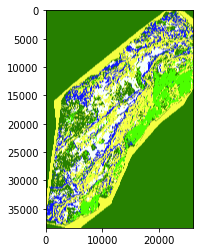

In [7]:
#model = load_model('C:\Data\BasicCNN_model.h5')
#model = tf.keras.models.load_model(b"C:\Data\BasicCNN_model.h5", compile = False)
model = tf.keras.models.load_model(r"C:\Users\Gavin\Models\Thesis Models 2022\LULC\CNNBase\Tuned\BasicCNN_LULC_tuned")
#model = tf.saved_model.load(export_dir=r'C:\Data\model', tags=None, options=None) 
model.summary()
predictingNewX(model,data_dir_list,data_path,width=83,height=83,layers=6)
merge_raster_in_folder(output_path,result_path)

In [8]:
print(tf.__version__)

2.7.0
